## Setup

In [7]:
import random
random.seed(2020)

import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import sparse

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, auc

In [8]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [9]:
# Utilities 
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.legend()
    
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        plt.legend()

def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))
    
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name+ ' (AUC = %0.3f)' % auc(fp, tp), linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
#     plt.xlim([-0.5,20])
#     plt.ylim([80,100.5])
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')
    
def AUCcalc(y_val_val, y_pred):
    fpr, tpr, thresholds = roc_curve(y_val_val, y_pred)
    tauc = auc(fpr, tpr)
    return tauc

## Data processing and exploration

In [10]:
full_preprocessed_train = pd.DataFrame(pd.read_csv(os.getcwd() + '/' + 'full_preprocessed_train.csv', sep=','))
full_preprocessed_val = pd.DataFrame(pd.read_csv(os.getcwd() + '/' + 'full_preprocessed_dev.csv', sep=','))

full_preprocessed_train = full_preprocessed_train.replace(np.nan, " ")
full_preprocessed_val = full_preprocessed_val.replace(np.nan, " ")

In [11]:
doc2vec_train = pd.DataFrame(pd.read_csv(os.getcwd() + '/' + 'dv_train.csv', sep=',', header=None))
doc2vec_val = pd.DataFrame(pd.read_csv(os.getcwd() + '/' + 'dv_val.csv', sep=',', header=None))

In [12]:
doc2vec_X_training_data = pd.concat([full_preprocessed_train, doc2vec_train], axis=1, sort=False)
doc2vec_X_val_data = pd.concat([full_preprocessed_val, doc2vec_val], axis=1, sort=False)

### Examine the class label imbalance

Let's look at the dataset imbalance:

In [13]:
neg, pos = np.bincount(doc2vec_X_training_data['label'])
total = neg + pos

### Clean and normalize the data

In [14]:
cleaned_train = doc2vec_X_training_data.copy()
cleaned_val = doc2vec_X_val_data.copy()

# You don't want the `Time` column.
cleaned_train = cleaned_train.drop(['date'], axis=1)
cleaned_val = cleaned_val.drop(['date'], axis=1)

# The `length` column covers a huge range. Convert to log-space.
eps=0.001 
cleaned_train['length'] = np.log(cleaned_train.pop('length')+eps)
cleaned_val['length'] = np.log(cleaned_val.pop('length')+eps)

In [15]:
# Can't normalize str col
cleaned_train = cleaned_train.drop(['review'], axis = 1)
cleaned_val = cleaned_val.drop(['review'], axis = 1)

In [16]:
train_df = cleaned_train.copy()
val_df = cleaned_val.copy()

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('label'))
val_labels = np.array(val_df.pop('label'))
# test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
# test_features = np.array(test_df)

Normalize the input features using the sklearn StandardScaler.
This will set the mean to 0 and standard deviation to 1.

Note: The `StandardScaler` is only fit using the `train_features` to be sure the model is not peeking at the validation or test sets. 

In [17]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
# test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
# test_features = np.clip(test_features, -5, 5)


## Define the model and metrics

Define a function that creates a simple neural network with a densly connected hidden layer, a [dropout](https://developers.google.com/machine-learning/glossary/#dropout_regularization) layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent: 

In [107]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    # Sequential groups a linear stack of layers into a tf.keras.Model.
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [108]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [109]:
initial_bias = np.log([pos/neg])

In [110]:
model = make_model(output_bias = initial_bias)

### Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [111]:
initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

### Train the model

## Class weights

### Calculate class weights

The goal is to identify fradulent transactions, but you don't have very many of those positive samples to work with, so you would want to have the classifier heavily weight the few examples that are available. You can do this by passing Keras weights for each class through a parameter. These will cause the model to "pay more attention" to examples from an under-represented class.

In [23]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

### Train a model with class weights

Now try re-training and evaluating the model with class weights to see how that affects the predictions.

Note: Using `class_weights` changes the range of the loss. This may affect the stability of the training depending on the optimizer. Optimizers whose step size is dependent on the magnitude of the gradient, like `optimizers.SGD`, may fail. The optimizer used here, `optimizers.Adam`, is unaffected by the scaling change. Also note that because of the weighting, the total losses are not comparable between the two models.

In [24]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
123/123 [==============================] - 1s 8ms/step - loss: 0.9383 - tp: 9010.0000 - fp: 51503.0000 - tn: 173552.0000 - fn: 16809.0000 - accuracy: 0.7277 - precision: 0.1489 - recall: 0.3490 - auc: 0.6008 - val_loss: 0.4457 - val_tp: 1235.0000 - val_fp: 5072.0000 - val_tn: 27198.0000 - val_fn: 2413.0000 - val_accuracy: 0.7916 - val_precision: 0.1958 - val_recall: 0.3385 - val_auc: 0.6804
Epoch 2/100
123/123 [==============================] - 0s 3ms/step - loss: 0.7605 - tp: 11550.0000 - fp: 58897.0000 - tn: 166158.0000 - fn: 14269.0000 - accuracy: 0.7084 - precision: 0.1640 - recall: 0.4473 - auc: 0.6469 - val_loss: 0.4405 - val_tp: 1364.0000 - val_fp: 4968.0000 - val_tn: 27302.0000 - val_fn: 2284.0000 - val_accuracy: 0.7981 - val_precision: 0.2154 - val_recall: 0.3739 - val_auc: 0.7170
Epoch 3/100
123/123 [==============================] - 0s 3ms/step - loss: 0.7095 - tp: 12418.0000 - fp: 59372.0000 - tn: 165683.0000 - fn: 13401.0000 - accuracy: 0.7099 - precision: 0.17

123/123 [==============================] - 0s 3ms/step - loss: 0.5920 - tp: 17677.0000 - fp: 73206.0000 - tn: 151849.0000 - fn: 8142.0000 - accuracy: 0.6757 - precision: 0.1945 - recall: 0.6847 - auc: 0.7453 - val_loss: 0.4251 - val_tp: 1174.0000 - val_fp: 3413.0000 - val_tn: 28857.0000 - val_fn: 2474.0000 - val_accuracy: 0.8361 - val_precision: 0.2559 - val_recall: 0.3218 - val_auc: 0.7516
Epoch 22/100
123/123 [==============================] - 0s 3ms/step - loss: 0.5897 - tp: 17778.0000 - fp: 73353.0000 - tn: 151702.0000 - fn: 8041.0000 - accuracy: 0.6756 - precision: 0.1951 - recall: 0.6886 - auc: 0.7471 - val_loss: 0.4230 - val_tp: 1121.0000 - val_fp: 3251.0000 - val_tn: 29019.0000 - val_fn: 2527.0000 - val_accuracy: 0.8391 - val_precision: 0.2564 - val_recall: 0.3073 - val_auc: 0.7511
Epoch 23/100
123/123 [==============================] - 0s 3ms/step - loss: 0.5883 - tp: 18010.0000 - fp: 74315.0000 - tn: 150740.0000 - fn: 7809.0000 - accuracy: 0.6726 - precision: 0.1951 - recall:

### Check training history

### Evaluate metrics

In [25]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
val_predictions_weighted = weighted_model.predict(val_features, batch_size=BATCH_SIZE)

### Plot the ROC

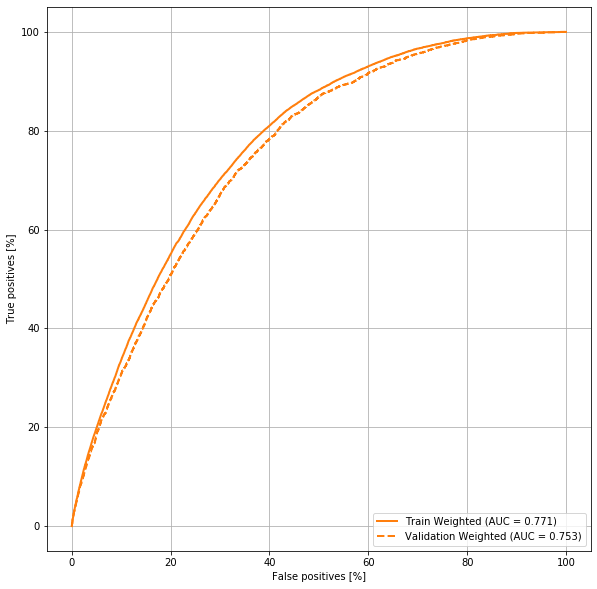

In [26]:
plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Validation Weighted", val_labels, val_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

In [27]:
print("Average Precision Report:")
print("Validation Weighted: ", average_precision_score(val_labels, val_predictions_weighted))

Average Precision Report:
Validation Weighted:  0.23542319568102624


In [28]:
print("AUC:")
print("Validation Weighted: ", AUCcalc(val_labels, val_predictions_weighted))

AUC:
Validation Weighted:  0.7527619125769957


# Tuning

In [29]:
from itertools import product

In [81]:
def make_model(metrics = METRICS, lr = 1e-3, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    # Sequential groups a linear stack of layers into a tf.keras.Model.
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=lr),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [43]:
# BATCH_SIZE = [2000, 10000]
# EPOCHS = [100, 250, 500]
# lr  = [0.001, 0.01, 0.1, 1.0]
BATCH_SIZE = [2000, 10000]
EPOCHS = [100]
lr  = list(np.unique(np.concatenate((10.**np.arange(-6,1,1), np.arange(1,3,.3)))) )

every_cart = list(product(BATCH_SIZE, EPOCHS, lr))

In [44]:
saved_iterations = {}

for i, j, k in every_cart:       
    weighted_model = make_model(lr = k)
    weighted_model.load_weights(initial_weights)

    weighted_history = weighted_model.fit(
        train_features,
        train_labels,
        batch_size=i,
        epochs=j,
        callbacks = [early_stopping],
        validation_data=(val_features, val_labels),
        # The class weights go here
        class_weight=class_weight) 

    val_predictions_weighted = weighted_model.predict(val_features, batch_size=i)
    AP = average_precision_score(val_labels, val_predictions_weighted)
    AUC = AUCcalc(val_labels, val_predictions_weighted)
    
    saved_iterations[(i, j, k)] = [AP, AUC]


Epoch 1/100
126/126 [==============================] - 1s 9ms/step - loss: 1.3586 - tp: 2514.0000 - fp: 17002.0000 - tn: 240323.0000 - fn: 26953.0000 - accuracy: 0.8467 - precision: 0.1288 - recall: 0.0853 - auc: 0.5234 - val_loss: 0.3622 - val_tp: 12.0000 - val_fp: 142.0000 - val_tn: 32128.0000 - val_fn: 3636.0000 - val_accuracy: 0.8948 - val_precision: 0.0779 - val_recall: 0.0033 - val_auc: 0.5080
Epoch 2/100
126/126 [==============================] - 0s 3ms/step - loss: 1.3606 - tp: 1657.0000 - fp: 15104.0000 - tn: 209951.0000 - fn: 24162.0000 - accuracy: 0.8435 - precision: 0.0989 - recall: 0.0642 - auc: 0.5037 - val_loss: 0.3618 - val_tp: 12.0000 - val_fp: 142.0000 - val_tn: 32128.0000 - val_fn: 3636.0000 - val_accuracy: 0.8948 - val_precision: 0.0779 - val_recall: 0.0033 - val_auc: 0.5095
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 1.3504 - tp: 1640.0000 - fp: 15159.0000 - tn: 209896.0000 - fn: 24179.0000 - accuracy: 0.8432 - precision: 0.0976 - rec

126/126 [==============================] - 0s 3ms/step - loss: 1.2885 - tp: 2255.0000 - fp: 17815.0000 - tn: 207240.0000 - fn: 23564.0000 - accuracy: 0.8351 - precision: 0.1124 - recall: 0.0873 - auc: 0.5240 - val_loss: 0.3581 - val_tp: 21.0000 - val_fp: 175.0000 - val_tn: 32095.0000 - val_fn: 3627.0000 - val_accuracy: 0.8941 - val_precision: 0.1071 - val_recall: 0.0058 - val_auc: 0.5413
Epoch 22/100
126/126 [==============================] - 0s 3ms/step - loss: 1.2780 - tp: 2317.0000 - fp: 17811.0000 - tn: 207244.0000 - fn: 23502.0000 - accuracy: 0.8353 - precision: 0.1151 - recall: 0.0897 - auc: 0.5280 - val_loss: 0.3581 - val_tp: 22.0000 - val_fp: 181.0000 - val_tn: 32089.0000 - val_fn: 3626.0000 - val_accuracy: 0.8940 - val_precision: 0.1084 - val_recall: 0.0060 - val_auc: 0.5428
Epoch 23/100
126/126 [==============================] - 0s 3ms/step - loss: 1.2771 - tp: 2377.0000 - fp: 17878.0000 - tn: 207177.0000 - fn: 23442.0000 - accuracy: 0.8353 - precision: 0.1174 - recall: 0.092

126/126 [==============================] - 0s 3ms/step - loss: 1.2238 - tp: 3091.0000 - fp: 21696.0000 - tn: 203359.0000 - fn: 22728.0000 - accuracy: 0.8229 - precision: 0.1247 - recall: 0.1197 - auc: 0.5420 - val_loss: 0.3605 - val_tp: 52.0000 - val_fp: 319.0000 - val_tn: 31951.0000 - val_fn: 3596.0000 - val_accuracy: 0.8910 - val_precision: 0.1402 - val_recall: 0.0143 - val_auc: 0.5668
Epoch 42/100
126/126 [==============================] - 0s 3ms/step - loss: 1.2212 - tp: 3203.0000 - fp: 22234.0000 - tn: 202821.0000 - fn: 22616.0000 - accuracy: 0.8212 - precision: 0.1259 - recall: 0.1241 - auc: 0.5431 - val_loss: 0.3608 - val_tp: 55.0000 - val_fp: 329.0000 - val_tn: 31941.0000 - val_fn: 3593.0000 - val_accuracy: 0.8908 - val_precision: 0.1432 - val_recall: 0.0151 - val_auc: 0.5678
Epoch 43/100
126/126 [==============================] - 0s 3ms/step - loss: 1.2138 - tp: 3290.0000 - fp: 22183.0000 - tn: 202872.0000 - fn: 22529.0000 - accuracy: 0.8218 - precision: 0.1292 - recall: 0.127

126/126 [==============================] - 0s 3ms/step - loss: 1.1696 - tp: 4080.0000 - fp: 26590.0000 - tn: 198465.0000 - fn: 21739.0000 - accuracy: 0.8074 - precision: 0.1330 - recall: 0.1580 - auc: 0.5565 - val_loss: 0.3690 - val_tp: 117.0000 - val_fp: 674.0000 - val_tn: 31596.0000 - val_fn: 3531.0000 - val_accuracy: 0.8829 - val_precision: 0.1479 - val_recall: 0.0321 - val_auc: 0.5847
Epoch 62/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1658 - tp: 4245.0000 - fp: 26975.0000 - tn: 198080.0000 - fn: 21574.0000 - accuracy: 0.8065 - precision: 0.1360 - recall: 0.1644 - auc: 0.5569 - val_loss: 0.3696 - val_tp: 119.0000 - val_fp: 687.0000 - val_tn: 31583.0000 - val_fn: 3529.0000 - val_accuracy: 0.8826 - val_precision: 0.1476 - val_recall: 0.0326 - val_auc: 0.5856
Epoch 63/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1606 - tp: 4238.0000 - fp: 27074.0000 - tn: 197981.0000 - fn: 21581.0000 - accuracy: 0.8061 - precision: 0.1353 - recall: 0.1

126/126 [==============================] - 0s 3ms/step - loss: 1.1313 - tp: 5121.0000 - fp: 31956.0000 - tn: 193099.0000 - fn: 20698.0000 - accuracy: 0.7901 - precision: 0.1381 - recall: 0.1983 - auc: 0.5666 - val_loss: 0.3829 - val_tp: 268.0000 - val_fp: 1350.0000 - val_tn: 30920.0000 - val_fn: 3380.0000 - val_accuracy: 0.8683 - val_precision: 0.1656 - val_recall: 0.0735 - val_auc: 0.5970
Epoch 82/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1297 - tp: 5176.0000 - fp: 32253.0000 - tn: 192802.0000 - fn: 20643.0000 - accuracy: 0.7892 - precision: 0.1383 - recall: 0.2005 - auc: 0.5667 - val_loss: 0.3837 - val_tp: 275.0000 - val_fp: 1386.0000 - val_tn: 30884.0000 - val_fn: 3373.0000 - val_accuracy: 0.8675 - val_precision: 0.1656 - val_recall: 0.0754 - val_auc: 0.5975
Epoch 83/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1228 - tp: 5202.0000 - fp: 32269.0000 - tn: 192786.0000 - fn: 20617.0000 - accuracy: 0.7892 - precision: 0.1388 - recall: 0

126/126 [==============================] - 1s 7ms/step - loss: 1.3403 - tp: 2266.0000 - fp: 17727.0000 - tn: 239598.0000 - fn: 27201.0000 - accuracy: 0.8433 - precision: 0.1133 - recall: 0.0769 - auc: 0.5210 - val_loss: 0.3595 - val_tp: 14.0000 - val_fp: 148.0000 - val_tn: 32122.0000 - val_fn: 3634.0000 - val_accuracy: 0.8947 - val_precision: 0.0864 - val_recall: 0.0038 - val_auc: 0.5240
Epoch 2/100
126/126 [==============================] - 0s 3ms/step - loss: 1.3080 - tp: 2040.0000 - fp: 16815.0000 - tn: 208240.0000 - fn: 23779.0000 - accuracy: 0.8382 - precision: 0.1082 - recall: 0.0790 - auc: 0.5188 - val_loss: 0.3582 - val_tp: 19.0000 - val_fp: 172.0000 - val_tn: 32098.0000 - val_fn: 3629.0000 - val_accuracy: 0.8942 - val_precision: 0.0995 - val_recall: 0.0052 - val_auc: 0.5401
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 1.2729 - tp: 2465.0000 - fp: 18351.0000 - tn: 206704.0000 - fn: 23354.0000 - accuracy: 0.8338 - precision: 0.1184 - recall: 0.0955 

126/126 [==============================] - 0s 3ms/step - loss: 1.0134 - tp: 7978.0000 - fp: 46439.0000 - tn: 178616.0000 - fn: 17841.0000 - accuracy: 0.7438 - precision: 0.1466 - recall: 0.3090 - auc: 0.5923 - val_loss: 0.4408 - val_tp: 920.0000 - val_fp: 4449.0000 - val_tn: 27821.0000 - val_fn: 2728.0000 - val_accuracy: 0.8002 - val_precision: 0.1714 - val_recall: 0.2522 - val_auc: 0.6208
Epoch 22/100
126/126 [==============================] - 0s 3ms/step - loss: 1.0132 - tp: 8062.0000 - fp: 46914.0000 - tn: 178141.0000 - fn: 17757.0000 - accuracy: 0.7422 - precision: 0.1466 - recall: 0.3123 - auc: 0.5903 - val_loss: 0.4421 - val_tp: 939.0000 - val_fp: 4524.0000 - val_tn: 27746.0000 - val_fn: 2709.0000 - val_accuracy: 0.7986 - val_precision: 0.1719 - val_recall: 0.2574 - val_auc: 0.6217
Epoch 23/100
126/126 [==============================] - 0s 3ms/step - loss: 1.0084 - tp: 8056.0000 - fp: 47383.0000 - tn: 177672.0000 - fn: 17763.0000 - accuracy: 0.7403 - precision: 0.1453 - recall: 0

126/126 [==============================] - 0s 3ms/step - loss: 0.9221 - tp: 9151.0000 - fp: 52062.0000 - tn: 172993.0000 - fn: 16668.0000 - accuracy: 0.7260 - precision: 0.1495 - recall: 0.3544 - auc: 0.6023 - val_loss: 0.4480 - val_tp: 1075.0000 - val_fp: 5014.0000 - val_tn: 27256.0000 - val_fn: 2573.0000 - val_accuracy: 0.7888 - val_precision: 0.1765 - val_recall: 0.2947 - val_auc: 0.6399
Epoch 42/100
126/126 [==============================] - 0s 3ms/step - loss: 0.9180 - tp: 9127.0000 - fp: 52298.0000 - tn: 172757.0000 - fn: 16692.0000 - accuracy: 0.7250 - precision: 0.1486 - recall: 0.3535 - auc: 0.6038 - val_loss: 0.4485 - val_tp: 1079.0000 - val_fp: 5036.0000 - val_tn: 27234.0000 - val_fn: 2569.0000 - val_accuracy: 0.7883 - val_precision: 0.1765 - val_recall: 0.2958 - val_auc: 0.6408
Epoch 43/100
126/126 [==============================] - 0s 3ms/step - loss: 0.9148 - tp: 9212.0000 - fp: 52865.0000 - tn: 172190.0000 - fn: 16607.0000 - accuracy: 0.7231 - precision: 0.1484 - recall:

126/126 [==============================] - 0s 3ms/step - loss: 0.8563 - tp: 9934.0000 - fp: 55481.0000 - tn: 169574.0000 - fn: 15885.0000 - accuracy: 0.7155 - precision: 0.1519 - recall: 0.3848 - auc: 0.6152 - val_loss: 0.4481 - val_tp: 1156.0000 - val_fp: 5136.0000 - val_tn: 27134.0000 - val_fn: 2492.0000 - val_accuracy: 0.7876 - val_precision: 0.1837 - val_recall: 0.3169 - val_auc: 0.6587
Epoch 62/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8520 - tp: 9946.0000 - fp: 55996.0000 - tn: 169059.0000 - fn: 15873.0000 - accuracy: 0.7135 - precision: 0.1508 - recall: 0.3852 - auc: 0.6163 - val_loss: 0.4483 - val_tp: 1160.0000 - val_fp: 5157.0000 - val_tn: 27113.0000 - val_fn: 2488.0000 - val_accuracy: 0.7872 - val_precision: 0.1836 - val_recall: 0.3180 - val_auc: 0.6596
Epoch 63/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8535 - tp: 9940.0000 - fp: 55756.0000 - tn: 169299.0000 - fn: 15879.0000 - accuracy: 0.7145 - precision: 0.1513 - recall:

126/126 [==============================] - 0s 3ms/step - loss: 0.8149 - tp: 10611.0000 - fp: 58029.0000 - tn: 167026.0000 - fn: 15208.0000 - accuracy: 0.7081 - precision: 0.1546 - recall: 0.4110 - auc: 0.6246 - val_loss: 0.4492 - val_tp: 1234.0000 - val_fp: 5192.0000 - val_tn: 27078.0000 - val_fn: 2414.0000 - val_accuracy: 0.7882 - val_precision: 0.1920 - val_recall: 0.3383 - val_auc: 0.6759
Epoch 82/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8100 - tp: 10645.0000 - fp: 58329.0000 - tn: 166726.0000 - fn: 15174.0000 - accuracy: 0.7070 - precision: 0.1543 - recall: 0.4123 - auc: 0.6273 - val_loss: 0.4492 - val_tp: 1238.0000 - val_fp: 5198.0000 - val_tn: 27072.0000 - val_fn: 2410.0000 - val_accuracy: 0.7882 - val_precision: 0.1924 - val_recall: 0.3394 - val_auc: 0.6766
Epoch 83/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8074 - tp: 10812.0000 - fp: 58326.0000 - tn: 166729.0000 - fn: 15007.0000 - accuracy: 0.7077 - precision: 0.1564 - reca

126/126 [==============================] - 1s 7ms/step - loss: 1.2115 - tp: 4977.0000 - fp: 29487.0000 - tn: 227838.0000 - fn: 24490.0000 - accuracy: 0.8118 - precision: 0.1444 - recall: 0.1689 - auc: 0.5570 - val_loss: 0.3949 - val_tp: 423.0000 - val_fp: 2002.0000 - val_tn: 30268.0000 - val_fn: 3225.0000 - val_accuracy: 0.8545 - val_precision: 0.1744 - val_recall: 0.1160 - val_auc: 0.6033
Epoch 2/100
126/126 [==============================] - 0s 3ms/step - loss: 1.0654 - tp: 7015.0000 - fp: 41948.0000 - tn: 183107.0000 - fn: 18804.0000 - accuracy: 0.7578 - precision: 0.1433 - recall: 0.2717 - auc: 0.5795 - val_loss: 0.4373 - val_tp: 882.0000 - val_fp: 4279.0000 - val_tn: 27991.0000 - val_fn: 2766.0000 - val_accuracy: 0.8039 - val_precision: 0.1709 - val_recall: 0.2418 - val_auc: 0.6191
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 1.0043 - tp: 8178.0000 - fp: 47876.0000 - tn: 177179.0000 - fn: 17641.0000 - accuracy: 0.7388 - precision: 0.1459 - recall: 0.3

126/126 [==============================] - 0s 3ms/step - loss: 0.7159 - tp: 12378.0000 - fp: 59265.0000 - tn: 165790.0000 - fn: 13441.0000 - accuracy: 0.7102 - precision: 0.1728 - recall: 0.4794 - auc: 0.6687 - val_loss: 0.4391 - val_tp: 1379.0000 - val_fp: 4867.0000 - val_tn: 27403.0000 - val_fn: 2269.0000 - val_accuracy: 0.8013 - val_precision: 0.2208 - val_recall: 0.3780 - val_auc: 0.7219
Epoch 22/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7131 - tp: 12484.0000 - fp: 59457.0000 - tn: 165598.0000 - fn: 13335.0000 - accuracy: 0.7098 - precision: 0.1735 - recall: 0.4835 - auc: 0.6705 - val_loss: 0.4382 - val_tp: 1373.0000 - val_fp: 4819.0000 - val_tn: 27451.0000 - val_fn: 2275.0000 - val_accuracy: 0.8025 - val_precision: 0.2217 - val_recall: 0.3764 - val_auc: 0.7240
Epoch 23/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7087 - tp: 12481.0000 - fp: 59883.0000 - tn: 165172.0000 - fn: 13338.0000 - accuracy: 0.7081 - precision: 0.1725 - reca

126/126 [==============================] - 0s 3ms/step - loss: 0.6509 - tp: 14177.0000 - fp: 61908.0000 - tn: 163147.0000 - fn: 11642.0000 - accuracy: 0.7068 - precision: 0.1863 - recall: 0.5491 - auc: 0.7059 - val_loss: 0.4386 - val_tp: 1473.0000 - val_fp: 4891.0000 - val_tn: 27379.0000 - val_fn: 2175.0000 - val_accuracy: 0.8033 - val_precision: 0.2315 - val_recall: 0.4038 - val_auc: 0.7437
Epoch 42/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6501 - tp: 14293.0000 - fp: 62413.0000 - tn: 162642.0000 - fn: 11526.0000 - accuracy: 0.7053 - precision: 0.1863 - recall: 0.5536 - auc: 0.7064 - val_loss: 0.4375 - val_tp: 1470.0000 - val_fp: 4827.0000 - val_tn: 27443.0000 - val_fn: 2178.0000 - val_accuracy: 0.8050 - val_precision: 0.2334 - val_recall: 0.4030 - val_auc: 0.7443
Epoch 43/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6479 - tp: 14344.0000 - fp: 62544.0000 - tn: 162511.0000 - fn: 11475.0000 - accuracy: 0.7050 - precision: 0.1866 - reca

126/126 [==============================] - 0s 3ms/step - loss: 0.6244 - tp: 15192.0000 - fp: 64119.0000 - tn: 160936.0000 - fn: 10627.0000 - accuracy: 0.7021 - precision: 0.1915 - recall: 0.5884 - auc: 0.7231 - val_loss: 0.4320 - val_tp: 1435.0000 - val_fp: 4576.0000 - val_tn: 27694.0000 - val_fn: 2213.0000 - val_accuracy: 0.8110 - val_precision: 0.2387 - val_recall: 0.3934 - val_auc: 0.7502
Epoch 62/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6258 - tp: 15206.0000 - fp: 64397.0000 - tn: 160658.0000 - fn: 10613.0000 - accuracy: 0.7010 - precision: 0.1910 - recall: 0.5889 - auc: 0.7215 - val_loss: 0.4317 - val_tp: 1440.0000 - val_fp: 4590.0000 - val_tn: 27680.0000 - val_fn: 2208.0000 - val_accuracy: 0.8107 - val_precision: 0.2388 - val_recall: 0.3947 - val_auc: 0.7503
Epoch 63/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6258 - tp: 15225.0000 - fp: 64573.0000 - tn: 160482.0000 - fn: 10594.0000 - accuracy: 0.7004 - precision: 0.1908 - reca

126/126 [==============================] - 0s 3ms/step - loss: 0.6106 - tp: 15965.0000 - fp: 66893.0000 - tn: 158162.0000 - fn: 9854.0000 - accuracy: 0.6941 - precision: 0.1927 - recall: 0.6183 - auc: 0.7315 - val_loss: 0.4277 - val_tp: 1399.0000 - val_fp: 4303.0000 - val_tn: 27967.0000 - val_fn: 2249.0000 - val_accuracy: 0.8176 - val_precision: 0.2454 - val_recall: 0.3835 - val_auc: 0.7522
Epoch 82/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6085 - tp: 15981.0000 - fp: 66470.0000 - tn: 158585.0000 - fn: 9838.0000 - accuracy: 0.6958 - precision: 0.1938 - recall: 0.6190 - auc: 0.7336 - val_loss: 0.4281 - val_tp: 1405.0000 - val_fp: 4339.0000 - val_tn: 27931.0000 - val_fn: 2243.0000 - val_accuracy: 0.8167 - val_precision: 0.2446 - val_recall: 0.3851 - val_auc: 0.7521
Epoch 83/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6104 - tp: 15949.0000 - fp: 66601.0000 - tn: 158454.0000 - fn: 9870.0000 - accuracy: 0.6952 - precision: 0.1932 - recall:

126/126 [==============================] - 1s 7ms/step - loss: 0.9423 - tp: 10284.0000 - fp: 55550.0000 - tn: 201775.0000 - fn: 19183.0000 - accuracy: 0.7394 - precision: 0.1562 - recall: 0.3490 - auc: 0.6104 - val_loss: 0.4452 - val_tp: 1236.0000 - val_fp: 5056.0000 - val_tn: 27214.0000 - val_fn: 2412.0000 - val_accuracy: 0.7921 - val_precision: 0.1964 - val_recall: 0.3388 - val_auc: 0.6804
Epoch 2/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7572 - tp: 11562.0000 - fp: 58682.0000 - tn: 166373.0000 - fn: 14257.0000 - accuracy: 0.7093 - precision: 0.1646 - recall: 0.4478 - auc: 0.6498 - val_loss: 0.4430 - val_tp: 1382.0000 - val_fp: 5050.0000 - val_tn: 27220.0000 - val_fn: 2266.0000 - val_accuracy: 0.7963 - val_precision: 0.2149 - val_recall: 0.3788 - val_auc: 0.7172
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7052 - tp: 12589.0000 - fp: 59492.0000 - tn: 165563.0000 - fn: 13230.0000 - accuracy: 0.7101 - precision: 0.1747 - recall

126/126 [==============================] - 0s 3ms/step - loss: 0.5905 - tp: 17703.0000 - fp: 72858.0000 - tn: 152197.0000 - fn: 8116.0000 - accuracy: 0.6772 - precision: 0.1955 - recall: 0.6857 - auc: 0.7469 - val_loss: 0.4224 - val_tp: 1135.0000 - val_fp: 3275.0000 - val_tn: 28995.0000 - val_fn: 2513.0000 - val_accuracy: 0.8389 - val_precision: 0.2574 - val_recall: 0.3111 - val_auc: 0.7524
Epoch 22/100
126/126 [==============================] - 0s 3ms/step - loss: 0.5907 - tp: 17684.0000 - fp: 73583.0000 - tn: 151472.0000 - fn: 8135.0000 - accuracy: 0.6743 - precision: 0.1938 - recall: 0.6849 - auc: 0.7463 - val_loss: 0.4234 - val_tp: 1089.0000 - val_fp: 3089.0000 - val_tn: 29181.0000 - val_fn: 2559.0000 - val_accuracy: 0.8428 - val_precision: 0.2607 - val_recall: 0.2985 - val_auc: 0.7509
Epoch 23/100
126/126 [==============================] - 0s 3ms/step - loss: 0.5887 - tp: 18066.0000 - fp: 74430.0000 - tn: 150625.0000 - fn: 7753.0000 - accuracy: 0.6724 - precision: 0.1953 - recall:

126/126 [==============================] - 0s 3ms/step - loss: 0.6099 - tp: 18023.0000 - fp: 79629.0000 - tn: 145426.0000 - fn: 7796.0000 - accuracy: 0.6515 - precision: 0.1846 - recall: 0.6981 - auc: 0.7302 - val_loss: 0.4719 - val_tp: 1966.0000 - val_fp: 7135.0000 - val_tn: 25135.0000 - val_fn: 1682.0000 - val_accuracy: 0.7545 - val_precision: 0.2160 - val_recall: 0.5389 - val_auc: 0.7448
Epoch 4/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6093 - tp: 17824.0000 - fp: 76854.0000 - tn: 148201.0000 - fn: 7995.0000 - accuracy: 0.6618 - precision: 0.1883 - recall: 0.6903 - auc: 0.7332 - val_loss: 0.4707 - val_tp: 1097.0000 - val_fp: 3378.0000 - val_tn: 28892.0000 - val_fn: 2551.0000 - val_accuracy: 0.8349 - val_precision: 0.2451 - val_recall: 0.3007 - val_auc: 0.7400
Epoch 5/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6119 - tp: 17676.0000 - fp: 76529.0000 - tn: 148526.0000 - fn: 8143.0000 - accuracy: 0.6625 - precision: 0.1876 - recall: 0

126/126 [==============================] - 0s 3ms/step - loss: 0.7238 - tp: 20497.0000 - fp: 150295.0000 - tn: 74760.0000 - fn: 5322.0000 - accuracy: 0.3797 - precision: 0.1200 - recall: 0.7939 - auc: 0.5758 - val_loss: 0.6558 - val_tp: 3155.0000 - val_fp: 20240.0000 - val_tn: 12030.0000 - val_fn: 493.0000 - val_accuracy: 0.4228 - val_precision: 0.1349 - val_recall: 0.8649 - val_auc: 0.6347
Epoch 11/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7102 - tp: 22993.0000 - fp: 171558.0000 - tn: 53497.0000 - fn: 2826.0000 - accuracy: 0.3049 - precision: 0.1182 - recall: 0.8905 - auc: 0.5658 - val_loss: 0.5642 - val_tp: 3139.0000 - val_fp: 19849.0000 - val_tn: 12421.0000 - val_fn: 509.0000 - val_accuracy: 0.4332 - val_precision: 0.1365 - val_recall: 0.8605 - val_auc: 0.6382
Epoch 12/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7227 - tp: 19419.0000 - fp: 146658.0000 - tn: 78397.0000 - fn: 6400.0000 - accuracy: 0.3899 - precision: 0.1169 - recall:

126/126 [==============================] - 1s 7ms/step - loss: 12.9418 - tp: 20269.0000 - fp: 135863.0000 - tn: 121462.0000 - fn: 9198.0000 - accuracy: 0.4942 - precision: 0.1298 - recall: 0.6879 - auc: 0.5854 - val_loss: 0.6122 - val_tp: 3012.0000 - val_fp: 16457.0000 - val_tn: 15813.0000 - val_fn: 636.0000 - val_accuracy: 0.5241 - val_precision: 0.1547 - val_recall: 0.8257 - val_auc: 0.6747
Epoch 2/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7854 - tp: 20927.0000 - fp: 147383.0000 - tn: 77672.0000 - fn: 4892.0000 - accuracy: 0.3930 - precision: 0.1243 - recall: 0.8105 - auc: 0.5861 - val_loss: 0.6592 - val_tp: 3375.0000 - val_fp: 22329.0000 - val_tn: 9941.0000 - val_fn: 273.0000 - val_accuracy: 0.3707 - val_precision: 0.1313 - val_recall: 0.9252 - val_auc: 0.6364
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7136 - tp: 21961.0000 - fp: 157638.0000 - tn: 67417.0000 - fn: 3858.0000 - accuracy: 0.3563 - precision: 0.1223 - recall: 

126/126 [==============================] - 0s 3ms/step - loss: 1.1286 - tp: 18562.0000 - fp: 148243.0000 - tn: 76812.0000 - fn: 7257.0000 - accuracy: 0.3802 - precision: 0.1113 - recall: 0.7189 - auc: 0.5377 - val_loss: 0.6818 - val_tp: 3492.0000 - val_fp: 26275.0000 - val_tn: 5995.0000 - val_fn: 156.0000 - val_accuracy: 0.2641 - val_precision: 0.1173 - val_recall: 0.9572 - val_auc: 0.5744
Epoch 11/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7579 - tp: 14805.0000 - fp: 123498.0000 - tn: 101557.0000 - fn: 11014.0000 - accuracy: 0.4638 - precision: 0.1070 - recall: 0.5734 - auc: 0.5216 - val_loss: 0.7047 - val_tp: 3512.0000 - val_fp: 27040.0000 - val_tn: 5230.0000 - val_fn: 136.0000 - val_accuracy: 0.2434 - val_precision: 0.1150 - val_recall: 0.9627 - val_auc: 0.5607
Epoch 1/100
126/126 [==============================] - 1s 7ms/step - loss: 22.7978 - tp: 22084.0000 - fp: 152860.0000 - tn: 104465.0000 - fn: 7383.0000 - accuracy: 0.4413 - precision: 0.1262 - recall

126/126 [==============================] - 0s 3ms/step - loss: 0.7147 - tp: 15436.0000 - fp: 126761.0000 - tn: 98294.0000 - fn: 10383.0000 - accuracy: 0.4533 - precision: 0.1086 - recall: 0.5979 - auc: 0.5315 - val_loss: 0.6141 - val_tp: 63.0000 - val_fp: 1201.0000 - val_tn: 31069.0000 - val_fn: 3585.0000 - val_accuracy: 0.8668 - val_precision: 0.0498 - val_recall: 0.0173 - val_auc: 0.5268
Epoch 9/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7069 - tp: 16572.0000 - fp: 138934.0000 - tn: 86121.0000 - fn: 9247.0000 - accuracy: 0.4093 - precision: 0.1066 - recall: 0.6419 - auc: 0.5185 - val_loss: 0.7113 - val_tp: 3540.0000 - val_fp: 28212.0000 - val_tn: 4058.0000 - val_fn: 108.0000 - val_accuracy: 0.2115 - val_precision: 0.1115 - val_recall: 0.9704 - val_auc: 0.5512
Epoch 10/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7053 - tp: 14894.0000 - fp: 125211.0000 - tn: 99844.0000 - fn: 10925.0000 - accuracy: 0.4574 - precision: 0.1063 - recall: 0

26/26 [==============================] - 0s 15ms/step - loss: 1.3553 - tp: 1678.0000 - fp: 15003.0000 - tn: 210052.0000 - fn: 24141.0000 - accuracy: 0.8440 - precision: 0.1006 - recall: 0.0650 - auc: 0.5062 - val_loss: 0.3620 - val_tp: 12.0000 - val_fp: 142.0000 - val_tn: 32128.0000 - val_fn: 3636.0000 - val_accuracy: 0.8948 - val_precision: 0.0779 - val_recall: 0.0033 - val_auc: 0.5085
Epoch 7/100
26/26 [==============================] - 0s 15ms/step - loss: 1.3508 - tp: 1658.0000 - fp: 15029.0000 - tn: 210026.0000 - fn: 24161.0000 - accuracy: 0.8438 - precision: 0.0994 - recall: 0.0642 - auc: 0.5096 - val_loss: 0.3620 - val_tp: 12.0000 - val_fp: 141.0000 - val_tn: 32129.0000 - val_fn: 3636.0000 - val_accuracy: 0.8948 - val_precision: 0.0784 - val_recall: 0.0033 - val_auc: 0.5089
Epoch 8/100
26/26 [==============================] - 0s 15ms/step - loss: 1.3475 - tp: 1716.0000 - fp: 15055.0000 - tn: 210000.0000 - fn: 24103.0000 - accuracy: 0.8439 - precision: 0.1023 - recall: 0.0665 - a

26/26 [==============================] - 0s 15ms/step - loss: 1.3457 - tp: 1739.0000 - fp: 15523.0000 - tn: 209532.0000 - fn: 24080.0000 - accuracy: 0.8421 - precision: 0.1007 - recall: 0.0674 - auc: 0.5100 - val_loss: 0.3606 - val_tp: 13.0000 - val_fp: 136.0000 - val_tn: 32134.0000 - val_fn: 3635.0000 - val_accuracy: 0.8950 - val_precision: 0.0872 - val_recall: 0.0036 - val_auc: 0.5166
Epoch 27/100
26/26 [==============================] - 0s 15ms/step - loss: 1.3421 - tp: 1736.0000 - fp: 15625.0000 - tn: 209430.0000 - fn: 24083.0000 - accuracy: 0.8417 - precision: 0.1000 - recall: 0.0672 - auc: 0.5087 - val_loss: 0.3605 - val_tp: 13.0000 - val_fp: 136.0000 - val_tn: 32134.0000 - val_fn: 3635.0000 - val_accuracy: 0.8950 - val_precision: 0.0872 - val_recall: 0.0036 - val_auc: 0.5169
Epoch 28/100
26/26 [==============================] - 0s 15ms/step - loss: 1.3417 - tp: 1737.0000 - fp: 15640.0000 - tn: 209415.0000 - fn: 24082.0000 - accuracy: 0.8417 - precision: 0.1000 - recall: 0.0673 -

26/26 [==============================] - 0s 15ms/step - loss: 1.3186 - tp: 1948.0000 - fp: 16228.0000 - tn: 208827.0000 - fn: 23871.0000 - accuracy: 0.8402 - precision: 0.1072 - recall: 0.0754 - auc: 0.5179 - val_loss: 0.3594 - val_tp: 14.0000 - val_fp: 148.0000 - val_tn: 32122.0000 - val_fn: 3634.0000 - val_accuracy: 0.8947 - val_precision: 0.0864 - val_recall: 0.0038 - val_auc: 0.5243
Epoch 47/100
26/26 [==============================] - 0s 15ms/step - loss: 1.3150 - tp: 1962.0000 - fp: 16125.0000 - tn: 208930.0000 - fn: 23857.0000 - accuracy: 0.8406 - precision: 0.1085 - recall: 0.0760 - auc: 0.5181 - val_loss: 0.3594 - val_tp: 14.0000 - val_fp: 149.0000 - val_tn: 32121.0000 - val_fn: 3634.0000 - val_accuracy: 0.8947 - val_precision: 0.0859 - val_recall: 0.0038 - val_auc: 0.5246
Epoch 48/100
26/26 [==============================] - 0s 15ms/step - loss: 1.3126 - tp: 1951.0000 - fp: 16099.0000 - tn: 208956.0000 - fn: 23868.0000 - accuracy: 0.8407 - precision: 0.1081 - recall: 0.0756 -

26/26 [==============================] - 0s 15ms/step - loss: 1.3053 - tp: 2012.0000 - fp: 16756.0000 - tn: 208299.0000 - fn: 23807.0000 - accuracy: 0.8383 - precision: 0.1072 - recall: 0.0779 - auc: 0.5206 - val_loss: 0.3586 - val_tp: 16.0000 - val_fp: 156.0000 - val_tn: 32114.0000 - val_fn: 3632.0000 - val_accuracy: 0.8945 - val_precision: 0.0930 - val_recall: 0.0044 - val_auc: 0.5315
Epoch 67/100
26/26 [==============================] - 0s 15ms/step - loss: 1.3027 - tp: 2041.0000 - fp: 16593.0000 - tn: 208462.0000 - fn: 23778.0000 - accuracy: 0.8391 - precision: 0.1095 - recall: 0.0791 - auc: 0.5214 - val_loss: 0.3586 - val_tp: 16.0000 - val_fp: 156.0000 - val_tn: 32114.0000 - val_fn: 3632.0000 - val_accuracy: 0.8945 - val_precision: 0.0930 - val_recall: 0.0044 - val_auc: 0.5318
Epoch 68/100
26/26 [==============================] - 0s 15ms/step - loss: 1.3035 - tp: 2103.0000 - fp: 16761.0000 - tn: 208294.0000 - fn: 23716.0000 - accuracy: 0.8387 - precision: 0.1115 - recall: 0.0815 -

26/26 [==============================] - 0s 15ms/step - loss: 1.2870 - tp: 2233.0000 - fp: 17208.0000 - tn: 207847.0000 - fn: 23586.0000 - accuracy: 0.8374 - precision: 0.1149 - recall: 0.0865 - auc: 0.5266 - val_loss: 0.3581 - val_tp: 19.0000 - val_fp: 172.0000 - val_tn: 32098.0000 - val_fn: 3629.0000 - val_accuracy: 0.8942 - val_precision: 0.0995 - val_recall: 0.0052 - val_auc: 0.5387
Epoch 87/100
26/26 [==============================] - 0s 16ms/step - loss: 1.2884 - tp: 2289.0000 - fp: 17565.0000 - tn: 207490.0000 - fn: 23530.0000 - accuracy: 0.8362 - precision: 0.1153 - recall: 0.0887 - auc: 0.5252 - val_loss: 0.3581 - val_tp: 19.0000 - val_fp: 172.0000 - val_tn: 32098.0000 - val_fn: 3629.0000 - val_accuracy: 0.8942 - val_precision: 0.0995 - val_recall: 0.0052 - val_auc: 0.5389
Epoch 88/100
26/26 [==============================] - 0s 17ms/step - loss: 1.2896 - tp: 2191.0000 - fp: 17305.0000 - tn: 207750.0000 - fn: 23628.0000 - accuracy: 0.8368 - precision: 0.1124 - recall: 0.0849 -

26/26 [==============================] - 0s 16ms/step - loss: 1.3148 - tp: 1992.0000 - fp: 16337.0000 - tn: 208718.0000 - fn: 23827.0000 - accuracy: 0.8399 - precision: 0.1087 - recall: 0.0772 - auc: 0.5179 - val_loss: 0.3588 - val_tp: 16.0000 - val_fp: 155.0000 - val_tn: 32115.0000 - val_fn: 3632.0000 - val_accuracy: 0.8946 - val_precision: 0.0936 - val_recall: 0.0044 - val_auc: 0.5299
Epoch 7/100
26/26 [==============================] - 0s 16ms/step - loss: 1.3093 - tp: 2118.0000 - fp: 16615.0000 - tn: 208440.0000 - fn: 23701.0000 - accuracy: 0.8393 - precision: 0.1131 - recall: 0.0820 - auc: 0.5181 - val_loss: 0.3585 - val_tp: 17.0000 - val_fp: 159.0000 - val_tn: 32111.0000 - val_fn: 3631.0000 - val_accuracy: 0.8945 - val_precision: 0.0966 - val_recall: 0.0047 - val_auc: 0.5333
Epoch 8/100
26/26 [==============================] - 0s 16ms/step - loss: 1.3005 - tp: 2179.0000 - fp: 17000.0000 - tn: 208055.0000 - fn: 23640.0000 - accuracy: 0.8380 - precision: 0.1136 - recall: 0.0844 - a

26/26 [==============================] - 0s 16ms/step - loss: 1.1803 - tp: 3874.0000 - fp: 25052.0000 - tn: 200003.0000 - fn: 21945.0000 - accuracy: 0.8127 - precision: 0.1339 - recall: 0.1500 - auc: 0.5541 - val_loss: 0.3659 - val_tp: 97.0000 - val_fp: 538.0000 - val_tn: 31732.0000 - val_fn: 3551.0000 - val_accuracy: 0.8862 - val_precision: 0.1528 - val_recall: 0.0266 - val_auc: 0.5810
Epoch 27/100
26/26 [==============================] - 0s 16ms/step - loss: 1.1779 - tp: 3983.0000 - fp: 25525.0000 - tn: 199530.0000 - fn: 21836.0000 - accuracy: 0.8112 - precision: 0.1350 - recall: 0.1543 - auc: 0.5534 - val_loss: 0.3669 - val_tp: 103.0000 - val_fp: 589.0000 - val_tn: 31681.0000 - val_fn: 3545.0000 - val_accuracy: 0.8849 - val_precision: 0.1488 - val_recall: 0.0282 - val_auc: 0.5824
Epoch 28/100
26/26 [==============================] - 0s 16ms/step - loss: 1.1719 - tp: 4044.0000 - fp: 26098.0000 - tn: 198957.0000 - fn: 21775.0000 - accuracy: 0.8092 - precision: 0.1342 - recall: 0.1566 

26/26 [==============================] - 0s 17ms/step - loss: 1.1053 - tp: 5742.0000 - fp: 35045.0000 - tn: 190010.0000 - fn: 20077.0000 - accuracy: 0.7803 - precision: 0.1408 - recall: 0.2224 - auc: 0.5714 - val_loss: 0.3924 - val_tp: 409.0000 - val_fp: 1916.0000 - val_tn: 30354.0000 - val_fn: 3239.0000 - val_accuracy: 0.8565 - val_precision: 0.1759 - val_recall: 0.1121 - val_auc: 0.6026
Epoch 47/100
26/26 [==============================] - 0s 17ms/step - loss: 1.1019 - tp: 5671.0000 - fp: 35101.0000 - tn: 189954.0000 - fn: 20148.0000 - accuracy: 0.7798 - precision: 0.1391 - recall: 0.2196 - auc: 0.5725 - val_loss: 0.3939 - val_tp: 429.0000 - val_fp: 1991.0000 - val_tn: 30279.0000 - val_fn: 3219.0000 - val_accuracy: 0.8549 - val_precision: 0.1773 - val_recall: 0.1176 - val_auc: 0.6033
Epoch 48/100
26/26 [==============================] - 0s 17ms/step - loss: 1.1012 - tp: 5804.0000 - fp: 35750.0000 - tn: 189305.0000 - fn: 20015.0000 - accuracy: 0.7777 - precision: 0.1397 - recall: 0.22

Epoch 66/100
26/26 [==============================] - 0s 17ms/step - loss: 1.0567 - tp: 7102.0000 - fp: 41782.0000 - tn: 183273.0000 - fn: 18717.0000 - accuracy: 0.7588 - precision: 0.1453 - recall: 0.2751 - auc: 0.5833 - val_loss: 0.4194 - val_tp: 717.0000 - val_fp: 3371.0000 - val_tn: 28899.0000 - val_fn: 2931.0000 - val_accuracy: 0.8245 - val_precision: 0.1754 - val_recall: 0.1965 - val_auc: 0.6129
Epoch 67/100
26/26 [==============================] - 0s 16ms/step - loss: 1.0551 - tp: 7057.0000 - fp: 41737.0000 - tn: 183318.0000 - fn: 18762.0000 - accuracy: 0.7588 - precision: 0.1446 - recall: 0.2733 - auc: 0.5826 - val_loss: 0.4206 - val_tp: 730.0000 - val_fp: 3420.0000 - val_tn: 28850.0000 - val_fn: 2918.0000 - val_accuracy: 0.8235 - val_precision: 0.1759 - val_recall: 0.2001 - val_auc: 0.6133
Epoch 68/100
26/26 [==============================] - 0s 17ms/step - loss: 1.0518 - tp: 7150.0000 - fp: 42180.0000 - tn: 182875.0000 - fn: 18669.0000 - accuracy: 0.7575 - precision: 0.1449 -

26/26 [==============================] - 0s 17ms/step - loss: 1.0281 - tp: 7779.0000 - fp: 45527.0000 - tn: 179528.0000 - fn: 18040.0000 - accuracy: 0.7466 - precision: 0.1459 - recall: 0.3013 - auc: 0.5854 - val_loss: 0.4364 - val_tp: 886.0000 - val_fp: 4239.0000 - val_tn: 28031.0000 - val_fn: 2762.0000 - val_accuracy: 0.8051 - val_precision: 0.1729 - val_recall: 0.2429 - val_auc: 0.6191
Epoch 87/100
26/26 [==============================] - 0s 16ms/step - loss: 1.0264 - tp: 7764.0000 - fp: 45875.0000 - tn: 179180.0000 - fn: 18055.0000 - accuracy: 0.7452 - precision: 0.1447 - recall: 0.3007 - auc: 0.5855 - val_loss: 0.4370 - val_tp: 891.0000 - val_fp: 4279.0000 - val_tn: 27991.0000 - val_fn: 2757.0000 - val_accuracy: 0.8041 - val_precision: 0.1723 - val_recall: 0.2442 - val_auc: 0.6193
Epoch 88/100
26/26 [==============================] - 0s 17ms/step - loss: 1.0191 - tp: 7806.0000 - fp: 45781.0000 - tn: 179274.0000 - fn: 18013.0000 - accuracy: 0.7457 - precision: 0.1457 - recall: 0.30

26/26 [==============================] - 0s 17ms/step - loss: 1.0773 - tp: 6478.0000 - fp: 39076.0000 - tn: 185979.0000 - fn: 19341.0000 - accuracy: 0.7671 - precision: 0.1422 - recall: 0.2509 - auc: 0.5793 - val_loss: 0.4154 - val_tp: 668.0000 - val_fp: 3172.0000 - val_tn: 29098.0000 - val_fn: 2980.0000 - val_accuracy: 0.8287 - val_precision: 0.1740 - val_recall: 0.1831 - val_auc: 0.6112
Epoch 7/100
26/26 [==============================] - 0s 16ms/step - loss: 1.0567 - tp: 7112.0000 - fp: 42037.0000 - tn: 183018.0000 - fn: 18707.0000 - accuracy: 0.7579 - precision: 0.1447 - recall: 0.2755 - auc: 0.5829 - val_loss: 0.4257 - val_tp: 780.0000 - val_fp: 3690.0000 - val_tn: 28580.0000 - val_fn: 2868.0000 - val_accuracy: 0.8174 - val_precision: 0.1745 - val_recall: 0.2138 - val_auc: 0.6147
Epoch 8/100
26/26 [==============================] - 0s 16ms/step - loss: 1.0473 - tp: 7360.0000 - fp: 43984.0000 - tn: 181071.0000 - fn: 18459.0000 - accuracy: 0.7511 - precision: 0.1433 - recall: 0.2851

26/26 [==============================] - 0s 16ms/step - loss: 0.8809 - tp: 9490.0000 - fp: 54146.0000 - tn: 170909.0000 - fn: 16329.0000 - accuracy: 0.7191 - precision: 0.1491 - recall: 0.3676 - auc: 0.6088 - val_loss: 0.4492 - val_tp: 1153.0000 - val_fp: 5170.0000 - val_tn: 27100.0000 - val_fn: 2495.0000 - val_accuracy: 0.7866 - val_precision: 0.1824 - val_recall: 0.3161 - val_auc: 0.6533
Epoch 27/100
26/26 [==============================] - 0s 16ms/step - loss: 0.8699 - tp: 9674.0000 - fp: 54316.0000 - tn: 170739.0000 - fn: 16145.0000 - accuracy: 0.7191 - precision: 0.1512 - recall: 0.3747 - auc: 0.6132 - val_loss: 0.4485 - val_tp: 1161.0000 - val_fp: 5135.0000 - val_tn: 27135.0000 - val_fn: 2487.0000 - val_accuracy: 0.7878 - val_precision: 0.1844 - val_recall: 0.3183 - val_auc: 0.6551
Epoch 28/100
26/26 [==============================] - 0s 16ms/step - loss: 0.8690 - tp: 9656.0000 - fp: 54525.0000 - tn: 170530.0000 - fn: 16163.0000 - accuracy: 0.7182 - precision: 0.1504 - recall: 0.

26/26 [==============================] - 0s 16ms/step - loss: 0.7933 - tp: 10808.0000 - fp: 57188.0000 - tn: 167867.0000 - fn: 15011.0000 - accuracy: 0.7122 - precision: 0.1590 - recall: 0.4186 - auc: 0.6343 - val_loss: 0.4451 - val_tp: 1260.0000 - val_fp: 5069.0000 - val_tn: 27201.0000 - val_fn: 2388.0000 - val_accuracy: 0.7924 - val_precision: 0.1991 - val_recall: 0.3454 - val_auc: 0.6849
Epoch 47/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7894 - tp: 10929.0000 - fp: 57448.0000 - tn: 167607.0000 - fn: 14890.0000 - accuracy: 0.7117 - precision: 0.1598 - recall: 0.4233 - auc: 0.6359 - val_loss: 0.4452 - val_tp: 1267.0000 - val_fp: 5088.0000 - val_tn: 27182.0000 - val_fn: 2381.0000 - val_accuracy: 0.7921 - val_precision: 0.1994 - val_recall: 0.3473 - val_auc: 0.6863
Epoch 48/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7839 - tp: 10927.0000 - fp: 57215.0000 - tn: 167840.0000 - fn: 14892.0000 - accuracy: 0.7126 - precision: 0.1604 - recall:

26/26 [==============================] - 0s 16ms/step - loss: 0.7464 - tp: 11608.0000 - fp: 58081.0000 - tn: 166974.0000 - fn: 14211.0000 - accuracy: 0.7118 - precision: 0.1666 - recall: 0.4496 - auc: 0.6536 - val_loss: 0.4408 - val_tp: 1308.0000 - val_fp: 4897.0000 - val_tn: 27373.0000 - val_fn: 2340.0000 - val_accuracy: 0.7985 - val_precision: 0.2108 - val_recall: 0.3586 - val_auc: 0.7065
Epoch 67/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7438 - tp: 11657.0000 - fp: 57747.0000 - tn: 167308.0000 - fn: 14162.0000 - accuracy: 0.7134 - precision: 0.1680 - recall: 0.4515 - auc: 0.6554 - val_loss: 0.4408 - val_tp: 1309.0000 - val_fp: 4902.0000 - val_tn: 27368.0000 - val_fn: 2339.0000 - val_accuracy: 0.7984 - val_precision: 0.2108 - val_recall: 0.3588 - val_auc: 0.7075
Epoch 68/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7399 - tp: 11781.0000 - fp: 58028.0000 - tn: 167027.0000 - fn: 14038.0000 - accuracy: 0.7127 - precision: 0.1688 - recall:

26/26 [==============================] - 0s 16ms/step - loss: 0.7192 - tp: 12069.0000 - fp: 58422.0000 - tn: 166633.0000 - fn: 13750.0000 - accuracy: 0.7123 - precision: 0.1712 - recall: 0.4674 - auc: 0.6658 - val_loss: 0.4379 - val_tp: 1346.0000 - val_fp: 4806.0000 - val_tn: 27464.0000 - val_fn: 2302.0000 - val_accuracy: 0.8021 - val_precision: 0.2188 - val_recall: 0.3690 - val_auc: 0.7210
Epoch 87/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7151 - tp: 12207.0000 - fp: 58312.0000 - tn: 166743.0000 - fn: 13612.0000 - accuracy: 0.7133 - precision: 0.1731 - recall: 0.4728 - auc: 0.6694 - val_loss: 0.4379 - val_tp: 1345.0000 - val_fp: 4816.0000 - val_tn: 27454.0000 - val_fn: 2303.0000 - val_accuracy: 0.8018 - val_precision: 0.2183 - val_recall: 0.3687 - val_auc: 0.7216
Epoch 88/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7115 - tp: 12266.0000 - fp: 58242.0000 - tn: 166813.0000 - fn: 13553.0000 - accuracy: 0.7138 - precision: 0.1740 - recall:

26/26 [==============================] - 1s 25ms/step - loss: 0.7737 - tp: 11084.0000 - fp: 58456.0000 - tn: 166599.0000 - fn: 14735.0000 - accuracy: 0.7083 - precision: 0.1594 - recall: 0.4293 - auc: 0.6396 - val_loss: 0.4419 - val_tp: 1301.0000 - val_fp: 4905.0000 - val_tn: 27365.0000 - val_fn: 2347.0000 - val_accuracy: 0.7981 - val_precision: 0.2096 - val_recall: 0.3566 - val_auc: 0.6998
Epoch 7/100
26/26 [==============================] - 0s 15ms/step - loss: 0.7506 - tp: 11488.0000 - fp: 58241.0000 - tn: 166814.0000 - fn: 14331.0000 - accuracy: 0.7107 - precision: 0.1648 - recall: 0.4449 - auc: 0.6511 - val_loss: 0.4472 - val_tp: 1387.0000 - val_fp: 5245.0000 - val_tn: 27025.0000 - val_fn: 2261.0000 - val_accuracy: 0.7910 - val_precision: 0.2091 - val_recall: 0.3802 - val_auc: 0.7082
Epoch 8/100
26/26 [==============================] - 0s 15ms/step - loss: 0.7322 - tp: 11902.0000 - fp: 58706.0000 - tn: 166349.0000 - fn: 13917.0000 - accuracy: 0.7105 - precision: 0.1686 - recall: 0

26/26 [==============================] - 0s 15ms/step - loss: 0.6351 - tp: 14665.0000 - fp: 62068.0000 - tn: 162987.0000 - fn: 11154.0000 - accuracy: 0.7081 - precision: 0.1911 - recall: 0.5680 - auc: 0.7179 - val_loss: 0.4302 - val_tp: 1491.0000 - val_fp: 4875.0000 - val_tn: 27395.0000 - val_fn: 2157.0000 - val_accuracy: 0.8042 - val_precision: 0.2342 - val_recall: 0.4087 - val_auc: 0.7501
Epoch 27/100
26/26 [==============================] - 0s 15ms/step - loss: 0.6330 - tp: 14792.0000 - fp: 62241.0000 - tn: 162814.0000 - fn: 11027.0000 - accuracy: 0.7079 - precision: 0.1920 - recall: 0.5729 - auc: 0.7197 - val_loss: 0.4319 - val_tp: 1504.0000 - val_fp: 4921.0000 - val_tn: 27349.0000 - val_fn: 2144.0000 - val_accuracy: 0.8033 - val_precision: 0.2341 - val_recall: 0.4123 - val_auc: 0.7504
Epoch 28/100
26/26 [==============================] - 0s 15ms/step - loss: 0.6305 - tp: 14912.0000 - fp: 62544.0000 - tn: 162511.0000 - fn: 10907.0000 - accuracy: 0.7072 - precision: 0.1925 - recall:

26/26 [==============================] - 0s 15ms/step - loss: 0.6089 - tp: 16004.0000 - fp: 66027.0000 - tn: 159028.0000 - fn: 9815.0000 - accuracy: 0.6977 - precision: 0.1951 - recall: 0.6199 - auc: 0.7351 - val_loss: 0.4161 - val_tp: 1264.0000 - val_fp: 3865.0000 - val_tn: 28405.0000 - val_fn: 2384.0000 - val_accuracy: 0.8260 - val_precision: 0.2464 - val_recall: 0.3465 - val_auc: 0.7539
Epoch 47/100
26/26 [==============================] - 0s 15ms/step - loss: 0.6079 - tp: 15984.0000 - fp: 65919.0000 - tn: 159136.0000 - fn: 9835.0000 - accuracy: 0.6980 - precision: 0.1952 - recall: 0.6191 - auc: 0.7351 - val_loss: 0.4153 - val_tp: 1281.0000 - val_fp: 3948.0000 - val_tn: 28322.0000 - val_fn: 2367.0000 - val_accuracy: 0.8242 - val_precision: 0.2450 - val_recall: 0.3512 - val_auc: 0.7538
Epoch 48/100
26/26 [==============================] - 0s 15ms/step - loss: 0.6063 - tp: 15982.0000 - fp: 65558.0000 - tn: 159497.0000 - fn: 9837.0000 - accuracy: 0.6995 - precision: 0.1960 - recall: 0.

26/26 [==============================] - 0s 15ms/step - loss: 0.5966 - tp: 16612.0000 - fp: 67687.0000 - tn: 157368.0000 - fn: 9207.0000 - accuracy: 0.6935 - precision: 0.1971 - recall: 0.6434 - auc: 0.7430 - val_loss: 0.4131 - val_tp: 1140.0000 - val_fp: 3349.0000 - val_tn: 28921.0000 - val_fn: 2508.0000 - val_accuracy: 0.8369 - val_precision: 0.2540 - val_recall: 0.3125 - val_auc: 0.7538
Epoch 67/100
26/26 [==============================] - 0s 15ms/step - loss: 0.5984 - tp: 16657.0000 - fp: 68604.0000 - tn: 156451.0000 - fn: 9162.0000 - accuracy: 0.6900 - precision: 0.1954 - recall: 0.6451 - auc: 0.7413 - val_loss: 0.4109 - val_tp: 1115.0000 - val_fp: 3218.0000 - val_tn: 29052.0000 - val_fn: 2533.0000 - val_accuracy: 0.8399 - val_precision: 0.2573 - val_recall: 0.3056 - val_auc: 0.7538
Epoch 68/100
26/26 [==============================] - 0s 15ms/step - loss: 0.5940 - tp: 16845.0000 - fp: 68285.0000 - tn: 156770.0000 - fn: 8974.0000 - accuracy: 0.6920 - precision: 0.1979 - recall: 0.

26/26 [==============================] - 0s 15ms/step - loss: 0.5871 - tp: 18433.0000 - fp: 76617.0000 - tn: 148438.0000 - fn: 7386.0000 - accuracy: 0.6652 - precision: 0.1939 - recall: 0.7139 - auc: 0.7508 - val_loss: 0.4317 - val_tp: 1044.0000 - val_fp: 2911.0000 - val_tn: 29359.0000 - val_fn: 2604.0000 - val_accuracy: 0.8465 - val_precision: 0.2640 - val_recall: 0.2862 - val_auc: 0.7498
Epoch 19/100
26/26 [==============================] - 0s 15ms/step - loss: 0.5865 - tp: 18806.0000 - fp: 77422.0000 - tn: 147633.0000 - fn: 7013.0000 - accuracy: 0.6634 - precision: 0.1954 - recall: 0.7284 - auc: 0.7518 - val_loss: 0.4412 - val_tp: 1317.0000 - val_fp: 4133.0000 - val_tn: 28137.0000 - val_fn: 2331.0000 - val_accuracy: 0.8200 - val_precision: 0.2417 - val_recall: 0.3610 - val_auc: 0.7470
Epoch 20/100
26/26 [==============================] - 0s 16ms/step - loss: 0.5858 - tp: 18789.0000 - fp: 77262.0000 - tn: 147793.0000 - fn: 7030.0000 - accuracy: 0.6640 - precision: 0.1956 - recall: 0.

26/26 [==============================] - 0s 17ms/step - loss: 0.5904 - tp: 19003.0000 - fp: 80083.0000 - tn: 144972.0000 - fn: 6816.0000 - accuracy: 0.6536 - precision: 0.1918 - recall: 0.7360 - auc: 0.7485 - val_loss: 0.4720 - val_tp: 1596.0000 - val_fp: 5636.0000 - val_tn: 26634.0000 - val_fn: 2052.0000 - val_accuracy: 0.7860 - val_precision: 0.2207 - val_recall: 0.4375 - val_auc: 0.7430
Epoch 1/100
26/26 [==============================] - 1s 36ms/step - loss: 27.1086 - tp: 17150.0000 - fp: 114484.0000 - tn: 142841.0000 - fn: 12317.0000 - accuracy: 0.5579 - precision: 0.1303 - recall: 0.5820 - auc: 0.5697 - val_loss: 2.7915 - val_tp: 2911.0000 - val_fp: 18509.0000 - val_tn: 13761.0000 - val_fn: 737.0000 - val_accuracy: 0.4642 - val_precision: 0.1359 - val_recall: 0.7980 - val_auc: 0.6317
Epoch 2/100
26/26 [==============================] - 0s 16ms/step - loss: 2.4271 - tp: 16402.0000 - fp: 112156.0000 - tn: 112899.0000 - fn: 9417.0000 - accuracy: 0.5154 - precision: 0.1276 - recall: 

26/26 [==============================] - 0s 17ms/step - loss: 0.9926 - tp: 16739.0000 - fp: 114351.0000 - tn: 110704.0000 - fn: 9080.0000 - accuracy: 0.5080 - precision: 0.1277 - recall: 0.6483 - auc: 0.6015 - val_loss: 0.7695 - val_tp: 3474.0000 - val_fp: 23375.0000 - val_tn: 8895.0000 - val_fn: 174.0000 - val_accuracy: 0.3444 - val_precision: 0.1294 - val_recall: 0.9523 - val_auc: 0.6183
Epoch 9/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6857 - tp: 24710.0000 - fp: 169091.0000 - tn: 55964.0000 - fn: 1109.0000 - accuracy: 0.3216 - precision: 0.1275 - recall: 0.9570 - auc: 0.6011 - val_loss: 0.5791 - val_tp: 3280.0000 - val_fp: 19674.0000 - val_tn: 12596.0000 - val_fn: 368.0000 - val_accuracy: 0.4420 - val_precision: 0.1429 - val_recall: 0.8991 - val_auc: 0.6531
Epoch 10/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6589 - tp: 24523.0000 - fp: 164757.0000 - tn: 60298.0000 - fn: 1296.0000 - accuracy: 0.3381 - precision: 0.1296 - recall: 0.9

26/26 [==============================] - 0s 16ms/step - loss: 0.6369 - tp: 23693.0000 - fp: 145228.0000 - tn: 79827.0000 - fn: 2126.0000 - accuracy: 0.4126 - precision: 0.1403 - recall: 0.9177 - auc: 0.6525 - val_loss: 0.6432 - val_tp: 3278.0000 - val_fp: 19517.0000 - val_tn: 12753.0000 - val_fn: 370.0000 - val_accuracy: 0.4463 - val_precision: 0.1438 - val_recall: 0.8986 - val_auc: 0.6933
Epoch 29/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6342 - tp: 23754.0000 - fp: 145124.0000 - tn: 79931.0000 - fn: 2065.0000 - accuracy: 0.4133 - precision: 0.1407 - recall: 0.9200 - auc: 0.6590 - val_loss: 0.5707 - val_tp: 3068.0000 - val_fp: 16472.0000 - val_tn: 15798.0000 - val_fn: 580.0000 - val_accuracy: 0.5253 - val_precision: 0.1570 - val_recall: 0.8410 - val_auc: 0.7017
Epoch 30/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6358 - tp: 23518.0000 - fp: 142251.0000 - tn: 82804.0000 - fn: 2301.0000 - accuracy: 0.4238 - precision: 0.1419 - recall: 0.

26/26 [==============================] - 0s 15ms/step - loss: 0.6818 - tp: 24817.0000 - fp: 171334.0000 - tn: 53721.0000 - fn: 1002.0000 - accuracy: 0.3131 - precision: 0.1265 - recall: 0.9612 - auc: 0.6041 - val_loss: 0.5742 - val_tp: 3316.0000 - val_fp: 20222.0000 - val_tn: 12048.0000 - val_fn: 332.0000 - val_accuracy: 0.4278 - val_precision: 0.1409 - val_recall: 0.9090 - val_auc: 0.6544
Epoch 9/100
26/26 [==============================] - 0s 15ms/step - loss: 0.6803 - tp: 24782.0000 - fp: 169349.0000 - tn: 55706.0000 - fn: 1037.0000 - accuracy: 0.3208 - precision: 0.1277 - recall: 0.9598 - auc: 0.6041 - val_loss: 0.6071 - val_tp: 3332.0000 - val_fp: 20521.0000 - val_tn: 11749.0000 - val_fn: 316.0000 - val_accuracy: 0.4199 - val_precision: 0.1397 - val_recall: 0.9134 - val_auc: 0.6625
Epoch 10/100
26/26 [==============================] - 0s 15ms/step - loss: 0.6801 - tp: 24780.0000 - fp: 169447.0000 - tn: 55608.0000 - fn: 1039.0000 - accuracy: 0.3204 - precision: 0.1276 - recall: 0.9

26/26 [==============================] - 0s 15ms/step - loss: 1.9993 - tp: 23337.0000 - fp: 153822.0000 - tn: 71233.0000 - fn: 2482.0000 - accuracy: 0.3770 - precision: 0.1317 - recall: 0.9039 - auc: 0.5897 - val_loss: 0.9700 - val_tp: 3006.0000 - val_fp: 16627.0000 - val_tn: 15643.0000 - val_fn: 642.0000 - val_accuracy: 0.5192 - val_precision: 0.1531 - val_recall: 0.8240 - val_auc: 0.6623
Epoch 4/100
26/26 [==============================] - 0s 15ms/step - loss: 1.3617 - tp: 24204.0000 - fp: 161970.0000 - tn: 63085.0000 - fn: 1615.0000 - accuracy: 0.3479 - precision: 0.1300 - recall: 0.9374 - auc: 0.5924 - val_loss: 1.8661 - val_tp: 3599.0000 - val_fp: 29642.0000 - val_tn: 2628.0000 - val_fn: 49.0000 - val_accuracy: 0.1734 - val_precision: 0.1083 - val_recall: 0.9866 - val_auc: 0.4233
Epoch 5/100
26/26 [==============================] - 0s 15ms/step - loss: 1.1325 - tp: 21805.0000 - fp: 152677.0000 - tn: 72378.0000 - fn: 4014.0000 - accuracy: 0.3754 - precision: 0.1250 - recall: 0.8445

26/26 [==============================] - 0s 17ms/step - loss: 0.6969 - tp: 20218.0000 - fp: 148517.0000 - tn: 76538.0000 - fn: 5601.0000 - accuracy: 0.3857 - precision: 0.1198 - recall: 0.7831 - auc: 0.5751 - val_loss: 0.6311 - val_tp: 3428.0000 - val_fp: 22668.0000 - val_tn: 9602.0000 - val_fn: 220.0000 - val_accuracy: 0.3628 - val_precision: 0.1314 - val_recall: 0.9397 - val_auc: 0.6295
Epoch 11/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6940 - tp: 23186.0000 - fp: 167612.0000 - tn: 57443.0000 - fn: 2633.0000 - accuracy: 0.3214 - precision: 0.1215 - recall: 0.8980 - auc: 0.5829 - val_loss: 0.5527 - val_tp: 11.0000 - val_fp: 268.0000 - val_tn: 32002.0000 - val_fn: 3637.0000 - val_accuracy: 0.8913 - val_precision: 0.0394 - val_recall: 0.0030 - val_auc: 0.6259
Epoch 12/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7038 - tp: 21274.0000 - fp: 153769.0000 - tn: 71286.0000 - fn: 4545.0000 - accuracy: 0.3690 - precision: 0.1215 - recall: 0.8240

In [33]:
pd.DataFrame(saved_iterations).T

0         1
2000 100 0.000001  0.142094  0.604952
         0.000010  0.183668  0.689449
         0.000100  0.234501  0.752726
         0.001000  0.236147  0.753370
         0.010000  0.234918  0.751994
         0.100000  0.228431  0.746783
         1.000000  0.190267  0.710332

In [45]:
saved_iterations = {}

for i, j, k in every_cart:       
    weighted_model = make_model(lr = k)
    weighted_model.load_weights(initial_weights)

    weighted_history = weighted_model.fit(
        train_features,
        train_labels,
        batch_size=i,
        epochs=j,
        callbacks = [early_stopping],
        validation_data=(val_features, val_labels),
        # The class weights go here
        class_weight=class_weight) 

    val_predictions_weighted = weighted_model.predict(val_features, batch_size=i)
    AP = average_precision_score(val_labels, val_predictions_weighted)
    AUC = AUCcalc(val_labels, val_predictions_weighted)
    
    saved_iterations[(i, j, k)] = [AP, AUC]



Epoch 1/100
126/126 [==============================] - 1s 7ms/step - loss: 1.3572 - tp: 5117.0000 - fp: 38426.0000 - tn: 218899.0000 - fn: 24350.0000 - accuracy: 0.7811 - precision: 0.1175 - recall: 0.1737 - auc: 0.5232 - val_loss: 0.3622 - val_tp: 12.0000 - val_fp: 142.0000 - val_tn: 32128.0000 - val_fn: 3636.0000 - val_accuracy: 0.8948 - val_precision: 0.0779 - val_recall: 0.0033 - val_auc: 0.5079
Epoch 2/100
126/126 [==============================] - 0s 3ms/step - loss: 1.3574 - tp: 1633.0000 - fp: 15012.0000 - tn: 210043.0000 - fn: 24186.0000 - accuracy: 0.8438 - precision: 0.0981 - recall: 0.0632 - auc: 0.5055 - val_loss: 0.3618 - val_tp: 12.0000 - val_fp: 142.0000 - val_tn: 32128.0000 - val_fn: 3636.0000 - val_accuracy: 0.8948 - val_precision: 0.0779 - val_recall: 0.0033 - val_auc: 0.5095
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 1.3505 - tp: 1686.0000 - fp: 15079.0000 - tn: 209976.0000 - fn: 24133.0000 - accuracy: 0.8437 - precision: 0.1006 - rec

126/126 [==============================] - 0s 3ms/step - loss: 1.2856 - tp: 2301.0000 - fp: 17827.0000 - tn: 207228.0000 - fn: 23518.0000 - accuracy: 0.8352 - precision: 0.1143 - recall: 0.0891 - auc: 0.5258 - val_loss: 0.3582 - val_tp: 21.0000 - val_fp: 174.0000 - val_tn: 32096.0000 - val_fn: 3627.0000 - val_accuracy: 0.8942 - val_precision: 0.1077 - val_recall: 0.0058 - val_auc: 0.5412
Epoch 22/100
126/126 [==============================] - 0s 3ms/step - loss: 1.2805 - tp: 2304.0000 - fp: 17686.0000 - tn: 207369.0000 - fn: 23515.0000 - accuracy: 0.8358 - precision: 0.1153 - recall: 0.0892 - auc: 0.5270 - val_loss: 0.3581 - val_tp: 22.0000 - val_fp: 181.0000 - val_tn: 32089.0000 - val_fn: 3626.0000 - val_accuracy: 0.8940 - val_precision: 0.1084 - val_recall: 0.0060 - val_auc: 0.5426
Epoch 23/100
126/126 [==============================] - 0s 3ms/step - loss: 1.2823 - tp: 2318.0000 - fp: 17924.0000 - tn: 207131.0000 - fn: 23501.0000 - accuracy: 0.8349 - precision: 0.1145 - recall: 0.089

126/126 [==============================] - 0s 3ms/step - loss: 1.2178 - tp: 3039.0000 - fp: 21799.0000 - tn: 203256.0000 - fn: 22780.0000 - accuracy: 0.8223 - precision: 0.1224 - recall: 0.1177 - auc: 0.5439 - val_loss: 0.3605 - val_tp: 52.0000 - val_fp: 319.0000 - val_tn: 31951.0000 - val_fn: 3596.0000 - val_accuracy: 0.8910 - val_precision: 0.1402 - val_recall: 0.0143 - val_auc: 0.5666
Epoch 42/100
126/126 [==============================] - 0s 3ms/step - loss: 1.2215 - tp: 3160.0000 - fp: 21974.0000 - tn: 203081.0000 - fn: 22659.0000 - accuracy: 0.8221 - precision: 0.1257 - recall: 0.1224 - auc: 0.5416 - val_loss: 0.3607 - val_tp: 54.0000 - val_fp: 329.0000 - val_tn: 31941.0000 - val_fn: 3594.0000 - val_accuracy: 0.8908 - val_precision: 0.1410 - val_recall: 0.0148 - val_auc: 0.5677
Epoch 43/100
126/126 [==============================] - 0s 3ms/step - loss: 1.2185 - tp: 3199.0000 - fp: 22292.0000 - tn: 202763.0000 - fn: 22620.0000 - accuracy: 0.8210 - precision: 0.1255 - recall: 0.123

126/126 [==============================] - 0s 3ms/step - loss: 1.1705 - tp: 4141.0000 - fp: 26609.0000 - tn: 198446.0000 - fn: 21678.0000 - accuracy: 0.8075 - precision: 0.1347 - recall: 0.1604 - auc: 0.5573 - val_loss: 0.3690 - val_tp: 117.0000 - val_fp: 672.0000 - val_tn: 31598.0000 - val_fn: 3531.0000 - val_accuracy: 0.8830 - val_precision: 0.1483 - val_recall: 0.0321 - val_auc: 0.5846
Epoch 62/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1657 - tp: 4188.0000 - fp: 26862.0000 - tn: 198193.0000 - fn: 21631.0000 - accuracy: 0.8067 - precision: 0.1349 - recall: 0.1622 - auc: 0.5589 - val_loss: 0.3696 - val_tp: 119.0000 - val_fp: 687.0000 - val_tn: 31583.0000 - val_fn: 3529.0000 - val_accuracy: 0.8826 - val_precision: 0.1476 - val_recall: 0.0326 - val_auc: 0.5855
Epoch 63/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1660 - tp: 4204.0000 - fp: 26989.0000 - tn: 198066.0000 - fn: 21615.0000 - accuracy: 0.8063 - precision: 0.1348 - recall: 0.1

Epoch 81/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1346 - tp: 5096.0000 - fp: 31915.0000 - tn: 193140.0000 - fn: 20723.0000 - accuracy: 0.7902 - precision: 0.1377 - recall: 0.1974 - auc: 0.5650 - val_loss: 0.3829 - val_tp: 267.0000 - val_fp: 1351.0000 - val_tn: 30919.0000 - val_fn: 3381.0000 - val_accuracy: 0.8683 - val_precision: 0.1650 - val_recall: 0.0732 - val_auc: 0.5970
Epoch 82/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1331 - tp: 5083.0000 - fp: 32192.0000 - tn: 192863.0000 - fn: 20736.0000 - accuracy: 0.7890 - precision: 0.1364 - recall: 0.1969 - auc: 0.5647 - val_loss: 0.3837 - val_tp: 275.0000 - val_fp: 1391.0000 - val_tn: 30879.0000 - val_fn: 3373.0000 - val_accuracy: 0.8674 - val_precision: 0.1651 - val_recall: 0.0754 - val_auc: 0.5975
Epoch 83/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1226 - tp: 5115.0000 - fp: 32140.0000 - tn: 192915.0000 - fn: 20704.0000 - accuracy: 0.7894 - precision: 0.137

126/126 [==============================] - 1s 9ms/step - loss: 1.3406 - tp: 2226.0000 - fp: 17538.0000 - tn: 239787.0000 - fn: 27241.0000 - accuracy: 0.8439 - precision: 0.1126 - recall: 0.0755 - auc: 0.5212 - val_loss: 0.3596 - val_tp: 14.0000 - val_fp: 148.0000 - val_tn: 32122.0000 - val_fn: 3634.0000 - val_accuracy: 0.8947 - val_precision: 0.0864 - val_recall: 0.0038 - val_auc: 0.5237
Epoch 2/100
126/126 [==============================] - 0s 3ms/step - loss: 1.3120 - tp: 2100.0000 - fp: 16609.0000 - tn: 208446.0000 - fn: 23719.0000 - accuracy: 0.8392 - precision: 0.1122 - recall: 0.0813 - auc: 0.5181 - val_loss: 0.3582 - val_tp: 19.0000 - val_fp: 172.0000 - val_tn: 32098.0000 - val_fn: 3629.0000 - val_accuracy: 0.8942 - val_precision: 0.0995 - val_recall: 0.0052 - val_auc: 0.5393
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 1.2735 - tp: 2417.0000 - fp: 18525.0000 - tn: 206530.0000 - fn: 23402.0000 - accuracy: 0.8329 - precision: 0.1154 - recall: 0.0936 

126/126 [==============================] - 0s 3ms/step - loss: 1.0181 - tp: 8047.0000 - fp: 46563.0000 - tn: 178492.0000 - fn: 17772.0000 - accuracy: 0.7436 - precision: 0.1474 - recall: 0.3117 - auc: 0.5895 - val_loss: 0.4400 - val_tp: 914.0000 - val_fp: 4425.0000 - val_tn: 27845.0000 - val_fn: 2734.0000 - val_accuracy: 0.8007 - val_precision: 0.1712 - val_recall: 0.2505 - val_auc: 0.6207
Epoch 22/100
126/126 [==============================] - 0s 3ms/step - loss: 1.0127 - tp: 7973.0000 - fp: 46797.0000 - tn: 178258.0000 - fn: 17846.0000 - accuracy: 0.7423 - precision: 0.1456 - recall: 0.3088 - auc: 0.5893 - val_loss: 0.4414 - val_tp: 932.0000 - val_fp: 4495.0000 - val_tn: 27775.0000 - val_fn: 2716.0000 - val_accuracy: 0.7992 - val_precision: 0.1717 - val_recall: 0.2555 - val_auc: 0.6216
Epoch 23/100
126/126 [==============================] - 0s 3ms/step - loss: 1.0082 - tp: 8118.0000 - fp: 47816.0000 - tn: 177239.0000 - fn: 17701.0000 - accuracy: 0.7388 - precision: 0.1451 - recall: 0

126/126 [==============================] - 0s 3ms/step - loss: 0.9235 - tp: 9074.0000 - fp: 52346.0000 - tn: 172709.0000 - fn: 16745.0000 - accuracy: 0.7246 - precision: 0.1477 - recall: 0.3514 - auc: 0.6015 - val_loss: 0.4486 - val_tp: 1078.0000 - val_fp: 5046.0000 - val_tn: 27224.0000 - val_fn: 2570.0000 - val_accuracy: 0.7880 - val_precision: 0.1760 - val_recall: 0.2955 - val_auc: 0.6398
Epoch 42/100
126/126 [==============================] - 0s 3ms/step - loss: 0.9204 - tp: 9140.0000 - fp: 52842.0000 - tn: 172213.0000 - fn: 16679.0000 - accuracy: 0.7229 - precision: 0.1475 - recall: 0.3540 - auc: 0.6020 - val_loss: 0.4483 - val_tp: 1078.0000 - val_fp: 5031.0000 - val_tn: 27239.0000 - val_fn: 2570.0000 - val_accuracy: 0.7884 - val_precision: 0.1765 - val_recall: 0.2955 - val_auc: 0.6408
Epoch 43/100
126/126 [==============================] - 0s 3ms/step - loss: 0.9150 - tp: 9219.0000 - fp: 52449.0000 - tn: 172606.0000 - fn: 16600.0000 - accuracy: 0.7248 - precision: 0.1495 - recall:

126/126 [==============================] - 0s 3ms/step - loss: 0.8555 - tp: 9891.0000 - fp: 55719.0000 - tn: 169336.0000 - fn: 15928.0000 - accuracy: 0.7144 - precision: 0.1508 - recall: 0.3831 - auc: 0.6155 - val_loss: 0.4483 - val_tp: 1156.0000 - val_fp: 5140.0000 - val_tn: 27130.0000 - val_fn: 2492.0000 - val_accuracy: 0.7875 - val_precision: 0.1836 - val_recall: 0.3169 - val_auc: 0.6585
Epoch 62/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8569 - tp: 9863.0000 - fp: 55647.0000 - tn: 169408.0000 - fn: 15956.0000 - accuracy: 0.7146 - precision: 0.1506 - recall: 0.3820 - auc: 0.6138 - val_loss: 0.4486 - val_tp: 1160.0000 - val_fp: 5163.0000 - val_tn: 27107.0000 - val_fn: 2488.0000 - val_accuracy: 0.7870 - val_precision: 0.1835 - val_recall: 0.3180 - val_auc: 0.6595
Epoch 63/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8514 - tp: 10045.0000 - fp: 55946.0000 - tn: 169109.0000 - fn: 15774.0000 - accuracy: 0.7141 - precision: 0.1522 - recall

126/126 [==============================] - 0s 3ms/step - loss: 0.8130 - tp: 10680.0000 - fp: 58106.0000 - tn: 166949.0000 - fn: 15139.0000 - accuracy: 0.7080 - precision: 0.1553 - recall: 0.4136 - auc: 0.6261 - val_loss: 0.4487 - val_tp: 1231.0000 - val_fp: 5163.0000 - val_tn: 27107.0000 - val_fn: 2417.0000 - val_accuracy: 0.7890 - val_precision: 0.1925 - val_recall: 0.3374 - val_auc: 0.6757
Epoch 82/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8091 - tp: 10696.0000 - fp: 57870.0000 - tn: 167185.0000 - fn: 15123.0000 - accuracy: 0.7090 - precision: 0.1560 - recall: 0.4143 - auc: 0.6277 - val_loss: 0.4490 - val_tp: 1240.0000 - val_fp: 5187.0000 - val_tn: 27083.0000 - val_fn: 2408.0000 - val_accuracy: 0.7885 - val_precision: 0.1929 - val_recall: 0.3399 - val_auc: 0.6765
Epoch 83/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8086 - tp: 10716.0000 - fp: 58086.0000 - tn: 166969.0000 - fn: 15103.0000 - accuracy: 0.7083 - precision: 0.1558 - reca

126/126 [==============================] - 1s 7ms/step - loss: 1.2015 - tp: 4938.0000 - fp: 29404.0000 - tn: 227921.0000 - fn: 24529.0000 - accuracy: 0.8119 - precision: 0.1438 - recall: 0.1676 - auc: 0.5591 - val_loss: 0.3947 - val_tp: 419.0000 - val_fp: 1982.0000 - val_tn: 30288.0000 - val_fn: 3229.0000 - val_accuracy: 0.8549 - val_precision: 0.1745 - val_recall: 0.1149 - val_auc: 0.6036
Epoch 2/100
126/126 [==============================] - 0s 3ms/step - loss: 1.0579 - tp: 7047.0000 - fp: 42011.0000 - tn: 183044.0000 - fn: 18772.0000 - accuracy: 0.7577 - precision: 0.1436 - recall: 0.2729 - auc: 0.5840 - val_loss: 0.4385 - val_tp: 898.0000 - val_fp: 4321.0000 - val_tn: 27949.0000 - val_fn: 2750.0000 - val_accuracy: 0.8031 - val_precision: 0.1721 - val_recall: 0.2462 - val_auc: 0.6194
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 1.0005 - tp: 8309.0000 - fp: 48324.0000 - tn: 176731.0000 - fn: 17510.0000 - accuracy: 0.7376 - precision: 0.1467 - recall: 0.3

126/126 [==============================] - 0s 3ms/step - loss: 0.7166 - tp: 12383.0000 - fp: 59399.0000 - tn: 165656.0000 - fn: 13436.0000 - accuracy: 0.7097 - precision: 0.1725 - recall: 0.4796 - auc: 0.6681 - val_loss: 0.4380 - val_tp: 1362.0000 - val_fp: 4789.0000 - val_tn: 27481.0000 - val_fn: 2286.0000 - val_accuracy: 0.8030 - val_precision: 0.2214 - val_recall: 0.3734 - val_auc: 0.7221
Epoch 22/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7125 - tp: 12431.0000 - fp: 59742.0000 - tn: 165313.0000 - fn: 13388.0000 - accuracy: 0.7085 - precision: 0.1722 - recall: 0.4815 - auc: 0.6698 - val_loss: 0.4380 - val_tp: 1370.0000 - val_fp: 4816.0000 - val_tn: 27454.0000 - val_fn: 2278.0000 - val_accuracy: 0.8025 - val_precision: 0.2215 - val_recall: 0.3755 - val_auc: 0.7242
Epoch 23/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7057 - tp: 12550.0000 - fp: 59719.0000 - tn: 165336.0000 - fn: 13269.0000 - accuracy: 0.7091 - precision: 0.1737 - reca

126/126 [==============================] - 0s 3ms/step - loss: 0.6533 - tp: 14137.0000 - fp: 62617.0000 - tn: 162438.0000 - fn: 11682.0000 - accuracy: 0.7038 - precision: 0.1842 - recall: 0.5475 - auc: 0.7033 - val_loss: 0.4378 - val_tp: 1472.0000 - val_fp: 4860.0000 - val_tn: 27410.0000 - val_fn: 2176.0000 - val_accuracy: 0.8041 - val_precision: 0.2325 - val_recall: 0.4035 - val_auc: 0.7440
Epoch 42/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6512 - tp: 14219.0000 - fp: 62211.0000 - tn: 162844.0000 - fn: 11600.0000 - accuracy: 0.7058 - precision: 0.1860 - recall: 0.5507 - auc: 0.7049 - val_loss: 0.4366 - val_tp: 1459.0000 - val_fp: 4771.0000 - val_tn: 27499.0000 - val_fn: 2189.0000 - val_accuracy: 0.8062 - val_precision: 0.2342 - val_recall: 0.3999 - val_auc: 0.7445
Epoch 43/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6487 - tp: 14277.0000 - fp: 62582.0000 - tn: 162473.0000 - fn: 11542.0000 - accuracy: 0.7045 - precision: 0.1858 - reca

126/126 [==============================] - 0s 3ms/step - loss: 0.6261 - tp: 15102.0000 - fp: 63811.0000 - tn: 161244.0000 - fn: 10717.0000 - accuracy: 0.7029 - precision: 0.1914 - recall: 0.5849 - auc: 0.7214 - val_loss: 0.4324 - val_tp: 1448.0000 - val_fp: 4604.0000 - val_tn: 27666.0000 - val_fn: 2200.0000 - val_accuracy: 0.8106 - val_precision: 0.2393 - val_recall: 0.3969 - val_auc: 0.7502
Epoch 62/100
126/126 [==============================] - 0s 4ms/step - loss: 0.6270 - tp: 15176.0000 - fp: 64420.0000 - tn: 160635.0000 - fn: 10643.0000 - accuracy: 0.7008 - precision: 0.1907 - recall: 0.5878 - auc: 0.7206 - val_loss: 0.4310 - val_tp: 1424.0000 - val_fp: 4493.0000 - val_tn: 27777.0000 - val_fn: 2224.0000 - val_accuracy: 0.8130 - val_precision: 0.2407 - val_recall: 0.3904 - val_auc: 0.7503
Epoch 63/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6245 - tp: 15170.0000 - fp: 64103.0000 - tn: 160952.0000 - fn: 10649.0000 - accuracy: 0.7020 - precision: 0.1914 - reca

126/126 [==============================] - 0s 3ms/step - loss: 0.6103 - tp: 15896.0000 - fp: 66687.0000 - tn: 158368.0000 - fn: 9923.0000 - accuracy: 0.6946 - precision: 0.1925 - recall: 0.6157 - auc: 0.7317 - val_loss: 0.4267 - val_tp: 1369.0000 - val_fp: 4202.0000 - val_tn: 28068.0000 - val_fn: 2279.0000 - val_accuracy: 0.8196 - val_precision: 0.2457 - val_recall: 0.3753 - val_auc: 0.7521
Epoch 82/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6120 - tp: 15903.0000 - fp: 66708.0000 - tn: 158347.0000 - fn: 9916.0000 - accuracy: 0.6946 - precision: 0.1925 - recall: 0.6159 - auc: 0.7302 - val_loss: 0.4251 - val_tp: 1345.0000 - val_fp: 4097.0000 - val_tn: 28173.0000 - val_fn: 2303.0000 - val_accuracy: 0.8218 - val_precision: 0.2472 - val_recall: 0.3687 - val_auc: 0.7521
Epoch 83/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6106 - tp: 15871.0000 - fp: 66591.0000 - tn: 158464.0000 - fn: 9948.0000 - accuracy: 0.6949 - precision: 0.1925 - recall:

126/126 [==============================] - 1s 9ms/step - loss: 0.9429 - tp: 10202.0000 - fp: 55024.0000 - tn: 202301.0000 - fn: 19265.0000 - accuracy: 0.7410 - precision: 0.1564 - recall: 0.3462 - auc: 0.6106 - val_loss: 0.4491 - val_tp: 1253.0000 - val_fp: 5218.0000 - val_tn: 27052.0000 - val_fn: 2395.0000 - val_accuracy: 0.7880 - val_precision: 0.1936 - val_recall: 0.3435 - val_auc: 0.6793
Epoch 2/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7611 - tp: 11519.0000 - fp: 59097.0000 - tn: 165958.0000 - fn: 14300.0000 - accuracy: 0.7074 - precision: 0.1631 - recall: 0.4461 - auc: 0.6472 - val_loss: 0.4385 - val_tp: 1346.0000 - val_fp: 4851.0000 - val_tn: 27419.0000 - val_fn: 2302.0000 - val_accuracy: 0.8009 - val_precision: 0.2172 - val_recall: 0.3690 - val_auc: 0.7160
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7081 - tp: 12509.0000 - fp: 59376.0000 - tn: 165679.0000 - fn: 13310.0000 - accuracy: 0.7103 - precision: 0.1740 - recall

126/126 [==============================] - 0s 3ms/step - loss: 0.5906 - tp: 17746.0000 - fp: 73396.0000 - tn: 151659.0000 - fn: 8073.0000 - accuracy: 0.6753 - precision: 0.1947 - recall: 0.6873 - auc: 0.7467 - val_loss: 0.4214 - val_tp: 1127.0000 - val_fp: 3205.0000 - val_tn: 29065.0000 - val_fn: 2521.0000 - val_accuracy: 0.8406 - val_precision: 0.2602 - val_recall: 0.3089 - val_auc: 0.7521
Epoch 22/100
126/126 [==============================] - 0s 3ms/step - loss: 0.5901 - tp: 17779.0000 - fp: 73636.0000 - tn: 151419.0000 - fn: 8040.0000 - accuracy: 0.6744 - precision: 0.1945 - recall: 0.6886 - auc: 0.7471 - val_loss: 0.4276 - val_tp: 1203.0000 - val_fp: 3563.0000 - val_tn: 28707.0000 - val_fn: 2445.0000 - val_accuracy: 0.8327 - val_precision: 0.2524 - val_recall: 0.3298 - val_auc: 0.7516
Epoch 23/100
126/126 [==============================] - 0s 3ms/step - loss: 0.5883 - tp: 18018.0000 - fp: 74382.0000 - tn: 150673.0000 - fn: 7801.0000 - accuracy: 0.6724 - precision: 0.1950 - recall:

126/126 [==============================] - 0s 3ms/step - loss: 0.6060 - tp: 17918.0000 - fp: 78445.0000 - tn: 146610.0000 - fn: 7901.0000 - accuracy: 0.6558 - precision: 0.1859 - recall: 0.6940 - auc: 0.7324 - val_loss: 0.4978 - val_tp: 2214.0000 - val_fp: 8409.0000 - val_tn: 23861.0000 - val_fn: 1434.0000 - val_accuracy: 0.7260 - val_precision: 0.2084 - val_recall: 0.6069 - val_auc: 0.7472
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6057 - tp: 18224.0000 - fp: 79642.0000 - tn: 145413.0000 - fn: 7595.0000 - accuracy: 0.6523 - precision: 0.1862 - recall: 0.7058 - auc: 0.7350 - val_loss: 0.4894 - val_tp: 1258.0000 - val_fp: 3991.0000 - val_tn: 28279.0000 - val_fn: 2390.0000 - val_accuracy: 0.8223 - val_precision: 0.2397 - val_recall: 0.3448 - val_auc: 0.7426
Epoch 4/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6099 - tp: 18027.0000 - fp: 79271.0000 - tn: 145784.0000 - fn: 7792.0000 - accuracy: 0.6530 - precision: 0.1853 - recall: 0

126/126 [==============================] - 0s 3ms/step - loss: 2.7594 - tp: 18944.0000 - fp: 139425.0000 - tn: 85630.0000 - fn: 6875.0000 - accuracy: 0.4168 - precision: 0.1196 - recall: 0.7337 - auc: 0.5650 - val_loss: 0.7671 - val_tp: 3182.0000 - val_fp: 22208.0000 - val_tn: 10062.0000 - val_fn: 466.0000 - val_accuracy: 0.3687 - val_precision: 0.1253 - val_recall: 0.8723 - val_auc: 0.6411
Epoch 11/100
126/126 [==============================] - 0s 3ms/step - loss: 1.3375 - tp: 16041.0000 - fp: 129258.0000 - tn: 95797.0000 - fn: 9778.0000 - accuracy: 0.4458 - precision: 0.1104 - recall: 0.6213 - auc: 0.5358 - val_loss: 0.6814 - val_tp: 3530.0000 - val_fp: 28261.0000 - val_tn: 4009.0000 - val_fn: 118.0000 - val_accuracy: 0.2099 - val_precision: 0.1110 - val_recall: 0.9677 - val_auc: 0.5471
Epoch 12/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7330 - tp: 16865.0000 - fp: 137931.0000 - tn: 87124.0000 - fn: 8954.0000 - accuracy: 0.4145 - precision: 0.1089 - recall: 

126/126 [==============================] - 0s 3ms/step - loss: 0.6961 - tp: 19918.0000 - fp: 147300.0000 - tn: 77755.0000 - fn: 5901.0000 - accuracy: 0.3893 - precision: 0.1191 - recall: 0.7714 - auc: 0.5728 - val_loss: 0.6806 - val_tp: 3373.0000 - val_fp: 22330.0000 - val_tn: 9940.0000 - val_fn: 275.0000 - val_accuracy: 0.3706 - val_precision: 0.1312 - val_recall: 0.9246 - val_auc: 0.6314
Epoch 7/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7026 - tp: 18597.0000 - fp: 139289.0000 - tn: 85766.0000 - fn: 7222.0000 - accuracy: 0.4160 - precision: 0.1178 - recall: 0.7203 - auc: 0.5671 - val_loss: 0.6218 - val_tp: 3349.0000 - val_fp: 22928.0000 - val_tn: 9342.0000 - val_fn: 299.0000 - val_accuracy: 0.3533 - val_precision: 0.1274 - val_recall: 0.9180 - val_auc: 0.5919
Epoch 8/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7376 - tp: 19894.0000 - fp: 148987.0000 - tn: 76068.0000 - fn: 5925.0000 - accuracy: 0.3825 - precision: 0.1178 - recall: 0.7

126/126 [==============================] - 0s 3ms/step - loss: 0.7248 - tp: 19777.0000 - fp: 150319.0000 - tn: 74736.0000 - fn: 6042.0000 - accuracy: 0.3767 - precision: 0.1163 - recall: 0.7660 - auc: 0.5597 - val_loss: 0.7226 - val_tp: 3294.0000 - val_fp: 23175.0000 - val_tn: 9095.0000 - val_fn: 354.0000 - val_accuracy: 0.3449 - val_precision: 0.1244 - val_recall: 0.9030 - val_auc: 0.6055
Epoch 5/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7113 - tp: 18496.0000 - fp: 142145.0000 - tn: 82910.0000 - fn: 7323.0000 - accuracy: 0.4042 - precision: 0.1151 - recall: 0.7164 - auc: 0.5615 - val_loss: 0.5983 - val_tp: 3363.0000 - val_fp: 22825.0000 - val_tn: 9445.0000 - val_fn: 285.0000 - val_accuracy: 0.3566 - val_precision: 0.1284 - val_recall: 0.9219 - val_auc: 0.6351
Epoch 6/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7081 - tp: 17444.0000 - fp: 133819.0000 - tn: 91236.0000 - fn: 8375.0000 - accuracy: 0.4332 - precision: 0.1153 - recall: 0.6

126/126 [==============================] - 0s 3ms/step - loss: 1.1205 - tp: 20406.0000 - fp: 145577.0000 - tn: 79478.0000 - fn: 5413.0000 - accuracy: 0.3981 - precision: 0.1229 - recall: 0.7903 - auc: 0.5803 - val_loss: 0.6840 - val_tp: 3413.0000 - val_fp: 23425.0000 - val_tn: 8845.0000 - val_fn: 235.0000 - val_accuracy: 0.3413 - val_precision: 0.1272 - val_recall: 0.9356 - val_auc: 0.6005
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8186 - tp: 20191.0000 - fp: 153172.0000 - tn: 71883.0000 - fn: 5628.0000 - accuracy: 0.3670 - precision: 0.1165 - recall: 0.7820 - auc: 0.5594 - val_loss: 0.7017 - val_tp: 3471.0000 - val_fp: 23870.0000 - val_tn: 8400.0000 - val_fn: 177.0000 - val_accuracy: 0.3305 - val_precision: 0.1270 - val_recall: 0.9515 - val_auc: 0.6107
Epoch 4/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7465 - tp: 18111.0000 - fp: 140821.0000 - tn: 84234.0000 - fn: 7708.0000 - accuracy: 0.4080 - precision: 0.1140 - recall: 0.7

26/26 [==============================] - 0s 17ms/step - loss: 1.3529 - tp: 1746.0000 - fp: 15153.0000 - tn: 209902.0000 - fn: 24073.0000 - accuracy: 0.8436 - precision: 0.1033 - recall: 0.0676 - auc: 0.5070 - val_loss: 0.3616 - val_tp: 12.0000 - val_fp: 138.0000 - val_tn: 32132.0000 - val_fn: 3636.0000 - val_accuracy: 0.8949 - val_precision: 0.0800 - val_recall: 0.0033 - val_auc: 0.5106
Epoch 12/100
26/26 [==============================] - 0s 17ms/step - loss: 1.3497 - tp: 1692.0000 - fp: 15232.0000 - tn: 209823.0000 - fn: 24127.0000 - accuracy: 0.8431 - precision: 0.1000 - recall: 0.0655 - auc: 0.5094 - val_loss: 0.3616 - val_tp: 12.0000 - val_fp: 137.0000 - val_tn: 32133.0000 - val_fn: 3636.0000 - val_accuracy: 0.8950 - val_precision: 0.0805 - val_recall: 0.0033 - val_auc: 0.5110
Epoch 13/100
26/26 [==============================] - 0s 17ms/step - loss: 1.3485 - tp: 1712.0000 - fp: 15210.0000 - tn: 209845.0000 - fn: 24107.0000 - accuracy: 0.8433 - precision: 0.1012 - recall: 0.0663 -

26/26 [==============================] - 0s 17ms/step - loss: 1.3389 - tp: 1788.0000 - fp: 15571.0000 - tn: 209484.0000 - fn: 24031.0000 - accuracy: 0.8421 - precision: 0.1030 - recall: 0.0693 - auc: 0.5101 - val_loss: 0.3603 - val_tp: 13.0000 - val_fp: 137.0000 - val_tn: 32133.0000 - val_fn: 3635.0000 - val_accuracy: 0.8950 - val_precision: 0.0867 - val_recall: 0.0036 - val_auc: 0.5186
Epoch 32/100
26/26 [==============================] - 0s 17ms/step - loss: 1.3346 - tp: 1819.0000 - fp: 15684.0000 - tn: 209371.0000 - fn: 24000.0000 - accuracy: 0.8418 - precision: 0.1039 - recall: 0.0705 - auc: 0.5113 - val_loss: 0.3602 - val_tp: 13.0000 - val_fp: 137.0000 - val_tn: 32133.0000 - val_fn: 3635.0000 - val_accuracy: 0.8950 - val_precision: 0.0867 - val_recall: 0.0036 - val_auc: 0.5189
Epoch 33/100
26/26 [==============================] - 0s 17ms/step - loss: 1.3276 - tp: 1827.0000 - fp: 15655.0000 - tn: 209400.0000 - fn: 23992.0000 - accuracy: 0.8420 - precision: 0.1045 - recall: 0.0708 -

26/26 [==============================] - 0s 17ms/step - loss: 1.3162 - tp: 1986.0000 - fp: 16189.0000 - tn: 208866.0000 - fn: 23833.0000 - accuracy: 0.8405 - precision: 0.1093 - recall: 0.0769 - auc: 0.5179 - val_loss: 0.3592 - val_tp: 15.0000 - val_fp: 150.0000 - val_tn: 32120.0000 - val_fn: 3633.0000 - val_accuracy: 0.8947 - val_precision: 0.0909 - val_recall: 0.0041 - val_auc: 0.5262
Epoch 52/100
26/26 [==============================] - 0s 17ms/step - loss: 1.3201 - tp: 1929.0000 - fp: 16335.0000 - tn: 208720.0000 - fn: 23890.0000 - accuracy: 0.8397 - precision: 0.1056 - recall: 0.0747 - auc: 0.5157 - val_loss: 0.3592 - val_tp: 16.0000 - val_fp: 149.0000 - val_tn: 32121.0000 - val_fn: 3632.0000 - val_accuracy: 0.8947 - val_precision: 0.0970 - val_recall: 0.0044 - val_auc: 0.5266
Epoch 53/100
26/26 [==============================] - 0s 17ms/step - loss: 1.3178 - tp: 1928.0000 - fp: 16135.0000 - tn: 208920.0000 - fn: 23891.0000 - accuracy: 0.8405 - precision: 0.1067 - recall: 0.0747 -

Epoch 71/100
26/26 [==============================] - 0s 17ms/step - loss: 1.3003 - tp: 2077.0000 - fp: 16883.0000 - tn: 208172.0000 - fn: 23742.0000 - accuracy: 0.8381 - precision: 0.1095 - recall: 0.0804 - auc: 0.5208 - val_loss: 0.3585 - val_tp: 17.0000 - val_fp: 160.0000 - val_tn: 32110.0000 - val_fn: 3631.0000 - val_accuracy: 0.8945 - val_precision: 0.0960 - val_recall: 0.0047 - val_auc: 0.5335
Epoch 72/100
26/26 [==============================] - 0s 17ms/step - loss: 1.3042 - tp: 2105.0000 - fp: 16899.0000 - tn: 208156.0000 - fn: 23714.0000 - accuracy: 0.8381 - precision: 0.1108 - recall: 0.0815 - auc: 0.5203 - val_loss: 0.3584 - val_tp: 18.0000 - val_fp: 161.0000 - val_tn: 32109.0000 - val_fn: 3630.0000 - val_accuracy: 0.8945 - val_precision: 0.1006 - val_recall: 0.0049 - val_auc: 0.5339
Epoch 73/100
26/26 [==============================] - 0s 16ms/step - loss: 1.3016 - tp: 2103.0000 - fp: 16974.0000 - tn: 208081.0000 - fn: 23716.0000 - accuracy: 0.8378 - precision: 0.1102 - rec

26/26 [==============================] - 0s 18ms/step - loss: 1.2889 - tp: 2281.0000 - fp: 17261.0000 - tn: 207794.0000 - fn: 23538.0000 - accuracy: 0.8374 - precision: 0.1167 - recall: 0.0883 - auc: 0.5247 - val_loss: 0.3580 - val_tp: 20.0000 - val_fp: 171.0000 - val_tn: 32099.0000 - val_fn: 3628.0000 - val_accuracy: 0.8942 - val_precision: 0.1047 - val_recall: 0.0055 - val_auc: 0.5404
Epoch 92/100
26/26 [==============================] - 0s 16ms/step - loss: 1.2857 - tp: 2293.0000 - fp: 17629.0000 - tn: 207426.0000 - fn: 23526.0000 - accuracy: 0.8360 - precision: 0.1151 - recall: 0.0888 - auc: 0.5248 - val_loss: 0.3580 - val_tp: 20.0000 - val_fp: 170.0000 - val_tn: 32100.0000 - val_fn: 3628.0000 - val_accuracy: 0.8943 - val_precision: 0.1053 - val_recall: 0.0055 - val_auc: 0.5407
Epoch 93/100
26/26 [==============================] - 0s 17ms/step - loss: 1.2940 - tp: 2217.0000 - fp: 17628.0000 - tn: 207427.0000 - fn: 23602.0000 - accuracy: 0.8357 - precision: 0.1117 - recall: 0.0859 -

26/26 [==============================] - 0s 17ms/step - loss: 1.2745 - tp: 2316.0000 - fp: 18101.0000 - tn: 206954.0000 - fn: 23503.0000 - accuracy: 0.8342 - precision: 0.1134 - recall: 0.0897 - auc: 0.5291 - val_loss: 0.3579 - val_tp: 24.0000 - val_fp: 189.0000 - val_tn: 32081.0000 - val_fn: 3624.0000 - val_accuracy: 0.8938 - val_precision: 0.1127 - val_recall: 0.0066 - val_auc: 0.5468
Epoch 12/100
26/26 [==============================] - 0s 17ms/step - loss: 1.2676 - tp: 2452.0000 - fp: 18616.0000 - tn: 206439.0000 - fn: 23367.0000 - accuracy: 0.8327 - precision: 0.1164 - recall: 0.0950 - auc: 0.5308 - val_loss: 0.3580 - val_tp: 28.0000 - val_fp: 194.0000 - val_tn: 32076.0000 - val_fn: 3620.0000 - val_accuracy: 0.8938 - val_precision: 0.1261 - val_recall: 0.0077 - val_auc: 0.5497
Epoch 13/100
26/26 [==============================] - 0s 17ms/step - loss: 1.2627 - tp: 2549.0000 - fp: 19014.0000 - tn: 206041.0000 - fn: 23270.0000 - accuracy: 0.8315 - precision: 0.1182 - recall: 0.0987 -

26/26 [==============================] - 0s 16ms/step - loss: 1.1614 - tp: 4268.0000 - fp: 27878.0000 - tn: 197177.0000 - fn: 21551.0000 - accuracy: 0.8030 - precision: 0.1328 - recall: 0.1653 - auc: 0.5578 - val_loss: 0.3715 - val_tp: 141.0000 - val_fp: 812.0000 - val_tn: 31458.0000 - val_fn: 3507.0000 - val_accuracy: 0.8798 - val_precision: 0.1480 - val_recall: 0.0387 - val_auc: 0.5885
Epoch 32/100
26/26 [==============================] - 0s 15ms/step - loss: 1.1547 - tp: 4483.0000 - fp: 28433.0000 - tn: 196622.0000 - fn: 21336.0000 - accuracy: 0.8016 - precision: 0.1362 - recall: 0.1736 - auc: 0.5599 - val_loss: 0.3728 - val_tp: 155.0000 - val_fp: 879.0000 - val_tn: 31391.0000 - val_fn: 3493.0000 - val_accuracy: 0.8783 - val_precision: 0.1499 - val_recall: 0.0425 - val_auc: 0.5896
Epoch 33/100
26/26 [==============================] - 0s 16ms/step - loss: 1.1464 - tp: 4550.0000 - fp: 28741.0000 - tn: 196314.0000 - fn: 21269.0000 - accuracy: 0.8007 - precision: 0.1367 - recall: 0.1762

Epoch 51/100
26/26 [==============================] - 0s 16ms/step - loss: 1.0913 - tp: 6063.0000 - fp: 36682.0000 - tn: 188373.0000 - fn: 19756.0000 - accuracy: 0.7750 - precision: 0.1418 - recall: 0.2348 - auc: 0.5751 - val_loss: 0.3995 - val_tp: 499.0000 - val_fp: 2300.0000 - val_tn: 29970.0000 - val_fn: 3149.0000 - val_accuracy: 0.8483 - val_precision: 0.1783 - val_recall: 0.1368 - val_auc: 0.6059
Epoch 52/100
26/26 [==============================] - 0s 17ms/step - loss: 1.0944 - tp: 6041.0000 - fp: 36936.0000 - tn: 188119.0000 - fn: 19778.0000 - accuracy: 0.7739 - precision: 0.1406 - recall: 0.2340 - auc: 0.5731 - val_loss: 0.4010 - val_tp: 522.0000 - val_fp: 2384.0000 - val_tn: 29886.0000 - val_fn: 3126.0000 - val_accuracy: 0.8466 - val_precision: 0.1796 - val_recall: 0.1431 - val_auc: 0.6064
Epoch 53/100
26/26 [==============================] - 0s 17ms/step - loss: 1.0770 - tp: 6281.0000 - fp: 37439.0000 - tn: 187616.0000 - fn: 19538.0000 - accuracy: 0.7729 - precision: 0.1437 -

26/26 [==============================] - 0s 17ms/step - loss: 1.0513 - tp: 7160.0000 - fp: 42724.0000 - tn: 182331.0000 - fn: 18659.0000 - accuracy: 0.7553 - precision: 0.1435 - recall: 0.2773 - auc: 0.5830 - val_loss: 0.4246 - val_tp: 770.0000 - val_fp: 3645.0000 - val_tn: 28625.0000 - val_fn: 2878.0000 - val_accuracy: 0.8184 - val_precision: 0.1744 - val_recall: 0.2111 - val_auc: 0.6146
Epoch 72/100
26/26 [==============================] - 0s 17ms/step - loss: 1.0483 - tp: 7282.0000 - fp: 42729.0000 - tn: 182326.0000 - fn: 18537.0000 - accuracy: 0.7558 - precision: 0.1456 - recall: 0.2820 - auc: 0.5846 - val_loss: 0.4255 - val_tp: 779.0000 - val_fp: 3698.0000 - val_tn: 28572.0000 - val_fn: 2869.0000 - val_accuracy: 0.8172 - val_precision: 0.1740 - val_recall: 0.2135 - val_auc: 0.6150
Epoch 73/100
26/26 [==============================] - 0s 16ms/step - loss: 1.0527 - tp: 7236.0000 - fp: 43464.0000 - tn: 181591.0000 - fn: 18583.0000 - accuracy: 0.7527 - precision: 0.1427 - recall: 0.28

26/26 [==============================] - 0s 16ms/step - loss: 1.0142 - tp: 7992.0000 - fp: 46469.0000 - tn: 178586.0000 - fn: 17827.0000 - accuracy: 0.7437 - precision: 0.1467 - recall: 0.3095 - auc: 0.5898 - val_loss: 0.4389 - val_tp: 908.0000 - val_fp: 4362.0000 - val_tn: 27908.0000 - val_fn: 2740.0000 - val_accuracy: 0.8023 - val_precision: 0.1723 - val_recall: 0.2489 - val_auc: 0.6205
Epoch 92/100
26/26 [==============================] - 0s 17ms/step - loss: 1.0135 - tp: 7989.0000 - fp: 46441.0000 - tn: 178614.0000 - fn: 17830.0000 - accuracy: 0.7438 - precision: 0.1468 - recall: 0.3094 - auc: 0.5900 - val_loss: 0.4393 - val_tp: 918.0000 - val_fp: 4383.0000 - val_tn: 27887.0000 - val_fn: 2730.0000 - val_accuracy: 0.8020 - val_precision: 0.1732 - val_recall: 0.2516 - val_auc: 0.6208
Epoch 93/100
26/26 [==============================] - 0s 16ms/step - loss: 1.0144 - tp: 8016.0000 - fp: 46502.0000 - tn: 178553.0000 - fn: 17803.0000 - accuracy: 0.7437 - precision: 0.1470 - recall: 0.31

26/26 [==============================] - 0s 17ms/step - loss: 1.0088 - tp: 8080.0000 - fp: 47860.0000 - tn: 177195.0000 - fn: 17739.0000 - accuracy: 0.7385 - precision: 0.1444 - recall: 0.3129 - auc: 0.5870 - val_loss: 0.4438 - val_tp: 977.0000 - val_fp: 4604.0000 - val_tn: 27666.0000 - val_fn: 2671.0000 - val_accuracy: 0.7975 - val_precision: 0.1751 - val_recall: 0.2678 - val_auc: 0.6242
Epoch 12/100
26/26 [==============================] - 0s 17ms/step - loss: 0.9947 - tp: 8296.0000 - fp: 48334.0000 - tn: 176721.0000 - fn: 17523.0000 - accuracy: 0.7375 - precision: 0.1465 - recall: 0.3213 - auc: 0.5906 - val_loss: 0.4473 - val_tp: 1016.0000 - val_fp: 4791.0000 - val_tn: 27479.0000 - val_fn: 2632.0000 - val_accuracy: 0.7933 - val_precision: 0.1750 - val_recall: 0.2785 - val_auc: 0.6265
Epoch 13/100
26/26 [==============================] - 0s 17ms/step - loss: 0.9812 - tp: 8527.0000 - fp: 49303.0000 - tn: 175752.0000 - fn: 17292.0000 - accuracy: 0.7345 - precision: 0.1474 - recall: 0.3

26/26 [==============================] - 0s 17ms/step - loss: 0.8481 - tp: 9993.0000 - fp: 55123.0000 - tn: 169932.0000 - fn: 15826.0000 - accuracy: 0.7172 - precision: 0.1535 - recall: 0.3870 - auc: 0.6185 - val_loss: 0.4479 - val_tp: 1187.0000 - val_fp: 5138.0000 - val_tn: 27132.0000 - val_fn: 2461.0000 - val_accuracy: 0.7884 - val_precision: 0.1877 - val_recall: 0.3254 - val_auc: 0.6622
Epoch 32/100
26/26 [==============================] - 0s 17ms/step - loss: 0.8433 - tp: 10068.0000 - fp: 55654.0000 - tn: 169401.0000 - fn: 15751.0000 - accuracy: 0.7154 - precision: 0.1532 - recall: 0.3899 - auc: 0.6190 - val_loss: 0.4472 - val_tp: 1188.0000 - val_fp: 5117.0000 - val_tn: 27153.0000 - val_fn: 2460.0000 - val_accuracy: 0.7890 - val_precision: 0.1884 - val_recall: 0.3257 - val_auc: 0.6639
Epoch 33/100
26/26 [==============================] - 0s 17ms/step - loss: 0.8388 - tp: 10102.0000 - fp: 55536.0000 - tn: 169519.0000 - fn: 15717.0000 - accuracy: 0.7160 - precision: 0.1539 - recall: 

26/26 [==============================] - 0s 16ms/step - loss: 0.7773 - tp: 11056.0000 - fp: 57683.0000 - tn: 167372.0000 - fn: 14763.0000 - accuracy: 0.7112 - precision: 0.1608 - recall: 0.4282 - auc: 0.6406 - val_loss: 0.4445 - val_tp: 1289.0000 - val_fp: 5063.0000 - val_tn: 27207.0000 - val_fn: 2359.0000 - val_accuracy: 0.7934 - val_precision: 0.2029 - val_recall: 0.3533 - val_auc: 0.6912
Epoch 52/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7763 - tp: 11102.0000 - fp: 57859.0000 - tn: 167196.0000 - fn: 14717.0000 - accuracy: 0.7107 - precision: 0.1610 - recall: 0.4300 - auc: 0.6408 - val_loss: 0.4443 - val_tp: 1287.0000 - val_fp: 5043.0000 - val_tn: 27227.0000 - val_fn: 2361.0000 - val_accuracy: 0.7939 - val_precision: 0.2033 - val_recall: 0.3528 - val_auc: 0.6923
Epoch 53/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7714 - tp: 11257.0000 - fp: 57720.0000 - tn: 167335.0000 - fn: 14562.0000 - accuracy: 0.7119 - precision: 0.1632 - recall:

26/26 [==============================] - 0s 17ms/step - loss: 0.7387 - tp: 11654.0000 - fp: 57969.0000 - tn: 167086.0000 - fn: 14165.0000 - accuracy: 0.7125 - precision: 0.1674 - recall: 0.4514 - auc: 0.6570 - val_loss: 0.4393 - val_tp: 1314.0000 - val_fp: 4816.0000 - val_tn: 27454.0000 - val_fn: 2334.0000 - val_accuracy: 0.8009 - val_precision: 0.2144 - val_recall: 0.3602 - val_auc: 0.7107
Epoch 72/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7360 - tp: 11753.0000 - fp: 58292.0000 - tn: 166763.0000 - fn: 14066.0000 - accuracy: 0.7116 - precision: 0.1678 - recall: 0.4552 - auc: 0.6587 - val_loss: 0.4419 - val_tp: 1350.0000 - val_fp: 4980.0000 - val_tn: 27290.0000 - val_fn: 2298.0000 - val_accuracy: 0.7974 - val_precision: 0.2133 - val_recall: 0.3701 - val_auc: 0.7112
Epoch 73/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7353 - tp: 11841.0000 - fp: 58263.0000 - tn: 166792.0000 - fn: 13978.0000 - accuracy: 0.7120 - precision: 0.1689 - recall:

26/26 [==============================] - 0s 17ms/step - loss: 0.7094 - tp: 12343.0000 - fp: 58008.0000 - tn: 167047.0000 - fn: 13476.0000 - accuracy: 0.7151 - precision: 0.1754 - recall: 0.4781 - auc: 0.6724 - val_loss: 0.4373 - val_tp: 1357.0000 - val_fp: 4791.0000 - val_tn: 27479.0000 - val_fn: 2291.0000 - val_accuracy: 0.8028 - val_precision: 0.2207 - val_recall: 0.3720 - val_auc: 0.7237
Epoch 92/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7068 - tp: 12412.0000 - fp: 58178.0000 - tn: 166877.0000 - fn: 13407.0000 - accuracy: 0.7147 - precision: 0.1758 - recall: 0.4807 - auc: 0.6744 - val_loss: 0.4376 - val_tp: 1362.0000 - val_fp: 4800.0000 - val_tn: 27470.0000 - val_fn: 2286.0000 - val_accuracy: 0.8027 - val_precision: 0.2210 - val_recall: 0.3734 - val_auc: 0.7243
Epoch 93/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7105 - tp: 12308.0000 - fp: 58463.0000 - tn: 166592.0000 - fn: 13511.0000 - accuracy: 0.7131 - precision: 0.1739 - recall:

26/26 [==============================] - 0s 15ms/step - loss: 0.7031 - tp: 12563.0000 - fp: 59218.0000 - tn: 165837.0000 - fn: 13256.0000 - accuracy: 0.7111 - precision: 0.1750 - recall: 0.4866 - auc: 0.6762 - val_loss: 0.4337 - val_tp: 1361.0000 - val_fp: 4720.0000 - val_tn: 27550.0000 - val_fn: 2287.0000 - val_accuracy: 0.8049 - val_precision: 0.2238 - val_recall: 0.3731 - val_auc: 0.7299
Epoch 12/100
26/26 [==============================] - 0s 15ms/step - loss: 0.6930 - tp: 12702.0000 - fp: 58013.0000 - tn: 167042.0000 - fn: 13117.0000 - accuracy: 0.7165 - precision: 0.1796 - recall: 0.4920 - auc: 0.6825 - val_loss: 0.4369 - val_tp: 1421.0000 - val_fp: 4902.0000 - val_tn: 27368.0000 - val_fn: 2227.0000 - val_accuracy: 0.8015 - val_precision: 0.2247 - val_recall: 0.3895 - val_auc: 0.7329
Epoch 13/100
26/26 [==============================] - 0s 15ms/step - loss: 0.6882 - tp: 12834.0000 - fp: 58568.0000 - tn: 166487.0000 - fn: 12985.0000 - accuracy: 0.7148 - precision: 0.1797 - recall:

26/26 [==============================] - 0s 15ms/step - loss: 0.6264 - tp: 15121.0000 - fp: 63983.0000 - tn: 161072.0000 - fn: 10698.0000 - accuracy: 0.7023 - precision: 0.1912 - recall: 0.5857 - auc: 0.7234 - val_loss: 0.4254 - val_tp: 1449.0000 - val_fp: 4575.0000 - val_tn: 27695.0000 - val_fn: 2199.0000 - val_accuracy: 0.8114 - val_precision: 0.2405 - val_recall: 0.3972 - val_auc: 0.7517
Epoch 32/100
26/26 [==============================] - 0s 15ms/step - loss: 0.6244 - tp: 15105.0000 - fp: 63225.0000 - tn: 161830.0000 - fn: 10714.0000 - accuracy: 0.7053 - precision: 0.1928 - recall: 0.5850 - auc: 0.7253 - val_loss: 0.4280 - val_tp: 1485.0000 - val_fp: 4677.0000 - val_tn: 27593.0000 - val_fn: 2163.0000 - val_accuracy: 0.8096 - val_precision: 0.2410 - val_recall: 0.4071 - val_auc: 0.7522
Epoch 33/100
26/26 [==============================] - 0s 15ms/step - loss: 0.6245 - tp: 15250.0000 - fp: 64081.0000 - tn: 160974.0000 - fn: 10569.0000 - accuracy: 0.7024 - precision: 0.1922 - recall:

26/26 [==============================] - 0s 18ms/step - loss: 0.6056 - tp: 16149.0000 - fp: 66137.0000 - tn: 158918.0000 - fn: 9670.0000 - accuracy: 0.6978 - precision: 0.1963 - recall: 0.6255 - auc: 0.7369 - val_loss: 0.4142 - val_tp: 1229.0000 - val_fp: 3655.0000 - val_tn: 28615.0000 - val_fn: 2419.0000 - val_accuracy: 0.8309 - val_precision: 0.2516 - val_recall: 0.3369 - val_auc: 0.7542
Epoch 52/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6056 - tp: 16121.0000 - fp: 66489.0000 - tn: 158566.0000 - fn: 9698.0000 - accuracy: 0.6963 - precision: 0.1951 - recall: 0.6244 - auc: 0.7368 - val_loss: 0.4158 - val_tp: 1241.0000 - val_fp: 3703.0000 - val_tn: 28567.0000 - val_fn: 2407.0000 - val_accuracy: 0.8299 - val_precision: 0.2510 - val_recall: 0.3402 - val_auc: 0.7539
Epoch 53/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6052 - tp: 16150.0000 - fp: 66929.0000 - tn: 158126.0000 - fn: 9669.0000 - accuracy: 0.6947 - precision: 0.1944 - recall: 0.

26/26 [==============================] - 0s 18ms/step - loss: 0.5940 - tp: 16843.0000 - fp: 68733.0000 - tn: 156322.0000 - fn: 8976.0000 - accuracy: 0.6902 - precision: 0.1968 - recall: 0.6523 - auc: 0.7450 - val_loss: 0.4080 - val_tp: 1021.0000 - val_fp: 2854.0000 - val_tn: 29416.0000 - val_fn: 2627.0000 - val_accuracy: 0.8474 - val_precision: 0.2635 - val_recall: 0.2799 - val_auc: 0.7537
Epoch 72/100
26/26 [==============================] - 0s 18ms/step - loss: 0.5942 - tp: 16876.0000 - fp: 68899.0000 - tn: 156156.0000 - fn: 8943.0000 - accuracy: 0.6897 - precision: 0.1967 - recall: 0.6536 - auc: 0.7450 - val_loss: 0.4101 - val_tp: 1058.0000 - val_fp: 3012.0000 - val_tn: 29258.0000 - val_fn: 2590.0000 - val_accuracy: 0.8440 - val_precision: 0.2600 - val_recall: 0.2900 - val_auc: 0.7536
Epoch 73/100
26/26 [==============================] - 0s 17ms/step - loss: 0.5941 - tp: 16952.0000 - fp: 69199.0000 - tn: 155856.0000 - fn: 8867.0000 - accuracy: 0.6888 - precision: 0.1968 - recall: 0.

26/26 [==============================] - 0s 15ms/step - loss: 0.5888 - tp: 18260.0000 - fp: 75542.0000 - tn: 149513.0000 - fn: 7559.0000 - accuracy: 0.6688 - precision: 0.1947 - recall: 0.7072 - auc: 0.7485 - val_loss: 0.4477 - val_tp: 1457.0000 - val_fp: 4617.0000 - val_tn: 27653.0000 - val_fn: 2191.0000 - val_accuracy: 0.8105 - val_precision: 0.2399 - val_recall: 0.3994 - val_auc: 0.7495
Epoch 17/100
26/26 [==============================] - 0s 15ms/step - loss: 0.5876 - tp: 18625.0000 - fp: 77397.0000 - tn: 147658.0000 - fn: 7194.0000 - accuracy: 0.6628 - precision: 0.1940 - recall: 0.7214 - auc: 0.7503 - val_loss: 0.4490 - val_tp: 1519.0000 - val_fp: 4932.0000 - val_tn: 27338.0000 - val_fn: 2129.0000 - val_accuracy: 0.8034 - val_precision: 0.2355 - val_recall: 0.4164 - val_auc: 0.7498
Epoch 18/100
26/26 [==============================] - 0s 16ms/step - loss: 0.5863 - tp: 18705.0000 - fp: 77317.0000 - tn: 147738.0000 - fn: 7114.0000 - accuracy: 0.6635 - precision: 0.1948 - recall: 0.

26/26 [==============================] - 0s 18ms/step - loss: 0.5909 - tp: 19122.0000 - fp: 81132.0000 - tn: 143923.0000 - fn: 6697.0000 - accuracy: 0.6499 - precision: 0.1907 - recall: 0.7406 - auc: 0.7481 - val_loss: 0.4523 - val_tp: 1354.0000 - val_fp: 4323.0000 - val_tn: 27947.0000 - val_fn: 2294.0000 - val_accuracy: 0.8158 - val_precision: 0.2385 - val_recall: 0.3712 - val_auc: 0.7464
Epoch 1/100
26/26 [==============================] - 1s 36ms/step - loss: 26.6491 - tp: 16408.0000 - fp: 112821.0000 - tn: 144504.0000 - fn: 13059.0000 - accuracy: 0.5611 - precision: 0.1270 - recall: 0.5568 - auc: 0.5582 - val_loss: 1.7944 - val_tp: 2140.0000 - val_fp: 13170.0000 - val_tn: 19100.0000 - val_fn: 1508.0000 - val_accuracy: 0.5913 - val_precision: 0.1398 - val_recall: 0.5866 - val_auc: 0.6096
Epoch 2/100
26/26 [==============================] - 0s 15ms/step - loss: 2.1317 - tp: 20031.0000 - fp: 131219.0000 - tn: 93836.0000 - fn: 5788.0000 - accuracy: 0.4539 - precision: 0.1324 - recall: 

26/26 [==============================] - 0s 15ms/step - loss: 0.6327 - tp: 23333.0000 - fp: 139192.0000 - tn: 85863.0000 - fn: 2486.0000 - accuracy: 0.4353 - precision: 0.1436 - recall: 0.9037 - auc: 0.6658 - val_loss: 0.6588 - val_tp: 3316.0000 - val_fp: 19936.0000 - val_tn: 12334.0000 - val_fn: 332.0000 - val_accuracy: 0.4357 - val_precision: 0.1426 - val_recall: 0.9090 - val_auc: 0.6972
Epoch 21/100
26/26 [==============================] - 0s 15ms/step - loss: 0.6364 - tp: 23504.0000 - fp: 142032.0000 - tn: 83023.0000 - fn: 2315.0000 - accuracy: 0.4246 - precision: 0.1420 - recall: 0.9103 - auc: 0.6659 - val_loss: 0.5691 - val_tp: 3074.0000 - val_fp: 16508.0000 - val_tn: 15762.0000 - val_fn: 574.0000 - val_accuracy: 0.5244 - val_precision: 0.1570 - val_recall: 0.8427 - val_auc: 0.7066
Epoch 22/100
26/26 [==============================] - 0s 15ms/step - loss: 0.6332 - tp: 23475.0000 - fp: 140792.0000 - tn: 84263.0000 - fn: 2344.0000 - accuracy: 0.4295 - precision: 0.1429 - recall: 0.

26/26 [==============================] - 0s 17ms/step - loss: 0.6512 - tp: 22238.0000 - fp: 134991.0000 - tn: 90064.0000 - fn: 3581.0000 - accuracy: 0.4476 - precision: 0.1414 - recall: 0.8613 - auc: 0.6446 - val_loss: 0.6147 - val_tp: 3241.0000 - val_fp: 18958.0000 - val_tn: 13312.0000 - val_fn: 407.0000 - val_accuracy: 0.4609 - val_precision: 0.1460 - val_recall: 0.8884 - val_auc: 0.6715
Epoch 1/100
26/26 [==============================] - 1s 37ms/step - loss: 36.2227 - tp: 18286.0000 - fp: 122907.0000 - tn: 134418.0000 - fn: 11181.0000 - accuracy: 0.5325 - precision: 0.1295 - recall: 0.6206 - auc: 0.5659 - val_loss: 2.1181 - val_tp: 2482.0000 - val_fp: 12414.0000 - val_tn: 19856.0000 - val_fn: 1166.0000 - val_accuracy: 0.6219 - val_precision: 0.1666 - val_recall: 0.6804 - val_auc: 0.6640
Epoch 2/100
26/26 [==============================] - 0s 17ms/step - loss: 2.3292 - tp: 19914.0000 - fp: 129586.0000 - tn: 95469.0000 - fn: 5905.0000 - accuracy: 0.4599 - precision: 0.1332 - recall: 

Epoch 20/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6427 - tp: 23958.0000 - fp: 152596.0000 - tn: 72459.0000 - fn: 1861.0000 - accuracy: 0.3843 - precision: 0.1357 - recall: 0.9279 - auc: 0.6426 - val_loss: 0.6452 - val_tp: 3329.0000 - val_fp: 19869.0000 - val_tn: 12401.0000 - val_fn: 319.0000 - val_accuracy: 0.4379 - val_precision: 0.1435 - val_recall: 0.9126 - val_auc: 0.6838
Epoch 21/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6382 - tp: 23993.0000 - fp: 150574.0000 - tn: 74481.0000 - fn: 1826.0000 - accuracy: 0.3925 - precision: 0.1374 - recall: 0.9293 - auc: 0.6469 - val_loss: 0.6786 - val_tp: 3232.0000 - val_fp: 21669.0000 - val_tn: 10601.0000 - val_fn: 416.0000 - val_accuracy: 0.3851 - val_precision: 0.1298 - val_recall: 0.8860 - val_auc: 0.5951
Epoch 22/100
26/26 [==============================] - 0s 18ms/step - loss: 0.6513 - tp: 23802.0000 - fp: 150497.0000 - tn: 74558.0000 - fn: 2017.0000 - accuracy: 0.3921 - precision: 0.1366

26/26 [==============================] - 0s 17ms/step - loss: 0.6336 - tp: 23571.0000 - fp: 143044.0000 - tn: 82011.0000 - fn: 2248.0000 - accuracy: 0.4209 - precision: 0.1415 - recall: 0.9129 - auc: 0.6575 - val_loss: 0.6375 - val_tp: 3231.0000 - val_fp: 19166.0000 - val_tn: 13104.0000 - val_fn: 417.0000 - val_accuracy: 0.4548 - val_precision: 0.1443 - val_recall: 0.8857 - val_auc: 0.6854
Epoch 41/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6345 - tp: 23597.0000 - fp: 144102.0000 - tn: 80953.0000 - fn: 2222.0000 - accuracy: 0.4167 - precision: 0.1407 - recall: 0.9139 - auc: 0.6582 - val_loss: 0.5176 - val_tp: 2940.0000 - val_fp: 14953.0000 - val_tn: 17317.0000 - val_fn: 708.0000 - val_accuracy: 0.5640 - val_precision: 0.1643 - val_recall: 0.8059 - val_auc: 0.7038
Epoch 42/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6365 - tp: 23485.0000 - fp: 142776.0000 - tn: 82279.0000 - fn: 2334.0000 - accuracy: 0.4216 - precision: 0.1413 - recall: 0.

26/26 [==============================] - 0s 15ms/step - loss: 0.6685 - tp: 22750.0000 - fp: 157688.0000 - tn: 67367.0000 - fn: 3069.0000 - accuracy: 0.3592 - precision: 0.1261 - recall: 0.8811 - auc: 0.6008 - val_loss: 0.5982 - val_tp: 3231.0000 - val_fp: 19815.0000 - val_tn: 12455.0000 - val_fn: 417.0000 - val_accuracy: 0.4367 - val_precision: 0.1402 - val_recall: 0.8857 - val_auc: 0.6625
Epoch 10/100
26/26 [==============================] - 0s 15ms/step - loss: 0.6754 - tp: 24685.0000 - fp: 169745.0000 - tn: 55310.0000 - fn: 1134.0000 - accuracy: 0.3189 - precision: 0.1270 - recall: 0.9561 - auc: 0.5997 - val_loss: 0.5837 - val_tp: 3316.0000 - val_fp: 20444.0000 - val_tn: 11826.0000 - val_fn: 332.0000 - val_accuracy: 0.4216 - val_precision: 0.1396 - val_recall: 0.9090 - val_auc: 0.6463
Epoch 11/100
26/26 [==============================] - 0s 15ms/step - loss: 0.6637 - tp: 24831.0000 - fp: 170461.0000 - tn: 54594.0000 - fn: 988.0000 - accuracy: 0.3166 - precision: 0.1271 - recall: 0.9

26/26 [==============================] - 0s 16ms/step - loss: 5.0301 - tp: 21361.0000 - fp: 138945.0000 - tn: 86110.0000 - fn: 4458.0000 - accuracy: 0.4284 - precision: 0.1333 - recall: 0.8273 - auc: 0.5841 - val_loss: 0.8704 - val_tp: 2587.0000 - val_fp: 13961.0000 - val_tn: 18309.0000 - val_fn: 1061.0000 - val_accuracy: 0.5818 - val_precision: 0.1563 - val_recall: 0.7092 - val_auc: 0.6485
Epoch 3/100
26/26 [==============================] - 0s 16ms/step - loss: 1.4922 - tp: 23256.0000 - fp: 150448.0000 - tn: 74607.0000 - fn: 2563.0000 - accuracy: 0.3901 - precision: 0.1339 - recall: 0.9007 - auc: 0.6041 - val_loss: 1.2303 - val_tp: 3438.0000 - val_fp: 23890.0000 - val_tn: 8380.0000 - val_fn: 210.0000 - val_accuracy: 0.3290 - val_precision: 0.1258 - val_recall: 0.9424 - val_auc: 0.5365
Epoch 4/100
26/26 [==============================] - 0s 16ms/step - loss: 1.0274 - tp: 24216.0000 - fp: 162523.0000 - tn: 62532.0000 - fn: 1603.0000 - accuracy: 0.3458 - precision: 0.1297 - recall: 0.93

26/26 [==============================] - 0s 16ms/step - loss: 0.7799 - tp: 24951.0000 - fp: 177021.0000 - tn: 48034.0000 - fn: 868.0000 - accuracy: 0.2909 - precision: 0.1235 - recall: 0.9664 - auc: 0.5797 - val_loss: 0.6738 - val_tp: 3455.0000 - val_fp: 22855.0000 - val_tn: 9415.0000 - val_fn: 193.0000 - val_accuracy: 0.3583 - val_precision: 0.1313 - val_recall: 0.9471 - val_auc: 0.6217
Epoch 9/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7306 - tp: 24979.0000 - fp: 177983.0000 - tn: 47072.0000 - fn: 840.0000 - accuracy: 0.2872 - precision: 0.1231 - recall: 0.9675 - auc: 0.5826 - val_loss: 0.6206 - val_tp: 3367.0000 - val_fp: 21411.0000 - val_tn: 10859.0000 - val_fn: 281.0000 - val_accuracy: 0.3961 - val_precision: 0.1359 - val_recall: 0.9230 - val_auc: 0.6416
Epoch 10/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7691 - tp: 24989.0000 - fp: 177994.0000 - tn: 47061.0000 - fn: 830.0000 - accuracy: 0.2872 - precision: 0.1231 - recall: 0.9679 

In [46]:
pd.DataFrame(saved_iterations).T

0         1
2000  100 0.000001  0.142102  0.604966
          0.000010  0.183632  0.689302
          0.000100  0.234368  0.752596
          0.001000  0.235361  0.753226
          0.010000  0.233109  0.750696
          0.100000  0.229731  0.747253
          1.000000  0.179709  0.707013
          1.300000  0.149417  0.667774
          1.600000  0.140096  0.643025
          1.900000  0.140295  0.639889
          2.200000  0.149169  0.664749
          2.500000  0.151722  0.671495
          2.800000  0.153290  0.674724
10000 100 0.000001  0.111046  0.543337
          0.000010  0.153356  0.622690
          0.000100  0.213721  0.728304
          0.001000  0.237021  0.754600
          0.010000  0.234939  0.753200
          0.100000  0.232609  0.751263
          1.000000  0.176712  0.713813
          1.300000  0.168370  0.703896
          1.600000  0.153969  0.675809
          1.900000  0.150702  0.670825
          2.200000  0.149223  0.667208
          2.500000  0.151355  0.669144
          2.800000  0.163636  0.686370

In [47]:
pd.DataFrame(saved_iterations).T

0         1
2000  100 0.000001  0.142102  0.604966
          0.000010  0.183632  0.689302
          0.000100  0.234368  0.752596
          0.001000  0.235361  0.753226
          0.010000  0.233109  0.750696
          0.100000  0.229731  0.747253
          1.000000  0.179709  0.707013
          1.300000  0.149417  0.667774
          1.600000  0.140096  0.643025
          1.900000  0.140295  0.639889
          2.200000  0.149169  0.664749
          2.500000  0.151722  0.671495
          2.800000  0.153290  0.674724
10000 100 0.000001  0.111046  0.543337
          0.000010  0.153356  0.622690
          0.000100  0.213721  0.728304
          0.001000  0.237021  0.754600
          0.010000  0.234939  0.753200
          0.100000  0.232609  0.751263
          1.000000  0.176712  0.713813
          1.300000  0.168370  0.703896
          1.600000  0.153969  0.675809
          1.900000  0.150702  0.670825
          2.200000  0.149223  0.667208
          2.500000  0.151355  0.669144
          2.800000  0.163636  0.686370

In [48]:
val_predictions_weighted

array([[2.2699246e-25],
       [1.6938430e-16],
       [6.4659834e-01],
       ...,
       [8.3209628e-08],
       [0.0000000e+00],
       [6.4659840e-01]], dtype=float32)

# Best Model

In [82]:
weighted_model = make_model(lr = .1)
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=10000,
    epochs=100,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

Epoch 1/100
26/26 [==============================] - 1s 38ms/step - loss: 1.1451 - tp: 11021.0000 - fp: 69371.0000 - tn: 155684.0000 - fn: 14798.0000 - accuracy: 0.6645 - precision: 0.1371 - recall: 0.4269 - auc: 0.5848 - val_loss: 0.4985 - val_tp: 1731.0000 - val_fp: 6693.0000 - val_tn: 25577.0000 - val_fn: 1917.0000 - val_accuracy: 0.7603 - val_precision: 0.2055 - val_recall: 0.4745 - val_auc: 0.7206
Epoch 2/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6291 - tp: 16626.0000 - fp: 79247.0000 - tn: 145808.0000 - fn: 9193.0000 - accuracy: 0.6475 - precision: 0.1734 - recall: 0.6439 - auc: 0.7013 - val_loss: 0.5660 - val_tp: 2599.0000 - val_fp: 11262.0000 - val_tn: 21008.0000 - val_fn: 1049.0000 - val_accuracy: 0.6572 - val_precision: 0.1875 - val_recall: 0.7124 - val_auc: 0.7389
Epoch 3/100
26/26 [==============================] - 0s 18ms/step - loss: 0.6102 - tp: 18567.0000 - fp: 86278.0000 - tn: 138777.0000 - fn: 7252.0000 - accuracy: 0.6272 - precision: 0.1771 

In [ ]:
#best model for 16 units: 100 epochs, 10000 batch, .1 lr

# Tuning Number of Units

In [ ]:
#get initial weights for each # of units (shapes will be different)

In [124]:
def initial_make_model(metrics = METRICS, units = 16, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    # Sequential groups a linear stack of layers into a tf.keras.Model.
    model = keras.Sequential([
        keras.layers.Dense(units, activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

In [147]:
BATCH_SIZE = [2000, 10000]
EPOCHS = [100]
lr  = list(np.unique(np.concatenate((10.**np.arange(-6,1,1), np.arange(1,3,.3)))) )
units = [8,16,32,64]

every_cart = list(product(BATCH_SIZE, EPOCHS, lr))

In [138]:
def make_model(metrics = METRICS, lr = 1e-3, units = 16, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    # Sequential groups a linear stack of layers into a tf.keras.Model.
    model = keras.Sequential([
        keras.layers.Dense(units, activation='relu', input_shape=(train_features.shape[-1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),])

    model.compile(
      optimizer=keras.optimizers.Adam(lr=lr),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

    return model

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=0,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [148]:
saved_iterations = {}

for u in units:
    model = initial_make_model(output_bias = initial_bias, units = u)
    initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
    model.save_weights(initial_weights)
    for i, j, k in every_cart:       
        weighted_model = make_model(lr = k, units = u)
        weighted_model.load_weights(initial_weights)

        weighted_history = weighted_model.fit(
            train_features,
            train_labels,
            batch_size=i,
            epochs=j,
            callbacks = [early_stopping],
            validation_data=(val_features, val_labels),
            # The class weights go here
            class_weight=class_weight) 

        val_predictions_weighted = weighted_model.predict(val_features, batch_size=i)
        AP = average_precision_score(val_labels, val_predictions_weighted)
        AUC = AUCcalc(val_labels, val_predictions_weighted)

        saved_iterations[(i, j, k,u)] = [AP, AUC]

Epoch 1/100
126/126 [==============================] - 1s 7ms/step - loss: 1.2126 - tp: 3303.0000 - fp: 47313.0000 - tn: 330304.0000 - fn: 39954.0000 - accuracy: 0.7927 - precision: 0.0653 - recall: 0.0764 - auc: 0.4742 - val_loss: 0.5315 - val_tp: 193.0000 - val_fp: 3820.0000 - val_tn: 28450.0000 - val_fn: 3455.0000 - val_accuracy: 0.7975 - val_precision: 0.0481 - val_recall: 0.0529 - val_auc: 0.4515
Epoch 2/100
126/126 [==============================] - 0s 3ms/step - loss: 1.2149 - tp: 2435.0000 - fp: 33510.0000 - tn: 191545.0000 - fn: 23384.0000 - accuracy: 0.7732 - precision: 0.0677 - recall: 0.0943 - auc: 0.4752 - val_loss: 0.5291 - val_tp: 189.0000 - val_fp: 3786.0000 - val_tn: 28484.0000 - val_fn: 3459.0000 - val_accuracy: 0.7983 - val_precision: 0.0475 - val_recall: 0.0518 - val_auc: 0.4520
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 1.2103 - tp: 2333.0000 - fp: 33263.0000 - tn: 191792.0000 - fn: 23486.0000 - accuracy: 0.7738 - precision: 0.0655 -

126/126 [==============================] - 0s 3ms/step - loss: 1.1664 - tp: 2381.0000 - fp: 32153.0000 - tn: 192902.0000 - fn: 23438.0000 - accuracy: 0.7784 - precision: 0.0689 - recall: 0.0922 - auc: 0.4870 - val_loss: 0.4884 - val_tp: 163.0000 - val_fp: 3176.0000 - val_tn: 29094.0000 - val_fn: 3485.0000 - val_accuracy: 0.8145 - val_precision: 0.0488 - val_recall: 0.0447 - val_auc: 0.4682
Epoch 22/100
126/126 [==============================] - 0s 4ms/step - loss: 1.1646 - tp: 2445.0000 - fp: 32147.0000 - tn: 192908.0000 - fn: 23374.0000 - accuracy: 0.7787 - precision: 0.0707 - recall: 0.0947 - auc: 0.4873 - val_loss: 0.4865 - val_tp: 163.0000 - val_fp: 3146.0000 - val_tn: 29124.0000 - val_fn: 3485.0000 - val_accuracy: 0.8154 - val_precision: 0.0493 - val_recall: 0.0447 - val_auc: 0.4691
Epoch 23/100
126/126 [==============================] - 0s 4ms/step - loss: 1.1604 - tp: 2382.0000 - fp: 32165.0000 - tn: 192890.0000 - fn: 23437.0000 - accuracy: 0.7784 - precision: 0.0689 - recall: 0

126/126 [==============================] - 0s 3ms/step - loss: 1.1215 - tp: 2569.0000 - fp: 31281.0000 - tn: 193774.0000 - fn: 23250.0000 - accuracy: 0.7826 - precision: 0.0759 - recall: 0.0995 - auc: 0.4998 - val_loss: 0.4552 - val_tp: 139.0000 - val_fp: 2620.0000 - val_tn: 29650.0000 - val_fn: 3509.0000 - val_accuracy: 0.8294 - val_precision: 0.0504 - val_recall: 0.0381 - val_auc: 0.4876
Epoch 42/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1159 - tp: 2571.0000 - fp: 31176.0000 - tn: 193879.0000 - fn: 23248.0000 - accuracy: 0.7831 - precision: 0.0762 - recall: 0.0996 - auc: 0.5041 - val_loss: 0.4538 - val_tp: 138.0000 - val_fp: 2597.0000 - val_tn: 29673.0000 - val_fn: 3510.0000 - val_accuracy: 0.8300 - val_precision: 0.0505 - val_recall: 0.0378 - val_auc: 0.4886
Epoch 43/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1141 - tp: 2666.0000 - fp: 31476.0000 - tn: 193579.0000 - fn: 23153.0000 - accuracy: 0.7822 - precision: 0.0781 - recall: 0

126/126 [==============================] - 0s 3ms/step - loss: 1.0749 - tp: 2933.0000 - fp: 30812.0000 - tn: 194243.0000 - fn: 22886.0000 - accuracy: 0.7860 - precision: 0.0869 - recall: 0.1136 - auc: 0.5172 - val_loss: 0.4313 - val_tp: 137.0000 - val_fp: 2144.0000 - val_tn: 30126.0000 - val_fn: 3511.0000 - val_accuracy: 0.8426 - val_precision: 0.0601 - val_recall: 0.0376 - val_auc: 0.5084
Epoch 62/100
126/126 [==============================] - 0s 3ms/step - loss: 1.0769 - tp: 2906.0000 - fp: 31148.0000 - tn: 193907.0000 - fn: 22913.0000 - accuracy: 0.7845 - precision: 0.0853 - recall: 0.1126 - auc: 0.5159 - val_loss: 0.4303 - val_tp: 139.0000 - val_fp: 2132.0000 - val_tn: 30138.0000 - val_fn: 3509.0000 - val_accuracy: 0.8429 - val_precision: 0.0612 - val_recall: 0.0381 - val_auc: 0.5094
Epoch 63/100
126/126 [==============================] - 0s 3ms/step - loss: 1.0721 - tp: 2847.0000 - fp: 30940.0000 - tn: 194115.0000 - fn: 22972.0000 - accuracy: 0.7851 - precision: 0.0843 - recall: 0

126/126 [==============================] - 0s 3ms/step - loss: 1.0457 - tp: 3265.0000 - fp: 31249.0000 - tn: 193806.0000 - fn: 22554.0000 - accuracy: 0.7855 - precision: 0.0946 - recall: 0.1265 - auc: 0.5268 - val_loss: 0.4156 - val_tp: 137.0000 - val_fp: 1823.0000 - val_tn: 30447.0000 - val_fn: 3511.0000 - val_accuracy: 0.8515 - val_precision: 0.0699 - val_recall: 0.0376 - val_auc: 0.5297
Epoch 82/100
126/126 [==============================] - 0s 3ms/step - loss: 1.0426 - tp: 3323.0000 - fp: 31738.0000 - tn: 193317.0000 - fn: 22496.0000 - accuracy: 0.7838 - precision: 0.0948 - recall: 0.1287 - auc: 0.5291 - val_loss: 0.4151 - val_tp: 136.0000 - val_fp: 1806.0000 - val_tn: 30464.0000 - val_fn: 3512.0000 - val_accuracy: 0.8519 - val_precision: 0.0700 - val_recall: 0.0373 - val_auc: 0.5306
Epoch 83/100
126/126 [==============================] - 0s 3ms/step - loss: 1.0366 - tp: 3365.0000 - fp: 31312.0000 - tn: 193743.0000 - fn: 22454.0000 - accuracy: 0.7857 - precision: 0.0970 - recall: 0

126/126 [==============================] - 1s 7ms/step - loss: 1.2064 - tp: 2465.0000 - fp: 35210.0000 - tn: 222115.0000 - fn: 27002.0000 - accuracy: 0.7831 - precision: 0.0654 - recall: 0.0837 - auc: 0.4843 - val_loss: 0.5107 - val_tp: 178.0000 - val_fp: 3525.0000 - val_tn: 28745.0000 - val_fn: 3470.0000 - val_accuracy: 0.8053 - val_precision: 0.0481 - val_recall: 0.0488 - val_auc: 0.4585
Epoch 2/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1788 - tp: 2388.0000 - fp: 32564.0000 - tn: 192491.0000 - fn: 23431.0000 - accuracy: 0.7768 - precision: 0.0683 - recall: 0.0925 - auc: 0.4843 - val_loss: 0.4902 - val_tp: 164.0000 - val_fp: 3197.0000 - val_tn: 29073.0000 - val_fn: 3484.0000 - val_accuracy: 0.8140 - val_precision: 0.0488 - val_recall: 0.0450 - val_auc: 0.4674
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1555 - tp: 2451.0000 - fp: 32234.0000 - tn: 192821.0000 - fn: 23368.0000 - accuracy: 0.7784 - precision: 0.0707 - recall: 0.0

126/126 [==============================] - 0s 3ms/step - loss: 0.9295 - tp: 6285.0000 - fp: 41144.0000 - tn: 183911.0000 - fn: 19534.0000 - accuracy: 0.7581 - precision: 0.1325 - recall: 0.2434 - auc: 0.5769 - val_loss: 0.4228 - val_tp: 512.0000 - val_fp: 2807.0000 - val_tn: 29463.0000 - val_fn: 3136.0000 - val_accuracy: 0.8345 - val_precision: 0.1543 - val_recall: 0.1404 - val_auc: 0.6024
Epoch 22/100
126/126 [==============================] - 0s 3ms/step - loss: 0.9270 - tp: 6500.0000 - fp: 41761.0000 - tn: 183294.0000 - fn: 19319.0000 - accuracy: 0.7565 - precision: 0.1347 - recall: 0.2518 - auc: 0.5766 - val_loss: 0.4257 - val_tp: 554.0000 - val_fp: 2981.0000 - val_tn: 29289.0000 - val_fn: 3094.0000 - val_accuracy: 0.8309 - val_precision: 0.1567 - val_recall: 0.1519 - val_auc: 0.6053
Epoch 23/100
126/126 [==============================] - 0s 3ms/step - loss: 0.9254 - tp: 6580.0000 - fp: 42831.0000 - tn: 182224.0000 - fn: 19239.0000 - accuracy: 0.7526 - precision: 0.1332 - recall: 0

126/126 [==============================] - 0s 3ms/step - loss: 0.8679 - tp: 8618.0000 - fp: 50132.0000 - tn: 174923.0000 - fn: 17201.0000 - accuracy: 0.7316 - precision: 0.1467 - recall: 0.3338 - auc: 0.6003 - val_loss: 0.4558 - val_tp: 978.0000 - val_fp: 4715.0000 - val_tn: 27555.0000 - val_fn: 2670.0000 - val_accuracy: 0.7944 - val_precision: 0.1718 - val_recall: 0.2681 - val_auc: 0.6351
Epoch 42/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8679 - tp: 8648.0000 - fp: 50321.0000 - tn: 174734.0000 - fn: 17171.0000 - accuracy: 0.7310 - precision: 0.1467 - recall: 0.3349 - auc: 0.6002 - val_loss: 0.4557 - val_tp: 984.0000 - val_fp: 4727.0000 - val_tn: 27543.0000 - val_fn: 2664.0000 - val_accuracy: 0.7942 - val_precision: 0.1723 - val_recall: 0.2697 - val_auc: 0.6361
Epoch 43/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8614 - tp: 8819.0000 - fp: 50595.0000 - tn: 174460.0000 - fn: 17000.0000 - accuracy: 0.7306 - precision: 0.1484 - recall: 0

126/126 [==============================] - 0s 3ms/step - loss: 0.8296 - tp: 9208.0000 - fp: 51814.0000 - tn: 173241.0000 - fn: 16611.0000 - accuracy: 0.7273 - precision: 0.1509 - recall: 0.3566 - auc: 0.6134 - val_loss: 0.4533 - val_tp: 1070.0000 - val_fp: 4790.0000 - val_tn: 27480.0000 - val_fn: 2578.0000 - val_accuracy: 0.7949 - val_precision: 0.1826 - val_recall: 0.2933 - val_auc: 0.6532
Epoch 62/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8271 - tp: 9204.0000 - fp: 51482.0000 - tn: 173573.0000 - fn: 16615.0000 - accuracy: 0.7286 - precision: 0.1517 - recall: 0.3565 - auc: 0.6143 - val_loss: 0.4536 - val_tp: 1073.0000 - val_fp: 4821.0000 - val_tn: 27449.0000 - val_fn: 2575.0000 - val_accuracy: 0.7941 - val_precision: 0.1820 - val_recall: 0.2941 - val_auc: 0.6540
Epoch 63/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8237 - tp: 9382.0000 - fp: 51675.0000 - tn: 173380.0000 - fn: 16437.0000 - accuracy: 0.7285 - precision: 0.1537 - recall:

Epoch 81/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8038 - tp: 9617.0000 - fp: 52616.0000 - tn: 172439.0000 - fn: 16202.0000 - accuracy: 0.7257 - precision: 0.1545 - recall: 0.3725 - auc: 0.6214 - val_loss: 0.4476 - val_tp: 1097.0000 - val_fp: 4652.0000 - val_tn: 27618.0000 - val_fn: 2551.0000 - val_accuracy: 0.7995 - val_precision: 0.1908 - val_recall: 0.3007 - val_auc: 0.6685
Epoch 82/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7975 - tp: 9844.0000 - fp: 52233.0000 - tn: 172822.0000 - fn: 15975.0000 - accuracy: 0.7281 - precision: 0.1586 - recall: 0.3813 - auc: 0.6255 - val_loss: 0.4469 - val_tp: 1095.0000 - val_fp: 4610.0000 - val_tn: 27660.0000 - val_fn: 2553.0000 - val_accuracy: 0.8006 - val_precision: 0.1919 - val_recall: 0.3002 - val_auc: 0.6692
Epoch 83/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7981 - tp: 9792.0000 - fp: 52283.0000 - tn: 172772.0000 - fn: 16027.0000 - accuracy: 0.7277 - precision: 0.1

126/126 [==============================] - 1s 7ms/step - loss: 1.1046 - tp: 3944.0000 - fp: 35915.0000 - tn: 221410.0000 - fn: 25523.0000 - accuracy: 0.7858 - precision: 0.0989 - recall: 0.1338 - auc: 0.5245 - val_loss: 0.4104 - val_tp: 158.0000 - val_fp: 1758.0000 - val_tn: 30512.0000 - val_fn: 3490.0000 - val_accuracy: 0.8539 - val_precision: 0.0825 - val_recall: 0.0433 - val_auc: 0.5444
Epoch 2/100
126/126 [==============================] - 0s 3ms/step - loss: 0.9688 - tp: 4934.0000 - fp: 36198.0000 - tn: 188857.0000 - fn: 20885.0000 - accuracy: 0.7725 - precision: 0.1200 - recall: 0.1911 - auc: 0.5599 - val_loss: 0.4200 - val_tp: 477.0000 - val_fp: 2648.0000 - val_tn: 29622.0000 - val_fn: 3171.0000 - val_accuracy: 0.8380 - val_precision: 0.1526 - val_recall: 0.1308 - val_auc: 0.5993
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 0.9151 - tp: 6975.0000 - fp: 43791.0000 - tn: 181264.0000 - fn: 18844.0000 - accuracy: 0.7503 - precision: 0.1374 - recall: 0.2

126/126 [==============================] - 0s 4ms/step - loss: 0.7264 - tp: 11334.0000 - fp: 54522.0000 - tn: 170533.0000 - fn: 14485.0000 - accuracy: 0.7249 - precision: 0.1721 - recall: 0.4390 - auc: 0.6601 - val_loss: 0.4339 - val_tp: 1180.0000 - val_fp: 4196.0000 - val_tn: 28074.0000 - val_fn: 2468.0000 - val_accuracy: 0.8145 - val_precision: 0.2195 - val_recall: 0.3235 - val_auc: 0.7172
Epoch 22/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7195 - tp: 11579.0000 - fp: 54918.0000 - tn: 170137.0000 - fn: 14240.0000 - accuracy: 0.7243 - precision: 0.1741 - recall: 0.4485 - auc: 0.6646 - val_loss: 0.4337 - val_tp: 1190.0000 - val_fp: 4212.0000 - val_tn: 28058.0000 - val_fn: 2458.0000 - val_accuracy: 0.8143 - val_precision: 0.2203 - val_recall: 0.3262 - val_auc: 0.7197
Epoch 23/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7164 - tp: 11795.0000 - fp: 55475.0000 - tn: 169580.0000 - fn: 14024.0000 - accuracy: 0.7230 - precision: 0.1753 - reca

126/126 [==============================] - 0s 3ms/step - loss: 0.6676 - tp: 13283.0000 - fp: 57749.0000 - tn: 167306.0000 - fn: 12536.0000 - accuracy: 0.7198 - precision: 0.1870 - recall: 0.5145 - auc: 0.6968 - val_loss: 0.4261 - val_tp: 1253.0000 - val_fp: 3939.0000 - val_tn: 28331.0000 - val_fn: 2395.0000 - val_accuracy: 0.8237 - val_precision: 0.2413 - val_recall: 0.3435 - val_auc: 0.7423
Epoch 42/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6651 - tp: 13353.0000 - fp: 57663.0000 - tn: 167392.0000 - fn: 12466.0000 - accuracy: 0.7205 - precision: 0.1880 - recall: 0.5172 - auc: 0.6983 - val_loss: 0.4275 - val_tp: 1281.0000 - val_fp: 4042.0000 - val_tn: 28228.0000 - val_fn: 2367.0000 - val_accuracy: 0.8216 - val_precision: 0.2407 - val_recall: 0.3512 - val_auc: 0.7427
Epoch 43/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6646 - tp: 13386.0000 - fp: 58249.0000 - tn: 166806.0000 - fn: 12433.0000 - accuracy: 0.7183 - precision: 0.1869 - reca

126/126 [==============================] - 0s 3ms/step - loss: 0.6391 - tp: 14265.0000 - fp: 60175.0000 - tn: 164880.0000 - fn: 11554.0000 - accuracy: 0.7141 - precision: 0.1916 - recall: 0.5525 - auc: 0.7141 - val_loss: 0.4214 - val_tp: 1209.0000 - val_fp: 3698.0000 - val_tn: 28572.0000 - val_fn: 2439.0000 - val_accuracy: 0.8291 - val_precision: 0.2464 - val_recall: 0.3314 - val_auc: 0.7491
Epoch 62/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6371 - tp: 14375.0000 - fp: 59978.0000 - tn: 165077.0000 - fn: 11444.0000 - accuracy: 0.7153 - precision: 0.1933 - recall: 0.5568 - auc: 0.7160 - val_loss: 0.4212 - val_tp: 1203.0000 - val_fp: 3671.0000 - val_tn: 28599.0000 - val_fn: 2445.0000 - val_accuracy: 0.8297 - val_precision: 0.2468 - val_recall: 0.3298 - val_auc: 0.7492
Epoch 63/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6371 - tp: 14311.0000 - fp: 59934.0000 - tn: 165121.0000 - fn: 11508.0000 - accuracy: 0.7152 - precision: 0.1928 - reca

126/126 [==============================] - 0s 3ms/step - loss: 0.6230 - tp: 15032.0000 - fp: 63013.0000 - tn: 162042.0000 - fn: 10787.0000 - accuracy: 0.7058 - precision: 0.1926 - recall: 0.5822 - auc: 0.7235 - val_loss: 0.4216 - val_tp: 1181.0000 - val_fp: 3487.0000 - val_tn: 28783.0000 - val_fn: 2467.0000 - val_accuracy: 0.8342 - val_precision: 0.2530 - val_recall: 0.3237 - val_auc: 0.7509
Epoch 82/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6233 - tp: 15089.0000 - fp: 63103.0000 - tn: 161952.0000 - fn: 10730.0000 - accuracy: 0.7057 - precision: 0.1930 - recall: 0.5844 - auc: 0.7226 - val_loss: 0.4214 - val_tp: 1177.0000 - val_fp: 3470.0000 - val_tn: 28800.0000 - val_fn: 2471.0000 - val_accuracy: 0.8346 - val_precision: 0.2533 - val_recall: 0.3226 - val_auc: 0.7511
Epoch 83/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6214 - tp: 15042.0000 - fp: 63131.0000 - tn: 161924.0000 - fn: 10777.0000 - accuracy: 0.7054 - precision: 0.1924 - reca

126/126 [==============================] - 1s 7ms/step - loss: 0.8866 - tp: 9308.0000 - fp: 51774.0000 - tn: 205551.0000 - fn: 20159.0000 - accuracy: 0.7492 - precision: 0.1524 - recall: 0.3159 - auc: 0.6042 - val_loss: 0.4462 - val_tp: 1123.0000 - val_fp: 4650.0000 - val_tn: 27620.0000 - val_fn: 2525.0000 - val_accuracy: 0.8002 - val_precision: 0.1945 - val_recall: 0.3078 - val_auc: 0.6729
Epoch 2/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7556 - tp: 10737.0000 - fp: 53675.0000 - tn: 171380.0000 - fn: 15082.0000 - accuracy: 0.7259 - precision: 0.1667 - recall: 0.4159 - auc: 0.6465 - val_loss: 0.4247 - val_tp: 1040.0000 - val_fp: 3627.0000 - val_tn: 28643.0000 - val_fn: 2608.0000 - val_accuracy: 0.8264 - val_precision: 0.2228 - val_recall: 0.2851 - val_auc: 0.7124
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7134 - tp: 11881.0000 - fp: 55183.0000 - tn: 169872.0000 - fn: 13938.0000 - accuracy: 0.7245 - precision: 0.1772 - recall:

126/126 [==============================] - 0s 4ms/step - loss: 0.6014 - tp: 16931.0000 - fp: 70037.0000 - tn: 155018.0000 - fn: 8888.0000 - accuracy: 0.6854 - precision: 0.1947 - recall: 0.6558 - auc: 0.7390 - val_loss: 0.4267 - val_tp: 921.0000 - val_fp: 2462.0000 - val_tn: 29808.0000 - val_fn: 2727.0000 - val_accuracy: 0.8555 - val_precision: 0.2722 - val_recall: 0.2525 - val_auc: 0.7502
Epoch 22/100
126/126 [==============================] - 0s 3ms/step - loss: 0.5993 - tp: 17103.0000 - fp: 70280.0000 - tn: 154775.0000 - fn: 8716.0000 - accuracy: 0.6851 - precision: 0.1957 - recall: 0.6624 - auc: 0.7414 - val_loss: 0.4246 - val_tp: 837.0000 - val_fp: 2170.0000 - val_tn: 30100.0000 - val_fn: 2811.0000 - val_accuracy: 0.8613 - val_precision: 0.2784 - val_recall: 0.2294 - val_auc: 0.7504
Epoch 23/100
126/126 [==============================] - 0s 3ms/step - loss: 0.5989 - tp: 17253.0000 - fp: 70926.0000 - tn: 154129.0000 - fn: 8566.0000 - accuracy: 0.6831 - precision: 0.1957 - recall: 0

126/126 [==============================] - 0s 3ms/step - loss: 0.5981 - tp: 17902.0000 - fp: 72523.0000 - tn: 152532.0000 - fn: 7917.0000 - accuracy: 0.6794 - precision: 0.1980 - recall: 0.6934 - auc: 0.7446 - val_loss: 0.4210 - val_tp: 376.0000 - val_fp: 702.0000 - val_tn: 31568.0000 - val_fn: 3272.0000 - val_accuracy: 0.8894 - val_precision: 0.3488 - val_recall: 0.1031 - val_auc: 0.7431
Epoch 1/100
126/126 [==============================] - 1s 7ms/step - loss: 0.6970 - tp: 15054.0000 - fp: 73436.0000 - tn: 183889.0000 - fn: 14413.0000 - accuracy: 0.6937 - precision: 0.1701 - recall: 0.5109 - auc: 0.6571 - val_loss: 0.5471 - val_tp: 2318.0000 - val_fp: 9352.0000 - val_tn: 22918.0000 - val_fn: 1330.0000 - val_accuracy: 0.7026 - val_precision: 0.1986 - val_recall: 0.6354 - val_auc: 0.7419
Epoch 2/100
126/126 [==============================] - 1s 6ms/step - loss: 0.6161 - tp: 17410.0000 - fp: 76750.0000 - tn: 148305.0000 - fn: 8409.0000 - accuracy: 0.6606 - precision: 0.1849 - recall: 0.

126/126 [==============================] - 0s 3ms/step - loss: 0.7810 - tp: 15915.0000 - fp: 126050.0000 - tn: 99005.0000 - fn: 9904.0000 - accuracy: 0.4581 - precision: 0.1121 - recall: 0.6164 - auc: 0.5443 - val_loss: 0.6445 - val_tp: 25.0000 - val_fp: 367.0000 - val_tn: 31903.0000 - val_fn: 3623.0000 - val_accuracy: 0.8889 - val_precision: 0.0638 - val_recall: 0.0069 - val_auc: 0.5258
Epoch 9/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7686 - tp: 16084.0000 - fp: 131400.0000 - tn: 93655.0000 - fn: 9735.0000 - accuracy: 0.4374 - precision: 0.1091 - recall: 0.6230 - auc: 0.5314 - val_loss: 0.6453 - val_tp: 159.0000 - val_fp: 1526.0000 - val_tn: 30744.0000 - val_fn: 3489.0000 - val_accuracy: 0.8604 - val_precision: 0.0944 - val_recall: 0.0436 - val_auc: 0.5509
Epoch 10/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7030 - tp: 17497.0000 - fp: 143959.0000 - tn: 81096.0000 - fn: 8322.0000 - accuracy: 0.3930 - precision: 0.1084 - recall: 0.67

126/126 [==============================] - 0s 3ms/step - loss: 0.7083 - tp: 21792.0000 - fp: 163762.0000 - tn: 61293.0000 - fn: 4027.0000 - accuracy: 0.3312 - precision: 0.1174 - recall: 0.8440 - auc: 0.5641 - val_loss: 0.6618 - val_tp: 3441.0000 - val_fp: 24508.0000 - val_tn: 7762.0000 - val_fn: 207.0000 - val_accuracy: 0.3119 - val_precision: 0.1231 - val_recall: 0.9433 - val_auc: 0.5871
Epoch 5/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6965 - tp: 19630.0000 - fp: 150054.0000 - tn: 75001.0000 - fn: 6189.0000 - accuracy: 0.3772 - precision: 0.1157 - recall: 0.7603 - auc: 0.5579 - val_loss: 0.6607 - val_tp: 3381.0000 - val_fp: 23513.0000 - val_tn: 8757.0000 - val_fn: 267.0000 - val_accuracy: 0.3379 - val_precision: 0.1257 - val_recall: 0.9268 - val_auc: 0.6138
Epoch 6/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6904 - tp: 19814.0000 - fp: 152838.0000 - tn: 72217.0000 - fn: 6005.0000 - accuracy: 0.3668 - precision: 0.1148 - recall: 0.7

126/126 [==============================] - 1s 8ms/step - loss: 18.6762 - tp: 21557.0000 - fp: 156448.0000 - tn: 100877.0000 - fn: 7910.0000 - accuracy: 0.4269 - precision: 0.1211 - recall: 0.7316 - auc: 0.5674 - val_loss: 0.7244 - val_tp: 3391.0000 - val_fp: 21859.0000 - val_tn: 10411.0000 - val_fn: 257.0000 - val_accuracy: 0.3843 - val_precision: 0.1343 - val_recall: 0.9296 - val_auc: 0.6294
Epoch 2/100
126/126 [==============================] - 0s 4ms/step - loss: 0.7479 - tp: 23093.0000 - fp: 168016.0000 - tn: 57039.0000 - fn: 2726.0000 - accuracy: 0.3194 - precision: 0.1208 - recall: 0.8944 - auc: 0.5736 - val_loss: 0.8280 - val_tp: 3547.0000 - val_fp: 26895.0000 - val_tn: 5375.0000 - val_fn: 101.0000 - val_accuracy: 0.2484 - val_precision: 0.1165 - val_recall: 0.9723 - val_auc: 0.5485
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7102 - tp: 19626.0000 - fp: 151754.0000 - tn: 73301.0000 - fn: 6193.0000 - accuracy: 0.3704 - precision: 0.1145 - recall: 

126/126 [==============================] - 0s 3ms/step - loss: 0.6949 - tp: 14157.0000 - fp: 120520.0000 - tn: 104535.0000 - fn: 11662.0000 - accuracy: 0.4731 - precision: 0.1051 - recall: 0.5483 - auc: 0.5089 - val_loss: 0.5453 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5342
Epoch 11/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7017 - tp: 13251.0000 - fp: 112334.0000 - tn: 112721.0000 - fn: 12568.0000 - accuracy: 0.5021 - precision: 0.1055 - recall: 0.5132 - auc: 0.5120 - val_loss: 0.5859 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5267
Epoch 1/100
126/126 [==============================] - 1s 7ms/step - loss: 13.5776 - tp: 19360.0000 - fp: 143970.0000 - tn: 113355.0000 - fn: 10107.0000 - accuracy: 0.4628 - p

26/26 [==============================] - 0s 17ms/step - loss: 1.2139 - tp: 2306.0000 - fp: 33565.0000 - tn: 191490.0000 - fn: 23513.0000 - accuracy: 0.7725 - precision: 0.0643 - recall: 0.0893 - auc: 0.4769 - val_loss: 0.5298 - val_tp: 190.0000 - val_fp: 3795.0000 - val_tn: 28475.0000 - val_fn: 3458.0000 - val_accuracy: 0.7981 - val_precision: 0.0477 - val_recall: 0.0521 - val_auc: 0.4520
Epoch 9/100
26/26 [==============================] - 0s 17ms/step - loss: 1.2138 - tp: 2324.0000 - fp: 33448.0000 - tn: 191607.0000 - fn: 23495.0000 - accuracy: 0.7730 - precision: 0.0650 - recall: 0.0900 - auc: 0.4748 - val_loss: 0.5293 - val_tp: 189.0000 - val_fp: 3787.0000 - val_tn: 28483.0000 - val_fn: 3459.0000 - val_accuracy: 0.7983 - val_precision: 0.0475 - val_recall: 0.0518 - val_auc: 0.4520
Epoch 10/100
26/26 [==============================] - 0s 17ms/step - loss: 1.2124 - tp: 2351.0000 - fp: 33522.0000 - tn: 191533.0000 - fn: 23468.0000 - accuracy: 0.7728 - precision: 0.0655 - recall: 0.091

26/26 [==============================] - 0s 17ms/step - loss: 1.1997 - tp: 2358.0000 - fp: 33198.0000 - tn: 191857.0000 - fn: 23461.0000 - accuracy: 0.7742 - precision: 0.0663 - recall: 0.0913 - auc: 0.4813 - val_loss: 0.5197 - val_tp: 184.0000 - val_fp: 3659.0000 - val_tn: 28611.0000 - val_fn: 3464.0000 - val_accuracy: 0.8017 - val_precision: 0.0479 - val_recall: 0.0504 - val_auc: 0.4553
Epoch 29/100
26/26 [==============================] - 0s 17ms/step - loss: 1.2031 - tp: 2358.0000 - fp: 33095.0000 - tn: 191960.0000 - fn: 23461.0000 - accuracy: 0.7746 - precision: 0.0665 - recall: 0.0913 - auc: 0.4782 - val_loss: 0.5192 - val_tp: 184.0000 - val_fp: 3651.0000 - val_tn: 28619.0000 - val_fn: 3464.0000 - val_accuracy: 0.8019 - val_precision: 0.0480 - val_recall: 0.0504 - val_auc: 0.4556
Epoch 30/100
26/26 [==============================] - 0s 17ms/step - loss: 1.2012 - tp: 2304.0000 - fp: 33055.0000 - tn: 192000.0000 - fn: 23515.0000 - accuracy: 0.7745 - precision: 0.0652 - recall: 0.08

26/26 [==============================] - 0s 17ms/step - loss: 1.1957 - tp: 2314.0000 - fp: 32911.0000 - tn: 192144.0000 - fn: 23505.0000 - accuracy: 0.7751 - precision: 0.0657 - recall: 0.0896 - auc: 0.4793 - val_loss: 0.5102 - val_tp: 178.0000 - val_fp: 3520.0000 - val_tn: 28750.0000 - val_fn: 3470.0000 - val_accuracy: 0.8054 - val_precision: 0.0481 - val_recall: 0.0488 - val_auc: 0.4589
Epoch 49/100
26/26 [==============================] - 0s 17ms/step - loss: 1.1920 - tp: 2350.0000 - fp: 32729.0000 - tn: 192326.0000 - fn: 23469.0000 - accuracy: 0.7760 - precision: 0.0670 - recall: 0.0910 - auc: 0.4799 - val_loss: 0.5097 - val_tp: 177.0000 - val_fp: 3510.0000 - val_tn: 28760.0000 - val_fn: 3471.0000 - val_accuracy: 0.8056 - val_precision: 0.0480 - val_recall: 0.0485 - val_auc: 0.4591
Epoch 50/100
26/26 [==============================] - 0s 16ms/step - loss: 1.1847 - tp: 2417.0000 - fp: 32803.0000 - tn: 192252.0000 - fn: 23402.0000 - accuracy: 0.7760 - precision: 0.0686 - recall: 0.09

26/26 [==============================] - 0s 17ms/step - loss: 1.1808 - tp: 2359.0000 - fp: 32666.0000 - tn: 192389.0000 - fn: 23460.0000 - accuracy: 0.7763 - precision: 0.0674 - recall: 0.0914 - auc: 0.4841 - val_loss: 0.5011 - val_tp: 168.0000 - val_fp: 3389.0000 - val_tn: 28881.0000 - val_fn: 3480.0000 - val_accuracy: 0.8088 - val_precision: 0.0472 - val_recall: 0.0461 - val_auc: 0.4627
Epoch 69/100
26/26 [==============================] - 0s 16ms/step - loss: 1.1771 - tp: 2363.0000 - fp: 32532.0000 - tn: 192523.0000 - fn: 23456.0000 - accuracy: 0.7768 - precision: 0.0677 - recall: 0.0915 - auc: 0.4853 - val_loss: 0.5007 - val_tp: 168.0000 - val_fp: 3381.0000 - val_tn: 28889.0000 - val_fn: 3480.0000 - val_accuracy: 0.8090 - val_precision: 0.0473 - val_recall: 0.0461 - val_auc: 0.4628
Epoch 70/100
26/26 [==============================] - 0s 16ms/step - loss: 1.1805 - tp: 2394.0000 - fp: 32873.0000 - tn: 192182.0000 - fn: 23425.0000 - accuracy: 0.7756 - precision: 0.0679 - recall: 0.09

26/26 [==============================] - 0s 16ms/step - loss: 1.1684 - tp: 2415.0000 - fp: 32455.0000 - tn: 192600.0000 - fn: 23404.0000 - accuracy: 0.7773 - precision: 0.0693 - recall: 0.0935 - auc: 0.4879 - val_loss: 0.4925 - val_tp: 165.0000 - val_fp: 3233.0000 - val_tn: 29037.0000 - val_fn: 3483.0000 - val_accuracy: 0.8130 - val_precision: 0.0486 - val_recall: 0.0452 - val_auc: 0.4664
Epoch 89/100
26/26 [==============================] - 0s 16ms/step - loss: 1.1703 - tp: 2377.0000 - fp: 32243.0000 - tn: 192812.0000 - fn: 23442.0000 - accuracy: 0.7780 - precision: 0.0687 - recall: 0.0921 - auc: 0.4862 - val_loss: 0.4921 - val_tp: 165.0000 - val_fp: 3228.0000 - val_tn: 29042.0000 - val_fn: 3483.0000 - val_accuracy: 0.8132 - val_precision: 0.0486 - val_recall: 0.0452 - val_auc: 0.4667
Epoch 90/100
26/26 [==============================] - 0s 16ms/step - loss: 1.1702 - tp: 2480.0000 - fp: 32429.0000 - tn: 192626.0000 - fn: 23339.0000 - accuracy: 0.7777 - precision: 0.0710 - recall: 0.09

26/26 [==============================] - 0s 15ms/step - loss: 1.1750 - tp: 2388.0000 - fp: 32470.0000 - tn: 192585.0000 - fn: 23431.0000 - accuracy: 0.7772 - precision: 0.0685 - recall: 0.0925 - auc: 0.4865 - val_loss: 0.4959 - val_tp: 167.0000 - val_fp: 3282.0000 - val_tn: 28988.0000 - val_fn: 3481.0000 - val_accuracy: 0.8117 - val_precision: 0.0484 - val_recall: 0.0458 - val_auc: 0.4649
Epoch 9/100
26/26 [==============================] - 0s 15ms/step - loss: 1.1715 - tp: 2369.0000 - fp: 32006.0000 - tn: 193049.0000 - fn: 23450.0000 - accuracy: 0.7789 - precision: 0.0689 - recall: 0.0918 - auc: 0.4856 - val_loss: 0.4917 - val_tp: 165.0000 - val_fp: 3224.0000 - val_tn: 29046.0000 - val_fn: 3483.0000 - val_accuracy: 0.8133 - val_precision: 0.0487 - val_recall: 0.0452 - val_auc: 0.4669
Epoch 10/100
26/26 [==============================] - 0s 15ms/step - loss: 1.1650 - tp: 2390.0000 - fp: 32273.0000 - tn: 192782.0000 - fn: 23429.0000 - accuracy: 0.7780 - precision: 0.0689 - recall: 0.092

26/26 [==============================] - 0s 15ms/step - loss: 1.0802 - tp: 2834.0000 - fp: 31100.0000 - tn: 193955.0000 - fn: 22985.0000 - accuracy: 0.7844 - precision: 0.0835 - recall: 0.1098 - auc: 0.5157 - val_loss: 0.4346 - val_tp: 139.0000 - val_fp: 2211.0000 - val_tn: 30059.0000 - val_fn: 3509.0000 - val_accuracy: 0.8407 - val_precision: 0.0591 - val_recall: 0.0381 - val_auc: 0.5062
Epoch 29/100
26/26 [==============================] - 0s 15ms/step - loss: 1.0798 - tp: 2834.0000 - fp: 31012.0000 - tn: 194043.0000 - fn: 22985.0000 - accuracy: 0.7848 - precision: 0.0837 - recall: 0.1098 - auc: 0.5161 - val_loss: 0.4327 - val_tp: 140.0000 - val_fp: 2176.0000 - val_tn: 30094.0000 - val_fn: 3508.0000 - val_accuracy: 0.8418 - val_precision: 0.0604 - val_recall: 0.0384 - val_auc: 0.5084
Epoch 30/100
26/26 [==============================] - 0s 15ms/step - loss: 1.0747 - tp: 2874.0000 - fp: 31300.0000 - tn: 193755.0000 - fn: 22945.0000 - accuracy: 0.7838 - precision: 0.0841 - recall: 0.11

26/26 [==============================] - 0s 15ms/step - loss: 1.0147 - tp: 3761.0000 - fp: 32570.0000 - tn: 192485.0000 - fn: 22058.0000 - accuracy: 0.7822 - precision: 0.1035 - recall: 0.1457 - auc: 0.5392 - val_loss: 0.4103 - val_tp: 160.0000 - val_fp: 1746.0000 - val_tn: 30524.0000 - val_fn: 3488.0000 - val_accuracy: 0.8543 - val_precision: 0.0839 - val_recall: 0.0439 - val_auc: 0.5465
Epoch 49/100
26/26 [==============================] - 0s 16ms/step - loss: 1.0184 - tp: 3769.0000 - fp: 32604.0000 - tn: 192451.0000 - fn: 22050.0000 - accuracy: 0.7821 - precision: 0.1036 - recall: 0.1460 - auc: 0.5359 - val_loss: 0.4098 - val_tp: 162.0000 - val_fp: 1738.0000 - val_tn: 30532.0000 - val_fn: 3486.0000 - val_accuracy: 0.8546 - val_precision: 0.0853 - val_recall: 0.0444 - val_auc: 0.5485
Epoch 50/100
26/26 [==============================] - 0s 16ms/step - loss: 1.0111 - tp: 3777.0000 - fp: 32823.0000 - tn: 192232.0000 - fn: 22042.0000 - accuracy: 0.7813 - precision: 0.1032 - recall: 0.14

26/26 [==============================] - 0s 16ms/step - loss: 0.9722 - tp: 4828.0000 - fp: 36130.0000 - tn: 188925.0000 - fn: 20991.0000 - accuracy: 0.7723 - precision: 0.1179 - recall: 0.1870 - auc: 0.5568 - val_loss: 0.4082 - val_tp: 275.0000 - val_fp: 1844.0000 - val_tn: 30426.0000 - val_fn: 3373.0000 - val_accuracy: 0.8548 - val_precision: 0.1298 - val_recall: 0.0754 - val_auc: 0.5773
Epoch 69/100
26/26 [==============================] - 0s 15ms/step - loss: 0.9692 - tp: 4924.0000 - fp: 36216.0000 - tn: 188839.0000 - fn: 20895.0000 - accuracy: 0.7724 - precision: 0.1197 - recall: 0.1907 - auc: 0.5589 - val_loss: 0.4085 - val_tp: 278.0000 - val_fp: 1863.0000 - val_tn: 30407.0000 - val_fn: 3370.0000 - val_accuracy: 0.8543 - val_precision: 0.1298 - val_recall: 0.0762 - val_auc: 0.5785
Epoch 70/100
26/26 [==============================] - 0s 15ms/step - loss: 0.9681 - tp: 4902.0000 - fp: 36097.0000 - tn: 188958.0000 - fn: 20917.0000 - accuracy: 0.7727 - precision: 0.1196 - recall: 0.18

26/26 [==============================] - 0s 16ms/step - loss: 0.9399 - tp: 5861.0000 - fp: 39876.0000 - tn: 185179.0000 - fn: 19958.0000 - accuracy: 0.7615 - precision: 0.1281 - recall: 0.2270 - auc: 0.5698 - val_loss: 0.4169 - val_tp: 445.0000 - val_fp: 2457.0000 - val_tn: 29813.0000 - val_fn: 3203.0000 - val_accuracy: 0.8424 - val_precision: 0.1533 - val_recall: 0.1220 - val_auc: 0.5974
Epoch 89/100
26/26 [==============================] - 0s 15ms/step - loss: 0.9375 - tp: 5997.0000 - fp: 40228.0000 - tn: 184827.0000 - fn: 19822.0000 - accuracy: 0.7606 - precision: 0.1297 - recall: 0.2323 - auc: 0.5718 - val_loss: 0.4174 - val_tp: 456.0000 - val_fp: 2499.0000 - val_tn: 29771.0000 - val_fn: 3192.0000 - val_accuracy: 0.8416 - val_precision: 0.1543 - val_recall: 0.1250 - val_auc: 0.5982
Epoch 90/100
26/26 [==============================] - 0s 15ms/step - loss: 0.9340 - tp: 6075.0000 - fp: 40281.0000 - tn: 184774.0000 - fn: 19744.0000 - accuracy: 0.7607 - precision: 0.1311 - recall: 0.23

26/26 [==============================] - 0s 16ms/step - loss: 0.9583 - tp: 5199.0000 - fp: 37574.0000 - tn: 187481.0000 - fn: 20620.0000 - accuracy: 0.7680 - precision: 0.1215 - recall: 0.2014 - auc: 0.5630 - val_loss: 0.4131 - val_tp: 381.0000 - val_fp: 2204.0000 - val_tn: 30066.0000 - val_fn: 3267.0000 - val_accuracy: 0.8477 - val_precision: 0.1474 - val_recall: 0.1044 - val_auc: 0.5906
Epoch 9/100
26/26 [==============================] - 0s 16ms/step - loss: 0.9420 - tp: 5801.0000 - fp: 39304.0000 - tn: 185751.0000 - fn: 20018.0000 - accuracy: 0.7635 - precision: 0.1286 - recall: 0.2247 - auc: 0.5692 - val_loss: 0.4185 - val_tp: 476.0000 - val_fp: 2555.0000 - val_tn: 29715.0000 - val_fn: 3172.0000 - val_accuracy: 0.8406 - val_precision: 0.1570 - val_recall: 0.1305 - val_auc: 0.5988
Epoch 10/100
26/26 [==============================] - 0s 16ms/step - loss: 0.9306 - tp: 6240.0000 - fp: 41127.0000 - tn: 183928.0000 - fn: 19579.0000 - accuracy: 0.7580 - precision: 0.1317 - recall: 0.241

26/26 [==============================] - 0s 16ms/step - loss: 0.8338 - tp: 9196.0000 - fp: 51721.0000 - tn: 173334.0000 - fn: 16623.0000 - accuracy: 0.7276 - precision: 0.1510 - recall: 0.3562 - auc: 0.6108 - val_loss: 0.4525 - val_tp: 1069.0000 - val_fp: 4821.0000 - val_tn: 27449.0000 - val_fn: 2579.0000 - val_accuracy: 0.7940 - val_precision: 0.1815 - val_recall: 0.2930 - val_auc: 0.6528
Epoch 29/100
26/26 [==============================] - 0s 17ms/step - loss: 0.8293 - tp: 9315.0000 - fp: 52115.0000 - tn: 172940.0000 - fn: 16504.0000 - accuracy: 0.7265 - precision: 0.1516 - recall: 0.3608 - auc: 0.6131 - val_loss: 0.4527 - val_tp: 1082.0000 - val_fp: 4846.0000 - val_tn: 27424.0000 - val_fn: 2566.0000 - val_accuracy: 0.7936 - val_precision: 0.1825 - val_recall: 0.2966 - val_auc: 0.6545
Epoch 30/100
26/26 [==============================] - 0s 16ms/step - loss: 0.8252 - tp: 9454.0000 - fp: 52254.0000 - tn: 172801.0000 - fn: 16365.0000 - accuracy: 0.7265 - precision: 0.1532 - recall: 0.

26/26 [==============================] - 0s 17ms/step - loss: 0.7834 - tp: 10037.0000 - fp: 52485.0000 - tn: 172570.0000 - fn: 15782.0000 - accuracy: 0.7279 - precision: 0.1605 - recall: 0.3887 - auc: 0.6313 - val_loss: 0.4428 - val_tp: 1150.0000 - val_fp: 4570.0000 - val_tn: 27700.0000 - val_fn: 2498.0000 - val_accuracy: 0.8032 - val_precision: 0.2010 - val_recall: 0.3152 - val_auc: 0.6818
Epoch 49/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7757 - tp: 10230.0000 - fp: 52682.0000 - tn: 172373.0000 - fn: 15589.0000 - accuracy: 0.7279 - precision: 0.1626 - recall: 0.3962 - auc: 0.6364 - val_loss: 0.4414 - val_tp: 1143.0000 - val_fp: 4493.0000 - val_tn: 27777.0000 - val_fn: 2505.0000 - val_accuracy: 0.8052 - val_precision: 0.2028 - val_recall: 0.3133 - val_auc: 0.6831
Epoch 50/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7738 - tp: 10272.0000 - fp: 52519.0000 - tn: 172536.0000 - fn: 15547.0000 - accuracy: 0.7287 - precision: 0.1636 - recall:

26/26 [==============================] - 0s 17ms/step - loss: 0.7483 - tp: 10779.0000 - fp: 53253.0000 - tn: 171802.0000 - fn: 15040.0000 - accuracy: 0.7278 - precision: 0.1683 - recall: 0.4175 - auc: 0.6488 - val_loss: 0.4344 - val_tp: 1145.0000 - val_fp: 4209.0000 - val_tn: 28061.0000 - val_fn: 2503.0000 - val_accuracy: 0.8131 - val_precision: 0.2139 - val_recall: 0.3139 - val_auc: 0.7036
Epoch 69/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7437 - tp: 10992.0000 - fp: 53107.0000 - tn: 171948.0000 - fn: 14827.0000 - accuracy: 0.7292 - precision: 0.1715 - recall: 0.4257 - auc: 0.6522 - val_loss: 0.4347 - val_tp: 1149.0000 - val_fp: 4238.0000 - val_tn: 28032.0000 - val_fn: 2499.0000 - val_accuracy: 0.8124 - val_precision: 0.2133 - val_recall: 0.3150 - val_auc: 0.7042
Epoch 70/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7432 - tp: 10907.0000 - fp: 53370.0000 - tn: 171685.0000 - fn: 14912.0000 - accuracy: 0.7278 - precision: 0.1697 - recall:

26/26 [==============================] - 0s 17ms/step - loss: 0.7199 - tp: 11528.0000 - fp: 54113.0000 - tn: 170942.0000 - fn: 14291.0000 - accuracy: 0.7273 - precision: 0.1756 - recall: 0.4465 - auc: 0.6656 - val_loss: 0.4311 - val_tp: 1186.0000 - val_fp: 4151.0000 - val_tn: 28119.0000 - val_fn: 2462.0000 - val_accuracy: 0.8159 - val_precision: 0.2222 - val_recall: 0.3251 - val_auc: 0.7188
Epoch 89/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7172 - tp: 11610.0000 - fp: 54181.0000 - tn: 170874.0000 - fn: 14209.0000 - accuracy: 0.7274 - precision: 0.1765 - recall: 0.4497 - auc: 0.6675 - val_loss: 0.4310 - val_tp: 1183.0000 - val_fp: 4137.0000 - val_tn: 28133.0000 - val_fn: 2465.0000 - val_accuracy: 0.8162 - val_precision: 0.2224 - val_recall: 0.3243 - val_auc: 0.7196
Epoch 90/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7180 - tp: 11617.0000 - fp: 54226.0000 - tn: 170829.0000 - fn: 14202.0000 - accuracy: 0.7272 - precision: 0.1764 - recall:

26/26 [==============================] - 0s 15ms/step - loss: 0.7424 - tp: 11038.0000 - fp: 53991.0000 - tn: 171064.0000 - fn: 14781.0000 - accuracy: 0.7259 - precision: 0.1697 - recall: 0.4275 - auc: 0.6532 - val_loss: 0.4320 - val_tp: 1162.0000 - val_fp: 4191.0000 - val_tn: 28079.0000 - val_fn: 2486.0000 - val_accuracy: 0.8141 - val_precision: 0.2171 - val_recall: 0.3185 - val_auc: 0.7109
Epoch 9/100
26/26 [==============================] - 0s 15ms/step - loss: 0.7277 - tp: 11363.0000 - fp: 53744.0000 - tn: 171311.0000 - fn: 14456.0000 - accuracy: 0.7282 - precision: 0.1745 - recall: 0.4401 - auc: 0.6619 - val_loss: 0.4349 - val_tp: 1228.0000 - val_fp: 4399.0000 - val_tn: 27871.0000 - val_fn: 2420.0000 - val_accuracy: 0.8102 - val_precision: 0.2182 - val_recall: 0.3366 - val_auc: 0.7166
Epoch 10/100
26/26 [==============================] - 0s 15ms/step - loss: 0.7195 - tp: 11604.0000 - fp: 54325.0000 - tn: 170730.0000 - fn: 14215.0000 - accuracy: 0.7268 - precision: 0.1760 - recall: 

26/26 [==============================] - 0s 16ms/step - loss: 0.6447 - tp: 14028.0000 - fp: 58840.0000 - tn: 166215.0000 - fn: 11791.0000 - accuracy: 0.7185 - precision: 0.1925 - recall: 0.5433 - auc: 0.7144 - val_loss: 0.4174 - val_tp: 1272.0000 - val_fp: 3862.0000 - val_tn: 28408.0000 - val_fn: 2376.0000 - val_accuracy: 0.8263 - val_precision: 0.2478 - val_recall: 0.3487 - val_auc: 0.7498
Epoch 29/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6433 - tp: 14202.0000 - fp: 59197.0000 - tn: 165858.0000 - fn: 11617.0000 - accuracy: 0.7177 - precision: 0.1935 - recall: 0.5501 - auc: 0.7146 - val_loss: 0.4148 - val_tp: 1218.0000 - val_fp: 3665.0000 - val_tn: 28605.0000 - val_fn: 2430.0000 - val_accuracy: 0.8303 - val_precision: 0.2494 - val_recall: 0.3339 - val_auc: 0.7497
Epoch 30/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6420 - tp: 14143.0000 - fp: 59008.0000 - tn: 166047.0000 - fn: 11676.0000 - accuracy: 0.7182 - precision: 0.1933 - recall:

26/26 [==============================] - 0s 17ms/step - loss: 0.6195 - tp: 15146.0000 - fp: 62655.0000 - tn: 162400.0000 - fn: 10673.0000 - accuracy: 0.7077 - precision: 0.1947 - recall: 0.5866 - auc: 0.7279 - val_loss: 0.4126 - val_tp: 1089.0000 - val_fp: 3169.0000 - val_tn: 29101.0000 - val_fn: 2559.0000 - val_accuracy: 0.8405 - val_precision: 0.2558 - val_recall: 0.2985 - val_auc: 0.7515
Epoch 49/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6195 - tp: 15205.0000 - fp: 62994.0000 - tn: 162061.0000 - fn: 10614.0000 - accuracy: 0.7066 - precision: 0.1944 - recall: 0.5889 - auc: 0.7278 - val_loss: 0.4077 - val_tp: 977.0000 - val_fp: 2739.0000 - val_tn: 29531.0000 - val_fn: 2671.0000 - val_accuracy: 0.8494 - val_precision: 0.2629 - val_recall: 0.2678 - val_auc: 0.7517
Epoch 50/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6185 - tp: 15134.0000 - fp: 62277.0000 - tn: 162778.0000 - fn: 10685.0000 - accuracy: 0.7092 - precision: 0.1955 - recall: 

26/26 [==============================] - 0s 16ms/step - loss: 0.6237 - tp: 14899.0000 - fp: 62385.0000 - tn: 162670.0000 - fn: 10920.0000 - accuracy: 0.7078 - precision: 0.1928 - recall: 0.5771 - auc: 0.7222 - val_loss: 0.4379 - val_tp: 1289.0000 - val_fp: 3986.0000 - val_tn: 28284.0000 - val_fn: 2359.0000 - val_accuracy: 0.8233 - val_precision: 0.2444 - val_recall: 0.3533 - val_auc: 0.7503
Epoch 7/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6172 - tp: 15375.0000 - fp: 64039.0000 - tn: 161016.0000 - fn: 10444.0000 - accuracy: 0.7031 - precision: 0.1936 - recall: 0.5955 - auc: 0.7264 - val_loss: 0.4451 - val_tp: 1429.0000 - val_fp: 4540.0000 - val_tn: 27730.0000 - val_fn: 2219.0000 - val_accuracy: 0.8118 - val_precision: 0.2394 - val_recall: 0.3917 - val_auc: 0.7488
Epoch 8/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6126 - tp: 15701.0000 - fp: 65656.0000 - tn: 159399.0000 - fn: 10118.0000 - accuracy: 0.6980 - precision: 0.1930 - recall: 0

26/26 [==============================] - 0s 16ms/step - loss: 0.6032 - tp: 17381.0000 - fp: 72177.0000 - tn: 152878.0000 - fn: 8438.0000 - accuracy: 0.6787 - precision: 0.1941 - recall: 0.6732 - auc: 0.7381 - val_loss: 0.4721 - val_tp: 1516.0000 - val_fp: 4804.0000 - val_tn: 27466.0000 - val_fn: 2132.0000 - val_accuracy: 0.8069 - val_precision: 0.2399 - val_recall: 0.4156 - val_auc: 0.7490
Epoch 12/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6048 - tp: 17758.0000 - fp: 74298.0000 - tn: 150757.0000 - fn: 8061.0000 - accuracy: 0.6717 - precision: 0.1929 - recall: 0.6878 - auc: 0.7372 - val_loss: 0.4897 - val_tp: 1561.0000 - val_fp: 5252.0000 - val_tn: 27018.0000 - val_fn: 2087.0000 - val_accuracy: 0.7957 - val_precision: 0.2291 - val_recall: 0.4279 - val_auc: 0.7474
Epoch 13/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6042 - tp: 17461.0000 - fp: 72125.0000 - tn: 152930.0000 - fn: 8358.0000 - accuracy: 0.6792 - precision: 0.1949 - recall: 0.

26/26 [==============================] - 0s 15ms/step - loss: 0.6331 - tp: 20369.0000 - fp: 124823.0000 - tn: 100232.0000 - fn: 5450.0000 - accuracy: 0.4807 - precision: 0.1403 - recall: 0.7889 - auc: 0.6776 - val_loss: 0.5582 - val_tp: 3084.0000 - val_fp: 16301.0000 - val_tn: 15969.0000 - val_fn: 564.0000 - val_accuracy: 0.5305 - val_precision: 0.1591 - val_recall: 0.8454 - val_auc: 0.7305
Epoch 15/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6283 - tp: 21649.0000 - fp: 132447.0000 - tn: 92608.0000 - fn: 4170.0000 - accuracy: 0.4554 - precision: 0.1405 - recall: 0.8385 - auc: 0.6827 - val_loss: 0.5203 - val_tp: 2975.0000 - val_fp: 15478.0000 - val_tn: 16792.0000 - val_fn: 673.0000 - val_accuracy: 0.5503 - val_precision: 0.1612 - val_recall: 0.8155 - val_auc: 0.7333
Epoch 16/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6344 - tp: 22718.0000 - fp: 140175.0000 - tn: 84880.0000 - fn: 3101.0000 - accuracy: 0.4289 - precision: 0.1395 - recall: 0

26/26 [==============================] - 0s 16ms/step - loss: 0.6564 - tp: 24760.0000 - fp: 169848.0000 - tn: 55207.0000 - fn: 1059.0000 - accuracy: 0.3188 - precision: 0.1272 - recall: 0.9590 - auc: 0.6063 - val_loss: 0.5674 - val_tp: 3226.0000 - val_fp: 18836.0000 - val_tn: 13434.0000 - val_fn: 422.0000 - val_accuracy: 0.4638 - val_precision: 0.1462 - val_recall: 0.8843 - val_auc: 0.6656
Epoch 12/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6567 - tp: 24769.0000 - fp: 169769.0000 - tn: 55286.0000 - fn: 1050.0000 - accuracy: 0.3191 - precision: 0.1273 - recall: 0.9593 - auc: 0.6078 - val_loss: 0.6465 - val_tp: 3414.0000 - val_fp: 21598.0000 - val_tn: 10672.0000 - val_fn: 234.0000 - val_accuracy: 0.3922 - val_precision: 0.1365 - val_recall: 0.9359 - val_auc: 0.6666
Epoch 13/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6520 - tp: 23875.0000 - fp: 163027.0000 - tn: 62028.0000 - fn: 1944.0000 - accuracy: 0.3424 - precision: 0.1277 - recall: 0.

26/26 [==============================] - 0s 16ms/step - loss: 0.6594 - tp: 22878.0000 - fp: 160110.0000 - tn: 64945.0000 - fn: 2941.0000 - accuracy: 0.3501 - precision: 0.1250 - recall: 0.8861 - auc: 0.5989 - val_loss: 0.5935 - val_tp: 3353.0000 - val_fp: 20761.0000 - val_tn: 11509.0000 - val_fn: 295.0000 - val_accuracy: 0.4138 - val_precision: 0.1390 - val_recall: 0.9191 - val_auc: 0.6550
Epoch 32/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6500 - tp: 24759.0000 - fp: 170507.0000 - tn: 54548.0000 - fn: 1060.0000 - accuracy: 0.3161 - precision: 0.1268 - recall: 0.9589 - auc: 0.6083 - val_loss: 0.5503 - val_tp: 3245.0000 - val_fp: 19020.0000 - val_tn: 13250.0000 - val_fn: 403.0000 - val_accuracy: 0.4592 - val_precision: 0.1457 - val_recall: 0.8895 - val_auc: 0.6651
Epoch 33/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6531 - tp: 23707.0000 - fp: 161710.0000 - tn: 63345.0000 - fn: 2112.0000 - accuracy: 0.3470 - precision: 0.1279 - recall: 0.

26/26 [==============================] - 0s 16ms/step - loss: 0.6918 - tp: 23648.0000 - fp: 166472.0000 - tn: 58583.0000 - fn: 2171.0000 - accuracy: 0.3278 - precision: 0.1244 - recall: 0.9159 - auc: 0.5910 - val_loss: 0.5209 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 32270.0000 - val_fn: 3648.0000 - val_accuracy: 0.8984 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6609
Epoch 7/100
26/26 [==============================] - 0s 15ms/step - loss: 0.6800 - tp: 21915.0000 - fp: 154711.0000 - tn: 70344.0000 - fn: 3904.0000 - accuracy: 0.3678 - precision: 0.1241 - recall: 0.8488 - auc: 0.5915 - val_loss: 0.6499 - val_tp: 3393.0000 - val_fp: 21627.0000 - val_tn: 10643.0000 - val_fn: 255.0000 - val_accuracy: 0.3908 - val_precision: 0.1356 - val_recall: 0.9301 - val_auc: 0.6606
Epoch 8/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6610 - tp: 24840.0000 - fp: 172326.0000 - tn: 52729.0000 - fn: 979.0000 - accuracy: 0.3092 - precision: 0.1260 - rec

26/26 [==============================] - 0s 18ms/step - loss: 0.7616 - tp: 18232.0000 - fp: 135564.0000 - tn: 89491.0000 - fn: 7587.0000 - accuracy: 0.4294 - precision: 0.1185 - recall: 0.7061 - auc: 0.5651 - val_loss: 0.7714 - val_tp: 3472.0000 - val_fp: 24335.0000 - val_tn: 7935.0000 - val_fn: 176.0000 - val_accuracy: 0.3176 - val_precision: 0.1249 - val_recall: 0.9518 - val_auc: 0.5895
Epoch 5/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7169 - tp: 24227.0000 - fp: 178615.0000 - tn: 46440.0000 - fn: 1592.0000 - accuracy: 0.2817 - precision: 0.1194 - recall: 0.9383 - auc: 0.5703 - val_loss: 0.6180 - val_tp: 3394.0000 - val_fp: 22047.0000 - val_tn: 10223.0000 - val_fn: 254.0000 - val_accuracy: 0.3791 - val_precision: 0.1334 - val_recall: 0.9304 - val_auc: 0.6282
Epoch 6/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7020 - tp: 20174.0000 - fp: 150478.0000 - tn: 74577.0000 - fn: 5645.0000 - accuracy: 0.3777 - precision: 0.1182 - recall: 0.781

26/26 [==============================] - 0s 16ms/step - loss: 0.6840 - tp: 18427.0000 - fp: 148414.0000 - tn: 76641.0000 - fn: 7392.0000 - accuracy: 0.3789 - precision: 0.1104 - recall: 0.7137 - auc: 0.5388 - val_loss: 0.6906 - val_tp: 3542.0000 - val_fp: 26655.0000 - val_tn: 5615.0000 - val_fn: 106.0000 - val_accuracy: 0.2549 - val_precision: 0.1173 - val_recall: 0.9709 - val_auc: 0.5792
Epoch 1/100
26/26 [==============================] - 1s 35ms/step - loss: 63.2334 - tp: 18760.0000 - fp: 139096.0000 - tn: 118229.0000 - fn: 10707.0000 - accuracy: 0.4777 - precision: 0.1188 - recall: 0.6366 - auc: 0.5541 - val_loss: 9.4460 - val_tp: 3067.0000 - val_fp: 21226.0000 - val_tn: 11044.0000 - val_fn: 581.0000 - val_accuracy: 0.3929 - val_precision: 0.1263 - val_recall: 0.8407 - val_auc: 0.6041
Epoch 2/100
26/26 [==============================] - 0s 16ms/step - loss: 4.7725 - tp: 14731.0000 - fp: 107256.0000 - tn: 117799.0000 - fn: 11088.0000 - accuracy: 0.5283 - precision: 0.1208 - recall: 

126/126 [==============================] - 0s 3ms/step - loss: 1.3330 - tp: 1225.0000 - fp: 11497.0000 - tn: 213558.0000 - fn: 24594.0000 - accuracy: 0.8561 - precision: 0.0963 - recall: 0.0474 - auc: 0.5212 - val_loss: 0.3474 - val_tp: 4.0000 - val_fp: 118.0000 - val_tn: 32152.0000 - val_fn: 3644.0000 - val_accuracy: 0.8953 - val_precision: 0.0328 - val_recall: 0.0011 - val_auc: 0.5427
Epoch 9/100
126/126 [==============================] - 0s 3ms/step - loss: 1.3242 - tp: 1284.0000 - fp: 11464.0000 - tn: 213591.0000 - fn: 24535.0000 - accuracy: 0.8565 - precision: 0.1007 - recall: 0.0497 - auc: 0.5258 - val_loss: 0.3469 - val_tp: 4.0000 - val_fp: 114.0000 - val_tn: 32156.0000 - val_fn: 3644.0000 - val_accuracy: 0.8954 - val_precision: 0.0339 - val_recall: 0.0011 - val_auc: 0.5445
Epoch 10/100
126/126 [==============================] - 0s 3ms/step - loss: 1.3190 - tp: 1231.0000 - fp: 11502.0000 - tn: 213553.0000 - fn: 24588.0000 - accuracy: 0.8561 - precision: 0.0967 - recall: 0.0477 -

126/126 [==============================] - 0s 3ms/step - loss: 1.2600 - tp: 1806.0000 - fp: 13226.0000 - tn: 211829.0000 - fn: 24013.0000 - accuracy: 0.8516 - precision: 0.1201 - recall: 0.0699 - auc: 0.5419 - val_loss: 0.3415 - val_tp: 6.0000 - val_fp: 100.0000 - val_tn: 32170.0000 - val_fn: 3642.0000 - val_accuracy: 0.8958 - val_precision: 0.0566 - val_recall: 0.0016 - val_auc: 0.5755
Epoch 29/100
126/126 [==============================] - 0s 3ms/step - loss: 1.2531 - tp: 1822.0000 - fp: 13726.0000 - tn: 211329.0000 - fn: 23997.0000 - accuracy: 0.8496 - precision: 0.1172 - recall: 0.0706 - auc: 0.5427 - val_loss: 0.3414 - val_tp: 6.0000 - val_fp: 101.0000 - val_tn: 32169.0000 - val_fn: 3642.0000 - val_accuracy: 0.8958 - val_precision: 0.0561 - val_recall: 0.0016 - val_auc: 0.5767
Epoch 30/100
126/126 [==============================] - 0s 3ms/step - loss: 1.2543 - tp: 1776.0000 - fp: 13668.0000 - tn: 211387.0000 - fn: 24043.0000 - accuracy: 0.8497 - precision: 0.1150 - recall: 0.0688 

126/126 [==============================] - 0s 3ms/step - loss: 1.2004 - tp: 2588.0000 - fp: 16619.0000 - tn: 208436.0000 - fn: 23231.0000 - accuracy: 0.8412 - precision: 0.1347 - recall: 0.1002 - auc: 0.5575 - val_loss: 0.3413 - val_tp: 14.0000 - val_fp: 141.0000 - val_tn: 32129.0000 - val_fn: 3634.0000 - val_accuracy: 0.8949 - val_precision: 0.0903 - val_recall: 0.0038 - val_auc: 0.5973
Epoch 49/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1898 - tp: 2715.0000 - fp: 16924.0000 - tn: 208131.0000 - fn: 23104.0000 - accuracy: 0.8404 - precision: 0.1382 - recall: 0.1052 - auc: 0.5621 - val_loss: 0.3415 - val_tp: 14.0000 - val_fp: 147.0000 - val_tn: 32123.0000 - val_fn: 3634.0000 - val_accuracy: 0.8947 - val_precision: 0.0870 - val_recall: 0.0038 - val_auc: 0.5981
Epoch 50/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1960 - tp: 2707.0000 - fp: 17172.0000 - tn: 207883.0000 - fn: 23112.0000 - accuracy: 0.8394 - precision: 0.1362 - recall: 0.104

126/126 [==============================] - 0s 4ms/step - loss: 1.1581 - tp: 3474.0000 - fp: 20943.0000 - tn: 204112.0000 - fn: 22345.0000 - accuracy: 0.8275 - precision: 0.1423 - recall: 0.1346 - auc: 0.5685 - val_loss: 0.3465 - val_tp: 30.0000 - val_fp: 281.0000 - val_tn: 31989.0000 - val_fn: 3618.0000 - val_accuracy: 0.8914 - val_precision: 0.0965 - val_recall: 0.0082 - val_auc: 0.6111
Epoch 69/100
126/126 [==============================] - 0s 4ms/step - loss: 1.1532 - tp: 3524.0000 - fp: 21246.0000 - tn: 203809.0000 - fn: 22295.0000 - accuracy: 0.8264 - precision: 0.1423 - recall: 0.1365 - auc: 0.5699 - val_loss: 0.3469 - val_tp: 31.0000 - val_fp: 292.0000 - val_tn: 31978.0000 - val_fn: 3617.0000 - val_accuracy: 0.8912 - val_precision: 0.0960 - val_recall: 0.0085 - val_auc: 0.6116
Epoch 70/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1487 - tp: 3530.0000 - fp: 21335.0000 - tn: 203720.0000 - fn: 22289.0000 - accuracy: 0.8261 - precision: 0.1420 - recall: 0.136

126/126 [==============================] - 0s 3ms/step - loss: 1.1204 - tp: 4454.0000 - fp: 25596.0000 - tn: 199459.0000 - fn: 21365.0000 - accuracy: 0.8128 - precision: 0.1482 - recall: 0.1725 - auc: 0.5790 - val_loss: 0.3559 - val_tp: 118.0000 - val_fp: 608.0000 - val_tn: 31662.0000 - val_fn: 3530.0000 - val_accuracy: 0.8848 - val_precision: 0.1625 - val_recall: 0.0323 - val_auc: 0.6197
Epoch 89/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1195 - tp: 4446.0000 - fp: 25831.0000 - tn: 199224.0000 - fn: 21373.0000 - accuracy: 0.8118 - precision: 0.1468 - recall: 0.1722 - auc: 0.5794 - val_loss: 0.3565 - val_tp: 128.0000 - val_fp: 633.0000 - val_tn: 31637.0000 - val_fn: 3520.0000 - val_accuracy: 0.8844 - val_precision: 0.1682 - val_recall: 0.0351 - val_auc: 0.6199
Epoch 90/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1219 - tp: 4414.0000 - fp: 25691.0000 - tn: 199364.0000 - fn: 21405.0000 - accuracy: 0.8123 - precision: 0.1466 - recall: 0.1

126/126 [==============================] - 0s 3ms/step - loss: 1.1461 - tp: 3668.0000 - fp: 21409.0000 - tn: 203646.0000 - fn: 22151.0000 - accuracy: 0.8264 - precision: 0.1463 - recall: 0.1421 - auc: 0.5730 - val_loss: 0.3494 - val_tp: 54.0000 - val_fp: 382.0000 - val_tn: 31888.0000 - val_fn: 3594.0000 - val_accuracy: 0.8893 - val_precision: 0.1239 - val_recall: 0.0148 - val_auc: 0.6146
Epoch 9/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1323 - tp: 4007.0000 - fp: 23741.0000 - tn: 201314.0000 - fn: 21812.0000 - accuracy: 0.8184 - precision: 0.1444 - recall: 0.1552 - auc: 0.5744 - val_loss: 0.3535 - val_tp: 98.0000 - val_fp: 519.0000 - val_tn: 31751.0000 - val_fn: 3550.0000 - val_accuracy: 0.8867 - val_precision: 0.1588 - val_recall: 0.0269 - val_auc: 0.6183
Epoch 10/100
126/126 [==============================] - 0s 3ms/step - loss: 1.1198 - tp: 4376.0000 - fp: 25367.0000 - tn: 199688.0000 - fn: 21443.0000 - accuracy: 0.8134 - precision: 0.1471 - recall: 0.1695

126/126 [==============================] - 0s 3ms/step - loss: 0.9868 - tp: 7912.0000 - fp: 43747.0000 - tn: 181308.0000 - fn: 17907.0000 - accuracy: 0.7542 - precision: 0.1532 - recall: 0.3064 - auc: 0.6050 - val_loss: 0.4229 - val_tp: 969.0000 - val_fp: 4325.0000 - val_tn: 27945.0000 - val_fn: 2679.0000 - val_accuracy: 0.8050 - val_precision: 0.1830 - val_recall: 0.2656 - val_auc: 0.6424
Epoch 29/100
126/126 [==============================] - 0s 3ms/step - loss: 0.9838 - tp: 7877.0000 - fp: 44154.0000 - tn: 180901.0000 - fn: 17942.0000 - accuracy: 0.7525 - precision: 0.1514 - recall: 0.3051 - auc: 0.6037 - val_loss: 0.4244 - val_tp: 987.0000 - val_fp: 4403.0000 - val_tn: 27867.0000 - val_fn: 2661.0000 - val_accuracy: 0.8033 - val_precision: 0.1831 - val_recall: 0.2706 - val_auc: 0.6431
Epoch 30/100
126/126 [==============================] - 0s 3ms/step - loss: 0.9751 - tp: 7966.0000 - fp: 44691.0000 - tn: 180364.0000 - fn: 17853.0000 - accuracy: 0.7507 - precision: 0.1513 - recall: 0

126/126 [==============================] - 0s 3ms/step - loss: 0.9016 - tp: 9030.0000 - fp: 49233.0000 - tn: 175822.0000 - fn: 16789.0000 - accuracy: 0.7368 - precision: 0.1550 - recall: 0.3497 - auc: 0.6169 - val_loss: 0.4391 - val_tp: 1176.0000 - val_fp: 5113.0000 - val_tn: 27157.0000 - val_fn: 2472.0000 - val_accuracy: 0.7888 - val_precision: 0.1870 - val_recall: 0.3224 - val_auc: 0.6577
Epoch 49/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8966 - tp: 9084.0000 - fp: 49611.0000 - tn: 175444.0000 - fn: 16735.0000 - accuracy: 0.7355 - precision: 0.1548 - recall: 0.3518 - auc: 0.6184 - val_loss: 0.4393 - val_tp: 1177.0000 - val_fp: 5130.0000 - val_tn: 27140.0000 - val_fn: 2471.0000 - val_accuracy: 0.7884 - val_precision: 0.1866 - val_recall: 0.3226 - val_auc: 0.6585
Epoch 50/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8913 - tp: 9168.0000 - fp: 49581.0000 - tn: 175474.0000 - fn: 16651.0000 - accuracy: 0.7360 - precision: 0.1561 - recall:

126/126 [==============================] - 0s 3ms/step - loss: 0.8355 - tp: 9970.0000 - fp: 52904.0000 - tn: 172151.0000 - fn: 15849.0000 - accuracy: 0.7259 - precision: 0.1586 - recall: 0.3861 - auc: 0.6313 - val_loss: 0.4461 - val_tp: 1297.0000 - val_fp: 5373.0000 - val_tn: 26897.0000 - val_fn: 2351.0000 - val_accuracy: 0.7850 - val_precision: 0.1945 - val_recall: 0.3555 - val_auc: 0.6724
Epoch 69/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8371 - tp: 9913.0000 - fp: 52789.0000 - tn: 172266.0000 - fn: 15906.0000 - accuracy: 0.7262 - precision: 0.1581 - recall: 0.3839 - auc: 0.6300 - val_loss: 0.4464 - val_tp: 1303.0000 - val_fp: 5388.0000 - val_tn: 26882.0000 - val_fn: 2345.0000 - val_accuracy: 0.7847 - val_precision: 0.1947 - val_recall: 0.3572 - val_auc: 0.6731
Epoch 70/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8354 - tp: 10042.0000 - fp: 53274.0000 - tn: 171781.0000 - fn: 15777.0000 - accuracy: 0.7248 - precision: 0.1586 - recall

126/126 [==============================] - 0s 3ms/step - loss: 0.7963 - tp: 10657.0000 - fp: 55368.0000 - tn: 169687.0000 - fn: 15162.0000 - accuracy: 0.7189 - precision: 0.1614 - recall: 0.4128 - auc: 0.6399 - val_loss: 0.4503 - val_tp: 1380.0000 - val_fp: 5541.0000 - val_tn: 26729.0000 - val_fn: 2268.0000 - val_accuracy: 0.7826 - val_precision: 0.1994 - val_recall: 0.3783 - val_auc: 0.6850
Epoch 89/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7959 - tp: 10642.0000 - fp: 55355.0000 - tn: 169700.0000 - fn: 15177.0000 - accuracy: 0.7189 - precision: 0.1612 - recall: 0.4122 - auc: 0.6390 - val_loss: 0.4505 - val_tp: 1384.0000 - val_fp: 5541.0000 - val_tn: 26729.0000 - val_fn: 2264.0000 - val_accuracy: 0.7827 - val_precision: 0.1999 - val_recall: 0.3794 - val_auc: 0.6856
Epoch 90/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7947 - tp: 10672.0000 - fp: 55652.0000 - tn: 169403.0000 - fn: 15147.0000 - accuracy: 0.7178 - precision: 0.1609 - reca

126/126 [==============================] - 0s 3ms/step - loss: 0.8423 - tp: 9904.0000 - fp: 51754.0000 - tn: 173301.0000 - fn: 15915.0000 - accuracy: 0.7303 - precision: 0.1606 - recall: 0.3836 - auc: 0.6316 - val_loss: 0.4442 - val_tp: 1301.0000 - val_fp: 5343.0000 - val_tn: 26927.0000 - val_fn: 2347.0000 - val_accuracy: 0.7859 - val_precision: 0.1958 - val_recall: 0.3566 - val_auc: 0.6757
Epoch 9/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8235 - tp: 10282.0000 - fp: 53027.0000 - tn: 172028.0000 - fn: 15537.0000 - accuracy: 0.7267 - precision: 0.1624 - recall: 0.3982 - auc: 0.6359 - val_loss: 0.4433 - val_tp: 1314.0000 - val_fp: 5290.0000 - val_tn: 26980.0000 - val_fn: 2334.0000 - val_accuracy: 0.7877 - val_precision: 0.1990 - val_recall: 0.3602 - val_auc: 0.6810
Epoch 10/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8062 - tp: 10531.0000 - fp: 53713.0000 - tn: 171342.0000 - fn: 15288.0000 - accuracy: 0.7250 - precision: 0.1639 - recall

126/126 [==============================] - 0s 3ms/step - loss: 0.6862 - tp: 13062.0000 - fp: 59464.0000 - tn: 165591.0000 - fn: 12757.0000 - accuracy: 0.7121 - precision: 0.1801 - recall: 0.5059 - auc: 0.6871 - val_loss: 0.4420 - val_tp: 1496.0000 - val_fp: 5203.0000 - val_tn: 27067.0000 - val_fn: 2152.0000 - val_accuracy: 0.7952 - val_precision: 0.2233 - val_recall: 0.4101 - val_auc: 0.7337
Epoch 29/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6841 - tp: 13113.0000 - fp: 60261.0000 - tn: 164794.0000 - fn: 12706.0000 - accuracy: 0.7091 - precision: 0.1787 - recall: 0.5079 - auc: 0.6871 - val_loss: 0.4477 - val_tp: 1570.0000 - val_fp: 5519.0000 - val_tn: 26751.0000 - val_fn: 2078.0000 - val_accuracy: 0.7885 - val_precision: 0.2215 - val_recall: 0.4304 - val_auc: 0.7343
Epoch 30/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6770 - tp: 13374.0000 - fp: 61071.0000 - tn: 163984.0000 - fn: 12445.0000 - accuracy: 0.7070 - precision: 0.1796 - reca

126/126 [==============================] - 0s 3ms/step - loss: 0.6421 - tp: 14542.0000 - fp: 62945.0000 - tn: 162110.0000 - fn: 11277.0000 - accuracy: 0.7041 - precision: 0.1877 - recall: 0.5632 - auc: 0.7115 - val_loss: 0.4414 - val_tp: 1565.0000 - val_fp: 5194.0000 - val_tn: 27076.0000 - val_fn: 2083.0000 - val_accuracy: 0.7974 - val_precision: 0.2315 - val_recall: 0.4290 - val_auc: 0.7463
Epoch 49/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6394 - tp: 14590.0000 - fp: 62600.0000 - tn: 162455.0000 - fn: 11229.0000 - accuracy: 0.7057 - precision: 0.1890 - recall: 0.5651 - auc: 0.7137 - val_loss: 0.4402 - val_tp: 1557.0000 - val_fp: 5133.0000 - val_tn: 27137.0000 - val_fn: 2091.0000 - val_accuracy: 0.7989 - val_precision: 0.2327 - val_recall: 0.4268 - val_auc: 0.7467
Epoch 50/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6389 - tp: 14627.0000 - fp: 62958.0000 - tn: 162097.0000 - fn: 11192.0000 - accuracy: 0.7044 - precision: 0.1885 - reca

126/126 [==============================] - 0s 3ms/step - loss: 0.6211 - tp: 15377.0000 - fp: 65059.0000 - tn: 159996.0000 - fn: 10442.0000 - accuracy: 0.6990 - precision: 0.1912 - recall: 0.5956 - auc: 0.7245 - val_loss: 0.4333 - val_tp: 1503.0000 - val_fp: 4736.0000 - val_tn: 27534.0000 - val_fn: 2145.0000 - val_accuracy: 0.8084 - val_precision: 0.2409 - val_recall: 0.4120 - val_auc: 0.7508
Epoch 69/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6192 - tp: 15405.0000 - fp: 64853.0000 - tn: 160202.0000 - fn: 10414.0000 - accuracy: 0.7000 - precision: 0.1919 - recall: 0.5967 - auc: 0.7257 - val_loss: 0.4335 - val_tp: 1504.0000 - val_fp: 4765.0000 - val_tn: 27505.0000 - val_fn: 2144.0000 - val_accuracy: 0.8076 - val_precision: 0.2399 - val_recall: 0.4123 - val_auc: 0.7509
Epoch 70/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6194 - tp: 15562.0000 - fp: 65440.0000 - tn: 159615.0000 - fn: 10257.0000 - accuracy: 0.6983 - precision: 0.1921 - reca

126/126 [==============================] - 0s 3ms/step - loss: 0.6078 - tp: 16193.0000 - fp: 68177.0000 - tn: 156878.0000 - fn: 9626.0000 - accuracy: 0.6899 - precision: 0.1919 - recall: 0.6272 - auc: 0.7326 - val_loss: 0.4305 - val_tp: 1429.0000 - val_fp: 4491.0000 - val_tn: 27779.0000 - val_fn: 2219.0000 - val_accuracy: 0.8132 - val_precision: 0.2414 - val_recall: 0.3917 - val_auc: 0.7522
Epoch 89/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6071 - tp: 16202.0000 - fp: 67680.0000 - tn: 157375.0000 - fn: 9617.0000 - accuracy: 0.6919 - precision: 0.1932 - recall: 0.6275 - auc: 0.7330 - val_loss: 0.4291 - val_tp: 1402.0000 - val_fp: 4349.0000 - val_tn: 27921.0000 - val_fn: 2246.0000 - val_accuracy: 0.8164 - val_precision: 0.2438 - val_recall: 0.3843 - val_auc: 0.7523
Epoch 90/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6069 - tp: 16241.0000 - fp: 67908.0000 - tn: 157147.0000 - fn: 9578.0000 - accuracy: 0.6911 - precision: 0.1930 - recall:

126/126 [==============================] - 0s 3ms/step - loss: 0.6276 - tp: 15074.0000 - fp: 63593.0000 - tn: 161462.0000 - fn: 10745.0000 - accuracy: 0.7037 - precision: 0.1916 - recall: 0.5838 - auc: 0.7221 - val_loss: 0.4395 - val_tp: 1569.0000 - val_fp: 5096.0000 - val_tn: 27174.0000 - val_fn: 2079.0000 - val_accuracy: 0.8002 - val_precision: 0.2354 - val_recall: 0.4301 - val_auc: 0.7505
Epoch 9/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6214 - tp: 15421.0000 - fp: 64723.0000 - tn: 160332.0000 - fn: 10398.0000 - accuracy: 0.7006 - precision: 0.1924 - recall: 0.5973 - auc: 0.7258 - val_loss: 0.4338 - val_tp: 1476.0000 - val_fp: 4655.0000 - val_tn: 27615.0000 - val_fn: 2172.0000 - val_accuracy: 0.8099 - val_precision: 0.2407 - val_recall: 0.4046 - val_auc: 0.7515
Epoch 10/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6182 - tp: 15568.0000 - fp: 65119.0000 - tn: 159936.0000 - fn: 10251.0000 - accuracy: 0.6996 - precision: 0.1929 - recal

126/126 [==============================] - 0s 3ms/step - loss: 0.6113 - tp: 16197.0000 - fp: 68434.0000 - tn: 156621.0000 - fn: 9622.0000 - accuracy: 0.6889 - precision: 0.1914 - recall: 0.6273 - auc: 0.7290 - val_loss: 0.4650 - val_tp: 1704.0000 - val_fp: 5676.0000 - val_tn: 26594.0000 - val_fn: 1944.0000 - val_accuracy: 0.7879 - val_precision: 0.2309 - val_recall: 0.4671 - val_auc: 0.7512
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 0.5981 - tp: 17631.0000 - fp: 74973.0000 - tn: 150082.0000 - fn: 8188.0000 - accuracy: 0.6685 - precision: 0.1904 - recall: 0.6829 - auc: 0.7381 - val_loss: 0.4732 - val_tp: 1788.0000 - val_fp: 6165.0000 - val_tn: 26105.0000 - val_fn: 1860.0000 - val_accuracy: 0.7766 - val_precision: 0.2248 - val_recall: 0.4901 - val_auc: 0.7508
Epoch 4/100
126/126 [==============================] - 0s 3ms/step - loss: 0.5933 - tp: 18430.0000 - fp: 78634.0000 - tn: 146421.0000 - fn: 7389.0000 - accuracy: 0.6571 - precision: 0.1899 - recall: 0

126/126 [==============================] - 0s 3ms/step - loss: 0.6163 - tp: 17157.0000 - fp: 73878.0000 - tn: 151177.0000 - fn: 8662.0000 - accuracy: 0.6710 - precision: 0.1885 - recall: 0.6645 - auc: 0.7278 - val_loss: 0.5275 - val_tp: 1706.0000 - val_fp: 5888.0000 - val_tn: 26382.0000 - val_fn: 1942.0000 - val_accuracy: 0.7820 - val_precision: 0.2247 - val_recall: 0.4677 - val_auc: 0.7412
Epoch 11/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6191 - tp: 17061.0000 - fp: 72758.0000 - tn: 152297.0000 - fn: 8758.0000 - accuracy: 0.6751 - precision: 0.1899 - recall: 0.6608 - auc: 0.7270 - val_loss: 0.5090 - val_tp: 1191.0000 - val_fp: 3810.0000 - val_tn: 28460.0000 - val_fn: 2457.0000 - val_accuracy: 0.8255 - val_precision: 0.2382 - val_recall: 0.3265 - val_auc: 0.7355
Epoch 12/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6158 - tp: 16725.0000 - fp: 69164.0000 - tn: 155891.0000 - fn: 9094.0000 - accuracy: 0.6881 - precision: 0.1947 - recall:

126/126 [==============================] - 0s 3ms/step - loss: 0.7822 - tp: 23333.0000 - fp: 161496.0000 - tn: 63559.0000 - fn: 2486.0000 - accuracy: 0.3464 - precision: 0.1262 - recall: 0.9037 - auc: 0.5883 - val_loss: 0.6294 - val_tp: 3407.0000 - val_fp: 22207.0000 - val_tn: 10063.0000 - val_fn: 241.0000 - val_accuracy: 0.3750 - val_precision: 0.1330 - val_recall: 0.9339 - val_auc: 0.6240
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7005 - tp: 23586.0000 - fp: 165699.0000 - tn: 59356.0000 - fn: 2233.0000 - accuracy: 0.3306 - precision: 0.1246 - recall: 0.9135 - auc: 0.5899 - val_loss: 0.6473 - val_tp: 3391.0000 - val_fp: 22030.0000 - val_tn: 10240.0000 - val_fn: 257.0000 - val_accuracy: 0.3795 - val_precision: 0.1334 - val_recall: 0.9296 - val_auc: 0.6302
Epoch 4/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6900 - tp: 22988.0000 - fp: 164504.0000 - tn: 60551.0000 - fn: 2831.0000 - accuracy: 0.3330 - precision: 0.1226 - recall: 0

126/126 [==============================] - 0s 3ms/step - loss: 0.6997 - tp: 21385.0000 - fp: 156277.0000 - tn: 68778.0000 - fn: 4434.0000 - accuracy: 0.3594 - precision: 0.1204 - recall: 0.8283 - auc: 0.5738 - val_loss: 0.7494 - val_tp: 3460.0000 - val_fp: 24165.0000 - val_tn: 8105.0000 - val_fn: 188.0000 - val_accuracy: 0.3220 - val_precision: 0.1252 - val_recall: 0.9485 - val_auc: 0.6215
Epoch 5/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7013 - tp: 21227.0000 - fp: 155476.0000 - tn: 69579.0000 - fn: 4592.0000 - accuracy: 0.3620 - precision: 0.1201 - recall: 0.8221 - auc: 0.5754 - val_loss: 0.6545 - val_tp: 3368.0000 - val_fp: 22166.0000 - val_tn: 10104.0000 - val_fn: 280.0000 - val_accuracy: 0.3751 - val_precision: 0.1319 - val_recall: 0.9232 - val_auc: 0.6164
Epoch 6/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7036 - tp: 20576.0000 - fp: 152292.0000 - tn: 72763.0000 - fn: 5243.0000 - accuracy: 0.3721 - precision: 0.1190 - recall: 0.

126/126 [==============================] - 1s 7ms/step - loss: 24.8607 - tp: 22422.0000 - fp: 153645.0000 - tn: 103680.0000 - fn: 7045.0000 - accuracy: 0.4397 - precision: 0.1273 - recall: 0.7609 - auc: 0.5791 - val_loss: 0.7624 - val_tp: 3085.0000 - val_fp: 17720.0000 - val_tn: 14550.0000 - val_fn: 563.0000 - val_accuracy: 0.4910 - val_precision: 0.1483 - val_recall: 0.8457 - val_auc: 0.6507
Epoch 2/100
126/126 [==============================] - 0s 3ms/step - loss: 0.9744 - tp: 21241.0000 - fp: 151866.0000 - tn: 73189.0000 - fn: 4578.0000 - accuracy: 0.3764 - precision: 0.1227 - recall: 0.8227 - auc: 0.5774 - val_loss: 0.5150 - val_tp: 12.0000 - val_fp: 124.0000 - val_tn: 32146.0000 - val_fn: 3636.0000 - val_accuracy: 0.8953 - val_precision: 0.0882 - val_recall: 0.0033 - val_auc: 0.6169
Epoch 3/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7352 - tp: 20641.0000 - fp: 155431.0000 - tn: 69624.0000 - fn: 5178.0000 - accuracy: 0.3598 - precision: 0.1172 - recall: 0.

126/126 [==============================] - 0s 3ms/step - loss: 0.7234 - tp: 15514.0000 - fp: 123098.0000 - tn: 101957.0000 - fn: 10305.0000 - accuracy: 0.4682 - precision: 0.1119 - recall: 0.6009 - auc: 0.5432 - val_loss: 0.6260 - val_tp: 3510.0000 - val_fp: 25204.0000 - val_tn: 7066.0000 - val_fn: 138.0000 - val_accuracy: 0.2944 - val_precision: 0.1222 - val_recall: 0.9622 - val_auc: 0.5936
Epoch 11/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6918 - tp: 18899.0000 - fp: 148718.0000 - tn: 76337.0000 - fn: 6920.0000 - accuracy: 0.3796 - precision: 0.1128 - recall: 0.7320 - auc: 0.5455 - val_loss: 0.6849 - val_tp: 3556.0000 - val_fp: 26620.0000 - val_tn: 5650.0000 - val_fn: 92.0000 - val_accuracy: 0.2563 - val_precision: 0.1178 - val_recall: 0.9748 - val_auc: 0.5754
Epoch 1/100
126/126 [==============================] - 1s 7ms/step - loss: 39.2422 - tp: 21542.0000 - fp: 149880.0000 - tn: 107445.0000 - fn: 7925.0000 - accuracy: 0.4498 - precision: 0.1257 - recall:

26/26 [==============================] - 0s 17ms/step - loss: 1.3554 - tp: 1146.0000 - fp: 11112.0000 - tn: 213943.0000 - fn: 24673.0000 - accuracy: 0.8574 - precision: 0.0935 - recall: 0.0444 - auc: 0.5154 - val_loss: 0.3504 - val_tp: 4.0000 - val_fp: 131.0000 - val_tn: 32139.0000 - val_fn: 3644.0000 - val_accuracy: 0.8949 - val_precision: 0.0296 - val_recall: 0.0011 - val_auc: 0.5305
Epoch 9/100
26/26 [==============================] - 0s 17ms/step - loss: 1.3495 - tp: 1151.0000 - fp: 11072.0000 - tn: 213983.0000 - fn: 24668.0000 - accuracy: 0.8575 - precision: 0.0942 - recall: 0.0446 - auc: 0.5182 - val_loss: 0.3503 - val_tp: 4.0000 - val_fp: 130.0000 - val_tn: 32140.0000 - val_fn: 3644.0000 - val_accuracy: 0.8949 - val_precision: 0.0299 - val_recall: 0.0011 - val_auc: 0.5309
Epoch 10/100
26/26 [==============================] - 0s 17ms/step - loss: 1.3502 - tp: 1152.0000 - fp: 10980.0000 - tn: 214075.0000 - fn: 24667.0000 - accuracy: 0.8579 - precision: 0.0950 - recall: 0.0446 - au

26/26 [==============================] - 0s 17ms/step - loss: 1.3305 - tp: 1279.0000 - fp: 11272.0000 - tn: 213783.0000 - fn: 24540.0000 - accuracy: 0.8573 - precision: 0.1019 - recall: 0.0495 - auc: 0.5236 - val_loss: 0.3482 - val_tp: 4.0000 - val_fp: 127.0000 - val_tn: 32143.0000 - val_fn: 3644.0000 - val_accuracy: 0.8950 - val_precision: 0.0305 - val_recall: 0.0011 - val_auc: 0.5393
Epoch 29/100
26/26 [==============================] - 0s 18ms/step - loss: 1.3368 - tp: 1187.0000 - fp: 11296.0000 - tn: 213759.0000 - fn: 24632.0000 - accuracy: 0.8568 - precision: 0.0951 - recall: 0.0460 - auc: 0.5217 - val_loss: 0.3481 - val_tp: 4.0000 - val_fp: 126.0000 - val_tn: 32144.0000 - val_fn: 3644.0000 - val_accuracy: 0.8950 - val_precision: 0.0308 - val_recall: 0.0011 - val_auc: 0.5398
Epoch 30/100
26/26 [==============================] - 0s 15ms/step - loss: 1.3364 - tp: 1235.0000 - fp: 11314.0000 - tn: 213741.0000 - fn: 24584.0000 - accuracy: 0.8569 - precision: 0.0984 - recall: 0.0478 - a

26/26 [==============================] - 0s 16ms/step - loss: 1.3187 - tp: 1301.0000 - fp: 11640.0000 - tn: 213415.0000 - fn: 24518.0000 - accuracy: 0.8559 - precision: 0.1005 - recall: 0.0504 - auc: 0.5269 - val_loss: 0.3462 - val_tp: 4.0000 - val_fp: 112.0000 - val_tn: 32158.0000 - val_fn: 3644.0000 - val_accuracy: 0.8954 - val_precision: 0.0345 - val_recall: 0.0011 - val_auc: 0.5477
Epoch 49/100
26/26 [==============================] - 0s 15ms/step - loss: 1.3205 - tp: 1329.0000 - fp: 11662.0000 - tn: 213393.0000 - fn: 24490.0000 - accuracy: 0.8559 - precision: 0.1023 - recall: 0.0515 - auc: 0.5253 - val_loss: 0.3461 - val_tp: 4.0000 - val_fp: 112.0000 - val_tn: 32158.0000 - val_fn: 3644.0000 - val_accuracy: 0.8954 - val_precision: 0.0345 - val_recall: 0.0011 - val_auc: 0.5481
Epoch 50/100
26/26 [==============================] - 0s 16ms/step - loss: 1.3165 - tp: 1291.0000 - fp: 11346.0000 - tn: 213709.0000 - fn: 24528.0000 - accuracy: 0.8570 - precision: 0.1022 - recall: 0.0500 - a

26/26 [==============================] - 0s 16ms/step - loss: 1.3047 - tp: 1408.0000 - fp: 11964.0000 - tn: 213091.0000 - fn: 24411.0000 - accuracy: 0.8550 - precision: 0.1053 - recall: 0.0545 - auc: 0.5291 - val_loss: 0.3446 - val_tp: 3.0000 - val_fp: 107.0000 - val_tn: 32163.0000 - val_fn: 3645.0000 - val_accuracy: 0.8955 - val_precision: 0.0273 - val_recall: 8.2237e-04 - val_auc: 0.5558
Epoch 69/100
26/26 [==============================] - 0s 16ms/step - loss: 1.3011 - tp: 1414.0000 - fp: 11884.0000 - tn: 213171.0000 - fn: 24405.0000 - accuracy: 0.8553 - precision: 0.1063 - recall: 0.0548 - auc: 0.5305 - val_loss: 0.3445 - val_tp: 3.0000 - val_fp: 107.0000 - val_tn: 32163.0000 - val_fn: 3645.0000 - val_accuracy: 0.8955 - val_precision: 0.0273 - val_recall: 8.2237e-04 - val_auc: 0.5561
Epoch 70/100
26/26 [==============================] - 0s 16ms/step - loss: 1.3042 - tp: 1408.0000 - fp: 11937.0000 - tn: 213118.0000 - fn: 24411.0000 - accuracy: 0.8551 - precision: 0.1055 - recall: 0.

26/26 [==============================] - 0s 16ms/step - loss: 1.2824 - tp: 1424.0000 - fp: 12299.0000 - tn: 212756.0000 - fn: 24395.0000 - accuracy: 0.8537 - precision: 0.1038 - recall: 0.0552 - auc: 0.5372 - val_loss: 0.3432 - val_tp: 3.0000 - val_fp: 105.0000 - val_tn: 32165.0000 - val_fn: 3645.0000 - val_accuracy: 0.8956 - val_precision: 0.0278 - val_recall: 8.2237e-04 - val_auc: 0.5630
Epoch 89/100
26/26 [==============================] - 0s 17ms/step - loss: 1.2862 - tp: 1528.0000 - fp: 12375.0000 - tn: 212680.0000 - fn: 24291.0000 - accuracy: 0.8538 - precision: 0.1099 - recall: 0.0592 - auc: 0.5353 - val_loss: 0.3432 - val_tp: 3.0000 - val_fp: 104.0000 - val_tn: 32166.0000 - val_fn: 3645.0000 - val_accuracy: 0.8956 - val_precision: 0.0280 - val_recall: 8.2237e-04 - val_auc: 0.5635
Epoch 90/100
26/26 [==============================] - 0s 17ms/step - loss: 1.2900 - tp: 1538.0000 - fp: 12431.0000 - tn: 212624.0000 - fn: 24281.0000 - accuracy: 0.8537 - precision: 0.1101 - recall: 0.

26/26 [==============================] - 0s 17ms/step - loss: 1.2963 - tp: 1451.0000 - fp: 11971.0000 - tn: 213084.0000 - fn: 24368.0000 - accuracy: 0.8552 - precision: 0.1081 - recall: 0.0562 - auc: 0.5316 - val_loss: 0.3437 - val_tp: 3.0000 - val_fp: 106.0000 - val_tn: 32164.0000 - val_fn: 3645.0000 - val_accuracy: 0.8956 - val_precision: 0.0275 - val_recall: 8.2237e-04 - val_auc: 0.5601
Epoch 9/100
26/26 [==============================] - 0s 17ms/step - loss: 1.2894 - tp: 1500.0000 - fp: 12294.0000 - tn: 212761.0000 - fn: 24319.0000 - accuracy: 0.8541 - precision: 0.1087 - recall: 0.0581 - auc: 0.5337 - val_loss: 0.3431 - val_tp: 3.0000 - val_fp: 104.0000 - val_tn: 32166.0000 - val_fn: 3645.0000 - val_accuracy: 0.8956 - val_precision: 0.0280 - val_recall: 8.2237e-04 - val_auc: 0.5638
Epoch 10/100
26/26 [==============================] - 0s 17ms/step - loss: 1.2841 - tp: 1629.0000 - fp: 12592.0000 - tn: 212463.0000 - fn: 24190.0000 - accuracy: 0.8534 - precision: 0.1145 - recall: 0.0

26/26 [==============================] - 0s 17ms/step - loss: 1.1816 - tp: 2992.0000 - fp: 18871.0000 - tn: 206184.0000 - fn: 22827.0000 - accuracy: 0.8338 - precision: 0.1369 - recall: 0.1159 - auc: 0.5601 - val_loss: 0.3436 - val_tp: 22.0000 - val_fp: 203.0000 - val_tn: 32067.0000 - val_fn: 3626.0000 - val_accuracy: 0.8934 - val_precision: 0.0978 - val_recall: 0.0060 - val_auc: 0.6061
Epoch 29/100
26/26 [==============================] - 0s 17ms/step - loss: 1.1705 - tp: 3061.0000 - fp: 19487.0000 - tn: 205568.0000 - fn: 22758.0000 - accuracy: 0.8316 - precision: 0.1358 - recall: 0.1186 - auc: 0.5654 - val_loss: 0.3442 - val_tp: 22.0000 - val_fp: 217.0000 - val_tn: 32053.0000 - val_fn: 3626.0000 - val_accuracy: 0.8930 - val_precision: 0.0921 - val_recall: 0.0060 - val_auc: 0.6074
Epoch 30/100
26/26 [==============================] - 0s 16ms/step - loss: 1.1656 - tp: 3222.0000 - fp: 19563.0000 - tn: 205492.0000 - fn: 22597.0000 - accuracy: 0.8319 - precision: 0.1414 - recall: 0.1248 -

Epoch 48/100
26/26 [==============================] - 0s 17ms/step - loss: 1.1032 - tp: 4677.0000 - fp: 27325.0000 - tn: 197730.0000 - fn: 21142.0000 - accuracy: 0.8068 - precision: 0.1461 - recall: 0.1811 - auc: 0.5819 - val_loss: 0.3609 - val_tp: 191.0000 - val_fp: 858.0000 - val_tn: 31412.0000 - val_fn: 3457.0000 - val_accuracy: 0.8799 - val_precision: 0.1821 - val_recall: 0.0524 - val_auc: 0.6230
Epoch 49/100
26/26 [==============================] - 0s 16ms/step - loss: 1.0961 - tp: 4841.0000 - fp: 27587.0000 - tn: 197468.0000 - fn: 20978.0000 - accuracy: 0.8064 - precision: 0.1493 - recall: 0.1875 - auc: 0.5848 - val_loss: 0.3620 - val_tp: 199.0000 - val_fp: 902.0000 - val_tn: 31368.0000 - val_fn: 3449.0000 - val_accuracy: 0.8789 - val_precision: 0.1807 - val_recall: 0.0546 - val_auc: 0.6236
Epoch 50/100
26/26 [==============================] - 0s 16ms/step - loss: 1.0959 - tp: 4976.0000 - fp: 27986.0000 - tn: 197069.0000 - fn: 20843.0000 - accuracy: 0.8054 - precision: 0.1510 - r

26/26 [==============================] - 0s 16ms/step - loss: 1.0563 - tp: 6047.0000 - fp: 34008.0000 - tn: 191047.0000 - fn: 19772.0000 - accuracy: 0.7856 - precision: 0.1510 - recall: 0.2342 - auc: 0.5924 - val_loss: 0.3831 - val_tp: 509.0000 - val_fp: 2090.0000 - val_tn: 30180.0000 - val_fn: 3139.0000 - val_accuracy: 0.8544 - val_precision: 0.1958 - val_recall: 0.1395 - val_auc: 0.6311
Epoch 69/100
26/26 [==============================] - 0s 16ms/step - loss: 1.0529 - tp: 6163.0000 - fp: 34048.0000 - tn: 191007.0000 - fn: 19656.0000 - accuracy: 0.7859 - precision: 0.1533 - recall: 0.2387 - auc: 0.5944 - val_loss: 0.3842 - val_tp: 525.0000 - val_fp: 2154.0000 - val_tn: 30116.0000 - val_fn: 3123.0000 - val_accuracy: 0.8531 - val_precision: 0.1960 - val_recall: 0.1439 - val_auc: 0.6314
Epoch 70/100
26/26 [==============================] - 0s 16ms/step - loss: 1.0537 - tp: 6120.0000 - fp: 34412.0000 - tn: 190643.0000 - fn: 19699.0000 - accuracy: 0.7843 - precision: 0.1510 - recall: 0.23

26/26 [==============================] - 0s 16ms/step - loss: 1.0258 - tp: 6999.0000 - fp: 38451.0000 - tn: 186604.0000 - fn: 18820.0000 - accuracy: 0.7717 - precision: 0.1540 - recall: 0.2711 - auc: 0.5994 - val_loss: 0.4023 - val_tp: 747.0000 - val_fp: 3242.0000 - val_tn: 29028.0000 - val_fn: 2901.0000 - val_accuracy: 0.8290 - val_precision: 0.1873 - val_recall: 0.2048 - val_auc: 0.6360
Epoch 89/100
26/26 [==============================] - 0s 16ms/step - loss: 1.0233 - tp: 7107.0000 - fp: 39108.0000 - tn: 185947.0000 - fn: 18712.0000 - accuracy: 0.7695 - precision: 0.1538 - recall: 0.2753 - auc: 0.6002 - val_loss: 0.4032 - val_tp: 755.0000 - val_fp: 3297.0000 - val_tn: 28973.0000 - val_fn: 2893.0000 - val_accuracy: 0.8277 - val_precision: 0.1863 - val_recall: 0.2070 - val_auc: 0.6363
Epoch 90/100
26/26 [==============================] - 0s 16ms/step - loss: 1.0205 - tp: 7058.0000 - fp: 38961.0000 - tn: 186094.0000 - fn: 18761.0000 - accuracy: 0.7699 - precision: 0.1534 - recall: 0.27

26/26 [==============================] - 0s 16ms/step - loss: 1.0472 - tp: 6450.0000 - fp: 36119.0000 - tn: 188936.0000 - fn: 19369.0000 - accuracy: 0.7788 - precision: 0.1515 - recall: 0.2498 - auc: 0.5956 - val_loss: 0.3968 - val_tp: 683.0000 - val_fp: 2926.0000 - val_tn: 29344.0000 - val_fn: 2965.0000 - val_accuracy: 0.8360 - val_precision: 0.1892 - val_recall: 0.1872 - val_auc: 0.6344
Epoch 9/100
26/26 [==============================] - 0s 16ms/step - loss: 1.0345 - tp: 6898.0000 - fp: 38376.0000 - tn: 186679.0000 - fn: 18921.0000 - accuracy: 0.7716 - precision: 0.1524 - recall: 0.2672 - auc: 0.5967 - val_loss: 0.4049 - val_tp: 772.0000 - val_fp: 3382.0000 - val_tn: 28888.0000 - val_fn: 2876.0000 - val_accuracy: 0.8258 - val_precision: 0.1858 - val_recall: 0.2116 - val_auc: 0.6364
Epoch 10/100
26/26 [==============================] - 0s 15ms/step - loss: 1.0156 - tp: 7250.0000 - fp: 40221.0000 - tn: 184834.0000 - fn: 18569.0000 - accuracy: 0.7657 - precision: 0.1527 - recall: 0.280

26/26 [==============================] - 0s 16ms/step - loss: 0.8652 - tp: 9654.0000 - fp: 50977.0000 - tn: 174078.0000 - fn: 16165.0000 - accuracy: 0.7324 - precision: 0.1592 - recall: 0.3739 - auc: 0.6262 - val_loss: 0.4441 - val_tp: 1261.0000 - val_fp: 5377.0000 - val_tn: 26893.0000 - val_fn: 2387.0000 - val_accuracy: 0.7838 - val_precision: 0.1900 - val_recall: 0.3457 - val_auc: 0.6674
Epoch 29/100
26/26 [==============================] - 0s 16ms/step - loss: 0.8608 - tp: 9582.0000 - fp: 51352.0000 - tn: 173703.0000 - fn: 16237.0000 - accuracy: 0.7306 - precision: 0.1573 - recall: 0.3711 - auc: 0.6263 - val_loss: 0.4449 - val_tp: 1274.0000 - val_fp: 5420.0000 - val_tn: 26850.0000 - val_fn: 2374.0000 - val_accuracy: 0.7830 - val_precision: 0.1903 - val_recall: 0.3492 - val_auc: 0.6687
Epoch 30/100
26/26 [==============================] - 0s 16ms/step - loss: 0.8535 - tp: 9666.0000 - fp: 51599.0000 - tn: 173456.0000 - fn: 16153.0000 - accuracy: 0.7299 - precision: 0.1578 - recall: 0.

26/26 [==============================] - 0s 16ms/step - loss: 0.7849 - tp: 10779.0000 - fp: 54502.0000 - tn: 170553.0000 - fn: 15040.0000 - accuracy: 0.7228 - precision: 0.1651 - recall: 0.4175 - auc: 0.6455 - val_loss: 0.4459 - val_tp: 1371.0000 - val_fp: 5379.0000 - val_tn: 26891.0000 - val_fn: 2277.0000 - val_accuracy: 0.7868 - val_precision: 0.2031 - val_recall: 0.3758 - val_auc: 0.6925
Epoch 49/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7821 - tp: 10847.0000 - fp: 54695.0000 - tn: 170360.0000 - fn: 14972.0000 - accuracy: 0.7223 - precision: 0.1655 - recall: 0.4201 - auc: 0.6463 - val_loss: 0.4447 - val_tp: 1353.0000 - val_fp: 5299.0000 - val_tn: 26971.0000 - val_fn: 2295.0000 - val_accuracy: 0.7886 - val_precision: 0.2034 - val_recall: 0.3709 - val_auc: 0.6937
Epoch 50/100
26/26 [==============================] - 0s 15ms/step - loss: 0.7769 - tp: 10869.0000 - fp: 54294.0000 - tn: 170761.0000 - fn: 14950.0000 - accuracy: 0.7240 - precision: 0.1668 - recall:

26/26 [==============================] - 0s 16ms/step - loss: 0.7401 - tp: 11560.0000 - fp: 56228.0000 - tn: 168827.0000 - fn: 14259.0000 - accuracy: 0.7190 - precision: 0.1705 - recall: 0.4477 - auc: 0.6631 - val_loss: 0.4448 - val_tp: 1430.0000 - val_fp: 5411.0000 - val_tn: 26859.0000 - val_fn: 2218.0000 - val_accuracy: 0.7876 - val_precision: 0.2090 - val_recall: 0.3920 - val_auc: 0.7106
Epoch 69/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7397 - tp: 11662.0000 - fp: 56390.0000 - tn: 168665.0000 - fn: 14157.0000 - accuracy: 0.7188 - precision: 0.1714 - recall: 0.4517 - auc: 0.6627 - val_loss: 0.4440 - val_tp: 1422.0000 - val_fp: 5366.0000 - val_tn: 26904.0000 - val_fn: 2226.0000 - val_accuracy: 0.7886 - val_precision: 0.2095 - val_recall: 0.3898 - val_auc: 0.7114
Epoch 70/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7367 - tp: 11613.0000 - fp: 56267.0000 - tn: 168788.0000 - fn: 14206.0000 - accuracy: 0.7191 - precision: 0.1711 - recall:

26/26 [==============================] - 0s 16ms/step - loss: 0.7144 - tp: 12116.0000 - fp: 56648.0000 - tn: 168407.0000 - fn: 13703.0000 - accuracy: 0.7196 - precision: 0.1762 - recall: 0.4693 - auc: 0.6744 - val_loss: 0.4411 - val_tp: 1429.0000 - val_fp: 5253.0000 - val_tn: 27017.0000 - val_fn: 2219.0000 - val_accuracy: 0.7920 - val_precision: 0.2139 - val_recall: 0.3917 - val_auc: 0.7229
Epoch 89/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7135 - tp: 12144.0000 - fp: 56522.0000 - tn: 168533.0000 - fn: 13675.0000 - accuracy: 0.7202 - precision: 0.1769 - recall: 0.4704 - auc: 0.6752 - val_loss: 0.4407 - val_tp: 1432.0000 - val_fp: 5231.0000 - val_tn: 27039.0000 - val_fn: 2216.0000 - val_accuracy: 0.7927 - val_precision: 0.2149 - val_recall: 0.3925 - val_auc: 0.7234
Epoch 90/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7100 - tp: 12211.0000 - fp: 56817.0000 - tn: 168238.0000 - fn: 13608.0000 - accuracy: 0.7193 - precision: 0.1769 - recall:

26/26 [==============================] - 0s 17ms/step - loss: 0.7306 - tp: 11835.0000 - fp: 56388.0000 - tn: 168667.0000 - fn: 13984.0000 - accuracy: 0.7195 - precision: 0.1735 - recall: 0.4584 - auc: 0.6671 - val_loss: 0.4434 - val_tp: 1425.0000 - val_fp: 5289.0000 - val_tn: 26981.0000 - val_fn: 2223.0000 - val_accuracy: 0.7909 - val_precision: 0.2122 - val_recall: 0.3906 - val_auc: 0.7171
Epoch 9/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7205 - tp: 12071.0000 - fp: 57252.0000 - tn: 167803.0000 - fn: 13748.0000 - accuracy: 0.7170 - precision: 0.1741 - recall: 0.4675 - auc: 0.6711 - val_loss: 0.4400 - val_tp: 1430.0000 - val_fp: 5180.0000 - val_tn: 27090.0000 - val_fn: 2218.0000 - val_accuracy: 0.7940 - val_precision: 0.2163 - val_recall: 0.3920 - val_auc: 0.7222
Epoch 10/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7096 - tp: 12190.0000 - fp: 56793.0000 - tn: 168262.0000 - fn: 13629.0000 - accuracy: 0.7193 - precision: 0.1767 - recall: 

26/26 [==============================] - 0s 17ms/step - loss: 0.6308 - tp: 14872.0000 - fp: 62207.0000 - tn: 162848.0000 - fn: 10947.0000 - accuracy: 0.7084 - precision: 0.1929 - recall: 0.5760 - auc: 0.7226 - val_loss: 0.4336 - val_tp: 1566.0000 - val_fp: 5078.0000 - val_tn: 27192.0000 - val_fn: 2082.0000 - val_accuracy: 0.8007 - val_precision: 0.2357 - val_recall: 0.4293 - val_auc: 0.7504
Epoch 29/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6317 - tp: 14913.0000 - fp: 62956.0000 - tn: 162099.0000 - fn: 10906.0000 - accuracy: 0.7056 - precision: 0.1915 - recall: 0.5776 - auc: 0.7213 - val_loss: 0.4365 - val_tp: 1599.0000 - val_fp: 5261.0000 - val_tn: 27009.0000 - val_fn: 2049.0000 - val_accuracy: 0.7965 - val_precision: 0.2331 - val_recall: 0.4383 - val_auc: 0.7501
Epoch 30/100
26/26 [==============================] - 0s 18ms/step - loss: 0.6310 - tp: 14972.0000 - fp: 63661.0000 - tn: 161394.0000 - fn: 10847.0000 - accuracy: 0.7030 - precision: 0.1904 - recall:

26/26 [==============================] - 0s 17ms/step - loss: 0.6087 - tp: 16049.0000 - fp: 66273.0000 - tn: 158782.0000 - fn: 9770.0000 - accuracy: 0.6969 - precision: 0.1950 - recall: 0.6216 - auc: 0.7349 - val_loss: 0.4185 - val_tp: 1346.0000 - val_fp: 4113.0000 - val_tn: 28157.0000 - val_fn: 2302.0000 - val_accuracy: 0.8214 - val_precision: 0.2466 - val_recall: 0.3690 - val_auc: 0.7535
Epoch 49/100
26/26 [==============================] - 0s 18ms/step - loss: 0.6087 - tp: 15956.0000 - fp: 66079.0000 - tn: 158976.0000 - fn: 9863.0000 - accuracy: 0.6973 - precision: 0.1945 - recall: 0.6180 - auc: 0.7350 - val_loss: 0.4169 - val_tp: 1318.0000 - val_fp: 4009.0000 - val_tn: 28261.0000 - val_fn: 2330.0000 - val_accuracy: 0.8235 - val_precision: 0.2474 - val_recall: 0.3613 - val_auc: 0.7539
Epoch 50/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6057 - tp: 16139.0000 - fp: 66462.0000 - tn: 158593.0000 - fn: 9680.0000 - accuracy: 0.6965 - precision: 0.1954 - recall: 0.

26/26 [==============================] - 0s 15ms/step - loss: 0.6010 - tp: 16630.0000 - fp: 69068.0000 - tn: 155987.0000 - fn: 9189.0000 - accuracy: 0.6881 - precision: 0.1941 - recall: 0.6441 - auc: 0.7383 - val_loss: 0.4406 - val_tp: 1522.0000 - val_fp: 4865.0000 - val_tn: 27405.0000 - val_fn: 2126.0000 - val_accuracy: 0.8054 - val_precision: 0.2383 - val_recall: 0.4172 - val_auc: 0.7525
Epoch 9/100
26/26 [==============================] - 0s 16ms/step - loss: 0.5985 - tp: 16963.0000 - fp: 70635.0000 - tn: 154420.0000 - fn: 8856.0000 - accuracy: 0.6831 - precision: 0.1936 - recall: 0.6570 - auc: 0.7394 - val_loss: 0.4490 - val_tp: 1575.0000 - val_fp: 5172.0000 - val_tn: 27098.0000 - val_fn: 2073.0000 - val_accuracy: 0.7983 - val_precision: 0.2334 - val_recall: 0.4317 - val_auc: 0.7520
Epoch 10/100
26/26 [==============================] - 0s 16ms/step - loss: 0.5956 - tp: 17340.0000 - fp: 72320.0000 - tn: 152735.0000 - fn: 8479.0000 - accuracy: 0.6779 - precision: 0.1934 - recall: 0.6

26/26 [==============================] - 0s 16ms/step - loss: 0.5920 - tp: 18837.0000 - fp: 79953.0000 - tn: 145102.0000 - fn: 6982.0000 - accuracy: 0.6535 - precision: 0.1907 - recall: 0.7296 - auc: 0.7460 - val_loss: 0.4616 - val_tp: 1678.0000 - val_fp: 5662.0000 - val_tn: 26608.0000 - val_fn: 1970.0000 - val_accuracy: 0.7875 - val_precision: 0.2286 - val_recall: 0.4600 - val_auc: 0.7504
Epoch 12/100
26/26 [==============================] - 0s 16ms/step - loss: 0.5904 - tp: 18905.0000 - fp: 79630.0000 - tn: 145425.0000 - fn: 6914.0000 - accuracy: 0.6550 - precision: 0.1919 - recall: 0.7322 - auc: 0.7485 - val_loss: 0.4352 - val_tp: 1310.0000 - val_fp: 4021.0000 - val_tn: 28249.0000 - val_fn: 2338.0000 - val_accuracy: 0.8230 - val_precision: 0.2457 - val_recall: 0.3591 - val_auc: 0.7482
Epoch 13/100
26/26 [==============================] - 0s 16ms/step - loss: 0.5918 - tp: 18959.0000 - fp: 80436.0000 - tn: 144619.0000 - fn: 6860.0000 - accuracy: 0.6520 - precision: 0.1907 - recall: 0.

26/26 [==============================] - 0s 17ms/step - loss: 0.6318 - tp: 23631.0000 - fp: 146805.0000 - tn: 78250.0000 - fn: 2188.0000 - accuracy: 0.4061 - precision: 0.1387 - recall: 0.9153 - auc: 0.6801 - val_loss: 0.5696 - val_tp: 2999.0000 - val_fp: 15898.0000 - val_tn: 16372.0000 - val_fn: 649.0000 - val_accuracy: 0.5393 - val_precision: 0.1587 - val_recall: 0.8221 - val_auc: 0.7274
Epoch 16/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6288 - tp: 22941.0000 - fp: 140264.0000 - tn: 84791.0000 - fn: 2878.0000 - accuracy: 0.4294 - precision: 0.1406 - recall: 0.8885 - auc: 0.6816 - val_loss: 0.5710 - val_tp: 3043.0000 - val_fp: 16095.0000 - val_tn: 16175.0000 - val_fn: 605.0000 - val_accuracy: 0.5351 - val_precision: 0.1590 - val_recall: 0.8342 - val_auc: 0.7302
Epoch 17/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6242 - tp: 23457.0000 - fp: 141564.0000 - tn: 83491.0000 - fn: 2362.0000 - accuracy: 0.4263 - precision: 0.1421 - recall: 0.

26/26 [==============================] - 0s 18ms/step - loss: 0.8163 - tp: 23653.0000 - fp: 157799.0000 - tn: 67256.0000 - fn: 2166.0000 - accuracy: 0.3624 - precision: 0.1304 - recall: 0.9161 - auc: 0.5975 - val_loss: 0.6109 - val_tp: 2939.0000 - val_fp: 16155.0000 - val_tn: 16115.0000 - val_fn: 709.0000 - val_accuracy: 0.5305 - val_precision: 0.1539 - val_recall: 0.8056 - val_auc: 0.6776
Epoch 4/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7434 - tp: 24314.0000 - fp: 165979.0000 - tn: 59076.0000 - fn: 1505.0000 - accuracy: 0.3324 - precision: 0.1278 - recall: 0.9417 - auc: 0.5960 - val_loss: 0.6127 - val_tp: 3283.0000 - val_fp: 19950.0000 - val_tn: 12320.0000 - val_fn: 365.0000 - val_accuracy: 0.4344 - val_precision: 0.1413 - val_recall: 0.8999 - val_auc: 0.6594
Epoch 5/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6742 - tp: 24536.0000 - fp: 166730.0000 - tn: 58325.0000 - fn: 1283.0000 - accuracy: 0.3303 - precision: 0.1283 - recall: 0.95

26/26 [==============================] - 0s 16ms/step - loss: 0.6444 - tp: 23921.0000 - fp: 149459.0000 - tn: 75596.0000 - fn: 1898.0000 - accuracy: 0.3967 - precision: 0.1380 - recall: 0.9265 - auc: 0.6454 - val_loss: 0.7054 - val_tp: 3428.0000 - val_fp: 22389.0000 - val_tn: 9881.0000 - val_fn: 220.0000 - val_accuracy: 0.3705 - val_precision: 0.1328 - val_recall: 0.9397 - val_auc: 0.6552
Epoch 24/100
26/26 [==============================] - 0s 15ms/step - loss: 0.6448 - tp: 23940.0000 - fp: 151442.0000 - tn: 73613.0000 - fn: 1879.0000 - accuracy: 0.3889 - precision: 0.1365 - recall: 0.9272 - auc: 0.6444 - val_loss: 0.5858 - val_tp: 3192.0000 - val_fp: 18531.0000 - val_tn: 13739.0000 - val_fn: 456.0000 - val_accuracy: 0.4714 - val_precision: 0.1469 - val_recall: 0.8750 - val_auc: 0.6616
Epoch 25/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6484 - tp: 23948.0000 - fp: 150989.0000 - tn: 74066.0000 - fn: 1871.0000 - accuracy: 0.3907 - precision: 0.1369 - recall: 0.9

26/26 [==============================] - 0s 17ms/step - loss: 0.6431 - tp: 23909.0000 - fp: 153382.0000 - tn: 71673.0000 - fn: 1910.0000 - accuracy: 0.3810 - precision: 0.1349 - recall: 0.9260 - auc: 0.6405 - val_loss: 0.6384 - val_tp: 3311.0000 - val_fp: 20407.0000 - val_tn: 11863.0000 - val_fn: 337.0000 - val_accuracy: 0.4225 - val_precision: 0.1396 - val_recall: 0.9076 - val_auc: 0.6575
Epoch 44/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6401 - tp: 23786.0000 - fp: 149463.0000 - tn: 75592.0000 - fn: 2033.0000 - accuracy: 0.3961 - precision: 0.1373 - recall: 0.9213 - auc: 0.6462 - val_loss: 0.6438 - val_tp: 3287.0000 - val_fp: 20068.0000 - val_tn: 12202.0000 - val_fn: 361.0000 - val_accuracy: 0.4312 - val_precision: 0.1407 - val_recall: 0.9010 - val_auc: 0.6517
Epoch 45/100
26/26 [==============================] - 0s 18ms/step - loss: 0.6481 - tp: 23637.0000 - fp: 149438.0000 - tn: 75617.0000 - fn: 2182.0000 - accuracy: 0.3956 - precision: 0.1366 - recall: 0.

26/26 [==============================] - 0s 16ms/step - loss: 0.6562 - tp: 24760.0000 - fp: 166892.0000 - tn: 58163.0000 - fn: 1059.0000 - accuracy: 0.3305 - precision: 0.1292 - recall: 0.9590 - auc: 0.6301 - val_loss: 0.5814 - val_tp: 3306.0000 - val_fp: 19996.0000 - val_tn: 12274.0000 - val_fn: 342.0000 - val_accuracy: 0.4338 - val_precision: 0.1419 - val_recall: 0.9062 - val_auc: 0.6760
Epoch 14/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6578 - tp: 24768.0000 - fp: 167385.0000 - tn: 57670.0000 - fn: 1051.0000 - accuracy: 0.3286 - precision: 0.1289 - recall: 0.9593 - auc: 0.6257 - val_loss: 0.7542 - val_tp: 3545.0000 - val_fp: 26151.0000 - val_tn: 6119.0000 - val_fn: 103.0000 - val_accuracy: 0.2691 - val_precision: 0.1194 - val_recall: 0.9718 - val_auc: 0.5324
Epoch 15/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6733 - tp: 24767.0000 - fp: 168599.0000 - tn: 56456.0000 - fn: 1052.0000 - accuracy: 0.3238 - precision: 0.1281 - recall: 0.9

26/26 [==============================] - 0s 16ms/step - loss: 0.6965 - tp: 24979.0000 - fp: 176957.0000 - tn: 48098.0000 - fn: 840.0000 - accuracy: 0.2913 - precision: 0.1237 - recall: 0.9675 - auc: 0.5904 - val_loss: 0.6096 - val_tp: 3385.0000 - val_fp: 21541.0000 - val_tn: 10729.0000 - val_fn: 263.0000 - val_accuracy: 0.3930 - val_precision: 0.1358 - val_recall: 0.9279 - val_auc: 0.6483
Epoch 8/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7364 - tp: 21986.0000 - fp: 156929.0000 - tn: 68126.0000 - fn: 3833.0000 - accuracy: 0.3592 - precision: 0.1229 - recall: 0.8515 - auc: 0.5825 - val_loss: 0.6762 - val_tp: 3470.0000 - val_fp: 23670.0000 - val_tn: 8600.0000 - val_fn: 178.0000 - val_accuracy: 0.3360 - val_precision: 0.1279 - val_recall: 0.9512 - val_auc: 0.5944
Epoch 9/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6891 - tp: 25196.0000 - fp: 182989.0000 - tn: 42066.0000 - fn: 623.0000 - accuracy: 0.2681 - precision: 0.1210 - recall: 0.9759 

26/26 [==============================] - 0s 17ms/step - loss: 0.6852 - tp: 24397.0000 - fp: 183650.0000 - tn: 41405.0000 - fn: 1422.0000 - accuracy: 0.2623 - precision: 0.1173 - recall: 0.9449 - auc: 0.5653 - val_loss: 0.6402 - val_tp: 3505.0000 - val_fp: 24282.0000 - val_tn: 7988.0000 - val_fn: 143.0000 - val_accuracy: 0.3200 - val_precision: 0.1261 - val_recall: 0.9608 - val_auc: 0.6169
Epoch 16/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6791 - tp: 25334.0000 - fp: 187163.0000 - tn: 37892.0000 - fn: 485.0000 - accuracy: 0.2520 - precision: 0.1192 - recall: 0.9812 - auc: 0.5753 - val_loss: 0.6210 - val_tp: 3509.0000 - val_fp: 24313.0000 - val_tn: 7957.0000 - val_fn: 139.0000 - val_accuracy: 0.3192 - val_precision: 0.1261 - val_recall: 0.9619 - val_auc: 0.6031
Epoch 1/100
26/26 [==============================] - 1s 36ms/step - loss: 132.1302 - tp: 16536.0000 - fp: 118246.0000 - tn: 139079.0000 - fn: 12931.0000 - accuracy: 0.5426 - precision: 0.1227 - recall: 0.

26/26 [==============================] - 0s 16ms/step - loss: 0.8948 - tp: 21251.0000 - fp: 156880.0000 - tn: 68175.0000 - fn: 4568.0000 - accuracy: 0.3565 - precision: 0.1193 - recall: 0.8231 - auc: 0.5702 - val_loss: 0.7191 - val_tp: 3465.0000 - val_fp: 23878.0000 - val_tn: 8392.0000 - val_fn: 183.0000 - val_accuracy: 0.3301 - val_precision: 0.1267 - val_recall: 0.9498 - val_auc: 0.6131
Epoch 8/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7317 - tp: 22260.0000 - fp: 165738.0000 - tn: 59317.0000 - fn: 3559.0000 - accuracy: 0.3252 - precision: 0.1184 - recall: 0.8622 - auc: 0.5650 - val_loss: 0.6924 - val_tp: 3481.0000 - val_fp: 23993.0000 - val_tn: 8277.0000 - val_fn: 167.0000 - val_accuracy: 0.3274 - val_precision: 0.1267 - val_recall: 0.9542 - val_auc: 0.6083
Epoch 9/100
26/26 [==============================] - 0s 16ms/step - loss: 0.8199 - tp: 21309.0000 - fp: 159222.0000 - tn: 65833.0000 - fn: 4510.0000 - accuracy: 0.3474 - precision: 0.1180 - recall: 0.8253

126/126 [==============================] - 0s 4ms/step - loss: 1.2252 - tp: 1123.0000 - fp: 10817.0000 - tn: 214238.0000 - fn: 24696.0000 - accuracy: 0.8584 - precision: 0.0941 - recall: 0.0435 - auc: 0.5128 - val_loss: 0.3553 - val_tp: 5.0000 - val_fp: 163.0000 - val_tn: 32107.0000 - val_fn: 3643.0000 - val_accuracy: 0.8940 - val_precision: 0.0298 - val_recall: 0.0014 - val_auc: 0.5126
Epoch 16/100
126/126 [==============================] - 0s 3ms/step - loss: 1.2180 - tp: 1166.0000 - fp: 10941.0000 - tn: 214114.0000 - fn: 24653.0000 - accuracy: 0.8581 - precision: 0.0963 - recall: 0.0452 - auc: 0.5152 - val_loss: 0.3546 - val_tp: 6.0000 - val_fp: 153.0000 - val_tn: 32117.0000 - val_fn: 3642.0000 - val_accuracy: 0.8943 - val_precision: 0.0377 - val_recall: 0.0016 - val_auc: 0.5153
Epoch 17/100
126/126 [==============================] - 0s 4ms/step - loss: 1.2192 - tp: 1187.0000 - fp: 10955.0000 - tn: 214100.0000 - fn: 24632.0000 - accuracy: 0.8581 - precision: 0.0978 - recall: 0.0460 

126/126 [==============================] - 0s 4ms/step - loss: 1.1407 - tp: 1774.0000 - fp: 12697.0000 - tn: 212358.0000 - fn: 24045.0000 - accuracy: 0.8535 - precision: 0.1226 - recall: 0.0687 - auc: 0.5411 - val_loss: 0.3465 - val_tp: 9.0000 - val_fp: 119.0000 - val_tn: 32151.0000 - val_fn: 3639.0000 - val_accuracy: 0.8954 - val_precision: 0.0703 - val_recall: 0.0025 - val_auc: 0.5583
Epoch 36/100
126/126 [==============================] - 0s 4ms/step - loss: 1.1391 - tp: 1824.0000 - fp: 12863.0000 - tn: 212192.0000 - fn: 23995.0000 - accuracy: 0.8531 - precision: 0.1242 - recall: 0.0706 - auc: 0.5406 - val_loss: 0.3463 - val_tp: 9.0000 - val_fp: 120.0000 - val_tn: 32150.0000 - val_fn: 3639.0000 - val_accuracy: 0.8953 - val_precision: 0.0698 - val_recall: 0.0025 - val_auc: 0.5603
Epoch 37/100
126/126 [==============================] - 0s 4ms/step - loss: 1.1312 - tp: 1849.0000 - fp: 13117.0000 - tn: 211938.0000 - fn: 23970.0000 - accuracy: 0.8522 - precision: 0.1235 - recall: 0.0716 

126/126 [==============================] - 0s 4ms/step - loss: 1.0684 - tp: 2728.0000 - fp: 17006.0000 - tn: 208049.0000 - fn: 23091.0000 - accuracy: 0.8402 - precision: 0.1382 - recall: 0.1057 - auc: 0.5638 - val_loss: 0.3484 - val_tp: 58.0000 - val_fp: 274.0000 - val_tn: 31996.0000 - val_fn: 3590.0000 - val_accuracy: 0.8924 - val_precision: 0.1747 - val_recall: 0.0159 - val_auc: 0.5900
Epoch 56/100
126/126 [==============================] - 0s 4ms/step - loss: 1.0685 - tp: 2749.0000 - fp: 17205.0000 - tn: 207850.0000 - fn: 23070.0000 - accuracy: 0.8395 - precision: 0.1378 - recall: 0.1065 - auc: 0.5639 - val_loss: 0.3487 - val_tp: 64.0000 - val_fp: 294.0000 - val_tn: 31976.0000 - val_fn: 3584.0000 - val_accuracy: 0.8920 - val_precision: 0.1788 - val_recall: 0.0175 - val_auc: 0.5912
Epoch 57/100
126/126 [==============================] - 0s 4ms/step - loss: 1.0660 - tp: 2783.0000 - fp: 17545.0000 - tn: 207510.0000 - fn: 23036.0000 - accuracy: 0.8382 - precision: 0.1369 - recall: 0.107

126/126 [==============================] - 0s 4ms/step - loss: 1.0125 - tp: 4007.0000 - fp: 22468.0000 - tn: 202587.0000 - fn: 21812.0000 - accuracy: 0.8235 - precision: 0.1514 - recall: 0.1552 - auc: 0.5817 - val_loss: 0.3593 - val_tp: 211.0000 - val_fp: 842.0000 - val_tn: 31428.0000 - val_fn: 3437.0000 - val_accuracy: 0.8809 - val_precision: 0.2004 - val_recall: 0.0578 - val_auc: 0.6092
Epoch 76/100
126/126 [==============================] - 0s 4ms/step - loss: 1.0132 - tp: 3937.0000 - fp: 22959.0000 - tn: 202096.0000 - fn: 21882.0000 - accuracy: 0.8213 - precision: 0.1464 - recall: 0.1525 - auc: 0.5805 - val_loss: 0.3600 - val_tp: 221.0000 - val_fp: 878.0000 - val_tn: 31392.0000 - val_fn: 3427.0000 - val_accuracy: 0.8801 - val_precision: 0.2011 - val_recall: 0.0606 - val_auc: 0.6100
Epoch 77/100
126/126 [==============================] - 0s 4ms/step - loss: 1.0126 - tp: 3971.0000 - fp: 23169.0000 - tn: 201886.0000 - fn: 21848.0000 - accuracy: 0.8206 - precision: 0.1463 - recall: 0.1

126/126 [==============================] - 1s 4ms/step - loss: 0.9746 - tp: 5223.0000 - fp: 28991.0000 - tn: 196064.0000 - fn: 20596.0000 - accuracy: 0.8023 - precision: 0.1527 - recall: 0.2023 - auc: 0.5909 - val_loss: 0.3769 - val_tp: 438.0000 - val_fp: 1800.0000 - val_tn: 30470.0000 - val_fn: 3210.0000 - val_accuracy: 0.8605 - val_precision: 0.1957 - val_recall: 0.1201 - val_auc: 0.6205
Epoch 96/100
126/126 [==============================] - 0s 3ms/step - loss: 0.9721 - tp: 5202.0000 - fp: 29178.0000 - tn: 195877.0000 - fn: 20617.0000 - accuracy: 0.8015 - precision: 0.1513 - recall: 0.2015 - auc: 0.5919 - val_loss: 0.3779 - val_tp: 450.0000 - val_fp: 1849.0000 - val_tn: 30421.0000 - val_fn: 3198.0000 - val_accuracy: 0.8595 - val_precision: 0.1957 - val_recall: 0.1234 - val_auc: 0.6209
Epoch 97/100
126/126 [==============================] - 1s 4ms/step - loss: 0.9711 - tp: 5329.0000 - fp: 29985.0000 - tn: 195070.0000 - fn: 20490.0000 - accuracy: 0.7988 - precision: 0.1509 - recall: 0

126/126 [==============================] - 0s 3ms/step - loss: 0.9236 - tp: 6933.0000 - fp: 37855.0000 - tn: 187200.0000 - fn: 18886.0000 - accuracy: 0.7738 - precision: 0.1548 - recall: 0.2685 - auc: 0.6019 - val_loss: 0.4106 - val_tp: 754.0000 - val_fp: 3411.0000 - val_tn: 28859.0000 - val_fn: 2894.0000 - val_accuracy: 0.8245 - val_precision: 0.1810 - val_recall: 0.2067 - val_auc: 0.6313
Epoch 16/100
126/126 [==============================] - 0s 3ms/step - loss: 0.9210 - tp: 7128.0000 - fp: 39676.0000 - tn: 185379.0000 - fn: 18691.0000 - accuracy: 0.7673 - precision: 0.1523 - recall: 0.2761 - auc: 0.5995 - val_loss: 0.4173 - val_tp: 804.0000 - val_fp: 3712.0000 - val_tn: 28558.0000 - val_fn: 2844.0000 - val_accuracy: 0.8175 - val_precision: 0.1780 - val_recall: 0.2204 - val_auc: 0.6328
Epoch 17/100
126/126 [==============================] - 0s 3ms/step - loss: 0.9070 - tp: 7510.0000 - fp: 41481.0000 - tn: 183574.0000 - fn: 18309.0000 - accuracy: 0.7617 - precision: 0.1533 - recall: 0

126/126 [==============================] - 0s 3ms/step - loss: 0.8225 - tp: 9846.0000 - fp: 56002.0000 - tn: 169053.0000 - fn: 15973.0000 - accuracy: 0.7131 - precision: 0.1495 - recall: 0.3813 - auc: 0.6139 - val_loss: 0.4706 - val_tp: 1203.0000 - val_fp: 5718.0000 - val_tn: 26552.0000 - val_fn: 2445.0000 - val_accuracy: 0.7727 - val_precision: 0.1738 - val_recall: 0.3298 - val_auc: 0.6511
Epoch 36/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8154 - tp: 9983.0000 - fp: 55714.0000 - tn: 169341.0000 - fn: 15836.0000 - accuracy: 0.7148 - precision: 0.1520 - recall: 0.3867 - auc: 0.6180 - val_loss: 0.4717 - val_tp: 1213.0000 - val_fp: 5772.0000 - val_tn: 26498.0000 - val_fn: 2435.0000 - val_accuracy: 0.7715 - val_precision: 0.1737 - val_recall: 0.3325 - val_auc: 0.6522
Epoch 37/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8130 - tp: 10110.0000 - fp: 56341.0000 - tn: 168714.0000 - fn: 15709.0000 - accuracy: 0.7128 - precision: 0.1521 - recall

126/126 [==============================] - 0s 3ms/step - loss: 0.7630 - tp: 11208.0000 - fp: 61474.0000 - tn: 163581.0000 - fn: 14611.0000 - accuracy: 0.6967 - precision: 0.1542 - recall: 0.4341 - auc: 0.6320 - val_loss: 0.4785 - val_tp: 1354.0000 - val_fp: 6183.0000 - val_tn: 26087.0000 - val_fn: 2294.0000 - val_accuracy: 0.7640 - val_precision: 0.1796 - val_recall: 0.3712 - val_auc: 0.6716
Epoch 56/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7659 - tp: 11110.0000 - fp: 61895.0000 - tn: 163160.0000 - fn: 14709.0000 - accuracy: 0.6947 - precision: 0.1522 - recall: 0.4303 - auc: 0.6294 - val_loss: 0.4788 - val_tp: 1376.0000 - val_fp: 6215.0000 - val_tn: 26055.0000 - val_fn: 2272.0000 - val_accuracy: 0.7637 - val_precision: 0.1813 - val_recall: 0.3772 - val_auc: 0.6725
Epoch 57/100
126/126 [==============================] - 0s 4ms/step - loss: 0.7599 - tp: 11411.0000 - fp: 62196.0000 - tn: 162859.0000 - fn: 14408.0000 - accuracy: 0.6947 - precision: 0.1550 - reca

126/126 [==============================] - 0s 4ms/step - loss: 0.7302 - tp: 12114.0000 - fp: 65359.0000 - tn: 159696.0000 - fn: 13705.0000 - accuracy: 0.6848 - precision: 0.1564 - recall: 0.4692 - auc: 0.6438 - val_loss: 0.4819 - val_tp: 1487.0000 - val_fp: 6401.0000 - val_tn: 25869.0000 - val_fn: 2161.0000 - val_accuracy: 0.7616 - val_precision: 0.1885 - val_recall: 0.4076 - val_auc: 0.6891
Epoch 76/100
126/126 [==============================] - 0s 4ms/step - loss: 0.7293 - tp: 12218.0000 - fp: 65778.0000 - tn: 159277.0000 - fn: 13601.0000 - accuracy: 0.6836 - precision: 0.1566 - recall: 0.4732 - auc: 0.6436 - val_loss: 0.4816 - val_tp: 1492.0000 - val_fp: 6381.0000 - val_tn: 25889.0000 - val_fn: 2156.0000 - val_accuracy: 0.7623 - val_precision: 0.1895 - val_recall: 0.4090 - val_auc: 0.6899
Epoch 77/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7304 - tp: 12219.0000 - fp: 65672.0000 - tn: 159383.0000 - fn: 13600.0000 - accuracy: 0.6840 - precision: 0.1569 - reca

126/126 [==============================] - 1s 4ms/step - loss: 0.7066 - tp: 12859.0000 - fp: 67269.0000 - tn: 157786.0000 - fn: 12960.0000 - accuracy: 0.6802 - precision: 0.1605 - recall: 0.4980 - auc: 0.6556 - val_loss: 0.4823 - val_tp: 1552.0000 - val_fp: 6482.0000 - val_tn: 25788.0000 - val_fn: 2096.0000 - val_accuracy: 0.7612 - val_precision: 0.1932 - val_recall: 0.4254 - val_auc: 0.7026
Epoch 96/100
126/126 [==============================] - 0s 4ms/step - loss: 0.7037 - tp: 12988.0000 - fp: 67319.0000 - tn: 157736.0000 - fn: 12831.0000 - accuracy: 0.6805 - precision: 0.1617 - recall: 0.5030 - auc: 0.6585 - val_loss: 0.4824 - val_tp: 1557.0000 - val_fp: 6503.0000 - val_tn: 25767.0000 - val_fn: 2091.0000 - val_accuracy: 0.7607 - val_precision: 0.1932 - val_recall: 0.4268 - val_auc: 0.7032
Epoch 97/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7012 - tp: 13088.0000 - fp: 67556.0000 - tn: 157499.0000 - fn: 12731.0000 - accuracy: 0.6800 - precision: 0.1623 - reca

126/126 [==============================] - 0s 3ms/step - loss: 0.6870 - tp: 13678.0000 - fp: 67617.0000 - tn: 157438.0000 - fn: 12141.0000 - accuracy: 0.6821 - precision: 0.1683 - recall: 0.5298 - auc: 0.6729 - val_loss: 0.4737 - val_tp: 1598.0000 - val_fp: 6334.0000 - val_tn: 25936.0000 - val_fn: 2050.0000 - val_accuracy: 0.7666 - val_precision: 0.2015 - val_recall: 0.4380 - val_auc: 0.7182
Epoch 16/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6811 - tp: 13827.0000 - fp: 68131.0000 - tn: 156924.0000 - fn: 11992.0000 - accuracy: 0.6806 - precision: 0.1687 - recall: 0.5355 - auc: 0.6761 - val_loss: 0.4749 - val_tp: 1625.0000 - val_fp: 6396.0000 - val_tn: 25874.0000 - val_fn: 2023.0000 - val_accuracy: 0.7656 - val_precision: 0.2026 - val_recall: 0.4454 - val_auc: 0.7208
Epoch 17/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6799 - tp: 13857.0000 - fp: 68047.0000 - tn: 157008.0000 - fn: 11962.0000 - accuracy: 0.6811 - precision: 0.1692 - reca

126/126 [==============================] - 0s 3ms/step - loss: 0.6299 - tp: 15780.0000 - fp: 69697.0000 - tn: 155358.0000 - fn: 10039.0000 - accuracy: 0.6822 - precision: 0.1846 - recall: 0.6112 - auc: 0.7154 - val_loss: 0.4635 - val_tp: 1764.0000 - val_fp: 6341.0000 - val_tn: 25929.0000 - val_fn: 1884.0000 - val_accuracy: 0.7710 - val_precision: 0.2176 - val_recall: 0.4836 - val_auc: 0.7430
Epoch 36/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6277 - tp: 15814.0000 - fp: 69978.0000 - tn: 155077.0000 - fn: 10005.0000 - accuracy: 0.6812 - precision: 0.1843 - recall: 0.6125 - auc: 0.7165 - val_loss: 0.4649 - val_tp: 1775.0000 - val_fp: 6398.0000 - val_tn: 25872.0000 - val_fn: 1873.0000 - val_accuracy: 0.7697 - val_precision: 0.2172 - val_recall: 0.4866 - val_auc: 0.7435
Epoch 37/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6259 - tp: 15867.0000 - fp: 69974.0000 - tn: 155081.0000 - fn: 9952.0000 - accuracy: 0.6814 - precision: 0.1848 - recal

126/126 [==============================] - 0s 3ms/step - loss: 0.6079 - tp: 16648.0000 - fp: 70323.0000 - tn: 154732.0000 - fn: 9171.0000 - accuracy: 0.6831 - precision: 0.1914 - recall: 0.6448 - auc: 0.7326 - val_loss: 0.4499 - val_tp: 1707.0000 - val_fp: 5764.0000 - val_tn: 26506.0000 - val_fn: 1941.0000 - val_accuracy: 0.7855 - val_precision: 0.2285 - val_recall: 0.4679 - val_auc: 0.7503
Epoch 56/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6069 - tp: 16726.0000 - fp: 71009.0000 - tn: 154046.0000 - fn: 9093.0000 - accuracy: 0.6807 - precision: 0.1906 - recall: 0.6478 - auc: 0.7333 - val_loss: 0.4490 - val_tp: 1699.0000 - val_fp: 5713.0000 - val_tn: 26557.0000 - val_fn: 1949.0000 - val_accuracy: 0.7867 - val_precision: 0.2292 - val_recall: 0.4657 - val_auc: 0.7505
Epoch 57/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6059 - tp: 16832.0000 - fp: 71166.0000 - tn: 153889.0000 - fn: 8987.0000 - accuracy: 0.6805 - precision: 0.1913 - recall:

126/126 [==============================] - 0s 4ms/step - loss: 0.5967 - tp: 17416.0000 - fp: 72686.0000 - tn: 152369.0000 - fn: 8403.0000 - accuracy: 0.6768 - precision: 0.1933 - recall: 0.6745 - auc: 0.7415 - val_loss: 0.4371 - val_tp: 1589.0000 - val_fp: 5092.0000 - val_tn: 27178.0000 - val_fn: 2059.0000 - val_accuracy: 0.8009 - val_precision: 0.2378 - val_recall: 0.4356 - val_auc: 0.7536
Epoch 76/100
126/126 [==============================] - 0s 4ms/step - loss: 0.5961 - tp: 17350.0000 - fp: 72353.0000 - tn: 152702.0000 - fn: 8469.0000 - accuracy: 0.6778 - precision: 0.1934 - recall: 0.6720 - auc: 0.7420 - val_loss: 0.4378 - val_tp: 1597.0000 - val_fp: 5192.0000 - val_tn: 27078.0000 - val_fn: 2051.0000 - val_accuracy: 0.7983 - val_precision: 0.2352 - val_recall: 0.4378 - val_auc: 0.7536
Epoch 77/100
126/126 [==============================] - 0s 4ms/step - loss: 0.5955 - tp: 17458.0000 - fp: 72671.0000 - tn: 152384.0000 - fn: 8361.0000 - accuracy: 0.6770 - precision: 0.1937 - recall:

126/126 [==============================] - 0s 4ms/step - loss: 0.5878 - tp: 17924.0000 - fp: 73501.0000 - tn: 151554.0000 - fn: 7895.0000 - accuracy: 0.6756 - precision: 0.1961 - recall: 0.6942 - auc: 0.7494 - val_loss: 0.4282 - val_tp: 1448.0000 - val_fp: 4565.0000 - val_tn: 27705.0000 - val_fn: 2200.0000 - val_accuracy: 0.8117 - val_precision: 0.2408 - val_recall: 0.3969 - val_auc: 0.7547
Epoch 96/100
126/126 [==============================] - 0s 4ms/step - loss: 0.5892 - tp: 17837.0000 - fp: 74033.0000 - tn: 151022.0000 - fn: 7982.0000 - accuracy: 0.6731 - precision: 0.1942 - recall: 0.6908 - auc: 0.7477 - val_loss: 0.4270 - val_tp: 1421.0000 - val_fp: 4408.0000 - val_tn: 27862.0000 - val_fn: 2227.0000 - val_accuracy: 0.8153 - val_precision: 0.2438 - val_recall: 0.3895 - val_auc: 0.7548
Epoch 97/100
126/126 [==============================] - 0s 4ms/step - loss: 0.5889 - tp: 17942.0000 - fp: 74481.0000 - tn: 150574.0000 - fn: 7877.0000 - accuracy: 0.6717 - precision: 0.1941 - recall:

126/126 [==============================] - 0s 4ms/step - loss: 0.5880 - tp: 18058.0000 - fp: 73474.0000 - tn: 151581.0000 - fn: 7761.0000 - accuracy: 0.6762 - precision: 0.1973 - recall: 0.6994 - auc: 0.7493 - val_loss: 0.4186 - val_tp: 1259.0000 - val_fp: 3723.0000 - val_tn: 28547.0000 - val_fn: 2389.0000 - val_accuracy: 0.8298 - val_precision: 0.2527 - val_recall: 0.3451 - val_auc: 0.7561
Epoch 16/100
126/126 [==============================] - 0s 4ms/step - loss: 0.5858 - tp: 18166.0000 - fp: 74504.0000 - tn: 150551.0000 - fn: 7653.0000 - accuracy: 0.6725 - precision: 0.1960 - recall: 0.7036 - auc: 0.7513 - val_loss: 0.4214 - val_tp: 1360.0000 - val_fp: 4144.0000 - val_tn: 28126.0000 - val_fn: 2288.0000 - val_accuracy: 0.8209 - val_precision: 0.2471 - val_recall: 0.3728 - val_auc: 0.7552
Epoch 17/100
126/126 [==============================] - 0s 3ms/step - loss: 0.5856 - tp: 18161.0000 - fp: 74896.0000 - tn: 150159.0000 - fn: 7658.0000 - accuracy: 0.6709 - precision: 0.1952 - recall:

126/126 [==============================] - 0s 4ms/step - loss: 0.5778 - tp: 19251.0000 - fp: 78198.0000 - tn: 146857.0000 - fn: 6568.0000 - accuracy: 0.6621 - precision: 0.1975 - recall: 0.7456 - auc: 0.7603 - val_loss: 0.4129 - val_tp: 905.0000 - val_fp: 2645.0000 - val_tn: 29625.0000 - val_fn: 2743.0000 - val_accuracy: 0.8500 - val_precision: 0.2549 - val_recall: 0.2481 - val_auc: 0.7404
Epoch 11/100
126/126 [==============================] - 0s 3ms/step - loss: 0.5767 - tp: 19238.0000 - fp: 77860.0000 - tn: 147195.0000 - fn: 6581.0000 - accuracy: 0.6634 - precision: 0.1981 - recall: 0.7451 - auc: 0.7616 - val_loss: 0.4152 - val_tp: 864.0000 - val_fp: 2445.0000 - val_tn: 29825.0000 - val_fn: 2784.0000 - val_accuracy: 0.8544 - val_precision: 0.2611 - val_recall: 0.2368 - val_auc: 0.7381
Epoch 12/100
126/126 [==============================] - 0s 3ms/step - loss: 0.5769 - tp: 19148.0000 - fp: 77262.0000 - tn: 147793.0000 - fn: 6671.0000 - accuracy: 0.6654 - precision: 0.1986 - recall: 0

126/126 [==============================] - 0s 3ms/step - loss: 0.6856 - tp: 23404.0000 - fp: 156197.0000 - tn: 68858.0000 - fn: 2415.0000 - accuracy: 0.3678 - precision: 0.1303 - recall: 0.9065 - auc: 0.6122 - val_loss: 0.6814 - val_tp: 3287.0000 - val_fp: 21026.0000 - val_tn: 11244.0000 - val_fn: 361.0000 - val_accuracy: 0.4046 - val_precision: 0.1352 - val_recall: 0.9010 - val_auc: 0.6349
Epoch 6/100
126/126 [==============================] - 0s 3ms/step - loss: 0.6841 - tp: 21897.0000 - fp: 147020.0000 - tn: 78035.0000 - fn: 3922.0000 - accuracy: 0.3983 - precision: 0.1296 - recall: 0.8481 - auc: 0.6190 - val_loss: 0.6433 - val_tp: 3187.0000 - val_fp: 19511.0000 - val_tn: 12759.0000 - val_fn: 461.0000 - val_accuracy: 0.4440 - val_precision: 0.1404 - val_recall: 0.8736 - val_auc: 0.6628
Epoch 7/100
126/126 [==============================] - 0s 4ms/step - loss: 0.6886 - tp: 22691.0000 - fp: 155186.0000 - tn: 69869.0000 - fn: 3128.0000 - accuracy: 0.3690 - precision: 0.1276 - recall: 0

126/126 [==============================] - 0s 4ms/step - loss: 0.8636 - tp: 22027.0000 - fp: 156318.0000 - tn: 68737.0000 - fn: 3792.0000 - accuracy: 0.3618 - precision: 0.1235 - recall: 0.8531 - auc: 0.5816 - val_loss: 0.6779 - val_tp: 225.0000 - val_fp: 2790.0000 - val_tn: 29480.0000 - val_fn: 3423.0000 - val_accuracy: 0.8270 - val_precision: 0.0746 - val_recall: 0.0617 - val_auc: 0.5919
Epoch 4/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7825 - tp: 22122.0000 - fp: 162725.0000 - tn: 62330.0000 - fn: 3697.0000 - accuracy: 0.3366 - precision: 0.1197 - recall: 0.8568 - auc: 0.5706 - val_loss: 0.7376 - val_tp: 3399.0000 - val_fp: 23339.0000 - val_tn: 8931.0000 - val_fn: 249.0000 - val_accuracy: 0.3433 - val_precision: 0.1271 - val_recall: 0.9317 - val_auc: 0.6236
Epoch 5/100
126/126 [==============================] - 0s 3ms/step - loss: 0.7447 - tp: 19574.0000 - fp: 143860.0000 - tn: 81195.0000 - fn: 6245.0000 - accuracy: 0.4017 - precision: 0.1198 - recall: 0.7

126/126 [==============================] - 1s 8ms/step - loss: 53.1942 - tp: 22017.0000 - fp: 147141.0000 - tn: 110184.0000 - fn: 7450.0000 - accuracy: 0.4610 - precision: 0.1302 - recall: 0.7472 - auc: 0.5844 - val_loss: 1.2085 - val_tp: 2818.0000 - val_fp: 15037.0000 - val_tn: 17233.0000 - val_fn: 830.0000 - val_accuracy: 0.5582 - val_precision: 0.1578 - val_recall: 0.7725 - val_auc: 0.6596
Epoch 2/100
126/126 [==============================] - 0s 3ms/step - loss: 1.4749 - tp: 19177.0000 - fp: 133832.0000 - tn: 91223.0000 - fn: 6642.0000 - accuracy: 0.4401 - precision: 0.1253 - recall: 0.7427 - auc: 0.5819 - val_loss: 1.3099 - val_tp: 3380.0000 - val_fp: 21925.0000 - val_tn: 10345.0000 - val_fn: 268.0000 - val_accuracy: 0.3821 - val_precision: 0.1336 - val_recall: 0.9265 - val_auc: 0.6201
Epoch 3/100
126/126 [==============================] - 0s 4ms/step - loss: 1.0057 - tp: 20310.0000 - fp: 150519.0000 - tn: 74536.0000 - fn: 5509.0000 - accuracy: 0.3781 - precision: 0.1189 - recall:

126/126 [==============================] - 0s 4ms/step - loss: 3.1448 - tp: 16363.0000 - fp: 134113.0000 - tn: 90942.0000 - fn: 9456.0000 - accuracy: 0.4277 - precision: 0.1087 - recall: 0.6338 - auc: 0.5273 - val_loss: 0.8473 - val_tp: 3588.0000 - val_fp: 30110.0000 - val_tn: 2160.0000 - val_fn: 60.0000 - val_accuracy: 0.1600 - val_precision: 0.1065 - val_recall: 0.9836 - val_auc: 0.5096
Epoch 11/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8143 - tp: 14050.0000 - fp: 118504.0000 - tn: 106551.0000 - fn: 11769.0000 - accuracy: 0.4807 - precision: 0.1060 - recall: 0.5442 - auc: 0.5144 - val_loss: 0.8019 - val_tp: 3544.0000 - val_fp: 30130.0000 - val_tn: 2140.0000 - val_fn: 104.0000 - val_accuracy: 0.1582 - val_precision: 0.1052 - val_recall: 0.9715 - val_auc: 0.5191
Epoch 12/100
126/126 [==============================] - 0s 3ms/step - loss: 0.8219 - tp: 13596.0000 - fp: 115927.0000 - tn: 109128.0000 - fn: 12223.0000 - accuracy: 0.4892 - precision: 0.1050 - recall

26/26 [==============================] - 0s 16ms/step - loss: 1.2897 - tp: 934.0000 - fp: 10993.0000 - tn: 214062.0000 - fn: 24885.0000 - accuracy: 0.8570 - precision: 0.0783 - recall: 0.0362 - auc: 0.4937 - val_loss: 0.3683 - val_tp: 13.0000 - val_fp: 265.0000 - val_tn: 32005.0000 - val_fn: 3635.0000 - val_accuracy: 0.8914 - val_precision: 0.0468 - val_recall: 0.0036 - val_auc: 0.4776
Epoch 8/100
26/26 [==============================] - 0s 16ms/step - loss: 1.2889 - tp: 935.0000 - fp: 10776.0000 - tn: 214279.0000 - fn: 24884.0000 - accuracy: 0.8579 - precision: 0.0798 - recall: 0.0362 - auc: 0.4936 - val_loss: 0.3680 - val_tp: 12.0000 - val_fp: 263.0000 - val_tn: 32007.0000 - val_fn: 3636.0000 - val_accuracy: 0.8914 - val_precision: 0.0436 - val_recall: 0.0033 - val_auc: 0.4781
Epoch 9/100
26/26 [==============================] - 0s 16ms/step - loss: 1.2907 - tp: 931.0000 - fp: 10890.0000 - tn: 214165.0000 - fn: 24888.0000 - accuracy: 0.8574 - precision: 0.0788 - recall: 0.0361 - auc:

26/26 [==============================] - 0s 16ms/step - loss: 1.2730 - tp: 969.0000 - fp: 10803.0000 - tn: 214252.0000 - fn: 24850.0000 - accuracy: 0.8579 - precision: 0.0823 - recall: 0.0375 - auc: 0.4958 - val_loss: 0.3632 - val_tp: 10.0000 - val_fp: 213.0000 - val_tn: 32057.0000 - val_fn: 3638.0000 - val_accuracy: 0.8928 - val_precision: 0.0448 - val_recall: 0.0027 - val_auc: 0.4893
Epoch 28/100
26/26 [==============================] - 0s 16ms/step - loss: 1.2691 - tp: 957.0000 - fp: 10780.0000 - tn: 214275.0000 - fn: 24862.0000 - accuracy: 0.8579 - precision: 0.0815 - recall: 0.0371 - auc: 0.4990 - val_loss: 0.3630 - val_tp: 10.0000 - val_fp: 213.0000 - val_tn: 32057.0000 - val_fn: 3638.0000 - val_accuracy: 0.8928 - val_precision: 0.0448 - val_recall: 0.0027 - val_auc: 0.4898
Epoch 29/100
26/26 [==============================] - 0s 16ms/step - loss: 1.2696 - tp: 948.0000 - fp: 10731.0000 - tn: 214324.0000 - fn: 24871.0000 - accuracy: 0.8581 - precision: 0.0812 - recall: 0.0367 - au

26/26 [==============================] - 0s 16ms/step - loss: 1.2431 - tp: 1097.0000 - fp: 10757.0000 - tn: 214298.0000 - fn: 24722.0000 - accuracy: 0.8586 - precision: 0.0925 - recall: 0.0425 - auc: 0.5080 - val_loss: 0.3588 - val_tp: 7.0000 - val_fp: 182.0000 - val_tn: 32088.0000 - val_fn: 3641.0000 - val_accuracy: 0.8936 - val_precision: 0.0370 - val_recall: 0.0019 - val_auc: 0.5011
Epoch 48/100
26/26 [==============================] - 0s 16ms/step - loss: 1.2465 - tp: 1019.0000 - fp: 10674.0000 - tn: 214381.0000 - fn: 24800.0000 - accuracy: 0.8586 - precision: 0.0871 - recall: 0.0395 - auc: 0.5061 - val_loss: 0.3587 - val_tp: 7.0000 - val_fp: 182.0000 - val_tn: 32088.0000 - val_fn: 3641.0000 - val_accuracy: 0.8936 - val_precision: 0.0370 - val_recall: 0.0019 - val_auc: 0.5015
Epoch 49/100
26/26 [==============================] - 0s 17ms/step - loss: 1.2466 - tp: 992.0000 - fp: 10775.0000 - tn: 214280.0000 - fn: 24827.0000 - accuracy: 0.8581 - precision: 0.0843 - recall: 0.0384 - au

26/26 [==============================] - 0s 17ms/step - loss: 1.2237 - tp: 1144.0000 - fp: 10896.0000 - tn: 214159.0000 - fn: 24675.0000 - accuracy: 0.8582 - precision: 0.0950 - recall: 0.0443 - auc: 0.5146 - val_loss: 0.3552 - val_tp: 5.0000 - val_fp: 159.0000 - val_tn: 32111.0000 - val_fn: 3643.0000 - val_accuracy: 0.8941 - val_precision: 0.0305 - val_recall: 0.0014 - val_auc: 0.5124
Epoch 68/100
26/26 [==============================] - 0s 16ms/step - loss: 1.2203 - tp: 1211.0000 - fp: 10764.0000 - tn: 214291.0000 - fn: 24608.0000 - accuracy: 0.8590 - precision: 0.1011 - recall: 0.0469 - auc: 0.5155 - val_loss: 0.3550 - val_tp: 5.0000 - val_fp: 157.0000 - val_tn: 32113.0000 - val_fn: 3643.0000 - val_accuracy: 0.8942 - val_precision: 0.0309 - val_recall: 0.0014 - val_auc: 0.5131
Epoch 69/100
26/26 [==============================] - 0s 17ms/step - loss: 1.2240 - tp: 1076.0000 - fp: 10637.0000 - tn: 214418.0000 - fn: 24743.0000 - accuracy: 0.8590 - precision: 0.0919 - recall: 0.0417 - a

26/26 [==============================] - 0s 16ms/step - loss: 1.2059 - tp: 1222.0000 - fp: 11046.0000 - tn: 214009.0000 - fn: 24597.0000 - accuracy: 0.8579 - precision: 0.0996 - recall: 0.0473 - auc: 0.5191 - val_loss: 0.3522 - val_tp: 6.0000 - val_fp: 134.0000 - val_tn: 32136.0000 - val_fn: 3642.0000 - val_accuracy: 0.8949 - val_precision: 0.0429 - val_recall: 0.0016 - val_auc: 0.5239
Epoch 88/100
26/26 [==============================] - 0s 17ms/step - loss: 1.2085 - tp: 1212.0000 - fp: 10930.0000 - tn: 214125.0000 - fn: 24607.0000 - accuracy: 0.8583 - precision: 0.0998 - recall: 0.0469 - auc: 0.5178 - val_loss: 0.3520 - val_tp: 6.0000 - val_fp: 132.0000 - val_tn: 32138.0000 - val_fn: 3642.0000 - val_accuracy: 0.8949 - val_precision: 0.0435 - val_recall: 0.0016 - val_auc: 0.5246
Epoch 89/100
26/26 [==============================] - 0s 17ms/step - loss: 1.1998 - tp: 1251.0000 - fp: 10995.0000 - tn: 214060.0000 - fn: 24568.0000 - accuracy: 0.8582 - precision: 0.1022 - recall: 0.0485 - a

26/26 [==============================] - 0s 18ms/step - loss: 1.2230 - tp: 1132.0000 - fp: 10907.0000 - tn: 214148.0000 - fn: 24687.0000 - accuracy: 0.8581 - precision: 0.0940 - recall: 0.0438 - auc: 0.5166 - val_loss: 0.3546 - val_tp: 6.0000 - val_fp: 153.0000 - val_tn: 32117.0000 - val_fn: 3642.0000 - val_accuracy: 0.8943 - val_precision: 0.0377 - val_recall: 0.0016 - val_auc: 0.5144
Epoch 8/100
26/26 [==============================] - 0s 18ms/step - loss: 1.2134 - tp: 1130.0000 - fp: 10944.0000 - tn: 214111.0000 - fn: 24689.0000 - accuracy: 0.8580 - precision: 0.0936 - recall: 0.0438 - auc: 0.5177 - val_loss: 0.3531 - val_tp: 6.0000 - val_fp: 137.0000 - val_tn: 32133.0000 - val_fn: 3642.0000 - val_accuracy: 0.8948 - val_precision: 0.0420 - val_recall: 0.0016 - val_auc: 0.5200
Epoch 9/100
26/26 [==============================] - 0s 19ms/step - loss: 1.2040 - tp: 1296.0000 - fp: 10876.0000 - tn: 214179.0000 - fn: 24523.0000 - accuracy: 0.8589 - precision: 0.1065 - recall: 0.0502 - auc

26/26 [==============================] - 1s 20ms/step - loss: 1.0644 - tp: 2810.0000 - fp: 17252.0000 - tn: 207803.0000 - fn: 23009.0000 - accuracy: 0.8395 - precision: 0.1401 - recall: 0.1088 - auc: 0.5652 - val_loss: 0.3487 - val_tp: 68.0000 - val_fp: 304.0000 - val_tn: 31966.0000 - val_fn: 3580.0000 - val_accuracy: 0.8919 - val_precision: 0.1828 - val_recall: 0.0186 - val_auc: 0.5934
Epoch 28/100
26/26 [==============================] - 1s 29ms/step - loss: 1.0574 - tp: 2970.0000 - fp: 17708.0000 - tn: 207347.0000 - fn: 22849.0000 - accuracy: 0.8383 - precision: 0.1436 - recall: 0.1150 - auc: 0.5683 - val_loss: 0.3495 - val_tp: 79.0000 - val_fp: 354.0000 - val_tn: 31916.0000 - val_fn: 3569.0000 - val_accuracy: 0.8908 - val_precision: 0.1824 - val_recall: 0.0217 - val_auc: 0.5958
Epoch 29/100
26/26 [==============================] - 0s 17ms/step - loss: 1.0556 - tp: 3026.0000 - fp: 18294.0000 - tn: 206761.0000 - fn: 22793.0000 - accuracy: 0.8362 - precision: 0.1419 - recall: 0.1172 -

26/26 [==============================] - 0s 16ms/step - loss: 0.9721 - tp: 5044.0000 - fp: 28343.0000 - tn: 196712.0000 - fn: 20775.0000 - accuracy: 0.8042 - precision: 0.1511 - recall: 0.1954 - auc: 0.5920 - val_loss: 0.3751 - val_tp: 426.0000 - val_fp: 1709.0000 - val_tn: 30561.0000 - val_fn: 3222.0000 - val_accuracy: 0.8627 - val_precision: 0.1995 - val_recall: 0.1168 - val_auc: 0.6214
Epoch 48/100
26/26 [==============================] - 0s 16ms/step - loss: 0.9692 - tp: 5169.0000 - fp: 29392.0000 - tn: 195663.0000 - fn: 20650.0000 - accuracy: 0.8005 - precision: 0.1496 - recall: 0.2002 - auc: 0.5912 - val_loss: 0.3767 - val_tp: 448.0000 - val_fp: 1797.0000 - val_tn: 30473.0000 - val_fn: 3200.0000 - val_accuracy: 0.8609 - val_precision: 0.1996 - val_recall: 0.1228 - val_auc: 0.6221
Epoch 49/100
26/26 [==============================] - 0s 16ms/step - loss: 0.9667 - tp: 5362.0000 - fp: 29786.0000 - tn: 195269.0000 - fn: 20457.0000 - accuracy: 0.7997 - precision: 0.1526 - recall: 0.20

26/26 [==============================] - 0s 16ms/step - loss: 0.9154 - tp: 6986.0000 - fp: 38122.0000 - tn: 186933.0000 - fn: 18833.0000 - accuracy: 0.7730 - precision: 0.1549 - recall: 0.2706 - auc: 0.6038 - val_loss: 0.4080 - val_tp: 741.0000 - val_fp: 3310.0000 - val_tn: 28960.0000 - val_fn: 2907.0000 - val_accuracy: 0.8269 - val_precision: 0.1829 - val_recall: 0.2031 - val_auc: 0.6321
Epoch 68/100
26/26 [==============================] - 0s 17ms/step - loss: 0.9155 - tp: 7076.0000 - fp: 38217.0000 - tn: 186838.0000 - fn: 18743.0000 - accuracy: 0.7730 - precision: 0.1562 - recall: 0.2741 - auc: 0.6036 - val_loss: 0.4096 - val_tp: 760.0000 - val_fp: 3379.0000 - val_tn: 28891.0000 - val_fn: 2888.0000 - val_accuracy: 0.8255 - val_precision: 0.1836 - val_recall: 0.2083 - val_auc: 0.6325
Epoch 69/100
26/26 [==============================] - 0s 16ms/step - loss: 0.9130 - tp: 7065.0000 - fp: 38919.0000 - tn: 186136.0000 - fn: 18754.0000 - accuracy: 0.7701 - precision: 0.1536 - recall: 0.27

26/26 [==============================] - 0s 16ms/step - loss: 0.8847 - tp: 8142.0000 - fp: 44688.0000 - tn: 180367.0000 - fn: 17677.0000 - accuracy: 0.7514 - precision: 0.1541 - recall: 0.3153 - auc: 0.6073 - val_loss: 0.4345 - val_tp: 938.0000 - val_fp: 4406.0000 - val_tn: 27864.0000 - val_fn: 2710.0000 - val_accuracy: 0.8019 - val_precision: 0.1755 - val_recall: 0.2571 - val_auc: 0.6379
Epoch 88/100
26/26 [==============================] - 0s 16ms/step - loss: 0.8835 - tp: 8199.0000 - fp: 45173.0000 - tn: 179882.0000 - fn: 17620.0000 - accuracy: 0.7497 - precision: 0.1536 - recall: 0.3176 - auc: 0.6073 - val_loss: 0.4358 - val_tp: 946.0000 - val_fp: 4446.0000 - val_tn: 27824.0000 - val_fn: 2702.0000 - val_accuracy: 0.8010 - val_precision: 0.1754 - val_recall: 0.2593 - val_auc: 0.6382
Epoch 89/100
26/26 [==============================] - 0s 16ms/step - loss: 0.8830 - tp: 8232.0000 - fp: 45280.0000 - tn: 179775.0000 - fn: 17587.0000 - accuracy: 0.7494 - precision: 0.1538 - recall: 0.31

26/26 [==============================] - 0s 17ms/step - loss: 0.9250 - tp: 6881.0000 - fp: 38153.0000 - tn: 186902.0000 - fn: 18938.0000 - accuracy: 0.7724 - precision: 0.1528 - recall: 0.2665 - auc: 0.6025 - val_loss: 0.4147 - val_tp: 795.0000 - val_fp: 3659.0000 - val_tn: 28611.0000 - val_fn: 2853.0000 - val_accuracy: 0.8187 - val_precision: 0.1785 - val_recall: 0.2179 - val_auc: 0.6338
Epoch 8/100
26/26 [==============================] - 0s 18ms/step - loss: 0.9034 - tp: 7593.0000 - fp: 41439.0000 - tn: 183616.0000 - fn: 18226.0000 - accuracy: 0.7622 - precision: 0.1549 - recall: 0.2941 - auc: 0.6064 - val_loss: 0.4262 - val_tp: 880.0000 - val_fp: 4096.0000 - val_tn: 28174.0000 - val_fn: 2768.0000 - val_accuracy: 0.8089 - val_precision: 0.1768 - val_recall: 0.2412 - val_auc: 0.6364
Epoch 9/100
26/26 [==============================] - 0s 16ms/step - loss: 0.8921 - tp: 7993.0000 - fp: 43856.0000 - tn: 181199.0000 - fn: 17826.0000 - accuracy: 0.7541 - precision: 0.1542 - recall: 0.3096

26/26 [==============================] - 0s 16ms/step - loss: 0.7657 - tp: 11251.0000 - fp: 61424.0000 - tn: 163631.0000 - fn: 14568.0000 - accuracy: 0.6971 - precision: 0.1548 - recall: 0.4358 - auc: 0.6328 - val_loss: 0.4773 - val_tp: 1405.0000 - val_fp: 6230.0000 - val_tn: 26040.0000 - val_fn: 2243.0000 - val_accuracy: 0.7641 - val_precision: 0.1840 - val_recall: 0.3851 - val_auc: 0.6751
Epoch 28/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7581 - tp: 11390.0000 - fp: 61770.0000 - tn: 163285.0000 - fn: 14429.0000 - accuracy: 0.6963 - precision: 0.1557 - recall: 0.4411 - auc: 0.6366 - val_loss: 0.4775 - val_tp: 1417.0000 - val_fp: 6254.0000 - val_tn: 26016.0000 - val_fn: 2231.0000 - val_accuracy: 0.7638 - val_precision: 0.1847 - val_recall: 0.3884 - val_auc: 0.6772
Epoch 29/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7550 - tp: 11528.0000 - fp: 62363.0000 - tn: 162692.0000 - fn: 14291.0000 - accuracy: 0.6945 - precision: 0.1560 - recall:

26/26 [==============================] - 0s 17ms/step - loss: 0.7076 - tp: 12933.0000 - fp: 66614.0000 - tn: 158441.0000 - fn: 12886.0000 - accuracy: 0.6831 - precision: 0.1626 - recall: 0.5009 - auc: 0.6604 - val_loss: 0.4805 - val_tp: 1576.0000 - val_fp: 6537.0000 - val_tn: 25733.0000 - val_fn: 2072.0000 - val_accuracy: 0.7603 - val_precision: 0.1943 - val_recall: 0.4320 - val_auc: 0.7043
Epoch 48/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7038 - tp: 13016.0000 - fp: 66276.0000 - tn: 158779.0000 - fn: 12803.0000 - accuracy: 0.6848 - precision: 0.1642 - recall: 0.5041 - auc: 0.6629 - val_loss: 0.4781 - val_tp: 1556.0000 - val_fp: 6405.0000 - val_tn: 25865.0000 - val_fn: 2092.0000 - val_accuracy: 0.7634 - val_precision: 0.1955 - val_recall: 0.4265 - val_auc: 0.7055
Epoch 49/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7065 - tp: 12981.0000 - fp: 66330.0000 - tn: 158725.0000 - fn: 12838.0000 - accuracy: 0.6844 - precision: 0.1637 - recall:

26/26 [==============================] - 0s 17ms/step - loss: 0.6789 - tp: 13870.0000 - fp: 67168.0000 - tn: 157887.0000 - fn: 11949.0000 - accuracy: 0.6846 - precision: 0.1712 - recall: 0.5372 - auc: 0.6795 - val_loss: 0.4740 - val_tp: 1631.0000 - val_fp: 6409.0000 - val_tn: 25861.0000 - val_fn: 2017.0000 - val_accuracy: 0.7654 - val_precision: 0.2029 - val_recall: 0.4471 - val_auc: 0.7210
Epoch 68/100
26/26 [==============================] - 0s 18ms/step - loss: 0.6788 - tp: 13813.0000 - fp: 66879.0000 - tn: 158176.0000 - fn: 12006.0000 - accuracy: 0.6856 - precision: 0.1712 - recall: 0.5350 - auc: 0.6794 - val_loss: 0.4733 - val_tp: 1631.0000 - val_fp: 6379.0000 - val_tn: 25891.0000 - val_fn: 2017.0000 - val_accuracy: 0.7662 - val_precision: 0.2036 - val_recall: 0.4471 - val_auc: 0.7217
Epoch 69/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6771 - tp: 13807.0000 - fp: 67105.0000 - tn: 157950.0000 - fn: 12012.0000 - accuracy: 0.6846 - precision: 0.1706 - recall:

26/26 [==============================] - 0s 17ms/step - loss: 0.6603 - tp: 14456.0000 - fp: 67800.0000 - tn: 157255.0000 - fn: 11363.0000 - accuracy: 0.6845 - precision: 0.1757 - recall: 0.5599 - auc: 0.6927 - val_loss: 0.4696 - val_tp: 1700.0000 - val_fp: 6360.0000 - val_tn: 25910.0000 - val_fn: 1948.0000 - val_accuracy: 0.7687 - val_precision: 0.2109 - val_recall: 0.4660 - val_auc: 0.7312
Epoch 88/100
26/26 [==============================] - 0s 19ms/step - loss: 0.6578 - tp: 14649.0000 - fp: 67619.0000 - tn: 157436.0000 - fn: 11170.0000 - accuracy: 0.6859 - precision: 0.1781 - recall: 0.5674 - auc: 0.6952 - val_loss: 0.4693 - val_tp: 1705.0000 - val_fp: 6358.0000 - val_tn: 25912.0000 - val_fn: 1943.0000 - val_accuracy: 0.7689 - val_precision: 0.2115 - val_recall: 0.4674 - val_auc: 0.7315
Epoch 89/100
26/26 [==============================] - 0s 18ms/step - loss: 0.6621 - tp: 14407.0000 - fp: 67595.0000 - tn: 157460.0000 - fn: 11412.0000 - accuracy: 0.6851 - precision: 0.1757 - recall:

26/26 [==============================] - 0s 18ms/step - loss: 0.6856 - tp: 13581.0000 - fp: 66967.0000 - tn: 158088.0000 - fn: 12238.0000 - accuracy: 0.6843 - precision: 0.1686 - recall: 0.5260 - auc: 0.6747 - val_loss: 0.4732 - val_tp: 1606.0000 - val_fp: 6305.0000 - val_tn: 25965.0000 - val_fn: 2042.0000 - val_accuracy: 0.7676 - val_precision: 0.2030 - val_recall: 0.4402 - val_auc: 0.7211
Epoch 8/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6738 - tp: 14078.0000 - fp: 67681.0000 - tn: 157374.0000 - fn: 11741.0000 - accuracy: 0.6834 - precision: 0.1722 - recall: 0.5453 - auc: 0.6833 - val_loss: 0.4687 - val_tp: 1628.0000 - val_fp: 6180.0000 - val_tn: 26090.0000 - val_fn: 2020.0000 - val_accuracy: 0.7717 - val_precision: 0.2085 - val_recall: 0.4463 - val_auc: 0.7265
Epoch 9/100
26/26 [==============================] - 0s 18ms/step - loss: 0.6655 - tp: 14258.0000 - fp: 67375.0000 - tn: 157680.0000 - fn: 11561.0000 - accuracy: 0.6854 - precision: 0.1747 - recall: 0

26/26 [==============================] - 0s 17ms/step - loss: 0.6086 - tp: 16727.0000 - fp: 70211.0000 - tn: 154844.0000 - fn: 9092.0000 - accuracy: 0.6839 - precision: 0.1924 - recall: 0.6479 - auc: 0.7342 - val_loss: 0.4437 - val_tp: 1692.0000 - val_fp: 5649.0000 - val_tn: 26621.0000 - val_fn: 1956.0000 - val_accuracy: 0.7883 - val_precision: 0.2305 - val_recall: 0.4638 - val_auc: 0.7518
Epoch 28/100
26/26 [==============================] - 0s 18ms/step - loss: 0.6065 - tp: 16581.0000 - fp: 68933.0000 - tn: 156122.0000 - fn: 9238.0000 - accuracy: 0.6884 - precision: 0.1939 - recall: 0.6422 - auc: 0.7356 - val_loss: 0.4429 - val_tp: 1677.0000 - val_fp: 5600.0000 - val_tn: 26670.0000 - val_fn: 1971.0000 - val_accuracy: 0.7892 - val_precision: 0.2305 - val_recall: 0.4597 - val_auc: 0.7523
Epoch 29/100
26/26 [==============================] - 0s 16ms/step - loss: 0.6054 - tp: 16709.0000 - fp: 69995.0000 - tn: 155060.0000 - fn: 9110.0000 - accuracy: 0.6847 - precision: 0.1927 - recall: 0.

26/26 [==============================] - 0s 18ms/step - loss: 0.5914 - tp: 17649.0000 - fp: 71917.0000 - tn: 153138.0000 - fn: 8170.0000 - accuracy: 0.6808 - precision: 0.1971 - recall: 0.6836 - auc: 0.7482 - val_loss: 0.4205 - val_tp: 1399.0000 - val_fp: 4373.0000 - val_tn: 27897.0000 - val_fn: 2249.0000 - val_accuracy: 0.8156 - val_precision: 0.2424 - val_recall: 0.3835 - val_auc: 0.7560
Epoch 48/100
26/26 [==============================] - 0s 16ms/step - loss: 0.5910 - tp: 17511.0000 - fp: 72154.0000 - tn: 152901.0000 - fn: 8308.0000 - accuracy: 0.6793 - precision: 0.1953 - recall: 0.6782 - auc: 0.7475 - val_loss: 0.4222 - val_tp: 1433.0000 - val_fp: 4483.0000 - val_tn: 27787.0000 - val_fn: 2215.0000 - val_accuracy: 0.8135 - val_precision: 0.2422 - val_recall: 0.3928 - val_auc: 0.7558
Epoch 49/100
26/26 [==============================] - 0s 16ms/step - loss: 0.5894 - tp: 17538.0000 - fp: 71568.0000 - tn: 153487.0000 - fn: 8281.0000 - accuracy: 0.6817 - precision: 0.1968 - recall: 0.

26/26 [==============================] - 0s 16ms/step - loss: 0.6005 - tp: 17034.0000 - fp: 71097.0000 - tn: 153958.0000 - fn: 8785.0000 - accuracy: 0.6816 - precision: 0.1933 - recall: 0.6597 - auc: 0.7392 - val_loss: 0.4420 - val_tp: 1603.0000 - val_fp: 5259.0000 - val_tn: 27011.0000 - val_fn: 2045.0000 - val_accuracy: 0.7966 - val_precision: 0.2336 - val_recall: 0.4394 - val_auc: 0.7543
Epoch 6/100
26/26 [==============================] - 0s 16ms/step - loss: 0.5942 - tp: 17447.0000 - fp: 72009.0000 - tn: 153046.0000 - fn: 8372.0000 - accuracy: 0.6796 - precision: 0.1950 - recall: 0.6757 - auc: 0.7445 - val_loss: 0.4385 - val_tp: 1596.0000 - val_fp: 5292.0000 - val_tn: 26978.0000 - val_fn: 2052.0000 - val_accuracy: 0.7955 - val_precision: 0.2317 - val_recall: 0.4375 - val_auc: 0.7546
Epoch 7/100
26/26 [==============================] - 0s 16ms/step - loss: 0.5917 - tp: 17649.0000 - fp: 72789.0000 - tn: 152266.0000 - fn: 8170.0000 - accuracy: 0.6773 - precision: 0.1952 - recall: 0.68

26/26 [==============================] - 0s 16ms/step - loss: 0.5918 - tp: 19676.0000 - fp: 86683.0000 - tn: 138372.0000 - fn: 6143.0000 - accuracy: 0.6300 - precision: 0.1850 - recall: 0.7621 - auc: 0.7453 - val_loss: 0.4897 - val_tp: 2208.0000 - val_fp: 8525.0000 - val_tn: 23745.0000 - val_fn: 1440.0000 - val_accuracy: 0.7226 - val_precision: 0.2057 - val_recall: 0.6053 - val_auc: 0.7477
Epoch 9/100
26/26 [==============================] - 0s 17ms/step - loss: 0.5917 - tp: 19796.0000 - fp: 88005.0000 - tn: 137050.0000 - fn: 6023.0000 - accuracy: 0.6252 - precision: 0.1836 - recall: 0.7667 - auc: 0.7453 - val_loss: 0.4795 - val_tp: 2245.0000 - val_fp: 8744.0000 - val_tn: 23526.0000 - val_fn: 1403.0000 - val_accuracy: 0.7175 - val_precision: 0.2043 - val_recall: 0.6154 - val_auc: 0.7472
Epoch 10/100
26/26 [==============================] - 0s 16ms/step - loss: 0.5907 - tp: 19898.0000 - fp: 87382.0000 - tn: 137673.0000 - fn: 5921.0000 - accuracy: 0.6281 - precision: 0.1855 - recall: 0.7

26/26 [==============================] - 0s 17ms/step - loss: 0.5868 - tp: 19230.0000 - fp: 80019.0000 - tn: 145036.0000 - fn: 6589.0000 - accuracy: 0.6548 - precision: 0.1938 - recall: 0.7448 - auc: 0.7532 - val_loss: 0.4465 - val_tp: 1189.0000 - val_fp: 3675.0000 - val_tn: 28595.0000 - val_fn: 2459.0000 - val_accuracy: 0.8292 - val_precision: 0.2444 - val_recall: 0.3259 - val_auc: 0.7426
Epoch 1/100
26/26 [==============================] - 1s 38ms/step - loss: 41.0136 - tp: 16160.0000 - fp: 104444.0000 - tn: 152881.0000 - fn: 13307.0000 - accuracy: 0.5894 - precision: 0.1340 - recall: 0.5484 - auc: 0.5790 - val_loss: 3.6465 - val_tp: 2885.0000 - val_fp: 17484.0000 - val_tn: 14786.0000 - val_fn: 763.0000 - val_accuracy: 0.4920 - val_precision: 0.1416 - val_recall: 0.7908 - val_auc: 0.6195
Epoch 2/100
26/26 [==============================] - 0s 18ms/step - loss: 2.2056 - tp: 18729.0000 - fp: 124714.0000 - tn: 100341.0000 - fn: 7090.0000 - accuracy: 0.4746 - precision: 0.1306 - recall: 

26/26 [==============================] - 0s 17ms/step - loss: 0.6374 - tp: 23456.0000 - fp: 141633.0000 - tn: 83422.0000 - fn: 2363.0000 - accuracy: 0.4260 - precision: 0.1421 - recall: 0.9085 - auc: 0.6652 - val_loss: 0.6148 - val_tp: 3218.0000 - val_fp: 18634.0000 - val_tn: 13636.0000 - val_fn: 430.0000 - val_accuracy: 0.4692 - val_precision: 0.1473 - val_recall: 0.8821 - val_auc: 0.6937
Epoch 21/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6392 - tp: 23337.0000 - fp: 142085.0000 - tn: 82970.0000 - fn: 2482.0000 - accuracy: 0.4237 - precision: 0.1411 - recall: 0.9039 - auc: 0.6612 - val_loss: 0.5979 - val_tp: 3132.0000 - val_fp: 17668.0000 - val_tn: 14602.0000 - val_fn: 516.0000 - val_accuracy: 0.4937 - val_precision: 0.1506 - val_recall: 0.8586 - val_auc: 0.7017
Epoch 22/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6345 - tp: 23505.0000 - fp: 142099.0000 - tn: 82956.0000 - fn: 2314.0000 - accuracy: 0.4244 - precision: 0.1419 - recall: 0.

26/26 [==============================] - 0s 19ms/step - loss: 0.6247 - tp: 22744.0000 - fp: 130277.0000 - tn: 94778.0000 - fn: 3075.0000 - accuracy: 0.4685 - precision: 0.1486 - recall: 0.8809 - auc: 0.7003 - val_loss: 0.5474 - val_tp: 2897.0000 - val_fp: 14874.0000 - val_tn: 17396.0000 - val_fn: 751.0000 - val_accuracy: 0.5650 - val_precision: 0.1630 - val_recall: 0.7941 - val_auc: 0.7189
Epoch 41/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6175 - tp: 22943.0000 - fp: 130741.0000 - tn: 94314.0000 - fn: 2876.0000 - accuracy: 0.4674 - precision: 0.1493 - recall: 0.8886 - auc: 0.7021 - val_loss: 0.5772 - val_tp: 2934.0000 - val_fp: 15521.0000 - val_tn: 16749.0000 - val_fn: 714.0000 - val_accuracy: 0.5480 - val_precision: 0.1590 - val_recall: 0.8043 - val_auc: 0.7114
Epoch 42/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6268 - tp: 22875.0000 - fp: 132478.0000 - tn: 92577.0000 - fn: 2944.0000 - accuracy: 0.4602 - precision: 0.1472 - recall: 0.

26/26 [==============================] - 0s 15ms/step - loss: 1.4889 - tp: 22271.0000 - fp: 142980.0000 - tn: 82075.0000 - fn: 3548.0000 - accuracy: 0.4159 - precision: 0.1348 - recall: 0.8626 - auc: 0.5963 - val_loss: 0.9562 - val_tp: 2584.0000 - val_fp: 13425.0000 - val_tn: 18845.0000 - val_fn: 1064.0000 - val_accuracy: 0.5966 - val_precision: 0.1614 - val_recall: 0.7083 - val_auc: 0.6774
Epoch 4/100
26/26 [==============================] - 0s 15ms/step - loss: 1.7174 - tp: 21848.0000 - fp: 142420.0000 - tn: 82635.0000 - fn: 3971.0000 - accuracy: 0.4165 - precision: 0.1330 - recall: 0.8462 - auc: 0.6059 - val_loss: 0.6277 - val_tp: 3177.0000 - val_fp: 18641.0000 - val_tn: 13629.0000 - val_fn: 471.0000 - val_accuracy: 0.4679 - val_precision: 0.1456 - val_recall: 0.8709 - val_auc: 0.6449
Epoch 5/100
26/26 [==============================] - 0s 16ms/step - loss: 0.8965 - tp: 24332.0000 - fp: 164873.0000 - tn: 60182.0000 - fn: 1487.0000 - accuracy: 0.3369 - precision: 0.1286 - recall: 0.9

26/26 [==============================] - 0s 17ms/step - loss: 0.7402 - tp: 24063.0000 - fp: 171626.0000 - tn: 53429.0000 - fn: 1756.0000 - accuracy: 0.3089 - precision: 0.1230 - recall: 0.9320 - auc: 0.5822 - val_loss: 0.7038 - val_tp: 3441.0000 - val_fp: 23102.0000 - val_tn: 9168.0000 - val_fn: 207.0000 - val_accuracy: 0.3510 - val_precision: 0.1296 - val_recall: 0.9433 - val_auc: 0.6164
Epoch 11/100
26/26 [==============================] - 0s 16ms/step - loss: 0.7001 - tp: 25123.0000 - fp: 181370.0000 - tn: 43685.0000 - fn: 696.0000 - accuracy: 0.2743 - precision: 0.1217 - recall: 0.9730 - auc: 0.5778 - val_loss: 0.6588 - val_tp: 3462.0000 - val_fp: 23229.0000 - val_tn: 9041.0000 - val_fn: 186.0000 - val_accuracy: 0.3481 - val_precision: 0.1297 - val_recall: 0.9490 - val_auc: 0.6271
Epoch 12/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6950 - tp: 25110.0000 - fp: 179764.0000 - tn: 45291.0000 - fn: 709.0000 - accuracy: 0.2806 - precision: 0.1226 - recall: 0.9725

26/26 [==============================] - 0s 16ms/step - loss: 2.5151 - tp: 18762.0000 - fp: 126328.0000 - tn: 98727.0000 - fn: 7057.0000 - accuracy: 0.4683 - precision: 0.1293 - recall: 0.7267 - auc: 0.5998 - val_loss: 0.8301 - val_tp: 3280.0000 - val_fp: 19475.0000 - val_tn: 12795.0000 - val_fn: 368.0000 - val_accuracy: 0.4475 - val_precision: 0.1441 - val_recall: 0.8991 - val_auc: 0.6446
Epoch 6/100
26/26 [==============================] - 0s 15ms/step - loss: 1.7682 - tp: 15020.0000 - fp: 108071.0000 - tn: 116984.0000 - fn: 10799.0000 - accuracy: 0.5262 - precision: 0.1220 - recall: 0.5817 - auc: 0.5832 - val_loss: 1.1187 - val_tp: 3512.0000 - val_fp: 24937.0000 - val_tn: 7333.0000 - val_fn: 136.0000 - val_accuracy: 0.3019 - val_precision: 0.1234 - val_recall: 0.9627 - val_auc: 0.5796
Epoch 7/100
26/26 [==============================] - 0s 15ms/step - loss: 0.8946 - tp: 21051.0000 - fp: 151772.0000 - tn: 73283.0000 - fn: 4768.0000 - accuracy: 0.3760 - precision: 0.1218 - recall: 0.8

26/26 [==============================] - 0s 17ms/step - loss: 0.7425 - tp: 20290.0000 - fp: 151144.0000 - tn: 73911.0000 - fn: 5529.0000 - accuracy: 0.3755 - precision: 0.1184 - recall: 0.7859 - auc: 0.5670 - val_loss: 0.6860 - val_tp: 3471.0000 - val_fp: 23891.0000 - val_tn: 8379.0000 - val_fn: 177.0000 - val_accuracy: 0.3299 - val_precision: 0.1269 - val_recall: 0.9515 - val_auc: 0.6167
Epoch 12/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7197 - tp: 24200.0000 - fp: 176774.0000 - tn: 48281.0000 - fn: 1619.0000 - accuracy: 0.2889 - precision: 0.1204 - recall: 0.9373 - auc: 0.5733 - val_loss: 0.6397 - val_tp: 3419.0000 - val_fp: 22803.0000 - val_tn: 9467.0000 - val_fn: 229.0000 - val_accuracy: 0.3588 - val_precision: 0.1304 - val_recall: 0.9372 - val_auc: 0.6252
Epoch 13/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7197 - tp: 22296.0000 - fp: 162430.0000 - tn: 62625.0000 - fn: 3523.0000 - accuracy: 0.3385 - precision: 0.1207 - recall: 0.86

126/126 [==============================] - 1s 4ms/step - loss: 0.9690 - tp: 5133.0000 - fp: 28470.0000 - tn: 196585.0000 - fn: 20686.0000 - accuracy: 0.8041 - precision: 0.1528 - recall: 0.1988 - auc: 0.6038 - val_loss: 0.3718 - val_tp: 340.0000 - val_fp: 1451.0000 - val_tn: 30819.0000 - val_fn: 3308.0000 - val_accuracy: 0.8675 - val_precision: 0.1898 - val_recall: 0.0932 - val_auc: 0.6439
Epoch 19/100
126/126 [==============================] - 1s 4ms/step - loss: 0.9696 - tp: 5169.0000 - fp: 29414.0000 - tn: 195641.0000 - fn: 20650.0000 - accuracy: 0.8004 - precision: 0.1495 - recall: 0.2002 - auc: 0.6034 - val_loss: 0.3734 - val_tp: 362.0000 - val_fp: 1549.0000 - val_tn: 30721.0000 - val_fn: 3286.0000 - val_accuracy: 0.8654 - val_precision: 0.1894 - val_recall: 0.0992 - val_auc: 0.6444
Epoch 20/100
126/126 [==============================] - 1s 4ms/step - loss: 0.9687 - tp: 5308.0000 - fp: 29715.0000 - tn: 195340.0000 - fn: 20511.0000 - accuracy: 0.7998 - precision: 0.1516 - recall: 0

126/126 [==============================] - 1s 4ms/step - loss: 0.9198 - tp: 7186.0000 - fp: 39630.0000 - tn: 185425.0000 - fn: 18633.0000 - accuracy: 0.7678 - precision: 0.1535 - recall: 0.2783 - auc: 0.6127 - val_loss: 0.4069 - val_tp: 817.0000 - val_fp: 3426.0000 - val_tn: 28844.0000 - val_fn: 2831.0000 - val_accuracy: 0.8258 - val_precision: 0.1926 - val_recall: 0.2240 - val_auc: 0.6508
Epoch 39/100
126/126 [==============================] - 1s 4ms/step - loss: 0.9206 - tp: 7333.0000 - fp: 40373.0000 - tn: 184682.0000 - fn: 18486.0000 - accuracy: 0.7654 - precision: 0.1537 - recall: 0.2840 - auc: 0.6106 - val_loss: 0.4087 - val_tp: 838.0000 - val_fp: 3536.0000 - val_tn: 28734.0000 - val_fn: 2810.0000 - val_accuracy: 0.8233 - val_precision: 0.1916 - val_recall: 0.2297 - val_auc: 0.6511
Epoch 40/100
126/126 [==============================] - 1s 4ms/step - loss: 0.9190 - tp: 7337.0000 - fp: 40668.0000 - tn: 184387.0000 - fn: 18482.0000 - accuracy: 0.7642 - precision: 0.1528 - recall: 0

126/126 [==============================] - 1s 4ms/step - loss: 0.8879 - tp: 8806.0000 - fp: 48569.0000 - tn: 176486.0000 - fn: 17013.0000 - accuracy: 0.7386 - precision: 0.1535 - recall: 0.3411 - auc: 0.6163 - val_loss: 0.4423 - val_tp: 1149.0000 - val_fp: 5122.0000 - val_tn: 27148.0000 - val_fn: 2499.0000 - val_accuracy: 0.7878 - val_precision: 0.1832 - val_recall: 0.3150 - val_auc: 0.6550
Epoch 59/100
126/126 [==============================] - 1s 4ms/step - loss: 0.8865 - tp: 8964.0000 - fp: 48946.0000 - tn: 176109.0000 - fn: 16855.0000 - accuracy: 0.7377 - precision: 0.1548 - recall: 0.3472 - auc: 0.6167 - val_loss: 0.4439 - val_tp: 1162.0000 - val_fp: 5193.0000 - val_tn: 27077.0000 - val_fn: 2486.0000 - val_accuracy: 0.7862 - val_precision: 0.1828 - val_recall: 0.3185 - val_auc: 0.6551
Epoch 60/100
126/126 [==============================] - 1s 4ms/step - loss: 0.8846 - tp: 8971.0000 - fp: 49290.0000 - tn: 175765.0000 - fn: 16848.0000 - accuracy: 0.7364 - precision: 0.1540 - recall:

126/126 [==============================] - 1s 4ms/step - loss: 0.8678 - tp: 10002.0000 - fp: 55146.0000 - tn: 169909.0000 - fn: 15817.0000 - accuracy: 0.7171 - precision: 0.1535 - recall: 0.3874 - auc: 0.6184 - val_loss: 0.4703 - val_tp: 1336.0000 - val_fp: 6179.0000 - val_tn: 26091.0000 - val_fn: 2312.0000 - val_accuracy: 0.7636 - val_precision: 0.1778 - val_recall: 0.3662 - val_auc: 0.6581
Epoch 79/100
126/126 [==============================] - 1s 4ms/step - loss: 0.8618 - tp: 9977.0000 - fp: 55470.0000 - tn: 169585.0000 - fn: 15842.0000 - accuracy: 0.7157 - precision: 0.1524 - recall: 0.3864 - auc: 0.6211 - val_loss: 0.4714 - val_tp: 1342.0000 - val_fp: 6208.0000 - val_tn: 26062.0000 - val_fn: 2306.0000 - val_accuracy: 0.7630 - val_precision: 0.1777 - val_recall: 0.3679 - val_auc: 0.6582
Epoch 80/100
126/126 [==============================] - 1s 4ms/step - loss: 0.8615 - tp: 10104.0000 - fp: 55500.0000 - tn: 169555.0000 - fn: 15715.0000 - accuracy: 0.7161 - precision: 0.1540 - recal

126/126 [==============================] - 1s 4ms/step - loss: 0.8519 - tp: 10580.0000 - fp: 59225.0000 - tn: 165830.0000 - fn: 15239.0000 - accuracy: 0.7032 - precision: 0.1516 - recall: 0.4098 - auc: 0.6208 - val_loss: 0.4879 - val_tp: 1450.0000 - val_fp: 6749.0000 - val_tn: 25521.0000 - val_fn: 2198.0000 - val_accuracy: 0.7509 - val_precision: 0.1769 - val_recall: 0.3975 - val_auc: 0.6609
Epoch 99/100
126/126 [==============================] - 1s 4ms/step - loss: 0.8516 - tp: 10608.0000 - fp: 59300.0000 - tn: 165755.0000 - fn: 15211.0000 - accuracy: 0.7030 - precision: 0.1517 - recall: 0.4109 - auc: 0.6199 - val_loss: 0.4885 - val_tp: 1453.0000 - val_fp: 6780.0000 - val_tn: 25490.0000 - val_fn: 2195.0000 - val_accuracy: 0.7501 - val_precision: 0.1765 - val_recall: 0.3983 - val_auc: 0.6610
Epoch 100/100
126/126 [==============================] - 1s 4ms/step - loss: 0.8469 - tp: 10742.0000 - fp: 59397.0000 - tn: 165658.0000 - fn: 15077.0000 - accuracy: 0.7031 - precision: 0.1532 - rec

126/126 [==============================] - 1s 4ms/step - loss: 0.8092 - tp: 11681.0000 - fp: 64419.0000 - tn: 160636.0000 - fn: 14138.0000 - accuracy: 0.6869 - precision: 0.1535 - recall: 0.4524 - auc: 0.6310 - val_loss: 0.5036 - val_tp: 1594.0000 - val_fp: 7396.0000 - val_tn: 24874.0000 - val_fn: 2054.0000 - val_accuracy: 0.7369 - val_precision: 0.1773 - val_recall: 0.4370 - val_auc: 0.6723
Epoch 19/100
126/126 [==============================] - 1s 4ms/step - loss: 0.8038 - tp: 11802.0000 - fp: 64931.0000 - tn: 160124.0000 - fn: 14017.0000 - accuracy: 0.6853 - precision: 0.1538 - recall: 0.4571 - auc: 0.6317 - val_loss: 0.5042 - val_tp: 1606.0000 - val_fp: 7435.0000 - val_tn: 24835.0000 - val_fn: 2042.0000 - val_accuracy: 0.7361 - val_precision: 0.1776 - val_recall: 0.4402 - val_auc: 0.6741
Epoch 20/100
126/126 [==============================] - 1s 5ms/step - loss: 0.8015 - tp: 11902.0000 - fp: 65386.0000 - tn: 159669.0000 - fn: 13917.0000 - accuracy: 0.6839 - precision: 0.1540 - reca

126/126 [==============================] - 1s 4ms/step - loss: 0.7335 - tp: 13627.0000 - fp: 71655.0000 - tn: 153400.0000 - fn: 12192.0000 - accuracy: 0.6658 - precision: 0.1598 - recall: 0.5278 - auc: 0.6536 - val_loss: 0.5098 - val_tp: 1848.0000 - val_fp: 7947.0000 - val_tn: 24323.0000 - val_fn: 1800.0000 - val_accuracy: 0.7286 - val_precision: 0.1887 - val_recall: 0.5066 - val_auc: 0.7026
Epoch 39/100
126/126 [==============================] - 1s 4ms/step - loss: 0.7310 - tp: 13534.0000 - fp: 71532.0000 - tn: 153523.0000 - fn: 12285.0000 - accuracy: 0.6659 - precision: 0.1591 - recall: 0.5242 - auc: 0.6544 - val_loss: 0.5098 - val_tp: 1858.0000 - val_fp: 7950.0000 - val_tn: 24320.0000 - val_fn: 1790.0000 - val_accuracy: 0.7288 - val_precision: 0.1894 - val_recall: 0.5093 - val_auc: 0.7036
Epoch 40/100
126/126 [==============================] - 1s 5ms/step - loss: 0.7268 - tp: 13779.0000 - fp: 72103.0000 - tn: 152952.0000 - fn: 12040.0000 - accuracy: 0.6646 - precision: 0.1604 - reca

126/126 [==============================] - 1s 4ms/step - loss: 0.6923 - tp: 14775.0000 - fp: 75251.0000 - tn: 149804.0000 - fn: 11044.0000 - accuracy: 0.6560 - precision: 0.1641 - recall: 0.5723 - auc: 0.6726 - val_loss: 0.5121 - val_tp: 2009.0000 - val_fp: 8248.0000 - val_tn: 24022.0000 - val_fn: 1639.0000 - val_accuracy: 0.7247 - val_precision: 0.1959 - val_recall: 0.5507 - val_auc: 0.7207
Epoch 59/100
126/126 [==============================] - 1s 4ms/step - loss: 0.6908 - tp: 14809.0000 - fp: 75163.0000 - tn: 149892.0000 - fn: 11010.0000 - accuracy: 0.6565 - precision: 0.1646 - recall: 0.5736 - auc: 0.6743 - val_loss: 0.5116 - val_tp: 2006.0000 - val_fp: 8243.0000 - val_tn: 24027.0000 - val_fn: 1642.0000 - val_accuracy: 0.7248 - val_precision: 0.1957 - val_recall: 0.5499 - val_auc: 0.7214
Epoch 60/100
126/126 [==============================] - 1s 4ms/step - loss: 0.6918 - tp: 14795.0000 - fp: 74982.0000 - tn: 150073.0000 - fn: 11024.0000 - accuracy: 0.6572 - precision: 0.1648 - reca

126/126 [==============================] - 1s 4ms/step - loss: 0.6712 - tp: 15416.0000 - fp: 75377.0000 - tn: 149678.0000 - fn: 10403.0000 - accuracy: 0.6581 - precision: 0.1698 - recall: 0.5971 - auc: 0.6864 - val_loss: 0.5074 - val_tp: 2058.0000 - val_fp: 8167.0000 - val_tn: 24103.0000 - val_fn: 1590.0000 - val_accuracy: 0.7284 - val_precision: 0.2013 - val_recall: 0.5641 - val_auc: 0.7305
Epoch 79/100
126/126 [==============================] - 1s 4ms/step - loss: 0.6702 - tp: 15488.0000 - fp: 75741.0000 - tn: 149314.0000 - fn: 10331.0000 - accuracy: 0.6569 - precision: 0.1698 - recall: 0.5999 - auc: 0.6868 - val_loss: 0.5072 - val_tp: 2056.0000 - val_fp: 8173.0000 - val_tn: 24097.0000 - val_fn: 1592.0000 - val_accuracy: 0.7281 - val_precision: 0.2010 - val_recall: 0.5636 - val_auc: 0.7308
Epoch 80/100
126/126 [==============================] - 1s 4ms/step - loss: 0.6691 - tp: 15469.0000 - fp: 75611.0000 - tn: 149444.0000 - fn: 10350.0000 - accuracy: 0.6574 - precision: 0.1698 - reca

126/126 [==============================] - 1s 5ms/step - loss: 0.6562 - tp: 15777.0000 - fp: 75605.0000 - tn: 149450.0000 - fn: 10042.0000 - accuracy: 0.6586 - precision: 0.1726 - recall: 0.6111 - auc: 0.6961 - val_loss: 0.5014 - val_tp: 2061.0000 - val_fp: 8075.0000 - val_tn: 24195.0000 - val_fn: 1587.0000 - val_accuracy: 0.7310 - val_precision: 0.2033 - val_recall: 0.5650 - val_auc: 0.7357
Epoch 99/100
126/126 [==============================] - 1s 4ms/step - loss: 0.6538 - tp: 15878.0000 - fp: 75484.0000 - tn: 149571.0000 - fn: 9941.0000 - accuracy: 0.6595 - precision: 0.1738 - recall: 0.6150 - auc: 0.6982 - val_loss: 0.5007 - val_tp: 2061.0000 - val_fp: 8053.0000 - val_tn: 24217.0000 - val_fn: 1587.0000 - val_accuracy: 0.7316 - val_precision: 0.2038 - val_recall: 0.5650 - val_auc: 0.7359
Epoch 100/100
126/126 [==============================] - 1s 4ms/step - loss: 0.6549 - tp: 15853.0000 - fp: 75439.0000 - tn: 149616.0000 - fn: 9966.0000 - accuracy: 0.6596 - precision: 0.1737 - recal

126/126 [==============================] - 1s 4ms/step - loss: 0.6340 - tp: 16313.0000 - fp: 73829.0000 - tn: 151226.0000 - fn: 9506.0000 - accuracy: 0.6678 - precision: 0.1810 - recall: 0.6318 - auc: 0.7133 - val_loss: 0.4857 - val_tp: 2029.0000 - val_fp: 7670.0000 - val_tn: 24600.0000 - val_fn: 1619.0000 - val_accuracy: 0.7414 - val_precision: 0.2092 - val_recall: 0.5562 - val_auc: 0.7424
Epoch 19/100
126/126 [==============================] - 1s 4ms/step - loss: 0.6321 - tp: 16351.0000 - fp: 73833.0000 - tn: 151222.0000 - fn: 9468.0000 - accuracy: 0.6680 - precision: 0.1813 - recall: 0.6333 - auc: 0.7143 - val_loss: 0.4845 - val_tp: 2021.0000 - val_fp: 7635.0000 - val_tn: 24635.0000 - val_fn: 1627.0000 - val_accuracy: 0.7421 - val_precision: 0.2093 - val_recall: 0.5540 - val_auc: 0.7431
Epoch 20/100
126/126 [==============================] - 1s 4ms/step - loss: 0.6303 - tp: 16469.0000 - fp: 74183.0000 - tn: 150872.0000 - fn: 9350.0000 - accuracy: 0.6670 - precision: 0.1817 - recall:

126/126 [==============================] - 1s 4ms/step - loss: 0.6029 - tp: 17405.0000 - fp: 73815.0000 - tn: 151240.0000 - fn: 8414.0000 - accuracy: 0.6722 - precision: 0.1908 - recall: 0.6741 - auc: 0.7369 - val_loss: 0.4673 - val_tp: 1928.0000 - val_fp: 6994.0000 - val_tn: 25276.0000 - val_fn: 1720.0000 - val_accuracy: 0.7574 - val_precision: 0.2161 - val_recall: 0.5285 - val_auc: 0.7496
Epoch 39/100
126/126 [==============================] - 1s 4ms/step - loss: 0.6018 - tp: 17456.0000 - fp: 74038.0000 - tn: 151017.0000 - fn: 8363.0000 - accuracy: 0.6715 - precision: 0.1908 - recall: 0.6761 - auc: 0.7377 - val_loss: 0.4665 - val_tp: 1922.0000 - val_fp: 6958.0000 - val_tn: 25312.0000 - val_fn: 1726.0000 - val_accuracy: 0.7582 - val_precision: 0.2164 - val_recall: 0.5269 - val_auc: 0.7497
Epoch 40/100
126/126 [==============================] - 1s 4ms/step - loss: 0.6003 - tp: 17497.0000 - fp: 74011.0000 - tn: 151044.0000 - fn: 8322.0000 - accuracy: 0.6718 - precision: 0.1912 - recall:

126/126 [==============================] - 1s 4ms/step - loss: 0.5902 - tp: 18086.0000 - fp: 74787.0000 - tn: 150268.0000 - fn: 7733.0000 - accuracy: 0.6711 - precision: 0.1947 - recall: 0.7005 - auc: 0.7477 - val_loss: 0.4447 - val_tp: 1739.0000 - val_fp: 5919.0000 - val_tn: 26351.0000 - val_fn: 1909.0000 - val_accuracy: 0.7821 - val_precision: 0.2271 - val_recall: 0.4767 - val_auc: 0.7533
Epoch 59/100
126/126 [==============================] - 1s 4ms/step - loss: 0.5904 - tp: 17928.0000 - fp: 74331.0000 - tn: 150724.0000 - fn: 7891.0000 - accuracy: 0.6723 - precision: 0.1943 - recall: 0.6944 - auc: 0.7471 - val_loss: 0.4446 - val_tp: 1738.0000 - val_fp: 5922.0000 - val_tn: 26348.0000 - val_fn: 1910.0000 - val_accuracy: 0.7819 - val_precision: 0.2269 - val_recall: 0.4764 - val_auc: 0.7535
Epoch 60/100
126/126 [==============================] - 1s 4ms/step - loss: 0.5903 - tp: 17964.0000 - fp: 75128.0000 - tn: 149927.0000 - fn: 7855.0000 - accuracy: 0.6692 - precision: 0.1930 - recall:

126/126 [==============================] - 1s 4ms/step - loss: 0.5823 - tp: 18488.0000 - fp: 75778.0000 - tn: 149277.0000 - fn: 7331.0000 - accuracy: 0.6687 - precision: 0.1961 - recall: 0.7161 - auc: 0.7545 - val_loss: 0.4310 - val_tp: 1605.0000 - val_fp: 5231.0000 - val_tn: 27039.0000 - val_fn: 2043.0000 - val_accuracy: 0.7975 - val_precision: 0.2348 - val_recall: 0.4400 - val_auc: 0.7548
Epoch 79/100
126/126 [==============================] - 1s 4ms/step - loss: 0.5829 - tp: 18469.0000 - fp: 75943.0000 - tn: 149112.0000 - fn: 7350.0000 - accuracy: 0.6680 - precision: 0.1956 - recall: 0.7153 - auc: 0.7538 - val_loss: 0.4295 - val_tp: 1592.0000 - val_fp: 5115.0000 - val_tn: 27155.0000 - val_fn: 2056.0000 - val_accuracy: 0.8004 - val_precision: 0.2374 - val_recall: 0.4364 - val_auc: 0.7550
Epoch 80/100
126/126 [==============================] - 1s 4ms/step - loss: 0.5822 - tp: 18465.0000 - fp: 75614.0000 - tn: 149441.0000 - fn: 7354.0000 - accuracy: 0.6693 - precision: 0.1963 - recall:

126/126 [==============================] - 1s 4ms/step - loss: 0.5769 - tp: 18851.0000 - fp: 76398.0000 - tn: 148657.0000 - fn: 6968.0000 - accuracy: 0.6677 - precision: 0.1979 - recall: 0.7301 - auc: 0.7588 - val_loss: 0.4155 - val_tp: 1347.0000 - val_fp: 4161.0000 - val_tn: 28109.0000 - val_fn: 2301.0000 - val_accuracy: 0.8201 - val_precision: 0.2446 - val_recall: 0.3692 - val_auc: 0.7557
Epoch 99/100
126/126 [==============================] - 1s 4ms/step - loss: 0.5759 - tp: 18926.0000 - fp: 76703.0000 - tn: 148352.0000 - fn: 6893.0000 - accuracy: 0.6668 - precision: 0.1979 - recall: 0.7330 - auc: 0.7601 - val_loss: 0.4148 - val_tp: 1342.0000 - val_fp: 4114.0000 - val_tn: 28156.0000 - val_fn: 2306.0000 - val_accuracy: 0.8213 - val_precision: 0.2460 - val_recall: 0.3679 - val_auc: 0.7555
Epoch 100/100
126/126 [==============================] - 1s 4ms/step - loss: 0.5762 - tp: 18749.0000 - fp: 76115.0000 - tn: 148940.0000 - fn: 7070.0000 - accuracy: 0.6684 - precision: 0.1976 - recall

126/126 [==============================] - 1s 5ms/step - loss: 0.5736 - tp: 19068.0000 - fp: 77334.0000 - tn: 147721.0000 - fn: 6751.0000 - accuracy: 0.6648 - precision: 0.1978 - recall: 0.7385 - auc: 0.7620 - val_loss: 0.4133 - val_tp: 1254.0000 - val_fp: 3804.0000 - val_tn: 28466.0000 - val_fn: 2394.0000 - val_accuracy: 0.8274 - val_precision: 0.2479 - val_recall: 0.3438 - val_auc: 0.7541
Epoch 19/100
126/126 [==============================] - 1s 4ms/step - loss: 0.5733 - tp: 19058.0000 - fp: 77748.0000 - tn: 147307.0000 - fn: 6761.0000 - accuracy: 0.6631 - precision: 0.1969 - recall: 0.7381 - auc: 0.7623 - val_loss: 0.4039 - val_tp: 1089.0000 - val_fp: 3119.0000 - val_tn: 29151.0000 - val_fn: 2559.0000 - val_accuracy: 0.8419 - val_precision: 0.2588 - val_recall: 0.2985 - val_auc: 0.7537
Epoch 20/100
126/126 [==============================] - 1s 4ms/step - loss: 0.5722 - tp: 19156.0000 - fp: 77326.0000 - tn: 147729.0000 - fn: 6663.0000 - accuracy: 0.6652 - precision: 0.1985 - recall:

126/126 [==============================] - 1s 4ms/step - loss: 0.5694 - tp: 19602.0000 - fp: 78725.0000 - tn: 146330.0000 - fn: 6217.0000 - accuracy: 0.6614 - precision: 0.1994 - recall: 0.7592 - auc: 0.7680 - val_loss: 0.3811 - val_tp: 352.0000 - val_fp: 776.0000 - val_tn: 31494.0000 - val_fn: 3296.0000 - val_accuracy: 0.8866 - val_precision: 0.3121 - val_recall: 0.0965 - val_auc: 0.7413
Epoch 1/100
126/126 [==============================] - 1s 8ms/step - loss: 0.8273 - tp: 16649.0000 - fp: 80623.0000 - tn: 176702.0000 - fn: 12818.0000 - accuracy: 0.6742 - precision: 0.1712 - recall: 0.5650 - auc: 0.6784 - val_loss: 0.4934 - val_tp: 2198.0000 - val_fp: 8349.0000 - val_tn: 23921.0000 - val_fn: 1450.0000 - val_accuracy: 0.7272 - val_precision: 0.2084 - val_recall: 0.6025 - val_auc: 0.7428
Epoch 2/100
126/126 [==============================] - 1s 4ms/step - loss: 0.6122 - tp: 18327.0000 - fp: 82661.0000 - tn: 142394.0000 - fn: 7492.0000 - accuracy: 0.6406 - precision: 0.1815 - recall: 0.

126/126 [==============================] - 1s 4ms/step - loss: 0.7378 - tp: 19840.0000 - fp: 137369.0000 - tn: 87686.0000 - fn: 5979.0000 - accuracy: 0.4286 - precision: 0.1262 - recall: 0.7684 - auc: 0.6091 - val_loss: 0.7873 - val_tp: 3402.0000 - val_fp: 24334.0000 - val_tn: 7936.0000 - val_fn: 246.0000 - val_accuracy: 0.3157 - val_precision: 0.1227 - val_recall: 0.9326 - val_auc: 0.6120
Epoch 10/100
126/126 [==============================] - 1s 4ms/step - loss: 0.8696 - tp: 19274.0000 - fp: 134418.0000 - tn: 90637.0000 - fn: 6545.0000 - accuracy: 0.4381 - precision: 0.1254 - recall: 0.7465 - auc: 0.6047 - val_loss: 1.1357 - val_tp: 2851.0000 - val_fp: 17187.0000 - val_tn: 15083.0000 - val_fn: 797.0000 - val_accuracy: 0.4993 - val_precision: 0.1423 - val_recall: 0.7815 - val_auc: 0.6274
Epoch 11/100
126/126 [==============================] - 1s 4ms/step - loss: 1.1773 - tp: 19624.0000 - fp: 142120.0000 - tn: 82935.0000 - fn: 6195.0000 - accuracy: 0.4088 - precision: 0.1213 - recall: 

126/126 [==============================] - 1s 5ms/step - loss: 0.7192 - tp: 21098.0000 - fp: 156131.0000 - tn: 68924.0000 - fn: 4721.0000 - accuracy: 0.3588 - precision: 0.1190 - recall: 0.8172 - auc: 0.5742 - val_loss: 0.7239 - val_tp: 3397.0000 - val_fp: 23544.0000 - val_tn: 8726.0000 - val_fn: 251.0000 - val_accuracy: 0.3375 - val_precision: 0.1261 - val_recall: 0.9312 - val_auc: 0.5888
Epoch 8/100
126/126 [==============================] - 1s 5ms/step - loss: 1.0711 - tp: 20453.0000 - fp: 151339.0000 - tn: 73716.0000 - fn: 5366.0000 - accuracy: 0.3754 - precision: 0.1191 - recall: 0.7922 - auc: 0.5736 - val_loss: 0.5937 - val_tp: 328.0000 - val_fp: 2403.0000 - val_tn: 29867.0000 - val_fn: 3320.0000 - val_accuracy: 0.8407 - val_precision: 0.1201 - val_recall: 0.0899 - val_auc: 0.6143
Epoch 9/100
126/126 [==============================] - 1s 4ms/step - loss: 1.8908 - tp: 19662.0000 - fp: 144642.0000 - tn: 80413.0000 - fn: 6157.0000 - accuracy: 0.3989 - precision: 0.1197 - recall: 0.7

126/126 [==============================] - 1s 4ms/step - loss: 1.2269 - tp: 17728.0000 - fp: 125448.0000 - tn: 99607.0000 - fn: 8091.0000 - accuracy: 0.4677 - precision: 0.1238 - recall: 0.6866 - auc: 0.5863 - val_loss: 0.7958 - val_tp: 3203.0000 - val_fp: 20837.0000 - val_tn: 11433.0000 - val_fn: 445.0000 - val_accuracy: 0.4075 - val_precision: 0.1332 - val_recall: 0.8780 - val_auc: 0.6206
Epoch 4/100
126/126 [==============================] - 1s 4ms/step - loss: 0.9612 - tp: 19628.0000 - fp: 145843.0000 - tn: 79212.0000 - fn: 6191.0000 - accuracy: 0.3940 - precision: 0.1186 - recall: 0.7602 - auc: 0.5682 - val_loss: 0.9815 - val_tp: 3293.0000 - val_fp: 21566.0000 - val_tn: 10704.0000 - val_fn: 355.0000 - val_accuracy: 0.3897 - val_precision: 0.1325 - val_recall: 0.9027 - val_auc: 0.6240
Epoch 5/100
126/126 [==============================] - 1s 4ms/step - loss: 0.9366 - tp: 20305.0000 - fp: 154845.0000 - tn: 70210.0000 - fn: 5514.0000 - accuracy: 0.3608 - precision: 0.1159 - recall: 0

126/126 [==============================] - 1s 8ms/step - loss: 182.8390 - tp: 17938.0000 - fp: 112211.0000 - tn: 145114.0000 - fn: 11529.0000 - accuracy: 0.5685 - precision: 0.1378 - recall: 0.6087 - auc: 0.5897 - val_loss: 3.9577 - val_tp: 501.0000 - val_fp: 3420.0000 - val_tn: 28850.0000 - val_fn: 3147.0000 - val_accuracy: 0.8172 - val_precision: 0.1278 - val_recall: 0.1373 - val_auc: 0.6487
Epoch 2/100
126/126 [==============================] - 1s 7ms/step - loss: 3.7894 - tp: 19763.0000 - fp: 129652.0000 - tn: 95403.0000 - fn: 6056.0000 - accuracy: 0.4591 - precision: 0.1323 - recall: 0.7654 - auc: 0.5962 - val_loss: 1.1278 - val_tp: 2984.0000 - val_fp: 16898.0000 - val_tn: 15372.0000 - val_fn: 664.0000 - val_accuracy: 0.5111 - val_precision: 0.1501 - val_recall: 0.8180 - val_auc: 0.6527
Epoch 3/100
126/126 [==============================] - 1s 4ms/step - loss: 1.7481 - tp: 19349.0000 - fp: 134492.0000 - tn: 90563.0000 - fn: 6470.0000 - accuracy: 0.4381 - precision: 0.1258 - recall

26/26 [==============================] - 0s 18ms/step - loss: 1.0301 - tp: 3401.0000 - fp: 20425.0000 - tn: 204630.0000 - fn: 22418.0000 - accuracy: 0.8292 - precision: 0.1427 - recall: 0.1317 - auc: 0.5897 - val_loss: 0.3499 - val_tp: 89.0000 - val_fp: 491.0000 - val_tn: 31779.0000 - val_fn: 3559.0000 - val_accuracy: 0.8872 - val_precision: 0.1534 - val_recall: 0.0244 - val_auc: 0.6327
Epoch 10/100
26/26 [==============================] - 0s 19ms/step - loss: 1.0328 - tp: 3413.0000 - fp: 20474.0000 - tn: 204581.0000 - fn: 22406.0000 - accuracy: 0.8291 - precision: 0.1429 - recall: 0.1322 - auc: 0.5889 - val_loss: 0.3502 - val_tp: 91.0000 - val_fp: 496.0000 - val_tn: 31774.0000 - val_fn: 3557.0000 - val_accuracy: 0.8872 - val_precision: 0.1550 - val_recall: 0.0249 - val_auc: 0.6329
Epoch 11/100
26/26 [==============================] - 1s 20ms/step - loss: 1.0290 - tp: 3424.0000 - fp: 20521.0000 - tn: 204534.0000 - fn: 22395.0000 - accuracy: 0.8289 - precision: 0.1430 - recall: 0.1326 -

26/26 [==============================] - 0s 19ms/step - loss: 1.0053 - tp: 3928.0000 - fp: 22720.0000 - tn: 202335.0000 - fn: 21891.0000 - accuracy: 0.8222 - precision: 0.1474 - recall: 0.1521 - auc: 0.5971 - val_loss: 0.3553 - val_tp: 127.0000 - val_fp: 676.0000 - val_tn: 31594.0000 - val_fn: 3521.0000 - val_accuracy: 0.8832 - val_precision: 0.1582 - val_recall: 0.0348 - val_auc: 0.6368
Epoch 30/100
26/26 [==============================] - 0s 19ms/step - loss: 1.0092 - tp: 3979.0000 - fp: 22770.0000 - tn: 202285.0000 - fn: 21840.0000 - accuracy: 0.8222 - precision: 0.1488 - recall: 0.1541 - auc: 0.5941 - val_loss: 0.3556 - val_tp: 131.0000 - val_fp: 688.0000 - val_tn: 31582.0000 - val_fn: 3517.0000 - val_accuracy: 0.8829 - val_precision: 0.1600 - val_recall: 0.0359 - val_auc: 0.6370
Epoch 31/100
26/26 [==============================] - 1s 20ms/step - loss: 1.0107 - tp: 3985.0000 - fp: 23051.0000 - tn: 202004.0000 - fn: 21834.0000 - accuracy: 0.8211 - precision: 0.1474 - recall: 0.1543

26/26 [==============================] - 0s 19ms/step - loss: 0.9961 - tp: 4363.0000 - fp: 25258.0000 - tn: 199797.0000 - fn: 21456.0000 - accuracy: 0.8138 - precision: 0.1473 - recall: 0.1690 - auc: 0.5959 - val_loss: 0.3615 - val_tp: 206.0000 - val_fp: 904.0000 - val_tn: 31366.0000 - val_fn: 3442.0000 - val_accuracy: 0.8790 - val_precision: 0.1856 - val_recall: 0.0565 - val_auc: 0.6402
Epoch 50/100
26/26 [==============================] - 1s 20ms/step - loss: 0.9955 - tp: 4512.0000 - fp: 25333.0000 - tn: 199722.0000 - fn: 21307.0000 - accuracy: 0.8141 - precision: 0.1512 - recall: 0.1748 - auc: 0.5966 - val_loss: 0.3618 - val_tp: 211.0000 - val_fp: 922.0000 - val_tn: 31348.0000 - val_fn: 3437.0000 - val_accuracy: 0.8786 - val_precision: 0.1862 - val_recall: 0.0578 - val_auc: 0.6404
Epoch 51/100
26/26 [==============================] - 0s 19ms/step - loss: 0.9888 - tp: 4378.0000 - fp: 25335.0000 - tn: 199720.0000 - fn: 21441.0000 - accuracy: 0.8135 - precision: 0.1473 - recall: 0.1696

26/26 [==============================] - 1s 20ms/step - loss: 0.9715 - tp: 5033.0000 - fp: 27647.0000 - tn: 197408.0000 - fn: 20786.0000 - accuracy: 0.8069 - precision: 0.1540 - recall: 0.1949 - auc: 0.6045 - val_loss: 0.3683 - val_tp: 294.0000 - val_fp: 1251.0000 - val_tn: 31019.0000 - val_fn: 3354.0000 - val_accuracy: 0.8718 - val_precision: 0.1903 - val_recall: 0.0806 - val_auc: 0.6429
Epoch 70/100
26/26 [==============================] - 0s 17ms/step - loss: 0.9747 - tp: 4982.0000 - fp: 27805.0000 - tn: 197250.0000 - fn: 20837.0000 - accuracy: 0.8061 - precision: 0.1520 - recall: 0.1930 - auc: 0.6026 - val_loss: 0.3687 - val_tp: 297.0000 - val_fp: 1274.0000 - val_tn: 30996.0000 - val_fn: 3351.0000 - val_accuracy: 0.8712 - val_precision: 0.1891 - val_recall: 0.0814 - val_auc: 0.6431
Epoch 71/100
26/26 [==============================] - 0s 18ms/step - loss: 0.9729 - tp: 4954.0000 - fp: 27827.0000 - tn: 197228.0000 - fn: 20865.0000 - accuracy: 0.8059 - precision: 0.1511 - recall: 0.19

26/26 [==============================] - 0s 18ms/step - loss: 0.9605 - tp: 5503.0000 - fp: 30277.0000 - tn: 194778.0000 - fn: 20316.0000 - accuracy: 0.7983 - precision: 0.1538 - recall: 0.2131 - auc: 0.6055 - val_loss: 0.3757 - val_tp: 388.0000 - val_fp: 1673.0000 - val_tn: 30597.0000 - val_fn: 3260.0000 - val_accuracy: 0.8627 - val_precision: 0.1883 - val_recall: 0.1064 - val_auc: 0.6453
Epoch 90/100
26/26 [==============================] - 0s 17ms/step - loss: 0.9633 - tp: 5549.0000 - fp: 30387.0000 - tn: 194668.0000 - fn: 20270.0000 - accuracy: 0.7981 - precision: 0.1544 - recall: 0.2149 - auc: 0.6044 - val_loss: 0.3760 - val_tp: 390.0000 - val_fp: 1694.0000 - val_tn: 30576.0000 - val_fn: 3258.0000 - val_accuracy: 0.8621 - val_precision: 0.1871 - val_recall: 0.1069 - val_auc: 0.6454
Epoch 91/100
26/26 [==============================] - 0s 17ms/step - loss: 0.9602 - tp: 5453.0000 - fp: 30494.0000 - tn: 194561.0000 - fn: 20366.0000 - accuracy: 0.7973 - precision: 0.1517 - recall: 0.21

26/26 [==============================] - 0s 19ms/step - loss: 0.9679 - tp: 5350.0000 - fp: 29579.0000 - tn: 195476.0000 - fn: 20469.0000 - accuracy: 0.8005 - precision: 0.1532 - recall: 0.2072 - auc: 0.6040 - val_loss: 0.3761 - val_tp: 392.0000 - val_fp: 1698.0000 - val_tn: 30572.0000 - val_fn: 3256.0000 - val_accuracy: 0.8621 - val_precision: 0.1876 - val_recall: 0.1075 - val_auc: 0.6454
Epoch 10/100
26/26 [==============================] - 0s 19ms/step - loss: 0.9592 - tp: 5509.0000 - fp: 30989.0000 - tn: 194066.0000 - fn: 20310.0000 - accuracy: 0.7955 - precision: 0.1509 - recall: 0.2134 - auc: 0.6050 - val_loss: 0.3797 - val_tp: 456.0000 - val_fp: 1900.0000 - val_tn: 30370.0000 - val_fn: 3192.0000 - val_accuracy: 0.8582 - val_precision: 0.1935 - val_recall: 0.1250 - val_auc: 0.6463
Epoch 11/100
26/26 [==============================] - 1s 19ms/step - loss: 0.9497 - tp: 5818.0000 - fp: 32272.0000 - tn: 192783.0000 - fn: 20001.0000 - accuracy: 0.7916 - precision: 0.1527 - recall: 0.22

26/26 [==============================] - 1s 20ms/step - loss: 0.8809 - tp: 8947.0000 - fp: 49660.0000 - tn: 175395.0000 - fn: 16872.0000 - accuracy: 0.7348 - precision: 0.1527 - recall: 0.3465 - auc: 0.6162 - val_loss: 0.4457 - val_tp: 1176.0000 - val_fp: 5248.0000 - val_tn: 27022.0000 - val_fn: 2472.0000 - val_accuracy: 0.7851 - val_precision: 0.1831 - val_recall: 0.3224 - val_auc: 0.6562
Epoch 30/100
26/26 [==============================] - 0s 19ms/step - loss: 0.8785 - tp: 9071.0000 - fp: 50309.0000 - tn: 174746.0000 - fn: 16748.0000 - accuracy: 0.7327 - precision: 0.1528 - recall: 0.3513 - auc: 0.6170 - val_loss: 0.4485 - val_tp: 1191.0000 - val_fp: 5354.0000 - val_tn: 26916.0000 - val_fn: 2457.0000 - val_accuracy: 0.7825 - val_precision: 0.1820 - val_recall: 0.3265 - val_auc: 0.6566
Epoch 31/100
26/26 [==============================] - 0s 19ms/step - loss: 0.8759 - tp: 9204.0000 - fp: 50667.0000 - tn: 174388.0000 - fn: 16615.0000 - accuracy: 0.7318 - precision: 0.1537 - recall: 0.

26/26 [==============================] - 1s 20ms/step - loss: 0.8436 - tp: 10684.0000 - fp: 59233.0000 - tn: 165822.0000 - fn: 15135.0000 - accuracy: 0.7036 - precision: 0.1528 - recall: 0.4138 - auc: 0.6228 - val_loss: 0.4859 - val_tp: 1450.0000 - val_fp: 6739.0000 - val_tn: 25531.0000 - val_fn: 2198.0000 - val_accuracy: 0.7512 - val_precision: 0.1771 - val_recall: 0.3975 - val_auc: 0.6630
Epoch 50/100
26/26 [==============================] - 0s 19ms/step - loss: 0.8459 - tp: 10569.0000 - fp: 59544.0000 - tn: 165511.0000 - fn: 15250.0000 - accuracy: 0.7019 - precision: 0.1507 - recall: 0.4093 - auc: 0.6196 - val_loss: 0.4870 - val_tp: 1457.0000 - val_fp: 6800.0000 - val_tn: 25470.0000 - val_fn: 2191.0000 - val_accuracy: 0.7497 - val_precision: 0.1765 - val_recall: 0.3994 - val_auc: 0.6634
Epoch 51/100
26/26 [==============================] - 1s 19ms/step - loss: 0.8387 - tp: 10764.0000 - fp: 59667.0000 - tn: 165388.0000 - fn: 15055.0000 - accuracy: 0.7022 - precision: 0.1528 - recall:

26/26 [==============================] - 0s 19ms/step - loss: 0.8134 - tp: 11405.0000 - fp: 63205.0000 - tn: 161850.0000 - fn: 14414.0000 - accuracy: 0.6906 - precision: 0.1529 - recall: 0.4417 - auc: 0.6292 - val_loss: 0.4992 - val_tp: 1570.0000 - val_fp: 7263.0000 - val_tn: 25007.0000 - val_fn: 2078.0000 - val_accuracy: 0.7399 - val_precision: 0.1777 - val_recall: 0.4304 - val_auc: 0.6710
Epoch 70/100
26/26 [==============================] - 1s 19ms/step - loss: 0.8143 - tp: 11566.0000 - fp: 63252.0000 - tn: 161803.0000 - fn: 14253.0000 - accuracy: 0.6911 - precision: 0.1546 - recall: 0.4480 - auc: 0.6297 - val_loss: 0.4995 - val_tp: 1572.0000 - val_fp: 7273.0000 - val_tn: 24997.0000 - val_fn: 2076.0000 - val_accuracy: 0.7397 - val_precision: 0.1777 - val_recall: 0.4309 - val_auc: 0.6713
Epoch 71/100
26/26 [==============================] - 1s 20ms/step - loss: 0.8085 - tp: 11575.0000 - fp: 63450.0000 - tn: 161605.0000 - fn: 14244.0000 - accuracy: 0.6903 - precision: 0.1543 - recall:

26/26 [==============================] - 0s 19ms/step - loss: 0.7944 - tp: 11939.0000 - fp: 65190.0000 - tn: 159865.0000 - fn: 13880.0000 - accuracy: 0.6848 - precision: 0.1548 - recall: 0.4624 - auc: 0.6326 - val_loss: 0.5019 - val_tp: 1615.0000 - val_fp: 7415.0000 - val_tn: 24855.0000 - val_fn: 2033.0000 - val_accuracy: 0.7370 - val_precision: 0.1788 - val_recall: 0.4427 - val_auc: 0.6792
Epoch 90/100
26/26 [==============================] - 1s 20ms/step - loss: 0.7895 - tp: 12065.0000 - fp: 65898.0000 - tn: 159157.0000 - fn: 13754.0000 - accuracy: 0.6825 - precision: 0.1548 - recall: 0.4673 - auc: 0.6347 - val_loss: 0.5017 - val_tp: 1616.0000 - val_fp: 7410.0000 - val_tn: 24860.0000 - val_fn: 2032.0000 - val_accuracy: 0.7371 - val_precision: 0.1790 - val_recall: 0.4430 - val_auc: 0.6796
Epoch 91/100
26/26 [==============================] - 0s 18ms/step - loss: 0.7890 - tp: 12013.0000 - fp: 66033.0000 - tn: 159022.0000 - fn: 13806.0000 - accuracy: 0.6818 - precision: 0.1539 - recall:

26/26 [==============================] - 0s 17ms/step - loss: 0.7983 - tp: 11856.0000 - fp: 65085.0000 - tn: 159970.0000 - fn: 13963.0000 - accuracy: 0.6849 - precision: 0.1541 - recall: 0.4592 - auc: 0.6329 - val_loss: 0.5009 - val_tp: 1614.0000 - val_fp: 7388.0000 - val_tn: 24882.0000 - val_fn: 2034.0000 - val_accuracy: 0.7377 - val_precision: 0.1793 - val_recall: 0.4424 - val_auc: 0.6788
Epoch 10/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7873 - tp: 12020.0000 - fp: 65420.0000 - tn: 159635.0000 - fn: 13799.0000 - accuracy: 0.6842 - precision: 0.1552 - recall: 0.4655 - auc: 0.6361 - val_loss: 0.5012 - val_tp: 1627.0000 - val_fp: 7409.0000 - val_tn: 24861.0000 - val_fn: 2021.0000 - val_accuracy: 0.7375 - val_precision: 0.1801 - val_recall: 0.4460 - val_auc: 0.6826
Epoch 11/100
26/26 [==============================] - 0s 17ms/step - loss: 0.7762 - tp: 12321.0000 - fp: 66704.0000 - tn: 158351.0000 - fn: 13498.0000 - accuracy: 0.6803 - precision: 0.1559 - recall:

26/26 [==============================] - 0s 18ms/step - loss: 0.6871 - tp: 14835.0000 - fp: 73988.0000 - tn: 151067.0000 - fn: 10984.0000 - accuracy: 0.6613 - precision: 0.1670 - recall: 0.5746 - auc: 0.6768 - val_loss: 0.5115 - val_tp: 2032.0000 - val_fp: 8248.0000 - val_tn: 24022.0000 - val_fn: 1616.0000 - val_accuracy: 0.7254 - val_precision: 0.1977 - val_recall: 0.5570 - val_auc: 0.7249
Epoch 30/100
26/26 [==============================] - 0s 17ms/step - loss: 0.6857 - tp: 14842.0000 - fp: 74240.0000 - tn: 150815.0000 - fn: 10977.0000 - accuracy: 0.6603 - precision: 0.1666 - recall: 0.5748 - auc: 0.6775 - val_loss: 0.5111 - val_tp: 2027.0000 - val_fp: 8259.0000 - val_tn: 24011.0000 - val_fn: 1621.0000 - val_accuracy: 0.7249 - val_precision: 0.1971 - val_recall: 0.5556 - val_auc: 0.7259
Epoch 31/100
26/26 [==============================] - 0s 19ms/step - loss: 0.6834 - tp: 14976.0000 - fp: 74302.0000 - tn: 150753.0000 - fn: 10843.0000 - accuracy: 0.6606 - precision: 0.1677 - recall:

26/26 [==============================] - 0s 18ms/step - loss: 0.6518 - tp: 15891.0000 - fp: 73720.0000 - tn: 151335.0000 - fn: 9928.0000 - accuracy: 0.6666 - precision: 0.1773 - recall: 0.6155 - auc: 0.7020 - val_loss: 0.4996 - val_tp: 2078.0000 - val_fp: 8015.0000 - val_tn: 24255.0000 - val_fn: 1570.0000 - val_accuracy: 0.7331 - val_precision: 0.2059 - val_recall: 0.5696 - val_auc: 0.7373
Epoch 50/100
26/26 [==============================] - 0s 18ms/step - loss: 0.6523 - tp: 15783.0000 - fp: 73464.0000 - tn: 151591.0000 - fn: 10036.0000 - accuracy: 0.6672 - precision: 0.1768 - recall: 0.6113 - auc: 0.7012 - val_loss: 0.4976 - val_tp: 2066.0000 - val_fp: 7962.0000 - val_tn: 24308.0000 - val_fn: 1582.0000 - val_accuracy: 0.7343 - val_precision: 0.2060 - val_recall: 0.5663 - val_auc: 0.7377
Epoch 51/100
26/26 [==============================] - 0s 19ms/step - loss: 0.6523 - tp: 15678.0000 - fp: 73579.0000 - tn: 151476.0000 - fn: 10141.0000 - accuracy: 0.6663 - precision: 0.1757 - recall: 

26/26 [==============================] - 0s 19ms/step - loss: 0.6346 - tp: 16240.0000 - fp: 73494.0000 - tn: 151561.0000 - fn: 9579.0000 - accuracy: 0.6689 - precision: 0.1810 - recall: 0.6290 - auc: 0.7140 - val_loss: 0.4896 - val_tp: 2064.0000 - val_fp: 7826.0000 - val_tn: 24444.0000 - val_fn: 1584.0000 - val_accuracy: 0.7380 - val_precision: 0.2087 - val_recall: 0.5658 - val_auc: 0.7428
Epoch 70/100
26/26 [==============================] - 1s 20ms/step - loss: 0.6332 - tp: 16198.0000 - fp: 73113.0000 - tn: 151942.0000 - fn: 9621.0000 - accuracy: 0.6702 - precision: 0.1814 - recall: 0.6274 - auc: 0.7145 - val_loss: 0.4898 - val_tp: 2066.0000 - val_fp: 7853.0000 - val_tn: 24417.0000 - val_fn: 1582.0000 - val_accuracy: 0.7373 - val_precision: 0.2083 - val_recall: 0.5663 - val_auc: 0.7429
Epoch 71/100
26/26 [==============================] - 1s 20ms/step - loss: 0.6349 - tp: 16254.0000 - fp: 73291.0000 - tn: 151764.0000 - fn: 9565.0000 - accuracy: 0.6697 - precision: 0.1815 - recall: 0.

26/26 [==============================] - 1s 20ms/step - loss: 0.6196 - tp: 16745.0000 - fp: 73483.0000 - tn: 151572.0000 - fn: 9074.0000 - accuracy: 0.6709 - precision: 0.1856 - recall: 0.6486 - auc: 0.7248 - val_loss: 0.4823 - val_tp: 2034.0000 - val_fp: 7654.0000 - val_tn: 24616.0000 - val_fn: 1614.0000 - val_accuracy: 0.7420 - val_precision: 0.2100 - val_recall: 0.5576 - val_auc: 0.7457
Epoch 90/100
26/26 [==============================] - 0s 18ms/step - loss: 0.6214 - tp: 16626.0000 - fp: 72938.0000 - tn: 152117.0000 - fn: 9193.0000 - accuracy: 0.6726 - precision: 0.1856 - recall: 0.6439 - auc: 0.7229 - val_loss: 0.4832 - val_tp: 2045.0000 - val_fp: 7695.0000 - val_tn: 24575.0000 - val_fn: 1603.0000 - val_accuracy: 0.7411 - val_precision: 0.2100 - val_recall: 0.5606 - val_auc: 0.7458
Epoch 91/100
26/26 [==============================] - 0s 18ms/step - loss: 0.6193 - tp: 16756.0000 - fp: 73325.0000 - tn: 151730.0000 - fn: 9063.0000 - accuracy: 0.6716 - precision: 0.1860 - recall: 0.

26/26 [==============================] - 0s 19ms/step - loss: 0.6261 - tp: 16493.0000 - fp: 73370.0000 - tn: 151685.0000 - fn: 9326.0000 - accuracy: 0.6704 - precision: 0.1835 - recall: 0.6388 - auc: 0.7198 - val_loss: 0.4807 - val_tp: 2019.0000 - val_fp: 7587.0000 - val_tn: 24683.0000 - val_fn: 1629.0000 - val_accuracy: 0.7434 - val_precision: 0.2102 - val_recall: 0.5535 - val_auc: 0.7447
Epoch 10/100
26/26 [==============================] - 1s 19ms/step - loss: 0.6228 - tp: 16658.0000 - fp: 73265.0000 - tn: 151790.0000 - fn: 9161.0000 - accuracy: 0.6714 - precision: 0.1852 - recall: 0.6452 - auc: 0.7224 - val_loss: 0.4835 - val_tp: 2053.0000 - val_fp: 7785.0000 - val_tn: 24485.0000 - val_fn: 1595.0000 - val_accuracy: 0.7388 - val_precision: 0.2087 - val_recall: 0.5628 - val_auc: 0.7450
Epoch 11/100
26/26 [==============================] - 0s 19ms/step - loss: 0.6170 - tp: 16756.0000 - fp: 72615.0000 - tn: 152440.0000 - fn: 9063.0000 - accuracy: 0.6744 - precision: 0.1875 - recall: 0.

26/26 [==============================] - 1s 20ms/step - loss: 0.5869 - tp: 18080.0000 - fp: 74116.0000 - tn: 150939.0000 - fn: 7739.0000 - accuracy: 0.6737 - precision: 0.1961 - recall: 0.7003 - auc: 0.7509 - val_loss: 0.4409 - val_tp: 1710.0000 - val_fp: 5782.0000 - val_tn: 26488.0000 - val_fn: 1938.0000 - val_accuracy: 0.7851 - val_precision: 0.2282 - val_recall: 0.4688 - val_auc: 0.7551
Epoch 30/100
26/26 [==============================] - 1s 19ms/step - loss: 0.5855 - tp: 18215.0000 - fp: 74742.0000 - tn: 150313.0000 - fn: 7604.0000 - accuracy: 0.6718 - precision: 0.1960 - recall: 0.7055 - auc: 0.7519 - val_loss: 0.4443 - val_tp: 1756.0000 - val_fp: 6023.0000 - val_tn: 26247.0000 - val_fn: 1892.0000 - val_accuracy: 0.7796 - val_precision: 0.2257 - val_recall: 0.4814 - val_auc: 0.7549
Epoch 31/100
26/26 [==============================] - 1s 20ms/step - loss: 0.5850 - tp: 18082.0000 - fp: 73728.0000 - tn: 151327.0000 - fn: 7737.0000 - accuracy: 0.6753 - precision: 0.1970 - recall: 0.

26/26 [==============================] - 1s 20ms/step - loss: 0.5745 - tp: 18616.0000 - fp: 74396.0000 - tn: 150659.0000 - fn: 7203.0000 - accuracy: 0.6747 - precision: 0.2001 - recall: 0.7210 - auc: 0.7617 - val_loss: 0.4123 - val_tp: 1348.0000 - val_fp: 4180.0000 - val_tn: 28090.0000 - val_fn: 2300.0000 - val_accuracy: 0.8196 - val_precision: 0.2438 - val_recall: 0.3695 - val_auc: 0.7558
Epoch 50/100
26/26 [==============================] - 0s 19ms/step - loss: 0.5746 - tp: 18733.0000 - fp: 75356.0000 - tn: 149699.0000 - fn: 7086.0000 - accuracy: 0.6714 - precision: 0.1991 - recall: 0.7256 - auc: 0.7618 - val_loss: 0.4111 - val_tp: 1338.0000 - val_fp: 4152.0000 - val_tn: 28118.0000 - val_fn: 2310.0000 - val_accuracy: 0.8201 - val_precision: 0.2437 - val_recall: 0.3668 - val_auc: 0.7552
Epoch 51/100
26/26 [==============================] - 1s 20ms/step - loss: 0.5737 - tp: 18661.0000 - fp: 74701.0000 - tn: 150354.0000 - fn: 7158.0000 - accuracy: 0.6737 - precision: 0.1999 - recall: 0.

26/26 [==============================] - 1s 20ms/step - loss: 0.5722 - tp: 19247.0000 - fp: 78002.0000 - tn: 147053.0000 - fn: 6572.0000 - accuracy: 0.6629 - precision: 0.1979 - recall: 0.7455 - auc: 0.7635 - val_loss: 0.4108 - val_tp: 1226.0000 - val_fp: 3753.0000 - val_tn: 28517.0000 - val_fn: 2422.0000 - val_accuracy: 0.8281 - val_precision: 0.2462 - val_recall: 0.3361 - val_auc: 0.7494
Epoch 14/100
26/26 [==============================] - 1s 20ms/step - loss: 0.5713 - tp: 19377.0000 - fp: 78705.0000 - tn: 146350.0000 - fn: 6442.0000 - accuracy: 0.6606 - precision: 0.1976 - recall: 0.7505 - auc: 0.7645 - val_loss: 0.4042 - val_tp: 917.0000 - val_fp: 2490.0000 - val_tn: 29780.0000 - val_fn: 2731.0000 - val_accuracy: 0.8546 - val_precision: 0.2692 - val_recall: 0.2514 - val_auc: 0.7523
Epoch 15/100
26/26 [==============================] - 0s 19ms/step - loss: 0.5710 - tp: 19387.0000 - fp: 78453.0000 - tn: 146602.0000 - fn: 6432.0000 - accuracy: 0.6616 - precision: 0.1982 - recall: 0.7

26/26 [==============================] - 0s 18ms/step - loss: 0.5806 - tp: 19162.0000 - fp: 79344.0000 - tn: 145711.0000 - fn: 6657.0000 - accuracy: 0.6572 - precision: 0.1945 - recall: 0.7422 - auc: 0.7568 - val_loss: 0.4290 - val_tp: 1471.0000 - val_fp: 4793.0000 - val_tn: 27477.0000 - val_fn: 2177.0000 - val_accuracy: 0.8059 - val_precision: 0.2348 - val_recall: 0.4032 - val_auc: 0.7497
Epoch 15/100
26/26 [==============================] - 0s 17ms/step - loss: 0.5776 - tp: 19475.0000 - fp: 80590.0000 - tn: 144465.0000 - fn: 6344.0000 - accuracy: 0.6535 - precision: 0.1946 - recall: 0.7543 - auc: 0.7603 - val_loss: 0.4304 - val_tp: 1497.0000 - val_fp: 5019.0000 - val_tn: 27251.0000 - val_fn: 2151.0000 - val_accuracy: 0.8004 - val_precision: 0.2297 - val_recall: 0.4104 - val_auc: 0.7497
Epoch 16/100
26/26 [==============================] - 0s 18ms/step - loss: 0.5784 - tp: 19424.0000 - fp: 80851.0000 - tn: 144204.0000 - fn: 6395.0000 - accuracy: 0.6522 - precision: 0.1937 - recall: 0.

26/26 [==============================] - 0s 18ms/step - loss: 0.6428 - tp: 23528.0000 - fp: 145029.0000 - tn: 80026.0000 - fn: 2291.0000 - accuracy: 0.4128 - precision: 0.1396 - recall: 0.9113 - auc: 0.6581 - val_loss: 0.5866 - val_tp: 3074.0000 - val_fp: 17045.0000 - val_tn: 15225.0000 - val_fn: 574.0000 - val_accuracy: 0.5095 - val_precision: 0.1528 - val_recall: 0.8427 - val_auc: 0.6941
Epoch 17/100
26/26 [==============================] - 0s 18ms/step - loss: 0.6379 - tp: 23406.0000 - fp: 142088.0000 - tn: 82967.0000 - fn: 2413.0000 - accuracy: 0.4240 - precision: 0.1414 - recall: 0.9065 - auc: 0.6632 - val_loss: 0.5837 - val_tp: 3021.0000 - val_fp: 16349.0000 - val_tn: 15921.0000 - val_fn: 627.0000 - val_accuracy: 0.5274 - val_precision: 0.1560 - val_recall: 0.8281 - val_auc: 0.7061
Epoch 18/100
26/26 [==============================] - 0s 19ms/step - loss: 0.6370 - tp: 23293.0000 - fp: 139702.0000 - tn: 85353.0000 - fn: 2526.0000 - accuracy: 0.4331 - precision: 0.1429 - recall: 0.

26/26 [==============================] - 1s 20ms/step - loss: 0.6160 - tp: 22436.0000 - fp: 125839.0000 - tn: 99216.0000 - fn: 3383.0000 - accuracy: 0.4849 - precision: 0.1513 - recall: 0.8690 - auc: 0.7146 - val_loss: 0.5552 - val_tp: 2975.0000 - val_fp: 15357.0000 - val_tn: 16913.0000 - val_fn: 673.0000 - val_accuracy: 0.5537 - val_precision: 0.1623 - val_recall: 0.8155 - val_auc: 0.7261
Epoch 37/100
26/26 [==============================] - 1s 20ms/step - loss: 0.6111 - tp: 22363.0000 - fp: 123201.0000 - tn: 101854.0000 - fn: 3456.0000 - accuracy: 0.4951 - precision: 0.1536 - recall: 0.8661 - auc: 0.7209 - val_loss: 0.5372 - val_tp: 2808.0000 - val_fp: 14376.0000 - val_tn: 17894.0000 - val_fn: 840.0000 - val_accuracy: 0.5764 - val_precision: 0.1634 - val_recall: 0.7697 - val_auc: 0.7196
Epoch 38/100
26/26 [==============================] - 0s 18ms/step - loss: 0.6142 - tp: 22605.0000 - fp: 125715.0000 - tn: 99340.0000 - fn: 3214.0000 - accuracy: 0.4861 - precision: 0.1524 - recall: 0

26/26 [==============================] - 0s 19ms/step - loss: 0.6998 - tp: 24660.0000 - fp: 168539.0000 - tn: 56516.0000 - fn: 1159.0000 - accuracy: 0.3236 - precision: 0.1276 - recall: 0.9551 - auc: 0.6061 - val_loss: 0.6974 - val_tp: 3373.0000 - val_fp: 21732.0000 - val_tn: 10538.0000 - val_fn: 275.0000 - val_accuracy: 0.3873 - val_precision: 0.1344 - val_recall: 0.9246 - val_auc: 0.6375
Epoch 14/100
26/26 [==============================] - 0s 19ms/step - loss: 0.7198 - tp: 24479.0000 - fp: 164855.0000 - tn: 60200.0000 - fn: 1340.0000 - accuracy: 0.3375 - precision: 0.1293 - recall: 0.9481 - auc: 0.6095 - val_loss: 0.5545 - val_tp: 3019.0000 - val_fp: 17429.0000 - val_tn: 14841.0000 - val_fn: 629.0000 - val_accuracy: 0.4972 - val_precision: 0.1476 - val_recall: 0.8276 - val_auc: 0.6512
Epoch 15/100
26/26 [==============================] - 0s 19ms/step - loss: 0.6619 - tp: 24331.0000 - fp: 161404.0000 - tn: 63651.0000 - fn: 1488.0000 - accuracy: 0.3507 - precision: 0.1310 - recall: 0.

26/26 [==============================] - 0s 18ms/step - loss: 2.3247 - tp: 22813.0000 - fp: 147864.0000 - tn: 77191.0000 - fn: 3006.0000 - accuracy: 0.3986 - precision: 0.1337 - recall: 0.8836 - auc: 0.6093 - val_loss: 0.7410 - val_tp: 3151.0000 - val_fp: 18648.0000 - val_tn: 13622.0000 - val_fn: 497.0000 - val_accuracy: 0.4670 - val_precision: 0.1445 - val_recall: 0.8638 - val_auc: 0.6414
Epoch 6/100
26/26 [==============================] - 0s 19ms/step - loss: 1.6384 - tp: 23917.0000 - fp: 155770.0000 - tn: 69285.0000 - fn: 1902.0000 - accuracy: 0.3715 - precision: 0.1331 - recall: 0.9263 - auc: 0.6106 - val_loss: 2.5409 - val_tp: 3462.0000 - val_fp: 22690.0000 - val_tn: 9580.0000 - val_fn: 186.0000 - val_accuracy: 0.3631 - val_precision: 0.1324 - val_recall: 0.9490 - val_auc: 0.5935
Epoch 7/100
26/26 [==============================] - 0s 19ms/step - loss: 1.3484 - tp: 18872.0000 - fp: 131892.0000 - tn: 93163.0000 - fn: 6947.0000 - accuracy: 0.4466 - precision: 0.1252 - recall: 0.730

26/26 [==============================] - 0s 19ms/step - loss: 0.8487 - tp: 23152.0000 - fp: 163629.0000 - tn: 61426.0000 - fn: 2667.0000 - accuracy: 0.3371 - precision: 0.1240 - recall: 0.8967 - auc: 0.5876 - val_loss: 0.6041 - val_tp: 70.0000 - val_fp: 781.0000 - val_tn: 31489.0000 - val_fn: 3578.0000 - val_accuracy: 0.8786 - val_precision: 0.0823 - val_recall: 0.0192 - val_auc: 0.6339
Epoch 12/100
26/26 [==============================] - 1s 19ms/step - loss: 0.7323 - tp: 20137.0000 - fp: 144179.0000 - tn: 80876.0000 - fn: 5682.0000 - accuracy: 0.4026 - precision: 0.1226 - recall: 0.7799 - auc: 0.5859 - val_loss: 0.6683 - val_tp: 3406.0000 - val_fp: 21693.0000 - val_tn: 10577.0000 - val_fn: 242.0000 - val_accuracy: 0.3893 - val_precision: 0.1357 - val_recall: 0.9337 - val_auc: 0.6429
Epoch 13/100
26/26 [==============================] - 1s 19ms/step - loss: 0.7801 - tp: 24029.0000 - fp: 169050.0000 - tn: 56005.0000 - fn: 1790.0000 - accuracy: 0.3190 - precision: 0.1245 - recall: 0.930

26/26 [==============================] - 1s 20ms/step - loss: 0.7603 - tp: 21190.0000 - fp: 153612.0000 - tn: 71443.0000 - fn: 4629.0000 - accuracy: 0.3692 - precision: 0.1212 - recall: 0.8207 - auc: 0.5787 - val_loss: 0.7033 - val_tp: 3446.0000 - val_fp: 22972.0000 - val_tn: 9298.0000 - val_fn: 202.0000 - val_accuracy: 0.3548 - val_precision: 0.1304 - val_recall: 0.9446 - val_auc: 0.6236
Epoch 18/100
26/26 [==============================] - 1s 20ms/step - loss: 0.7427 - tp: 25143.0000 - fp: 180977.0000 - tn: 44078.0000 - fn: 676.0000 - accuracy: 0.2759 - precision: 0.1220 - recall: 0.9738 - auc: 0.5789 - val_loss: 0.6703 - val_tp: 3444.0000 - val_fp: 22693.0000 - val_tn: 9577.0000 - val_fn: 204.0000 - val_accuracy: 0.3625 - val_precision: 0.1318 - val_recall: 0.9441 - val_auc: 0.6273
Epoch 1/100
26/26 [==============================] - 1s 38ms/step - loss: 599.7249 - tp: 17868.0000 - fp: 125426.0000 - tn: 131899.0000 - fn: 11599.0000 - accuracy: 0.5222 - precision: 0.1247 - recall: 0.

In [164]:
results = pd.DataFrame(saved_iterations).T
results.columns = ['AP','AUC']
results.head(30)

AP       AUC
2000  100 0.000001 8   0.109391  0.548582
          0.000010 8   0.180430  0.681339
          0.000100 8   0.233520  0.751275
          0.001000 8   0.234785  0.751606
          0.010000 8   0.233702  0.750064
          0.100000 8   0.230805  0.746314
          1.000000 8   0.198386  0.702735
          1.300000 8   0.138374  0.642983
          1.600000 8   0.142855  0.652474
          1.900000 8   0.137451  0.634382
          2.200000 8   0.136173  0.629256
          2.500000 8   0.139541  0.640097
          2.800000 8   0.129518  0.611869
10000 100 0.000001 8   0.088731  0.468882
          0.000010 8   0.137304  0.606002
          0.000100 8   0.213684  0.725568
          0.001000 8   0.235318  0.752065
          0.010000 8   0.232417  0.750459
          0.100000 8   0.234078  0.751314
          1.000000 8   0.219086  0.734818
          1.300000 8   0.155307  0.683345
          1.600000 8   0.157670  0.683810
          1.900000 8   0.152689  0.677292
          2.200000 8   0.143109  0.649531
          2.500000 8   0.141619  0.643556
          2.800000 8   0.142652  0.648394
2000  100 0.000001 16  0.146658  0.623283
          0.000010 16  0.186530  0.691930
          0.000100 16  0.234428  0.752458
          0.001000 16  0.236526  0.753597

In [165]:
results['AP'].max()

0.23867797304343238

In [166]:
results['AUC'].max()

0.7564774446283822

In [167]:
np.where(results['AUC'] == results['AUC'].max())[0]

array([94])

In [171]:
results.iloc[[94]]

,,,,AP,AUC
10000,100,0.001,64,0.238488,0.756477
